In [64]:
#% reset
import tensorflow as tf
import numpy as np
from tensorflow.python.ops import math_ops
import matplotlib.pyplot as plt
import time
import os
import midi_musical_matrix
import data
import multi_training
from tensorflow.contrib.rnn import BasicLSTMCell
from tensorflow.contrib.rnn import LSTMStateTuple
from MyFunctions import Input_Kernel, LSTM_TimeWise_Training_Layer, LSTM_NoteWise_Layer, Loss_Function

# Plot configurations
% matplotlib inline
# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
% load_ext autoreload
% autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
# Import All Training Data
# Convert Entire Music .MIDI set to list of musical 'pieces'
# During training runs, getPieceBatch will return a tensor for Note_State_Batch, and corresponding Note_State_Expand
# Note_State_Expand will be fed into the graph input, and Note_State_Batch will be used for the loss function.





# Import Midi files to list
Working_Directory = os.getcwd()
Training_Midi_Folder = Working_Directory + "/Midi_Files/Bach_Handpicked"
max_time_steps = 256 # only files atleast this many 16th note steps are saved

practice_batch_size = 15
practice_num_timesteps = 128


training_pieces = multi_training.loadPieces(Training_Midi_Folder, max_time_steps)
print('')
print('Number of training pieces = ', len(training_pieces))

# Generate sample Note State Matrix for dimension measurement and numerical checking purposes
# (Using external code to generate the Note State Matrix but using our own NoteInputForm (as defined in author's code) function
_, sample_state = multi_training.getPieceBatch(training_pieces, practice_batch_size, practice_num_timesteps)
sample_state = np.array(sample_state)
sample_state = np.swapaxes(sample_state, axis1=1, axis2=2)
print('Sample of State Input Batch: shape = ', sample_state.shape)

end_time = time.time()




Skip bad file =  Fugue12
Loaded Fugue8
Loaded Fugue22
Loaded Fugue18
Loaded Fugue5
Skip bad file =  Fugue19
Loaded Fugue4
Loaded Fugue17
Loaded Fugue9 (1)
Loaded Fugue7 (1)
Loaded Fugue3
Loaded Fugue7
Loaded Fugue16
Loaded Fugue3 (1)
Loaded Fugue12 (1)
Loaded Fugue5 (1)
Skip bad file =  Fugue13
Skip bad file =  Fugue15
Loaded Fugue1
Skip bad file =  Fugue6
Loaded Fugue1 (1)
Loaded Fugue20
Skip bad file =  Fugue11
Loaded Fugue8 (1)
Loaded Fugue23
Loaded Fugue2
Loaded Fugue24
Loaded Fugue9

Number of training pieces =  22
Sample of State Input Batch: shape =  (15, 78, 128, 2)


In [83]:
# Beginning of Model Graph:
tf.reset_default_graph()

#input_size = sample_state.shape[-1]
num_notes = sample_state.shape[1]


#place holder inputs
# num_batches and num_time steps are variable lengths.  These values do not affect the model parameters
# Dimension(0) =  num_batches. Dimension(2) = num_time_steps

#final_t_sample_run = np.zeros((batch_size, num_notes, 1, 2)) #start every batch with zero previous input


        
Note_State_Batch = tf.placeholder(dtype=tf.float32, shape=[None, num_notes, None, 2])
#prev_t_sample = tf.placeholder(dtype=tf.float32, shape=[None, num_notes,1,2])
time_init = tf.placeholder(dtype=tf.int32, shape=())
#Generates expanded tensor input to LSTM-timewise layer
Note_State_Expand = Input_Kernel(Note_State_Batch, Midi_low=24, Midi_high=101, time_init=time_init)

print('Note_State_Batch Placeholder Shape = ', Note_State_Batch.get_shape())
print('Note_State_Expand output Shape = ', Note_State_Expand.get_shape())





Note_State_Batch Placeholder Shape =  (?, 78, ?, 2)
Note_State_Expand output Shape =  (?, 78, ?, 80)


In [84]:
# Check Input Kernel on sample data

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sample_expand = sess.run(Note_State_Expand, feed_dict={Note_State_Batch: sample_state, time_init: 1})



#check MIDI note
print('sample_expand shape = ', sample_expand.shape)
print('MIDI note_0, t_0 = ', sample_expand[0,0,0,[0]]) 
print('MIDI note_1, t_0 = ', sample_expand[0,1,0,[0]])  
print('MIDI note_2, t_0 = ', sample_expand[0,2,0,[0]]) 

print('MIDI note_0, t_0 = ', sample_expand[0,0,0,[0]]) 
print('MIDI note_0, t_1 = ', sample_expand[0,0,1,[0]])  
print('MIDI note_0, t_29 = ', sample_expand[0,0,29,[0]]) 
print('') 

#check pitchclass
print('pitchclass note_0, t_0 = ', sample_expand[0,0,0,1:13]) 
print('pitchclass note_1, t_0 = ', sample_expand[0,1,0,1:13])  
print('pitchclass note_11, t_0 = ', sample_expand[0,11,0,1:13]) 

print('pitchclass note_0, t_0 = ', sample_expand[0,0,0,1:13]) 
print('pitchclass note_0, t_1 = ', sample_expand[0,0,1,1:13])  
print('pitchclass note_0, t_29 = ', sample_expand[0,0,29,1:13]) 
print('') 

#check vicinity
print('sample state local vicinity = ', sample_state[0,33:58,29,:])
print('calculated vicinity note_45, t_29 = ', sample_expand[0,45,29,13:63])
print('')

#check  context
print('calculated context note_45, t_29 = ', sample_expand[0,45,29,63:75])
print('actual all note plays at, t_29 = ', sample_state[0,:,29,0])
print('')

#check beat
print('beat note_0, t_0 = ', sample_expand[0,0,0,75:79]) 
print('beat note_1, t_0 = ', sample_expand[0,1,0,75:79])  
print('beat note_2, t_0 = ', sample_expand[0,2,0,75:79]) 

print('beat note_0, t_0 = ', sample_expand[0,0,0,75:79]) 
print('beat note_0, t_1 = ', sample_expand[0,0,1,75:79])  
print('beat note_0, t_29 = ', sample_expand[0,0,29,75:79]) 
print('')


sample_expand shape =  (15, 78, 128, 80)
MIDI note_0, t_0 =  [ 24.]
MIDI note_1, t_0 =  [ 25.]
MIDI note_2, t_0 =  [ 26.]
MIDI note_0, t_0 =  [ 24.]
MIDI note_0, t_1 =  [ 24.]
MIDI note_0, t_29 =  [ 24.]

pitchclass note_0, t_0 =  [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
pitchclass note_1, t_0 =  [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
pitchclass note_11, t_0 =  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
pitchclass note_0, t_0 =  [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
pitchclass note_0, t_1 =  [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
pitchclass note_0, t_29 =  [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

sample state local vicinity =  [[0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]
calculated vicinity note_45, t_29 =  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.
  0.  0.  0.  0.  0

In [85]:
#lSTM Time Wise Training Graph 
#tf.reset_default_graph()
#Note_State_Expand = tf.placeholder(dtype=tf.float32, shape=[None, num_notes, None, 80])
#Note_State_Expand_val = np.ones((10,78,128,80))

num_t_units=[200, 200]
output_keep_prob = tf.placeholder(dtype=tf.float32, shape=())

# Generate initial state (at t=0) placeholder
timewise_state=[]
for i in range(len(num_t_units)):
    timewise_c=tf.placeholder(dtype=tf.float32, shape=[None, num_t_units[i]]) #None = batch_size * num_notes
    timewise_h=tf.placeholder(dtype=tf.float32, shape=[None, num_t_units[i]])
    timewise_state.append(LSTMStateTuple(timewise_h, timewise_c))

timewise_state=tuple(timewise_state)


timewise_out, timewise_state_out = LSTM_TimeWise_Training_Layer(input_data=Note_State_Expand, state_init=timewise_state, output_keep_prob=output_keep_prob)


print('Time-wise output shape = ', timewise_out.get_shape())
print(len(timewise_state_out))



Time-wise output shape =  (?, 78, ?, 200)
2


In [86]:
#LSTM Note Wise Graph
#tf.reset_default_graph()
#num_notes=78
#Note_State_Batch = tf.placeholder(dtype=tf.float32, shape=[None, num_notes, None, 2])
#Note_State_Batch_val = np.zeros((10,78,128,2))
#timewise_out = tf.placeholder(dtype=tf.float32, shape=[None, num_notes, None, 50])
#output_keep_prob=1
num_n_units = [100, 100]

# Generate initial state (at n=0) placeholder
notewise_state=[]
for i in range(len(num_n_units)):
    notewise_c=tf.placeholder(dtype=tf.float32, shape=[None, num_n_units[i]]) #None = batch_size * num_timesteps
    notewise_h=tf.placeholder(dtype=tf.float32, shape=[None, num_n_units[i]])
    notewise_state.append(LSTMStateTuple(notewise_h, notewise_c))

notewise_state=tuple(notewise_state)


y_out, note_gen_out = LSTM_NoteWise_Layer(timewise_out, state_init=notewise_state, output_keep_prob=output_keep_prob)

p_out = tf.sigmoid(y_out)
print('y_out shape = ', y_out.get_shape())
print('generated samples shape = ', note_gen_out.get_shape())




y_out shape =  (?, 78, ?, 2)
generated samples shape =  (?, 78, ?, 2)


In [221]:
# Test for Notewise-LSTM
#num_timesteps=5
#batch_size=7
#timewise_out_val = np.random.randn(batch_size, 78, num_timesteps, 50)*10

notewise_state_val=[]
for i in range(len(num_n_units)):
    c_n = np.zeros((batch_size*num_timesteps, num_n_units[i])) #start every batch with zero state in LSTM time cells
    h_n = np.zeros((batch_size*num_timesteps, num_n_units[i]))
    notewise_state_val.append(LSTMStateTuple(h_n, c_n))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    feed_dict = {timewise_out: timewise_out_val, notewise_state: notewise_state_val}
    y_out_run, note_gen_out_run, p_out_run = sess.run([y_out, note_gen_out, p_out], feed_dict=feed_dict)


In [223]:

print(p_out_run[0,1:10,0,:])

[[ 0.57015109  0.37799257]
 [ 0.56050414  0.28474435]
 [ 0.81526381  0.51652592]
 [ 0.51000327  0.47562233]
 [ 0.45483524  0.42948249]
 [ 0.41522047  0.58680546]
 [ 0.34573999  0.39803994]
 [ 0.64800113  0.63286799]
 [ 0.58131123  0.69331133]]


In [87]:
# Loss Function and Optimizer

#y_out_val = np.random.randn(1, 78, 128, 2, 2)*5


loss, log_likelihood = Loss_Function(Note_State_Batch, y_out)
optimizer = tf.train.AdadeltaOptimizer(learning_rate = 1).minimize(loss)






Note_State_Batch:  Tensor("Placeholder:0", shape=(?, 78, ?, 2), dtype=float32)


In [ ]:
# Test for Loss Graph
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    cross_entropy_out, loss_out = sess.run([cross_entropy, loss], feed_dict={Note_State_Batch: Note_State_Batch_val, timewise_out: timewise_out_val, notewise_state: notewise_state_val})

    
print('cross entropy out shape = ', cross_entropy_out.shape)
print('loss = ', loss_out)

In [58]:
import time
print(time)

<module 'time' (built-in)>


In [88]:
start_time = time.time()

# Training
N_epochs = 35000
loss_hist=[]
restore_model_name = 'Practice_sigmoid_long'
save_model_name = 'Practice_sigmoid_continue'
batch_size = 10
num_timesteps = 128
keep_prob=.75

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    
    # try to restore the pre_trained
    if restore_model_name is not None:
        print("Load the model from: {}".format(restore_model_name))
        saver.restore(sess, 'model/{}'.format(restore_model_name))
    
    # Initial States
    timewise_state_val=[]
    for i in range(len(num_t_units)):
        c_t = np.zeros((batch_size*num_notes, num_t_units[i])) #start every batch with zero state in LSTM time cells
        h_t = np.zeros((batch_size*num_notes, num_t_units[i]))
        timewise_state_val.append(LSTMStateTuple(h_t, c_t))
        
    notewise_state_val=[]
    for i in range(len(num_n_units)):
        c_n = np.zeros((batch_size*num_timesteps, num_n_units[i])) #start every batch with zero state in LSTM time cells
        h_n = np.zeros((batch_size*num_timesteps, num_n_units[i]))
        notewise_state_val.append(LSTMStateTuple(h_n, c_n))
    
  

    # Training Loop
    for epoch in range(N_epochs+1):
        
        #Generate random batch of training data        
        if (epoch % 100 == 0):         
            print('Obtaining new batch of pieces')
            _, batch_input_state = multi_training.getPieceBatch(training_pieces, batch_size, num_timesteps) # not using their 'convolution' filter
            batch_input_state = np.array(batch_input_state)
            batch_input_state = np.swapaxes(batch_input_state, axis1=1, axis2=2)           
            #print('sum = ',sum(sum(sum(sum(batch_input_state)))) )
        
        """
        print('Note_State_Batch shape = ', Note_State_Batch.get_shape())
        print('batch_input_state shape = ', batch_input_state.shape)
        print('')
        print('timewise_state shape = ', Note_State_Batch.get_shape())
        print('timewise_state_val shape = ', batch_input_state.shape)      
        print('')
        print('notewise_state shape = ', Note_State_Batch.get_shape())
        print('notewise_state_val shape = ', batch_input_state.shape)
        ('')
        print('time_init shape = ', time_init.get_shape())
        """
    
        feed_dict = {Note_State_Batch: batch_input_state, timewise_state: timewise_state_val, notewise_state: notewise_state_val, time_init: 0, output_keep_prob: keep_prob}
        #try:
        loss_run, log_likelihood_run, _, note_gen_out_run = sess.run([loss, log_likelihood, optimizer, note_gen_out], feed_dict=feed_dict)
        #except:
        #   save_path = saver.save(sess, 'model/{}'.format(save_model_name))
        #    print("Model saved in file: %s" % save_path)
        print('epoch = ', epoch, '; loss = ', loss_run, '; note vector log likelihood = ', log_likelihood_run)
        loss_hist.append(loss_run)
        
        if (epoch % 500 ==0):
            error = sum(sum(sum(abs(batch_input_state[:,:,1:,:] - note_gen_out_run[:,:,:-1,:]))))
            num_1 = sum(sum(sum(abs(batch_input_state[:,:,1:,:]))))
            print('error = ', error)
            print('num_1 = ', num_1)
        if (epoch % 100 == 0) & (epoch > 0):
            save_path = saver.save(sess, 'model/{}'.format(save_model_name))
            print("Model saved in file: %s" % save_path)
            
    #save_path = saver.save(sess, 'model/{}'.format(save_model_name))
    #print(" Final Model saved in file: %s" % save_path)
start_time = time.time()

print('Execution time = ', end_time - start_time)

Load the model from: Practice_sigmoid_long
INFO:tensorflow:Restoring parameters from model/Practice_sigmoid_long


INFO:tensorflow:Restoring parameters from model/Practice_sigmoid_long


Obtaining new batch of pieces
epoch =  0 ; loss =  0.32431 ; scaled log likelihood =  -25.2962
error =  [6357 2142]
num_1 =  [3985 1621]
epoch =  1 ; loss =  0.305024 ; scaled log likelihood =  -23.7918
epoch =  2 ; loss =  0.245478 ; scaled log likelihood =  -19.1473
epoch =  3 ; loss =  0.221644 ; scaled log likelihood =  -17.2882
epoch =  4 ; loss =  0.21272 ; scaled log likelihood =  -16.5922
epoch =  5 ; loss =  0.206875 ; scaled log likelihood =  -16.1362
epoch =  6 ; loss =  0.192844 ; scaled log likelihood =  -15.0418
epoch =  7 ; loss =  0.18575 ; scaled log likelihood =  -14.4885
epoch =  8 ; loss =  0.183032 ; scaled log likelihood =  -14.2765
epoch =  9 ; loss =  0.176155 ; scaled log likelihood =  -13.7401
epoch =  10 ; loss =  0.17404 ; scaled log likelihood =  -13.5751
epoch =  11 ; loss =  0.170958 ; scaled log likelihood =  -13.3347
epoch =  12 ; loss =  0.168769 ; scaled log likelihood =  -13.164
epoch =  13 ; loss =  0.167574 ; scaled log likelihood =  -13.0708
epoch

epoch =  121 ; loss =  0.132246 ; scaled log likelihood =  -10.3152
epoch =  122 ; loss =  0.13058 ; scaled log likelihood =  -10.1852
epoch =  123 ; loss =  0.130384 ; scaled log likelihood =  -10.1699
epoch =  124 ; loss =  0.129537 ; scaled log likelihood =  -10.1039
epoch =  125 ; loss =  0.130797 ; scaled log likelihood =  -10.2021
epoch =  126 ; loss =  0.134669 ; scaled log likelihood =  -10.5042
epoch =  127 ; loss =  0.134304 ; scaled log likelihood =  -10.4757
epoch =  128 ; loss =  0.129585 ; scaled log likelihood =  -10.1076
epoch =  129 ; loss =  0.129537 ; scaled log likelihood =  -10.1039
epoch =  130 ; loss =  0.128809 ; scaled log likelihood =  -10.0471
epoch =  131 ; loss =  0.129303 ; scaled log likelihood =  -10.0857
epoch =  132 ; loss =  0.130601 ; scaled log likelihood =  -10.1869
epoch =  133 ; loss =  0.129211 ; scaled log likelihood =  -10.0785
epoch =  134 ; loss =  0.129558 ; scaled log likelihood =  -10.1055
epoch =  135 ; loss =  0.128461 ; scaled log like

epoch =  241 ; loss =  0.115107 ; scaled log likelihood =  -8.97836
epoch =  242 ; loss =  0.11428 ; scaled log likelihood =  -8.91387
epoch =  243 ; loss =  0.114223 ; scaled log likelihood =  -8.90938
epoch =  244 ; loss =  0.114406 ; scaled log likelihood =  -8.92367
epoch =  245 ; loss =  0.11395 ; scaled log likelihood =  -8.88807
epoch =  246 ; loss =  0.114572 ; scaled log likelihood =  -8.93663
epoch =  247 ; loss =  0.116081 ; scaled log likelihood =  -9.05429
epoch =  248 ; loss =  0.115789 ; scaled log likelihood =  -9.03155
epoch =  249 ; loss =  0.115794 ; scaled log likelihood =  -9.03196
epoch =  250 ; loss =  0.115494 ; scaled log likelihood =  -9.00851
epoch =  251 ; loss =  0.114996 ; scaled log likelihood =  -8.96968
epoch =  252 ; loss =  0.114768 ; scaled log likelihood =  -8.95191
epoch =  253 ; loss =  0.113878 ; scaled log likelihood =  -8.88245
epoch =  254 ; loss =  0.114313 ; scaled log likelihood =  -8.91639
epoch =  255 ; loss =  0.114525 ; scaled log likel

epoch =  361 ; loss =  0.101425 ; scaled log likelihood =  -7.91113
epoch =  362 ; loss =  0.10098 ; scaled log likelihood =  -7.87647
epoch =  363 ; loss =  0.100935 ; scaled log likelihood =  -7.87296
epoch =  364 ; loss =  0.101017 ; scaled log likelihood =  -7.87936
epoch =  365 ; loss =  0.101655 ; scaled log likelihood =  -7.92905
epoch =  366 ; loss =  0.101833 ; scaled log likelihood =  -7.94296
epoch =  367 ; loss =  0.101863 ; scaled log likelihood =  -7.94531
epoch =  368 ; loss =  0.102454 ; scaled log likelihood =  -7.99144
epoch =  369 ; loss =  0.101102 ; scaled log likelihood =  -7.88599
epoch =  370 ; loss =  0.100907 ; scaled log likelihood =  -7.87077
epoch =  371 ; loss =  0.100813 ; scaled log likelihood =  -7.86344
epoch =  372 ; loss =  0.100257 ; scaled log likelihood =  -7.82002
epoch =  373 ; loss =  0.100558 ; scaled log likelihood =  -7.84354
epoch =  374 ; loss =  0.100481 ; scaled log likelihood =  -7.8375
epoch =  375 ; loss =  0.101459 ; scaled log likel

epoch =  481 ; loss =  0.113924 ; scaled log likelihood =  -8.88605
epoch =  482 ; loss =  0.11331 ; scaled log likelihood =  -8.83822
epoch =  483 ; loss =  0.113298 ; scaled log likelihood =  -8.83726
epoch =  484 ; loss =  0.114042 ; scaled log likelihood =  -8.8953
epoch =  485 ; loss =  0.114171 ; scaled log likelihood =  -8.90536
epoch =  486 ; loss =  0.113732 ; scaled log likelihood =  -8.87107
epoch =  487 ; loss =  0.115021 ; scaled log likelihood =  -8.97168
epoch =  488 ; loss =  0.114055 ; scaled log likelihood =  -8.8963
epoch =  489 ; loss =  0.114731 ; scaled log likelihood =  -8.94904
epoch =  490 ; loss =  0.113645 ; scaled log likelihood =  -8.86429
epoch =  491 ; loss =  0.113228 ; scaled log likelihood =  -8.83176
epoch =  492 ; loss =  0.113573 ; scaled log likelihood =  -8.8587
epoch =  493 ; loss =  0.114111 ; scaled log likelihood =  -8.90063
epoch =  494 ; loss =  0.113282 ; scaled log likelihood =  -8.83599
epoch =  495 ; loss =  0.114514 ; scaled log likelih

epoch =  600 ; loss =  0.10695 ; scaled log likelihood =  -8.34209
Model saved in file: model/Practice_sigmoid_continue
epoch =  601 ; loss =  0.106002 ; scaled log likelihood =  -8.26817
epoch =  602 ; loss =  0.106045 ; scaled log likelihood =  -8.27149
epoch =  603 ; loss =  0.105116 ; scaled log likelihood =  -8.19907
epoch =  604 ; loss =  0.105231 ; scaled log likelihood =  -8.20798
epoch =  605 ; loss =  0.104061 ; scaled log likelihood =  -8.11672
epoch =  606 ; loss =  0.104712 ; scaled log likelihood =  -8.16753
epoch =  607 ; loss =  0.105097 ; scaled log likelihood =  -8.19759
epoch =  608 ; loss =  0.10402 ; scaled log likelihood =  -8.11356
epoch =  609 ; loss =  0.104701 ; scaled log likelihood =  -8.16671
epoch =  610 ; loss =  0.104053 ; scaled log likelihood =  -8.11616
epoch =  611 ; loss =  0.104252 ; scaled log likelihood =  -8.13166
epoch =  612 ; loss =  0.104128 ; scaled log likelihood =  -8.12201
epoch =  613 ; loss =  0.104233 ; scaled log likelihood =  -8.130

epoch =  719 ; loss =  0.109462 ; scaled log likelihood =  -8.53801
epoch =  720 ; loss =  0.108835 ; scaled log likelihood =  -8.48916
epoch =  721 ; loss =  0.109073 ; scaled log likelihood =  -8.50766
epoch =  722 ; loss =  0.108165 ; scaled log likelihood =  -8.4369
epoch =  723 ; loss =  0.1086 ; scaled log likelihood =  -8.47081
epoch =  724 ; loss =  0.109282 ; scaled log likelihood =  -8.52399
epoch =  725 ; loss =  0.108671 ; scaled log likelihood =  -8.47634
epoch =  726 ; loss =  0.107601 ; scaled log likelihood =  -8.3929
epoch =  727 ; loss =  0.107832 ; scaled log likelihood =  -8.41092
epoch =  728 ; loss =  0.108135 ; scaled log likelihood =  -8.43455
epoch =  729 ; loss =  0.108855 ; scaled log likelihood =  -8.49065
epoch =  730 ; loss =  0.108496 ; scaled log likelihood =  -8.46269
epoch =  731 ; loss =  0.107927 ; scaled log likelihood =  -8.41834
epoch =  732 ; loss =  0.107835 ; scaled log likelihood =  -8.41117
epoch =  733 ; loss =  0.107838 ; scaled log likelih

epoch =  839 ; loss =  0.103365 ; scaled log likelihood =  -8.0625
epoch =  840 ; loss =  0.10306 ; scaled log likelihood =  -8.03872
epoch =  841 ; loss =  0.103308 ; scaled log likelihood =  -8.05804
epoch =  842 ; loss =  0.102895 ; scaled log likelihood =  -8.02578
epoch =  843 ; loss =  0.103134 ; scaled log likelihood =  -8.04442
epoch =  844 ; loss =  0.103678 ; scaled log likelihood =  -8.08687
epoch =  845 ; loss =  0.102941 ; scaled log likelihood =  -8.02942
epoch =  846 ; loss =  0.104111 ; scaled log likelihood =  -8.12063
epoch =  847 ; loss =  0.103989 ; scaled log likelihood =  -8.11113
epoch =  848 ; loss =  0.104427 ; scaled log likelihood =  -8.14531
epoch =  849 ; loss =  0.10477 ; scaled log likelihood =  -8.17203
epoch =  850 ; loss =  0.102844 ; scaled log likelihood =  -8.02183
epoch =  851 ; loss =  0.102954 ; scaled log likelihood =  -8.03038
epoch =  852 ; loss =  0.10139 ; scaled log likelihood =  -7.90839
epoch =  853 ; loss =  0.102334 ; scaled log likelih

epoch =  959 ; loss =  0.0994843 ; scaled log likelihood =  -7.75977
epoch =  960 ; loss =  0.0986922 ; scaled log likelihood =  -7.698
epoch =  961 ; loss =  0.099469 ; scaled log likelihood =  -7.75858
epoch =  962 ; loss =  0.0989845 ; scaled log likelihood =  -7.72079
epoch =  963 ; loss =  0.0993213 ; scaled log likelihood =  -7.74706
epoch =  964 ; loss =  0.0991011 ; scaled log likelihood =  -7.72989
epoch =  965 ; loss =  0.0987191 ; scaled log likelihood =  -7.70009
epoch =  966 ; loss =  0.0985559 ; scaled log likelihood =  -7.68736
epoch =  967 ; loss =  0.0993114 ; scaled log likelihood =  -7.74629
epoch =  968 ; loss =  0.0987343 ; scaled log likelihood =  -7.70128
epoch =  969 ; loss =  0.0986968 ; scaled log likelihood =  -7.69835
epoch =  970 ; loss =  0.0986988 ; scaled log likelihood =  -7.69851
epoch =  971 ; loss =  0.0994103 ; scaled log likelihood =  -7.754
epoch =  972 ; loss =  0.100084 ; scaled log likelihood =  -7.80659
epoch =  973 ; loss =  0.100021 ; scaled

epoch =  1076 ; loss =  0.0969135 ; scaled log likelihood =  -7.55926
epoch =  1077 ; loss =  0.0947683 ; scaled log likelihood =  -7.39193
epoch =  1078 ; loss =  0.0949812 ; scaled log likelihood =  -7.40853
epoch =  1079 ; loss =  0.0943825 ; scaled log likelihood =  -7.36183
epoch =  1080 ; loss =  0.0927982 ; scaled log likelihood =  -7.23826
epoch =  1081 ; loss =  0.0935678 ; scaled log likelihood =  -7.29829
epoch =  1082 ; loss =  0.0929987 ; scaled log likelihood =  -7.2539
epoch =  1083 ; loss =  0.0933592 ; scaled log likelihood =  -7.28202
epoch =  1084 ; loss =  0.0931302 ; scaled log likelihood =  -7.26416
epoch =  1085 ; loss =  0.0937564 ; scaled log likelihood =  -7.313
epoch =  1086 ; loss =  0.094368 ; scaled log likelihood =  -7.36071
epoch =  1087 ; loss =  0.094362 ; scaled log likelihood =  -7.36023
epoch =  1088 ; loss =  0.0931363 ; scaled log likelihood =  -7.26464
epoch =  1089 ; loss =  0.0926256 ; scaled log likelihood =  -7.22479
epoch =  1090 ; loss =  0

epoch =  1193 ; loss =  0.0962356 ; scaled log likelihood =  -7.50637
epoch =  1194 ; loss =  0.0973756 ; scaled log likelihood =  -7.59529
epoch =  1195 ; loss =  0.0962375 ; scaled log likelihood =  -7.50652
epoch =  1196 ; loss =  0.0982645 ; scaled log likelihood =  -7.66463
epoch =  1197 ; loss =  0.0949648 ; scaled log likelihood =  -7.40726
epoch =  1198 ; loss =  0.094929 ; scaled log likelihood =  -7.40446
epoch =  1199 ; loss =  0.0950242 ; scaled log likelihood =  -7.41189
Obtaining new batch of pieces
epoch =  1200 ; loss =  0.0936097 ; scaled log likelihood =  -7.30156
Model saved in file: model/Practice_sigmoid_continue
epoch =  1201 ; loss =  0.0931093 ; scaled log likelihood =  -7.26252
epoch =  1202 ; loss =  0.0942648 ; scaled log likelihood =  -7.35266
epoch =  1203 ; loss =  0.0926225 ; scaled log likelihood =  -7.22455
epoch =  1204 ; loss =  0.0928713 ; scaled log likelihood =  -7.24396
epoch =  1205 ; loss =  0.0913864 ; scaled log likelihood =  -7.12814
epoch = 

epoch =  1308 ; loss =  0.0966752 ; scaled log likelihood =  -7.54066
epoch =  1309 ; loss =  0.0960764 ; scaled log likelihood =  -7.49396
epoch =  1310 ; loss =  0.0962292 ; scaled log likelihood =  -7.50587
epoch =  1311 ; loss =  0.0969356 ; scaled log likelihood =  -7.56098
epoch =  1312 ; loss =  0.0959819 ; scaled log likelihood =  -7.48659
epoch =  1313 ; loss =  0.0959902 ; scaled log likelihood =  -7.48724
epoch =  1314 ; loss =  0.0947136 ; scaled log likelihood =  -7.38766
epoch =  1315 ; loss =  0.0947849 ; scaled log likelihood =  -7.39322
epoch =  1316 ; loss =  0.0951379 ; scaled log likelihood =  -7.42076
epoch =  1317 ; loss =  0.0949148 ; scaled log likelihood =  -7.40336
epoch =  1318 ; loss =  0.0951294 ; scaled log likelihood =  -7.42009
epoch =  1319 ; loss =  0.0952989 ; scaled log likelihood =  -7.43332
epoch =  1320 ; loss =  0.0949968 ; scaled log likelihood =  -7.40975
epoch =  1321 ; loss =  0.0949248 ; scaled log likelihood =  -7.40413
epoch =  1322 ; loss

epoch =  1425 ; loss =  0.0984045 ; scaled log likelihood =  -7.67555
epoch =  1426 ; loss =  0.0979037 ; scaled log likelihood =  -7.63649
epoch =  1427 ; loss =  0.0971492 ; scaled log likelihood =  -7.57764
epoch =  1428 ; loss =  0.0982771 ; scaled log likelihood =  -7.66561
epoch =  1429 ; loss =  0.0983629 ; scaled log likelihood =  -7.6723
epoch =  1430 ; loss =  0.0976123 ; scaled log likelihood =  -7.61376
epoch =  1431 ; loss =  0.0981161 ; scaled log likelihood =  -7.65306
epoch =  1432 ; loss =  0.0971496 ; scaled log likelihood =  -7.57766
epoch =  1433 ; loss =  0.0971325 ; scaled log likelihood =  -7.57633
epoch =  1434 ; loss =  0.0977995 ; scaled log likelihood =  -7.62836
epoch =  1435 ; loss =  0.0971422 ; scaled log likelihood =  -7.57709
epoch =  1436 ; loss =  0.0972894 ; scaled log likelihood =  -7.58857
epoch =  1437 ; loss =  0.0968935 ; scaled log likelihood =  -7.5577
epoch =  1438 ; loss =  0.0971153 ; scaled log likelihood =  -7.575
epoch =  1439 ; loss =  

epoch =  1541 ; loss =  0.0965877 ; scaled log likelihood =  -7.53384
epoch =  1542 ; loss =  0.0970126 ; scaled log likelihood =  -7.56698
epoch =  1543 ; loss =  0.0962348 ; scaled log likelihood =  -7.50631
epoch =  1544 ; loss =  0.0965679 ; scaled log likelihood =  -7.5323
epoch =  1545 ; loss =  0.0974441 ; scaled log likelihood =  -7.60064
epoch =  1546 ; loss =  0.0984523 ; scaled log likelihood =  -7.67928
epoch =  1547 ; loss =  0.0971269 ; scaled log likelihood =  -7.5759
epoch =  1548 ; loss =  0.0983322 ; scaled log likelihood =  -7.66991
epoch =  1549 ; loss =  0.0974803 ; scaled log likelihood =  -7.60347
epoch =  1550 ; loss =  0.0967013 ; scaled log likelihood =  -7.5427
epoch =  1551 ; loss =  0.0966788 ; scaled log likelihood =  -7.54095
epoch =  1552 ; loss =  0.0964082 ; scaled log likelihood =  -7.51984
epoch =  1553 ; loss =  0.0963193 ; scaled log likelihood =  -7.51291
epoch =  1554 ; loss =  0.0961816 ; scaled log likelihood =  -7.50216
epoch =  1555 ; loss = 

epoch =  1658 ; loss =  0.0946719 ; scaled log likelihood =  -7.38441
epoch =  1659 ; loss =  0.0927666 ; scaled log likelihood =  -7.2358
epoch =  1660 ; loss =  0.0937314 ; scaled log likelihood =  -7.31105
epoch =  1661 ; loss =  0.0934309 ; scaled log likelihood =  -7.28761
epoch =  1662 ; loss =  0.0930928 ; scaled log likelihood =  -7.26124
epoch =  1663 ; loss =  0.0922569 ; scaled log likelihood =  -7.19604
epoch =  1664 ; loss =  0.0919702 ; scaled log likelihood =  -7.17368
epoch =  1665 ; loss =  0.0917737 ; scaled log likelihood =  -7.15835
epoch =  1666 ; loss =  0.0919882 ; scaled log likelihood =  -7.17508
epoch =  1667 ; loss =  0.091193 ; scaled log likelihood =  -7.11306
epoch =  1668 ; loss =  0.0926858 ; scaled log likelihood =  -7.22949
epoch =  1669 ; loss =  0.0924671 ; scaled log likelihood =  -7.21243
epoch =  1670 ; loss =  0.0940298 ; scaled log likelihood =  -7.33432
epoch =  1671 ; loss =  0.0925014 ; scaled log likelihood =  -7.21511
epoch =  1672 ; loss =

epoch =  1775 ; loss =  0.089572 ; scaled log likelihood =  -6.98661
epoch =  1776 ; loss =  0.0890801 ; scaled log likelihood =  -6.94825
epoch =  1777 ; loss =  0.0885618 ; scaled log likelihood =  -6.90782
epoch =  1778 ; loss =  0.0890585 ; scaled log likelihood =  -6.94656
epoch =  1779 ; loss =  0.0883287 ; scaled log likelihood =  -6.88964
epoch =  1780 ; loss =  0.0891326 ; scaled log likelihood =  -6.95234
epoch =  1781 ; loss =  0.0884716 ; scaled log likelihood =  -6.90078
epoch =  1782 ; loss =  0.0883483 ; scaled log likelihood =  -6.89117
epoch =  1783 ; loss =  0.0882306 ; scaled log likelihood =  -6.88198
epoch =  1784 ; loss =  0.0883608 ; scaled log likelihood =  -6.89215
epoch =  1785 ; loss =  0.0896296 ; scaled log likelihood =  -6.99111
epoch =  1786 ; loss =  0.0897552 ; scaled log likelihood =  -7.00091
epoch =  1787 ; loss =  0.0918417 ; scaled log likelihood =  -7.16366
epoch =  1788 ; loss =  0.0907009 ; scaled log likelihood =  -7.07467
epoch =  1789 ; loss 

epoch =  1892 ; loss =  0.0801044 ; scaled log likelihood =  -6.24814
epoch =  1893 ; loss =  0.0803883 ; scaled log likelihood =  -6.27029
epoch =  1894 ; loss =  0.0805581 ; scaled log likelihood =  -6.28353
epoch =  1895 ; loss =  0.0797431 ; scaled log likelihood =  -6.21996
epoch =  1896 ; loss =  0.0795515 ; scaled log likelihood =  -6.20502
epoch =  1897 ; loss =  0.0794139 ; scaled log likelihood =  -6.19428
epoch =  1898 ; loss =  0.0799115 ; scaled log likelihood =  -6.2331
epoch =  1899 ; loss =  0.0795462 ; scaled log likelihood =  -6.2046
Obtaining new batch of pieces
epoch =  1900 ; loss =  0.0860066 ; scaled log likelihood =  -6.70851
Model saved in file: model/Practice_sigmoid_continue
epoch =  1901 ; loss =  0.0845638 ; scaled log likelihood =  -6.59597
epoch =  1902 ; loss =  0.0857034 ; scaled log likelihood =  -6.68487
epoch =  1903 ; loss =  0.0898505 ; scaled log likelihood =  -7.00834
epoch =  1904 ; loss =  0.0845802 ; scaled log likelihood =  -6.59726
epoch =  

epoch =  2007 ; loss =  0.0984451 ; scaled log likelihood =  -7.67872
epoch =  2008 ; loss =  0.097974 ; scaled log likelihood =  -7.64198
epoch =  2009 ; loss =  0.0977445 ; scaled log likelihood =  -7.62407
epoch =  2010 ; loss =  0.0975523 ; scaled log likelihood =  -7.60908
epoch =  2011 ; loss =  0.0980483 ; scaled log likelihood =  -7.64777
epoch =  2012 ; loss =  0.0976847 ; scaled log likelihood =  -7.61941
epoch =  2013 ; loss =  0.0968219 ; scaled log likelihood =  -7.5521
epoch =  2014 ; loss =  0.0972779 ; scaled log likelihood =  -7.58767
epoch =  2015 ; loss =  0.0973083 ; scaled log likelihood =  -7.59005
epoch =  2016 ; loss =  0.096771 ; scaled log likelihood =  -7.54814
epoch =  2017 ; loss =  0.097263 ; scaled log likelihood =  -7.58651
epoch =  2018 ; loss =  0.0968879 ; scaled log likelihood =  -7.55726
epoch =  2019 ; loss =  0.096836 ; scaled log likelihood =  -7.55321
epoch =  2020 ; loss =  0.0966901 ; scaled log likelihood =  -7.54183
epoch =  2021 ; loss =  0

epoch =  2124 ; loss =  0.0953047 ; scaled log likelihood =  -7.43377
epoch =  2125 ; loss =  0.0945325 ; scaled log likelihood =  -7.37353
epoch =  2126 ; loss =  0.093651 ; scaled log likelihood =  -7.30478
epoch =  2127 ; loss =  0.0943426 ; scaled log likelihood =  -7.35873
epoch =  2128 ; loss =  0.0942715 ; scaled log likelihood =  -7.35318
epoch =  2129 ; loss =  0.0953028 ; scaled log likelihood =  -7.43362
epoch =  2130 ; loss =  0.0944008 ; scaled log likelihood =  -7.36326
epoch =  2131 ; loss =  0.0939407 ; scaled log likelihood =  -7.32737
epoch =  2132 ; loss =  0.0945949 ; scaled log likelihood =  -7.3784
epoch =  2133 ; loss =  0.0954109 ; scaled log likelihood =  -7.44205
epoch =  2134 ; loss =  0.0942942 ; scaled log likelihood =  -7.35495
epoch =  2135 ; loss =  0.0945376 ; scaled log likelihood =  -7.37393
epoch =  2136 ; loss =  0.093684 ; scaled log likelihood =  -7.30735
epoch =  2137 ; loss =  0.0936227 ; scaled log likelihood =  -7.30257
epoch =  2138 ; loss = 

epoch =  2241 ; loss =  0.0895329 ; scaled log likelihood =  -6.98356
epoch =  2242 ; loss =  0.0886834 ; scaled log likelihood =  -6.91731
epoch =  2243 ; loss =  0.0899352 ; scaled log likelihood =  -7.01495
epoch =  2244 ; loss =  0.0900743 ; scaled log likelihood =  -7.0258
epoch =  2245 ; loss =  0.0906821 ; scaled log likelihood =  -7.0732
epoch =  2246 ; loss =  0.0908212 ; scaled log likelihood =  -7.08405
epoch =  2247 ; loss =  0.0918375 ; scaled log likelihood =  -7.16332
epoch =  2248 ; loss =  0.0902304 ; scaled log likelihood =  -7.03797
epoch =  2249 ; loss =  0.0894033 ; scaled log likelihood =  -6.97345
epoch =  2250 ; loss =  0.0892302 ; scaled log likelihood =  -6.95996
epoch =  2251 ; loss =  0.0899485 ; scaled log likelihood =  -7.01598
epoch =  2252 ; loss =  0.0892992 ; scaled log likelihood =  -6.96534
epoch =  2253 ; loss =  0.0890275 ; scaled log likelihood =  -6.94415
epoch =  2254 ; loss =  0.0891313 ; scaled log likelihood =  -6.95224
epoch =  2255 ; loss =

epoch =  2358 ; loss =  0.0898419 ; scaled log likelihood =  -7.00767
epoch =  2359 ; loss =  0.0900727 ; scaled log likelihood =  -7.02567
epoch =  2360 ; loss =  0.0897979 ; scaled log likelihood =  -7.00424
epoch =  2361 ; loss =  0.089213 ; scaled log likelihood =  -6.95862
epoch =  2362 ; loss =  0.0895811 ; scaled log likelihood =  -6.98733
epoch =  2363 ; loss =  0.0902923 ; scaled log likelihood =  -7.0428
epoch =  2364 ; loss =  0.0904366 ; scaled log likelihood =  -7.05405
epoch =  2365 ; loss =  0.0925862 ; scaled log likelihood =  -7.22172
epoch =  2366 ; loss =  0.0920681 ; scaled log likelihood =  -7.18131
epoch =  2367 ; loss =  0.0914324 ; scaled log likelihood =  -7.13173
epoch =  2368 ; loss =  0.0910587 ; scaled log likelihood =  -7.10258
epoch =  2369 ; loss =  0.090629 ; scaled log likelihood =  -7.06906
epoch =  2370 ; loss =  0.0906147 ; scaled log likelihood =  -7.06794
epoch =  2371 ; loss =  0.0904597 ; scaled log likelihood =  -7.05585
epoch =  2372 ; loss = 

epoch =  2475 ; loss =  0.0894718 ; scaled log likelihood =  -6.9788
epoch =  2476 ; loss =  0.08899 ; scaled log likelihood =  -6.94122
epoch =  2477 ; loss =  0.089002 ; scaled log likelihood =  -6.94216
epoch =  2478 ; loss =  0.0888763 ; scaled log likelihood =  -6.93235
epoch =  2479 ; loss =  0.0884224 ; scaled log likelihood =  -6.89694
epoch =  2480 ; loss =  0.0888978 ; scaled log likelihood =  -6.93403
epoch =  2481 ; loss =  0.0884249 ; scaled log likelihood =  -6.89714
epoch =  2482 ; loss =  0.0887518 ; scaled log likelihood =  -6.92264
epoch =  2483 ; loss =  0.089296 ; scaled log likelihood =  -6.96509
epoch =  2484 ; loss =  0.088814 ; scaled log likelihood =  -6.9275
epoch =  2485 ; loss =  0.0893027 ; scaled log likelihood =  -6.96561
epoch =  2486 ; loss =  0.0888822 ; scaled log likelihood =  -6.93281
epoch =  2487 ; loss =  0.090625 ; scaled log likelihood =  -7.06875
epoch =  2488 ; loss =  0.0890541 ; scaled log likelihood =  -6.94622
epoch =  2489 ; loss =  0.08

epoch =  2591 ; loss =  0.09429 ; scaled log likelihood =  -7.35462
epoch =  2592 ; loss =  0.0938906 ; scaled log likelihood =  -7.32347
epoch =  2593 ; loss =  0.0940478 ; scaled log likelihood =  -7.33573
epoch =  2594 ; loss =  0.0943276 ; scaled log likelihood =  -7.35755
epoch =  2595 ; loss =  0.0936701 ; scaled log likelihood =  -7.30627
epoch =  2596 ; loss =  0.0936742 ; scaled log likelihood =  -7.30659
epoch =  2597 ; loss =  0.093296 ; scaled log likelihood =  -7.27708
epoch =  2598 ; loss =  0.0940087 ; scaled log likelihood =  -7.33268
epoch =  2599 ; loss =  0.0933349 ; scaled log likelihood =  -7.28012
Obtaining new batch of pieces
epoch =  2600 ; loss =  0.0908878 ; scaled log likelihood =  -7.08924
Model saved in file: model/Practice_sigmoid_continue
epoch =  2601 ; loss =  0.090122 ; scaled log likelihood =  -7.02951
epoch =  2602 ; loss =  0.090132 ; scaled log likelihood =  -7.03029
epoch =  2603 ; loss =  0.090155 ; scaled log likelihood =  -7.03209
epoch =  2604

epoch =  2707 ; loss =  0.090802 ; scaled log likelihood =  -7.08256
epoch =  2708 ; loss =  0.0905515 ; scaled log likelihood =  -7.06302
epoch =  2709 ; loss =  0.090374 ; scaled log likelihood =  -7.04917
epoch =  2710 ; loss =  0.0893442 ; scaled log likelihood =  -6.96885
epoch =  2711 ; loss =  0.0892035 ; scaled log likelihood =  -6.95787
epoch =  2712 ; loss =  0.0889792 ; scaled log likelihood =  -6.94038
epoch =  2713 ; loss =  0.0895179 ; scaled log likelihood =  -6.9824
epoch =  2714 ; loss =  0.0887066 ; scaled log likelihood =  -6.91911
epoch =  2715 ; loss =  0.089226 ; scaled log likelihood =  -6.95963
epoch =  2716 ; loss =  0.0894241 ; scaled log likelihood =  -6.97508
epoch =  2717 ; loss =  0.0888532 ; scaled log likelihood =  -6.93055
epoch =  2718 ; loss =  0.0888975 ; scaled log likelihood =  -6.934
epoch =  2719 ; loss =  0.0893368 ; scaled log likelihood =  -6.96827
epoch =  2720 ; loss =  0.0896315 ; scaled log likelihood =  -6.99126
epoch =  2721 ; loss =  0.

epoch =  2824 ; loss =  0.0934639 ; scaled log likelihood =  -7.29019
epoch =  2825 ; loss =  0.0929753 ; scaled log likelihood =  -7.25207
epoch =  2826 ; loss =  0.0940046 ; scaled log likelihood =  -7.33236
epoch =  2827 ; loss =  0.0930289 ; scaled log likelihood =  -7.25625
epoch =  2828 ; loss =  0.0927683 ; scaled log likelihood =  -7.23593
epoch =  2829 ; loss =  0.0926733 ; scaled log likelihood =  -7.22852
epoch =  2830 ; loss =  0.0929217 ; scaled log likelihood =  -7.24789
epoch =  2831 ; loss =  0.0935478 ; scaled log likelihood =  -7.29673
epoch =  2832 ; loss =  0.0934501 ; scaled log likelihood =  -7.28911
epoch =  2833 ; loss =  0.0941124 ; scaled log likelihood =  -7.34077
epoch =  2834 ; loss =  0.0937349 ; scaled log likelihood =  -7.31133
epoch =  2835 ; loss =  0.0946645 ; scaled log likelihood =  -7.38383
epoch =  2836 ; loss =  0.0932055 ; scaled log likelihood =  -7.27003
epoch =  2837 ; loss =  0.0934192 ; scaled log likelihood =  -7.2867
epoch =  2838 ; loss 

epoch =  2941 ; loss =  0.0853441 ; scaled log likelihood =  -6.65684
epoch =  2942 ; loss =  0.0850588 ; scaled log likelihood =  -6.63459
epoch =  2943 ; loss =  0.086297 ; scaled log likelihood =  -6.73116
epoch =  2944 ; loss =  0.0849231 ; scaled log likelihood =  -6.624
epoch =  2945 ; loss =  0.0860727 ; scaled log likelihood =  -6.71367
epoch =  2946 ; loss =  0.0843935 ; scaled log likelihood =  -6.58269
epoch =  2947 ; loss =  0.083647 ; scaled log likelihood =  -6.52447
epoch =  2948 ; loss =  0.0836392 ; scaled log likelihood =  -6.52386
epoch =  2949 ; loss =  0.0837474 ; scaled log likelihood =  -6.5323
epoch =  2950 ; loss =  0.084055 ; scaled log likelihood =  -6.55629
epoch =  2951 ; loss =  0.0855538 ; scaled log likelihood =  -6.6732
epoch =  2952 ; loss =  0.0841824 ; scaled log likelihood =  -6.56623
epoch =  2953 ; loss =  0.0837346 ; scaled log likelihood =  -6.5313
epoch =  2954 ; loss =  0.0831735 ; scaled log likelihood =  -6.48754
epoch =  2955 ; loss =  0.08

epoch =  3057 ; loss =  0.0916617 ; scaled log likelihood =  -7.14961
epoch =  3058 ; loss =  0.0918224 ; scaled log likelihood =  -7.16215
epoch =  3059 ; loss =  0.0919974 ; scaled log likelihood =  -7.1758
epoch =  3060 ; loss =  0.0926356 ; scaled log likelihood =  -7.22558
epoch =  3061 ; loss =  0.0924666 ; scaled log likelihood =  -7.21239
epoch =  3062 ; loss =  0.0921578 ; scaled log likelihood =  -7.18831
epoch =  3063 ; loss =  0.0927612 ; scaled log likelihood =  -7.23537
epoch =  3064 ; loss =  0.091831 ; scaled log likelihood =  -7.16282
epoch =  3065 ; loss =  0.0917028 ; scaled log likelihood =  -7.15282
epoch =  3066 ; loss =  0.0921676 ; scaled log likelihood =  -7.18907
epoch =  3067 ; loss =  0.0920052 ; scaled log likelihood =  -7.17641
epoch =  3068 ; loss =  0.0908193 ; scaled log likelihood =  -7.08391
epoch =  3069 ; loss =  0.092398 ; scaled log likelihood =  -7.20705
epoch =  3070 ; loss =  0.091619 ; scaled log likelihood =  -7.14629
epoch =  3071 ; loss =  

epoch =  3174 ; loss =  0.0837056 ; scaled log likelihood =  -6.52903
epoch =  3175 ; loss =  0.0830157 ; scaled log likelihood =  -6.47522
epoch =  3176 ; loss =  0.084043 ; scaled log likelihood =  -6.55535
epoch =  3177 ; loss =  0.0849333 ; scaled log likelihood =  -6.6248
epoch =  3178 ; loss =  0.083896 ; scaled log likelihood =  -6.54389
epoch =  3179 ; loss =  0.0836449 ; scaled log likelihood =  -6.52431
epoch =  3180 ; loss =  0.0835504 ; scaled log likelihood =  -6.51693
epoch =  3181 ; loss =  0.0838631 ; scaled log likelihood =  -6.54132
epoch =  3182 ; loss =  0.0842467 ; scaled log likelihood =  -6.57124
epoch =  3183 ; loss =  0.0860301 ; scaled log likelihood =  -6.71035
epoch =  3184 ; loss =  0.083693 ; scaled log likelihood =  -6.52805
epoch =  3185 ; loss =  0.0835187 ; scaled log likelihood =  -6.51445
epoch =  3186 ; loss =  0.0835502 ; scaled log likelihood =  -6.51691
epoch =  3187 ; loss =  0.0830962 ; scaled log likelihood =  -6.48151
epoch =  3188 ; loss =  

epoch =  3291 ; loss =  0.0831549 ; scaled log likelihood =  -6.48608
epoch =  3292 ; loss =  0.0826434 ; scaled log likelihood =  -6.44619
epoch =  3293 ; loss =  0.0826633 ; scaled log likelihood =  -6.44774
epoch =  3294 ; loss =  0.0832945 ; scaled log likelihood =  -6.49697
epoch =  3295 ; loss =  0.0829714 ; scaled log likelihood =  -6.47177
epoch =  3296 ; loss =  0.0833618 ; scaled log likelihood =  -6.50222
epoch =  3297 ; loss =  0.0837003 ; scaled log likelihood =  -6.52862
epoch =  3298 ; loss =  0.0834428 ; scaled log likelihood =  -6.50854
epoch =  3299 ; loss =  0.0825737 ; scaled log likelihood =  -6.44075
Obtaining new batch of pieces
epoch =  3300 ; loss =  0.096415 ; scaled log likelihood =  -7.52037
Model saved in file: model/Practice_sigmoid_continue
epoch =  3301 ; loss =  0.0950002 ; scaled log likelihood =  -7.41002
epoch =  3302 ; loss =  0.0952065 ; scaled log likelihood =  -7.4261
epoch =  3303 ; loss =  0.0951876 ; scaled log likelihood =  -7.42463
epoch =  

epoch =  3407 ; loss =  0.0825049 ; scaled log likelihood =  -6.43538
epoch =  3408 ; loss =  0.0819421 ; scaled log likelihood =  -6.39148
epoch =  3409 ; loss =  0.0828931 ; scaled log likelihood =  -6.46566
epoch =  3410 ; loss =  0.0823811 ; scaled log likelihood =  -6.42572
epoch =  3411 ; loss =  0.0821657 ; scaled log likelihood =  -6.40892
epoch =  3412 ; loss =  0.0835005 ; scaled log likelihood =  -6.51304
epoch =  3413 ; loss =  0.0834433 ; scaled log likelihood =  -6.50857
epoch =  3414 ; loss =  0.0818856 ; scaled log likelihood =  -6.38707
epoch =  3415 ; loss =  0.0820245 ; scaled log likelihood =  -6.39791
epoch =  3416 ; loss =  0.0816542 ; scaled log likelihood =  -6.36903
epoch =  3417 ; loss =  0.082617 ; scaled log likelihood =  -6.44413
epoch =  3418 ; loss =  0.0826937 ; scaled log likelihood =  -6.45011
epoch =  3419 ; loss =  0.0831527 ; scaled log likelihood =  -6.48591
epoch =  3420 ; loss =  0.0829957 ; scaled log likelihood =  -6.47366
epoch =  3421 ; loss 

epoch =  3523 ; loss =  0.0869553 ; scaled log likelihood =  -6.78252
epoch =  3524 ; loss =  0.0867059 ; scaled log likelihood =  -6.76306
epoch =  3525 ; loss =  0.0872099 ; scaled log likelihood =  -6.80237
epoch =  3526 ; loss =  0.0864457 ; scaled log likelihood =  -6.74276
epoch =  3527 ; loss =  0.0872401 ; scaled log likelihood =  -6.80473
epoch =  3528 ; loss =  0.0871298 ; scaled log likelihood =  -6.79612
epoch =  3529 ; loss =  0.0875793 ; scaled log likelihood =  -6.83118
epoch =  3530 ; loss =  0.0866021 ; scaled log likelihood =  -6.75497
epoch =  3531 ; loss =  0.0868273 ; scaled log likelihood =  -6.77253
epoch =  3532 ; loss =  0.0865246 ; scaled log likelihood =  -6.74892
epoch =  3533 ; loss =  0.0865018 ; scaled log likelihood =  -6.74714
epoch =  3534 ; loss =  0.0867855 ; scaled log likelihood =  -6.76927
epoch =  3535 ; loss =  0.086805 ; scaled log likelihood =  -6.77079
epoch =  3536 ; loss =  0.0881414 ; scaled log likelihood =  -6.87503
epoch =  3537 ; loss 

epoch =  3640 ; loss =  0.0761837 ; scaled log likelihood =  -5.94233
epoch =  3641 ; loss =  0.0762406 ; scaled log likelihood =  -5.94676
epoch =  3642 ; loss =  0.0765978 ; scaled log likelihood =  -5.97463
epoch =  3643 ; loss =  0.0771502 ; scaled log likelihood =  -6.01771
epoch =  3644 ; loss =  0.0776145 ; scaled log likelihood =  -6.05393
epoch =  3645 ; loss =  0.0761021 ; scaled log likelihood =  -5.93596
epoch =  3646 ; loss =  0.0758474 ; scaled log likelihood =  -5.9161
epoch =  3647 ; loss =  0.0758491 ; scaled log likelihood =  -5.91623
epoch =  3648 ; loss =  0.0760011 ; scaled log likelihood =  -5.92808
epoch =  3649 ; loss =  0.0760826 ; scaled log likelihood =  -5.93444
epoch =  3650 ; loss =  0.0752839 ; scaled log likelihood =  -5.87215
epoch =  3651 ; loss =  0.0758803 ; scaled log likelihood =  -5.91866
epoch =  3652 ; loss =  0.0763522 ; scaled log likelihood =  -5.95547
epoch =  3653 ; loss =  0.0774084 ; scaled log likelihood =  -6.03786
epoch =  3654 ; loss 

epoch =  3757 ; loss =  0.0906505 ; scaled log likelihood =  -7.07074
epoch =  3758 ; loss =  0.0901123 ; scaled log likelihood =  -7.02876
epoch =  3759 ; loss =  0.0897405 ; scaled log likelihood =  -6.99976
epoch =  3760 ; loss =  0.089579 ; scaled log likelihood =  -6.98716
epoch =  3761 ; loss =  0.0909869 ; scaled log likelihood =  -7.09698
epoch =  3762 ; loss =  0.090552 ; scaled log likelihood =  -7.06305
epoch =  3763 ; loss =  0.0904998 ; scaled log likelihood =  -7.05898
epoch =  3764 ; loss =  0.0902578 ; scaled log likelihood =  -7.04011
epoch =  3765 ; loss =  0.0896949 ; scaled log likelihood =  -6.9962
epoch =  3766 ; loss =  0.0901819 ; scaled log likelihood =  -7.03419
epoch =  3767 ; loss =  0.0909904 ; scaled log likelihood =  -7.09725
epoch =  3768 ; loss =  0.0909749 ; scaled log likelihood =  -7.09604
epoch =  3769 ; loss =  0.091212 ; scaled log likelihood =  -7.11454
epoch =  3770 ; loss =  0.0907071 ; scaled log likelihood =  -7.07515
epoch =  3771 ; loss =  

epoch =  3874 ; loss =  0.086629 ; scaled log likelihood =  -6.75706
epoch =  3875 ; loss =  0.0875048 ; scaled log likelihood =  -6.82538
epoch =  3876 ; loss =  0.0882221 ; scaled log likelihood =  -6.88132
epoch =  3877 ; loss =  0.0883947 ; scaled log likelihood =  -6.89479
epoch =  3878 ; loss =  0.0881276 ; scaled log likelihood =  -6.87395
epoch =  3879 ; loss =  0.0888987 ; scaled log likelihood =  -6.9341
epoch =  3880 ; loss =  0.0883658 ; scaled log likelihood =  -6.89253
epoch =  3881 ; loss =  0.0881182 ; scaled log likelihood =  -6.87322
epoch =  3882 ; loss =  0.0879266 ; scaled log likelihood =  -6.85828
epoch =  3883 ; loss =  0.0876136 ; scaled log likelihood =  -6.83386
epoch =  3884 ; loss =  0.0871977 ; scaled log likelihood =  -6.80142
epoch =  3885 ; loss =  0.0871042 ; scaled log likelihood =  -6.79413
epoch =  3886 ; loss =  0.0867016 ; scaled log likelihood =  -6.76272
epoch =  3887 ; loss =  0.0864396 ; scaled log likelihood =  -6.74229
epoch =  3888 ; loss =

epoch =  3991 ; loss =  0.0891963 ; scaled log likelihood =  -6.95731
epoch =  3992 ; loss =  0.0875778 ; scaled log likelihood =  -6.83107
epoch =  3993 ; loss =  0.0867141 ; scaled log likelihood =  -6.7637
epoch =  3994 ; loss =  0.0868317 ; scaled log likelihood =  -6.77287
epoch =  3995 ; loss =  0.0874452 ; scaled log likelihood =  -6.82073
epoch =  3996 ; loss =  0.0872875 ; scaled log likelihood =  -6.80842
epoch =  3997 ; loss =  0.0870332 ; scaled log likelihood =  -6.78859
epoch =  3998 ; loss =  0.0869716 ; scaled log likelihood =  -6.78379
epoch =  3999 ; loss =  0.0872376 ; scaled log likelihood =  -6.80454
Obtaining new batch of pieces
epoch =  4000 ; loss =  0.08861 ; scaled log likelihood =  -6.91158
error =  [4645 3589]
num_1 =  [3637 1898]
Model saved in file: model/Practice_sigmoid_continue
epoch =  4001 ; loss =  0.0875304 ; scaled log likelihood =  -6.82737
epoch =  4002 ; loss =  0.0872286 ; scaled log likelihood =  -6.80383
epoch =  4003 ; loss =  0.0879519 ; sc

epoch =  4106 ; loss =  0.0731599 ; scaled log likelihood =  -5.70647
epoch =  4107 ; loss =  0.0728999 ; scaled log likelihood =  -5.68619
epoch =  4108 ; loss =  0.0724774 ; scaled log likelihood =  -5.65324
epoch =  4109 ; loss =  0.0724734 ; scaled log likelihood =  -5.65293
epoch =  4110 ; loss =  0.0722975 ; scaled log likelihood =  -5.6392
epoch =  4111 ; loss =  0.0729511 ; scaled log likelihood =  -5.69019
epoch =  4112 ; loss =  0.0726108 ; scaled log likelihood =  -5.66364
epoch =  4113 ; loss =  0.0718256 ; scaled log likelihood =  -5.60239
epoch =  4114 ; loss =  0.0712645 ; scaled log likelihood =  -5.55863
epoch =  4115 ; loss =  0.0720526 ; scaled log likelihood =  -5.6201
epoch =  4116 ; loss =  0.0718828 ; scaled log likelihood =  -5.60686
epoch =  4117 ; loss =  0.0719482 ; scaled log likelihood =  -5.61196
epoch =  4118 ; loss =  0.0726649 ; scaled log likelihood =  -5.66786
epoch =  4119 ; loss =  0.0735164 ; scaled log likelihood =  -5.73428
epoch =  4120 ; loss =

epoch =  4223 ; loss =  0.0747529 ; scaled log likelihood =  -5.83072
epoch =  4224 ; loss =  0.0749632 ; scaled log likelihood =  -5.84713
epoch =  4225 ; loss =  0.0743319 ; scaled log likelihood =  -5.79789
epoch =  4226 ; loss =  0.0748229 ; scaled log likelihood =  -5.83618
epoch =  4227 ; loss =  0.0743632 ; scaled log likelihood =  -5.80033
epoch =  4228 ; loss =  0.0739623 ; scaled log likelihood =  -5.76906
epoch =  4229 ; loss =  0.0747978 ; scaled log likelihood =  -5.83423
epoch =  4230 ; loss =  0.0743549 ; scaled log likelihood =  -5.79969
epoch =  4231 ; loss =  0.0742219 ; scaled log likelihood =  -5.78931
epoch =  4232 ; loss =  0.073787 ; scaled log likelihood =  -5.75539
epoch =  4233 ; loss =  0.0738603 ; scaled log likelihood =  -5.7611
epoch =  4234 ; loss =  0.0746152 ; scaled log likelihood =  -5.81998
epoch =  4235 ; loss =  0.07443 ; scaled log likelihood =  -5.80554
epoch =  4236 ; loss =  0.0743325 ; scaled log likelihood =  -5.79794
epoch =  4237 ; loss =  

epoch =  4340 ; loss =  0.0809196 ; scaled log likelihood =  -6.31173
epoch =  4341 ; loss =  0.08063 ; scaled log likelihood =  -6.28914
epoch =  4342 ; loss =  0.082173 ; scaled log likelihood =  -6.40949
epoch =  4343 ; loss =  0.0804817 ; scaled log likelihood =  -6.27757
epoch =  4344 ; loss =  0.0804993 ; scaled log likelihood =  -6.27894
epoch =  4345 ; loss =  0.0806583 ; scaled log likelihood =  -6.29134
epoch =  4346 ; loss =  0.0804377 ; scaled log likelihood =  -6.27414
epoch =  4347 ; loss =  0.0808248 ; scaled log likelihood =  -6.30433
epoch =  4348 ; loss =  0.0809415 ; scaled log likelihood =  -6.31344
epoch =  4349 ; loss =  0.0800978 ; scaled log likelihood =  -6.24763
epoch =  4350 ; loss =  0.0806003 ; scaled log likelihood =  -6.28682
epoch =  4351 ; loss =  0.080584 ; scaled log likelihood =  -6.28555
epoch =  4352 ; loss =  0.080904 ; scaled log likelihood =  -6.31052
epoch =  4353 ; loss =  0.0802684 ; scaled log likelihood =  -6.26094
epoch =  4354 ; loss =  0

epoch =  4457 ; loss =  0.0740074 ; scaled log likelihood =  -5.77258
epoch =  4458 ; loss =  0.0740604 ; scaled log likelihood =  -5.77671
epoch =  4459 ; loss =  0.0734584 ; scaled log likelihood =  -5.72975
epoch =  4460 ; loss =  0.07385 ; scaled log likelihood =  -5.7603
epoch =  4461 ; loss =  0.0740862 ; scaled log likelihood =  -5.77872
epoch =  4462 ; loss =  0.074633 ; scaled log likelihood =  -5.82137
epoch =  4463 ; loss =  0.0746354 ; scaled log likelihood =  -5.82156
epoch =  4464 ; loss =  0.0742908 ; scaled log likelihood =  -5.79468
epoch =  4465 ; loss =  0.0747288 ; scaled log likelihood =  -5.82885
epoch =  4466 ; loss =  0.0760728 ; scaled log likelihood =  -5.93368
epoch =  4467 ; loss =  0.0752513 ; scaled log likelihood =  -5.8696
epoch =  4468 ; loss =  0.0749832 ; scaled log likelihood =  -5.84869
epoch =  4469 ; loss =  0.0736167 ; scaled log likelihood =  -5.74211
epoch =  4470 ; loss =  0.074168 ; scaled log likelihood =  -5.7851
epoch =  4471 ; loss =  0.0

epoch =  4573 ; loss =  0.0731876 ; scaled log likelihood =  -5.70863
epoch =  4574 ; loss =  0.0733321 ; scaled log likelihood =  -5.7199
epoch =  4575 ; loss =  0.0740239 ; scaled log likelihood =  -5.77386
epoch =  4576 ; loss =  0.0744537 ; scaled log likelihood =  -5.80738
epoch =  4577 ; loss =  0.0734919 ; scaled log likelihood =  -5.73236
epoch =  4578 ; loss =  0.0732321 ; scaled log likelihood =  -5.7121
epoch =  4579 ; loss =  0.0730681 ; scaled log likelihood =  -5.69932
epoch =  4580 ; loss =  0.0737487 ; scaled log likelihood =  -5.7524
epoch =  4581 ; loss =  0.0729542 ; scaled log likelihood =  -5.69043
epoch =  4582 ; loss =  0.0736806 ; scaled log likelihood =  -5.74709
epoch =  4583 ; loss =  0.0724764 ; scaled log likelihood =  -5.65316
epoch =  4584 ; loss =  0.0730562 ; scaled log likelihood =  -5.69838
epoch =  4585 ; loss =  0.0739664 ; scaled log likelihood =  -5.76938
epoch =  4586 ; loss =  0.0736631 ; scaled log likelihood =  -5.74572
epoch =  4587 ; loss = 

epoch =  4690 ; loss =  0.0733912 ; scaled log likelihood =  -5.72451
epoch =  4691 ; loss =  0.0731657 ; scaled log likelihood =  -5.70693
epoch =  4692 ; loss =  0.0729657 ; scaled log likelihood =  -5.69133
epoch =  4693 ; loss =  0.0726026 ; scaled log likelihood =  -5.663
epoch =  4694 ; loss =  0.0739019 ; scaled log likelihood =  -5.76435
epoch =  4695 ; loss =  0.0725361 ; scaled log likelihood =  -5.65781
epoch =  4696 ; loss =  0.0735934 ; scaled log likelihood =  -5.74028
epoch =  4697 ; loss =  0.0730852 ; scaled log likelihood =  -5.70065
epoch =  4698 ; loss =  0.0732526 ; scaled log likelihood =  -5.7137
epoch =  4699 ; loss =  0.0730423 ; scaled log likelihood =  -5.6973
Obtaining new batch of pieces
epoch =  4700 ; loss =  0.0664477 ; scaled log likelihood =  -5.18292
Model saved in file: model/Practice_sigmoid_continue
epoch =  4701 ; loss =  0.0653191 ; scaled log likelihood =  -5.09489
epoch =  4702 ; loss =  0.0652945 ; scaled log likelihood =  -5.09297
epoch =  47

epoch =  4806 ; loss =  0.0836355 ; scaled log likelihood =  -6.52357
epoch =  4807 ; loss =  0.0830154 ; scaled log likelihood =  -6.4752
epoch =  4808 ; loss =  0.0829814 ; scaled log likelihood =  -6.47255
epoch =  4809 ; loss =  0.0832416 ; scaled log likelihood =  -6.49285
epoch =  4810 ; loss =  0.0826367 ; scaled log likelihood =  -6.44566
epoch =  4811 ; loss =  0.0823563 ; scaled log likelihood =  -6.42379
epoch =  4812 ; loss =  0.0825568 ; scaled log likelihood =  -6.43943
epoch =  4813 ; loss =  0.0822327 ; scaled log likelihood =  -6.41415
epoch =  4814 ; loss =  0.0829183 ; scaled log likelihood =  -6.46763
epoch =  4815 ; loss =  0.0838703 ; scaled log likelihood =  -6.54188
epoch =  4816 ; loss =  0.0824694 ; scaled log likelihood =  -6.43261
epoch =  4817 ; loss =  0.0825345 ; scaled log likelihood =  -6.43769
epoch =  4818 ; loss =  0.0828186 ; scaled log likelihood =  -6.45985
epoch =  4819 ; loss =  0.0828303 ; scaled log likelihood =  -6.46076
epoch =  4820 ; loss 

epoch =  4923 ; loss =  0.0808336 ; scaled log likelihood =  -6.30502
epoch =  4924 ; loss =  0.081535 ; scaled log likelihood =  -6.35973
epoch =  4925 ; loss =  0.0814202 ; scaled log likelihood =  -6.35078
epoch =  4926 ; loss =  0.0804927 ; scaled log likelihood =  -6.27843
epoch =  4927 ; loss =  0.080819 ; scaled log likelihood =  -6.30388
epoch =  4928 ; loss =  0.0807245 ; scaled log likelihood =  -6.29651
epoch =  4929 ; loss =  0.0810468 ; scaled log likelihood =  -6.32165
epoch =  4930 ; loss =  0.0802867 ; scaled log likelihood =  -6.26237
epoch =  4931 ; loss =  0.0804638 ; scaled log likelihood =  -6.27617
epoch =  4932 ; loss =  0.0802476 ; scaled log likelihood =  -6.25931
epoch =  4933 ; loss =  0.0800113 ; scaled log likelihood =  -6.24088
epoch =  4934 ; loss =  0.0814528 ; scaled log likelihood =  -6.35332
epoch =  4935 ; loss =  0.0804425 ; scaled log likelihood =  -6.27451
epoch =  4936 ; loss =  0.0807258 ; scaled log likelihood =  -6.29661
epoch =  4937 ; loss =

epoch =  5039 ; loss =  0.0759438 ; scaled log likelihood =  -5.92361
epoch =  5040 ; loss =  0.0761595 ; scaled log likelihood =  -5.94044
epoch =  5041 ; loss =  0.0763399 ; scaled log likelihood =  -5.95451
epoch =  5042 ; loss =  0.0760713 ; scaled log likelihood =  -5.93356
epoch =  5043 ; loss =  0.0760909 ; scaled log likelihood =  -5.93509
epoch =  5044 ; loss =  0.0759875 ; scaled log likelihood =  -5.92703
epoch =  5045 ; loss =  0.0749355 ; scaled log likelihood =  -5.84496
epoch =  5046 ; loss =  0.0753702 ; scaled log likelihood =  -5.87887
epoch =  5047 ; loss =  0.0754671 ; scaled log likelihood =  -5.88644
epoch =  5048 ; loss =  0.0754873 ; scaled log likelihood =  -5.88801
epoch =  5049 ; loss =  0.0751779 ; scaled log likelihood =  -5.86387
epoch =  5050 ; loss =  0.0755804 ; scaled log likelihood =  -5.89527
epoch =  5051 ; loss =  0.0756996 ; scaled log likelihood =  -5.90457
epoch =  5052 ; loss =  0.0758201 ; scaled log likelihood =  -5.91397
epoch =  5053 ; loss

epoch =  5156 ; loss =  0.0822651 ; scaled log likelihood =  -6.41668
epoch =  5157 ; loss =  0.0829154 ; scaled log likelihood =  -6.4674
epoch =  5158 ; loss =  0.0826361 ; scaled log likelihood =  -6.44562
epoch =  5159 ; loss =  0.0825036 ; scaled log likelihood =  -6.43528
epoch =  5160 ; loss =  0.0824404 ; scaled log likelihood =  -6.43035
epoch =  5161 ; loss =  0.0824063 ; scaled log likelihood =  -6.42769
epoch =  5162 ; loss =  0.0840105 ; scaled log likelihood =  -6.55282
epoch =  5163 ; loss =  0.0821527 ; scaled log likelihood =  -6.40791
epoch =  5164 ; loss =  0.0819762 ; scaled log likelihood =  -6.39414
epoch =  5165 ; loss =  0.0814513 ; scaled log likelihood =  -6.3532
epoch =  5166 ; loss =  0.0821674 ; scaled log likelihood =  -6.40905
epoch =  5167 ; loss =  0.0815892 ; scaled log likelihood =  -6.36395
epoch =  5168 ; loss =  0.0819364 ; scaled log likelihood =  -6.39104
epoch =  5169 ; loss =  0.0819634 ; scaled log likelihood =  -6.39314
epoch =  5170 ; loss =

epoch =  5273 ; loss =  0.0772104 ; scaled log likelihood =  -6.02241
epoch =  5274 ; loss =  0.0764917 ; scaled log likelihood =  -5.96635
epoch =  5275 ; loss =  0.0760939 ; scaled log likelihood =  -5.93533
epoch =  5276 ; loss =  0.0767133 ; scaled log likelihood =  -5.98364
epoch =  5277 ; loss =  0.0774465 ; scaled log likelihood =  -6.04083
epoch =  5278 ; loss =  0.0780504 ; scaled log likelihood =  -6.08793
epoch =  5279 ; loss =  0.0790767 ; scaled log likelihood =  -6.16798
epoch =  5280 ; loss =  0.0797547 ; scaled log likelihood =  -6.22087
epoch =  5281 ; loss =  0.0793891 ; scaled log likelihood =  -6.19235
epoch =  5282 ; loss =  0.0789929 ; scaled log likelihood =  -6.16145
epoch =  5283 ; loss =  0.0772301 ; scaled log likelihood =  -6.02395
epoch =  5284 ; loss =  0.0765135 ; scaled log likelihood =  -5.96806
epoch =  5285 ; loss =  0.076938 ; scaled log likelihood =  -6.00116
epoch =  5286 ; loss =  0.0770007 ; scaled log likelihood =  -6.00605
epoch =  5287 ; loss 

epoch =  5390 ; loss =  0.0848599 ; scaled log likelihood =  -6.61907
epoch =  5391 ; loss =  0.0842895 ; scaled log likelihood =  -6.57458
epoch =  5392 ; loss =  0.0841205 ; scaled log likelihood =  -6.5614
epoch =  5393 ; loss =  0.0842345 ; scaled log likelihood =  -6.57029
epoch =  5394 ; loss =  0.0846248 ; scaled log likelihood =  -6.60073
epoch =  5395 ; loss =  0.0849947 ; scaled log likelihood =  -6.62958
epoch =  5396 ; loss =  0.0839527 ; scaled log likelihood =  -6.54831
epoch =  5397 ; loss =  0.0838548 ; scaled log likelihood =  -6.54068
epoch =  5398 ; loss =  0.0835259 ; scaled log likelihood =  -6.51502
epoch =  5399 ; loss =  0.083733 ; scaled log likelihood =  -6.53118
Obtaining new batch of pieces
epoch =  5400 ; loss =  0.0775781 ; scaled log likelihood =  -6.05109
Model saved in file: model/Practice_sigmoid_continue
epoch =  5401 ; loss =  0.077976 ; scaled log likelihood =  -6.08213
epoch =  5402 ; loss =  0.077613 ; scaled log likelihood =  -6.05381
epoch =  54

epoch =  5505 ; loss =  0.0803341 ; scaled log likelihood =  -6.26606
epoch =  5506 ; loss =  0.0804507 ; scaled log likelihood =  -6.27515
epoch =  5507 ; loss =  0.0800989 ; scaled log likelihood =  -6.24771
epoch =  5508 ; loss =  0.0802728 ; scaled log likelihood =  -6.26128
epoch =  5509 ; loss =  0.080279 ; scaled log likelihood =  -6.26177
epoch =  5510 ; loss =  0.0797897 ; scaled log likelihood =  -6.2236
epoch =  5511 ; loss =  0.0802131 ; scaled log likelihood =  -6.25662
epoch =  5512 ; loss =  0.0794036 ; scaled log likelihood =  -6.19348
epoch =  5513 ; loss =  0.0795859 ; scaled log likelihood =  -6.2077
epoch =  5514 ; loss =  0.0793699 ; scaled log likelihood =  -6.19086
epoch =  5515 ; loss =  0.0797281 ; scaled log likelihood =  -6.2188
epoch =  5516 ; loss =  0.079436 ; scaled log likelihood =  -6.19601
epoch =  5517 ; loss =  0.0794475 ; scaled log likelihood =  -6.1969
epoch =  5518 ; loss =  0.0797788 ; scaled log likelihood =  -6.22275
epoch =  5519 ; loss =  0.

epoch =  5622 ; loss =  0.080557 ; scaled log likelihood =  -6.28345
epoch =  5623 ; loss =  0.0810709 ; scaled log likelihood =  -6.32353
epoch =  5624 ; loss =  0.0809715 ; scaled log likelihood =  -6.31578
epoch =  5625 ; loss =  0.0804537 ; scaled log likelihood =  -6.27539
epoch =  5626 ; loss =  0.0807974 ; scaled log likelihood =  -6.3022
epoch =  5627 ; loss =  0.0811427 ; scaled log likelihood =  -6.32913
epoch =  5628 ; loss =  0.0805137 ; scaled log likelihood =  -6.28007
epoch =  5629 ; loss =  0.080923 ; scaled log likelihood =  -6.31199
epoch =  5630 ; loss =  0.0813718 ; scaled log likelihood =  -6.347
epoch =  5631 ; loss =  0.0803486 ; scaled log likelihood =  -6.26719
epoch =  5632 ; loss =  0.0811869 ; scaled log likelihood =  -6.33257
epoch =  5633 ; loss =  0.0811115 ; scaled log likelihood =  -6.32669
epoch =  5634 ; loss =  0.0808714 ; scaled log likelihood =  -6.30797
epoch =  5635 ; loss =  0.0808248 ; scaled log likelihood =  -6.30433
epoch =  5636 ; loss =  0

epoch =  5739 ; loss =  0.0760256 ; scaled log likelihood =  -5.93
epoch =  5740 ; loss =  0.0762894 ; scaled log likelihood =  -5.95058
epoch =  5741 ; loss =  0.0762584 ; scaled log likelihood =  -5.94815
epoch =  5742 ; loss =  0.0766784 ; scaled log likelihood =  -5.98091
epoch =  5743 ; loss =  0.0774008 ; scaled log likelihood =  -6.03726
epoch =  5744 ; loss =  0.0763585 ; scaled log likelihood =  -5.95596
epoch =  5745 ; loss =  0.0766254 ; scaled log likelihood =  -5.97678
epoch =  5746 ; loss =  0.0767042 ; scaled log likelihood =  -5.98293
epoch =  5747 ; loss =  0.0776817 ; scaled log likelihood =  -6.05917
epoch =  5748 ; loss =  0.0763713 ; scaled log likelihood =  -5.95696
epoch =  5749 ; loss =  0.0768534 ; scaled log likelihood =  -5.99456
epoch =  5750 ; loss =  0.0760416 ; scaled log likelihood =  -5.93124
epoch =  5751 ; loss =  0.076963 ; scaled log likelihood =  -6.00312
epoch =  5752 ; loss =  0.0766331 ; scaled log likelihood =  -5.97739
epoch =  5753 ; loss =  

epoch =  5856 ; loss =  0.0694465 ; scaled log likelihood =  -5.41683
epoch =  5857 ; loss =  0.0701308 ; scaled log likelihood =  -5.4702
epoch =  5858 ; loss =  0.0701324 ; scaled log likelihood =  -5.47033
epoch =  5859 ; loss =  0.0692031 ; scaled log likelihood =  -5.39784
epoch =  5860 ; loss =  0.0698419 ; scaled log likelihood =  -5.44767
epoch =  5861 ; loss =  0.0691512 ; scaled log likelihood =  -5.39379
epoch =  5862 ; loss =  0.0688211 ; scaled log likelihood =  -5.36805
epoch =  5863 ; loss =  0.0686357 ; scaled log likelihood =  -5.35359
epoch =  5864 ; loss =  0.0689272 ; scaled log likelihood =  -5.37632
epoch =  5865 ; loss =  0.0682133 ; scaled log likelihood =  -5.32064
epoch =  5866 ; loss =  0.0693629 ; scaled log likelihood =  -5.4103
epoch =  5867 ; loss =  0.0684797 ; scaled log likelihood =  -5.34141
epoch =  5868 ; loss =  0.0691913 ; scaled log likelihood =  -5.39692
epoch =  5869 ; loss =  0.0694593 ; scaled log likelihood =  -5.41782
epoch =  5870 ; loss =

epoch =  5973 ; loss =  0.0836298 ; scaled log likelihood =  -6.52312
epoch =  5974 ; loss =  0.083436 ; scaled log likelihood =  -6.50801
epoch =  5975 ; loss =  0.0834522 ; scaled log likelihood =  -6.50927
epoch =  5976 ; loss =  0.0835448 ; scaled log likelihood =  -6.51649
epoch =  5977 ; loss =  0.0835965 ; scaled log likelihood =  -6.52053
epoch =  5978 ; loss =  0.0836549 ; scaled log likelihood =  -6.52508
epoch =  5979 ; loss =  0.0838083 ; scaled log likelihood =  -6.53704
epoch =  5980 ; loss =  0.083263 ; scaled log likelihood =  -6.49452
epoch =  5981 ; loss =  0.0836035 ; scaled log likelihood =  -6.52107
epoch =  5982 ; loss =  0.0840518 ; scaled log likelihood =  -6.55604
epoch =  5983 ; loss =  0.0830825 ; scaled log likelihood =  -6.48043
epoch =  5984 ; loss =  0.0830797 ; scaled log likelihood =  -6.48022
epoch =  5985 ; loss =  0.0827706 ; scaled log likelihood =  -6.45611
epoch =  5986 ; loss =  0.0834857 ; scaled log likelihood =  -6.51188
epoch =  5987 ; loss =

epoch =  6089 ; loss =  0.0829246 ; scaled log likelihood =  -6.46812
epoch =  6090 ; loss =  0.0826827 ; scaled log likelihood =  -6.44925
epoch =  6091 ; loss =  0.0827173 ; scaled log likelihood =  -6.45195
epoch =  6092 ; loss =  0.0829982 ; scaled log likelihood =  -6.47386
epoch =  6093 ; loss =  0.0830723 ; scaled log likelihood =  -6.47964
epoch =  6094 ; loss =  0.0835276 ; scaled log likelihood =  -6.51516
epoch =  6095 ; loss =  0.0828273 ; scaled log likelihood =  -6.46053
epoch =  6096 ; loss =  0.0829487 ; scaled log likelihood =  -6.47
epoch =  6097 ; loss =  0.0825782 ; scaled log likelihood =  -6.4411
epoch =  6098 ; loss =  0.0821919 ; scaled log likelihood =  -6.41097
epoch =  6099 ; loss =  0.0824425 ; scaled log likelihood =  -6.43052
Obtaining new batch of pieces
epoch =  6100 ; loss =  0.088074 ; scaled log likelihood =  -6.86977
Model saved in file: model/Practice_sigmoid_continue
epoch =  6101 ; loss =  0.0878441 ; scaled log likelihood =  -6.85184
epoch =  610

epoch =  6204 ; loss =  0.0827911 ; scaled log likelihood =  -6.4577
epoch =  6205 ; loss =  0.0815678 ; scaled log likelihood =  -6.36229
epoch =  6206 ; loss =  0.0811136 ; scaled log likelihood =  -6.32686
epoch =  6207 ; loss =  0.0818875 ; scaled log likelihood =  -6.38722
epoch =  6208 ; loss =  0.0816551 ; scaled log likelihood =  -6.3691
epoch =  6209 ; loss =  0.0821859 ; scaled log likelihood =  -6.4105
epoch =  6210 ; loss =  0.0814906 ; scaled log likelihood =  -6.35627
epoch =  6211 ; loss =  0.0815259 ; scaled log likelihood =  -6.35902
epoch =  6212 ; loss =  0.0811809 ; scaled log likelihood =  -6.33211
epoch =  6213 ; loss =  0.0812525 ; scaled log likelihood =  -6.3377
epoch =  6214 ; loss =  0.0809997 ; scaled log likelihood =  -6.31797
epoch =  6215 ; loss =  0.0811616 ; scaled log likelihood =  -6.33061
epoch =  6216 ; loss =  0.0802917 ; scaled log likelihood =  -6.26275
epoch =  6217 ; loss =  0.0811334 ; scaled log likelihood =  -6.32841
epoch =  6218 ; loss =  

epoch =  6321 ; loss =  0.077154 ; scaled log likelihood =  -6.01801
epoch =  6322 ; loss =  0.0780515 ; scaled log likelihood =  -6.08802
epoch =  6323 ; loss =  0.0778985 ; scaled log likelihood =  -6.07608
epoch =  6324 ; loss =  0.0792236 ; scaled log likelihood =  -6.17944
epoch =  6325 ; loss =  0.0781896 ; scaled log likelihood =  -6.09879
epoch =  6326 ; loss =  0.078246 ; scaled log likelihood =  -6.10319
epoch =  6327 ; loss =  0.0785903 ; scaled log likelihood =  -6.13005
epoch =  6328 ; loss =  0.0790906 ; scaled log likelihood =  -6.16907
epoch =  6329 ; loss =  0.0775821 ; scaled log likelihood =  -6.0514
epoch =  6330 ; loss =  0.0774404 ; scaled log likelihood =  -6.04035
epoch =  6331 ; loss =  0.0768933 ; scaled log likelihood =  -5.99767
epoch =  6332 ; loss =  0.0771185 ; scaled log likelihood =  -6.01524
epoch =  6333 ; loss =  0.0774321 ; scaled log likelihood =  -6.0397
epoch =  6334 ; loss =  0.0774147 ; scaled log likelihood =  -6.03834
epoch =  6335 ; loss =  

epoch =  6438 ; loss =  0.0715465 ; scaled log likelihood =  -5.58063
epoch =  6439 ; loss =  0.0713973 ; scaled log likelihood =  -5.56899
epoch =  6440 ; loss =  0.0708735 ; scaled log likelihood =  -5.52813
epoch =  6441 ; loss =  0.0710111 ; scaled log likelihood =  -5.53887
epoch =  6442 ; loss =  0.0714567 ; scaled log likelihood =  -5.57362
epoch =  6443 ; loss =  0.0710394 ; scaled log likelihood =  -5.54107
epoch =  6444 ; loss =  0.0710266 ; scaled log likelihood =  -5.54008
epoch =  6445 ; loss =  0.0711156 ; scaled log likelihood =  -5.54702
epoch =  6446 ; loss =  0.0714276 ; scaled log likelihood =  -5.57135
epoch =  6447 ; loss =  0.0712713 ; scaled log likelihood =  -5.55917
epoch =  6448 ; loss =  0.0707813 ; scaled log likelihood =  -5.52094
epoch =  6449 ; loss =  0.0716055 ; scaled log likelihood =  -5.58523
epoch =  6450 ; loss =  0.0711248 ; scaled log likelihood =  -5.54773
epoch =  6451 ; loss =  0.0714823 ; scaled log likelihood =  -5.57562
epoch =  6452 ; loss

epoch =  6554 ; loss =  0.0705605 ; scaled log likelihood =  -5.50372
epoch =  6555 ; loss =  0.0682586 ; scaled log likelihood =  -5.32417
epoch =  6556 ; loss =  0.0675046 ; scaled log likelihood =  -5.26536
epoch =  6557 ; loss =  0.0665798 ; scaled log likelihood =  -5.19322
epoch =  6558 ; loss =  0.066993 ; scaled log likelihood =  -5.22545
epoch =  6559 ; loss =  0.0678837 ; scaled log likelihood =  -5.29493
epoch =  6560 ; loss =  0.0696613 ; scaled log likelihood =  -5.43358
epoch =  6561 ; loss =  0.0676134 ; scaled log likelihood =  -5.27385
epoch =  6562 ; loss =  0.06718 ; scaled log likelihood =  -5.24004
epoch =  6563 ; loss =  0.0675664 ; scaled log likelihood =  -5.27018
epoch =  6564 ; loss =  0.0694688 ; scaled log likelihood =  -5.41857
epoch =  6565 ; loss =  0.067048 ; scaled log likelihood =  -5.22975
epoch =  6566 ; loss =  0.0666121 ; scaled log likelihood =  -5.19574
epoch =  6567 ; loss =  0.0666632 ; scaled log likelihood =  -5.19973
epoch =  6568 ; loss =  

epoch =  6671 ; loss =  0.078122 ; scaled log likelihood =  -6.09352
epoch =  6672 ; loss =  0.0787946 ; scaled log likelihood =  -6.14598
epoch =  6673 ; loss =  0.0781837 ; scaled log likelihood =  -6.09833
epoch =  6674 ; loss =  0.0783182 ; scaled log likelihood =  -6.10882
epoch =  6675 ; loss =  0.0782066 ; scaled log likelihood =  -6.10011
epoch =  6676 ; loss =  0.0794305 ; scaled log likelihood =  -6.19558
epoch =  6677 ; loss =  0.0782754 ; scaled log likelihood =  -6.10548
epoch =  6678 ; loss =  0.0785994 ; scaled log likelihood =  -6.13075
epoch =  6679 ; loss =  0.0806529 ; scaled log likelihood =  -6.29093
epoch =  6680 ; loss =  0.0796096 ; scaled log likelihood =  -6.20955
epoch =  6681 ; loss =  0.0789588 ; scaled log likelihood =  -6.15878
epoch =  6682 ; loss =  0.0787249 ; scaled log likelihood =  -6.14054
epoch =  6683 ; loss =  0.0780637 ; scaled log likelihood =  -6.08897
epoch =  6684 ; loss =  0.0790453 ; scaled log likelihood =  -6.16554
epoch =  6685 ; loss 

epoch =  6788 ; loss =  0.078146 ; scaled log likelihood =  -6.09539
epoch =  6789 ; loss =  0.0776644 ; scaled log likelihood =  -6.05782
epoch =  6790 ; loss =  0.078588 ; scaled log likelihood =  -6.12986
epoch =  6791 ; loss =  0.0777946 ; scaled log likelihood =  -6.06798
epoch =  6792 ; loss =  0.0770914 ; scaled log likelihood =  -6.01313
epoch =  6793 ; loss =  0.0776322 ; scaled log likelihood =  -6.05531
epoch =  6794 ; loss =  0.0773004 ; scaled log likelihood =  -6.02943
epoch =  6795 ; loss =  0.0774538 ; scaled log likelihood =  -6.0414
epoch =  6796 ; loss =  0.0780627 ; scaled log likelihood =  -6.08889
epoch =  6797 ; loss =  0.0783903 ; scaled log likelihood =  -6.11444
epoch =  6798 ; loss =  0.0772049 ; scaled log likelihood =  -6.02198
epoch =  6799 ; loss =  0.0772332 ; scaled log likelihood =  -6.02419
Obtaining new batch of pieces
epoch =  6800 ; loss =  0.0762758 ; scaled log likelihood =  -5.94951
Model saved in file: model/Practice_sigmoid_continue
epoch =  6

epoch =  6903 ; loss =  0.0792789 ; scaled log likelihood =  -6.18375
epoch =  6904 ; loss =  0.081011 ; scaled log likelihood =  -6.31886
epoch =  6905 ; loss =  0.079598 ; scaled log likelihood =  -6.20865
epoch =  6906 ; loss =  0.0792151 ; scaled log likelihood =  -6.17878
epoch =  6907 ; loss =  0.0788785 ; scaled log likelihood =  -6.15252
epoch =  6908 ; loss =  0.0791681 ; scaled log likelihood =  -6.17511
epoch =  6909 ; loss =  0.0788853 ; scaled log likelihood =  -6.15305
epoch =  6910 ; loss =  0.0785626 ; scaled log likelihood =  -6.12788
epoch =  6911 ; loss =  0.0783701 ; scaled log likelihood =  -6.11287
epoch =  6912 ; loss =  0.0782611 ; scaled log likelihood =  -6.10436
epoch =  6913 ; loss =  0.078779 ; scaled log likelihood =  -6.14476
epoch =  6914 ; loss =  0.0777823 ; scaled log likelihood =  -6.06702
epoch =  6915 ; loss =  0.0776542 ; scaled log likelihood =  -6.05703
epoch =  6916 ; loss =  0.0784094 ; scaled log likelihood =  -6.11593
epoch =  6917 ; loss = 

epoch =  7019 ; loss =  0.0741743 ; scaled log likelihood =  -5.7856
epoch =  7020 ; loss =  0.0737913 ; scaled log likelihood =  -5.75572
epoch =  7021 ; loss =  0.0738388 ; scaled log likelihood =  -5.75943
epoch =  7022 ; loss =  0.0738276 ; scaled log likelihood =  -5.75855
epoch =  7023 ; loss =  0.0745712 ; scaled log likelihood =  -5.81655
epoch =  7024 ; loss =  0.0754159 ; scaled log likelihood =  -5.88244
epoch =  7025 ; loss =  0.0752534 ; scaled log likelihood =  -5.86977
epoch =  7026 ; loss =  0.0761229 ; scaled log likelihood =  -5.93758
epoch =  7027 ; loss =  0.0745816 ; scaled log likelihood =  -5.81736
epoch =  7028 ; loss =  0.075142 ; scaled log likelihood =  -5.86108
epoch =  7029 ; loss =  0.0739149 ; scaled log likelihood =  -5.76537
epoch =  7030 ; loss =  0.0743434 ; scaled log likelihood =  -5.79879
epoch =  7031 ; loss =  0.0743264 ; scaled log likelihood =  -5.79746
epoch =  7032 ; loss =  0.0738872 ; scaled log likelihood =  -5.7632
epoch =  7033 ; loss = 

epoch =  7136 ; loss =  0.0647485 ; scaled log likelihood =  -5.05038
epoch =  7137 ; loss =  0.0647391 ; scaled log likelihood =  -5.04965
epoch =  7138 ; loss =  0.0651542 ; scaled log likelihood =  -5.08203
epoch =  7139 ; loss =  0.0646405 ; scaled log likelihood =  -5.04196
epoch =  7140 ; loss =  0.0652429 ; scaled log likelihood =  -5.08894
epoch =  7141 ; loss =  0.0649172 ; scaled log likelihood =  -5.06354
epoch =  7142 ; loss =  0.0659782 ; scaled log likelihood =  -5.1463
epoch =  7143 ; loss =  0.0649908 ; scaled log likelihood =  -5.06928
epoch =  7144 ; loss =  0.0651229 ; scaled log likelihood =  -5.07958
epoch =  7145 ; loss =  0.0646872 ; scaled log likelihood =  -5.0456
epoch =  7146 ; loss =  0.0646633 ; scaled log likelihood =  -5.04374
epoch =  7147 ; loss =  0.064734 ; scaled log likelihood =  -5.04925
epoch =  7148 ; loss =  0.0648098 ; scaled log likelihood =  -5.05517
epoch =  7149 ; loss =  0.0648809 ; scaled log likelihood =  -5.06071
epoch =  7150 ; loss = 

epoch =  7253 ; loss =  0.0742574 ; scaled log likelihood =  -5.79208
epoch =  7254 ; loss =  0.0748289 ; scaled log likelihood =  -5.83665
epoch =  7255 ; loss =  0.0742001 ; scaled log likelihood =  -5.78761
epoch =  7256 ; loss =  0.0747186 ; scaled log likelihood =  -5.82805
epoch =  7257 ; loss =  0.0747916 ; scaled log likelihood =  -5.83375
epoch =  7258 ; loss =  0.0752413 ; scaled log likelihood =  -5.86882
epoch =  7259 ; loss =  0.0757796 ; scaled log likelihood =  -5.91081
epoch =  7260 ; loss =  0.0755047 ; scaled log likelihood =  -5.88937
epoch =  7261 ; loss =  0.0750128 ; scaled log likelihood =  -5.851
epoch =  7262 ; loss =  0.0749975 ; scaled log likelihood =  -5.8498
epoch =  7263 ; loss =  0.0752011 ; scaled log likelihood =  -5.86568
epoch =  7264 ; loss =  0.0753552 ; scaled log likelihood =  -5.8777
epoch =  7265 ; loss =  0.0751483 ; scaled log likelihood =  -5.86157
epoch =  7266 ; loss =  0.0749179 ; scaled log likelihood =  -5.84359
epoch =  7267 ; loss =  

epoch =  7370 ; loss =  0.0771219 ; scaled log likelihood =  -6.0155
epoch =  7371 ; loss =  0.0772283 ; scaled log likelihood =  -6.02381
epoch =  7372 ; loss =  0.0775814 ; scaled log likelihood =  -6.05135
epoch =  7373 ; loss =  0.0778168 ; scaled log likelihood =  -6.06971
epoch =  7374 ; loss =  0.0777275 ; scaled log likelihood =  -6.06275
epoch =  7375 ; loss =  0.0771965 ; scaled log likelihood =  -6.02132
epoch =  7376 ; loss =  0.0774973 ; scaled log likelihood =  -6.04479
epoch =  7377 ; loss =  0.0775114 ; scaled log likelihood =  -6.04589
epoch =  7378 ; loss =  0.0779111 ; scaled log likelihood =  -6.07707
epoch =  7379 ; loss =  0.0777841 ; scaled log likelihood =  -6.06716
epoch =  7380 ; loss =  0.077457 ; scaled log likelihood =  -6.04164
epoch =  7381 ; loss =  0.0763728 ; scaled log likelihood =  -5.95708
epoch =  7382 ; loss =  0.0773972 ; scaled log likelihood =  -6.03698
epoch =  7383 ; loss =  0.0768735 ; scaled log likelihood =  -5.99613
epoch =  7384 ; loss =

epoch =  7487 ; loss =  0.0733628 ; scaled log likelihood =  -5.7223
epoch =  7488 ; loss =  0.0736003 ; scaled log likelihood =  -5.74083
epoch =  7489 ; loss =  0.0734473 ; scaled log likelihood =  -5.72889
epoch =  7490 ; loss =  0.0730301 ; scaled log likelihood =  -5.69635
epoch =  7491 ; loss =  0.0737033 ; scaled log likelihood =  -5.74886
epoch =  7492 ; loss =  0.0732125 ; scaled log likelihood =  -5.71058
epoch =  7493 ; loss =  0.0744375 ; scaled log likelihood =  -5.80613
epoch =  7494 ; loss =  0.0739325 ; scaled log likelihood =  -5.76674
epoch =  7495 ; loss =  0.0738433 ; scaled log likelihood =  -5.75978
epoch =  7496 ; loss =  0.0740934 ; scaled log likelihood =  -5.77928
epoch =  7497 ; loss =  0.0758039 ; scaled log likelihood =  -5.9127
epoch =  7498 ; loss =  0.074224 ; scaled log likelihood =  -5.78948
epoch =  7499 ; loss =  0.0742462 ; scaled log likelihood =  -5.7912
Obtaining new batch of pieces
epoch =  7500 ; loss =  0.0764044 ; scaled log likelihood =  -5.

epoch =  7602 ; loss =  0.0884691 ; scaled log likelihood =  -6.90059
epoch =  7603 ; loss =  0.0888428 ; scaled log likelihood =  -6.92974
epoch =  7604 ; loss =  0.0879946 ; scaled log likelihood =  -6.86358
epoch =  7605 ; loss =  0.0870494 ; scaled log likelihood =  -6.78986
epoch =  7606 ; loss =  0.0855215 ; scaled log likelihood =  -6.67067
epoch =  7607 ; loss =  0.0850516 ; scaled log likelihood =  -6.63403
epoch =  7608 ; loss =  0.0842944 ; scaled log likelihood =  -6.57496
epoch =  7609 ; loss =  0.0842393 ; scaled log likelihood =  -6.57067
epoch =  7610 ; loss =  0.0842467 ; scaled log likelihood =  -6.57124
epoch =  7611 ; loss =  0.083601 ; scaled log likelihood =  -6.52088
epoch =  7612 ; loss =  0.083648 ; scaled log likelihood =  -6.52454
epoch =  7613 ; loss =  0.0838875 ; scaled log likelihood =  -6.54323
epoch =  7614 ; loss =  0.0843928 ; scaled log likelihood =  -6.58264
epoch =  7615 ; loss =  0.0838958 ; scaled log likelihood =  -6.54387
epoch =  7616 ; loss =

epoch =  7719 ; loss =  0.0769702 ; scaled log likelihood =  -6.00368
epoch =  7720 ; loss =  0.0752399 ; scaled log likelihood =  -5.86871
epoch =  7721 ; loss =  0.0745717 ; scaled log likelihood =  -5.8166
epoch =  7722 ; loss =  0.0752861 ; scaled log likelihood =  -5.87231
epoch =  7723 ; loss =  0.075508 ; scaled log likelihood =  -5.88962
epoch =  7724 ; loss =  0.0758338 ; scaled log likelihood =  -5.91503
epoch =  7725 ; loss =  0.0743639 ; scaled log likelihood =  -5.80039
epoch =  7726 ; loss =  0.0746544 ; scaled log likelihood =  -5.82304
epoch =  7727 ; loss =  0.0747822 ; scaled log likelihood =  -5.83301
epoch =  7728 ; loss =  0.074627 ; scaled log likelihood =  -5.82091
epoch =  7729 ; loss =  0.0751008 ; scaled log likelihood =  -5.85786
epoch =  7730 ; loss =  0.074746 ; scaled log likelihood =  -5.83019
epoch =  7731 ; loss =  0.076102 ; scaled log likelihood =  -5.93596
epoch =  7732 ; loss =  0.0749331 ; scaled log likelihood =  -5.84478
epoch =  7733 ; loss =  0

epoch =  7836 ; loss =  0.0787244 ; scaled log likelihood =  -6.1405
epoch =  7837 ; loss =  0.0782468 ; scaled log likelihood =  -6.10325
epoch =  7838 ; loss =  0.0780673 ; scaled log likelihood =  -6.08925
epoch =  7839 ; loss =  0.0786017 ; scaled log likelihood =  -6.13093
epoch =  7840 ; loss =  0.0791597 ; scaled log likelihood =  -6.17446
epoch =  7841 ; loss =  0.0789134 ; scaled log likelihood =  -6.15524
epoch =  7842 ; loss =  0.0787936 ; scaled log likelihood =  -6.1459
epoch =  7843 ; loss =  0.0789383 ; scaled log likelihood =  -6.15719
epoch =  7844 ; loss =  0.0791425 ; scaled log likelihood =  -6.17311
epoch =  7845 ; loss =  0.0787176 ; scaled log likelihood =  -6.13997
epoch =  7846 ; loss =  0.0787149 ; scaled log likelihood =  -6.13976
epoch =  7847 ; loss =  0.078276 ; scaled log likelihood =  -6.10553
epoch =  7848 ; loss =  0.0786849 ; scaled log likelihood =  -6.13742
epoch =  7849 ; loss =  0.0781396 ; scaled log likelihood =  -6.09489
epoch =  7850 ; loss = 

epoch =  7953 ; loss =  0.0703176 ; scaled log likelihood =  -5.48477
epoch =  7954 ; loss =  0.0704131 ; scaled log likelihood =  -5.49222
epoch =  7955 ; loss =  0.0702114 ; scaled log likelihood =  -5.47649
epoch =  7956 ; loss =  0.0704361 ; scaled log likelihood =  -5.49401
epoch =  7957 ; loss =  0.0705961 ; scaled log likelihood =  -5.50649
epoch =  7958 ; loss =  0.0710112 ; scaled log likelihood =  -5.53887
epoch =  7959 ; loss =  0.0715085 ; scaled log likelihood =  -5.57766
epoch =  7960 ; loss =  0.0711361 ; scaled log likelihood =  -5.54862
epoch =  7961 ; loss =  0.0706717 ; scaled log likelihood =  -5.51239
epoch =  7962 ; loss =  0.0712573 ; scaled log likelihood =  -5.55807
epoch =  7963 ; loss =  0.0701175 ; scaled log likelihood =  -5.46916
epoch =  7964 ; loss =  0.0703598 ; scaled log likelihood =  -5.48806
epoch =  7965 ; loss =  0.0698229 ; scaled log likelihood =  -5.44619
epoch =  7966 ; loss =  0.0700059 ; scaled log likelihood =  -5.46046
epoch =  7967 ; loss

epoch =  8069 ; loss =  0.0683878 ; scaled log likelihood =  -5.33425
epoch =  8070 ; loss =  0.0693808 ; scaled log likelihood =  -5.41171
epoch =  8071 ; loss =  0.0686652 ; scaled log likelihood =  -5.35589
epoch =  8072 ; loss =  0.0690314 ; scaled log likelihood =  -5.38445
epoch =  8073 ; loss =  0.067835 ; scaled log likelihood =  -5.29113
epoch =  8074 ; loss =  0.0686792 ; scaled log likelihood =  -5.35698
epoch =  8075 ; loss =  0.0679573 ; scaled log likelihood =  -5.30067
epoch =  8076 ; loss =  0.0677355 ; scaled log likelihood =  -5.28337
epoch =  8077 ; loss =  0.0676801 ; scaled log likelihood =  -5.27905
epoch =  8078 ; loss =  0.0673287 ; scaled log likelihood =  -5.25164
epoch =  8079 ; loss =  0.0672478 ; scaled log likelihood =  -5.24533
epoch =  8080 ; loss =  0.0669107 ; scaled log likelihood =  -5.21903
epoch =  8081 ; loss =  0.0670278 ; scaled log likelihood =  -5.22816
epoch =  8082 ; loss =  0.0672896 ; scaled log likelihood =  -5.24859
epoch =  8083 ; loss 

epoch =  8186 ; loss =  0.0759073 ; scaled log likelihood =  -5.92077
epoch =  8187 ; loss =  0.0754029 ; scaled log likelihood =  -5.88142
epoch =  8188 ; loss =  0.0755845 ; scaled log likelihood =  -5.89559
epoch =  8189 ; loss =  0.0759383 ; scaled log likelihood =  -5.92319
epoch =  8190 ; loss =  0.0759181 ; scaled log likelihood =  -5.92161
epoch =  8191 ; loss =  0.0761221 ; scaled log likelihood =  -5.93753
epoch =  8192 ; loss =  0.0764722 ; scaled log likelihood =  -5.96483
epoch =  8193 ; loss =  0.0764075 ; scaled log likelihood =  -5.95979
epoch =  8194 ; loss =  0.0761554 ; scaled log likelihood =  -5.94012
epoch =  8195 ; loss =  0.0775754 ; scaled log likelihood =  -6.05088
epoch =  8196 ; loss =  0.0767336 ; scaled log likelihood =  -5.98522
epoch =  8197 ; loss =  0.0776773 ; scaled log likelihood =  -6.05883
epoch =  8198 ; loss =  0.0773222 ; scaled log likelihood =  -6.03113
epoch =  8199 ; loss =  0.0780048 ; scaled log likelihood =  -6.08438
Obtaining new batch 

epoch =  8302 ; loss =  0.0792455 ; scaled log likelihood =  -6.18115
epoch =  8303 ; loss =  0.0786517 ; scaled log likelihood =  -6.13483
epoch =  8304 ; loss =  0.078832 ; scaled log likelihood =  -6.14889
epoch =  8305 ; loss =  0.0781952 ; scaled log likelihood =  -6.09922
epoch =  8306 ; loss =  0.078564 ; scaled log likelihood =  -6.12799
epoch =  8307 ; loss =  0.0789286 ; scaled log likelihood =  -6.15643
epoch =  8308 ; loss =  0.0784169 ; scaled log likelihood =  -6.11652
epoch =  8309 ; loss =  0.0777996 ; scaled log likelihood =  -6.06837
epoch =  8310 ; loss =  0.0775927 ; scaled log likelihood =  -6.05223
epoch =  8311 ; loss =  0.0781668 ; scaled log likelihood =  -6.09701
epoch =  8312 ; loss =  0.0785004 ; scaled log likelihood =  -6.12303
epoch =  8313 ; loss =  0.0780497 ; scaled log likelihood =  -6.08788
epoch =  8314 ; loss =  0.077997 ; scaled log likelihood =  -6.08376
epoch =  8315 ; loss =  0.0777989 ; scaled log likelihood =  -6.06831
epoch =  8316 ; loss = 

epoch =  8419 ; loss =  0.0704566 ; scaled log likelihood =  -5.49562
epoch =  8420 ; loss =  0.0700897 ; scaled log likelihood =  -5.467
epoch =  8421 ; loss =  0.0700928 ; scaled log likelihood =  -5.46724
epoch =  8422 ; loss =  0.0700902 ; scaled log likelihood =  -5.46704
epoch =  8423 ; loss =  0.0703987 ; scaled log likelihood =  -5.4911
epoch =  8424 ; loss =  0.0703523 ; scaled log likelihood =  -5.48748
epoch =  8425 ; loss =  0.0701384 ; scaled log likelihood =  -5.4708
epoch =  8426 ; loss =  0.0703246 ; scaled log likelihood =  -5.48532
epoch =  8427 ; loss =  0.0692518 ; scaled log likelihood =  -5.40164
epoch =  8428 ; loss =  0.0699824 ; scaled log likelihood =  -5.45863
epoch =  8429 ; loss =  0.0703925 ; scaled log likelihood =  -5.49062
epoch =  8430 ; loss =  0.0695923 ; scaled log likelihood =  -5.4282
epoch =  8431 ; loss =  0.0694679 ; scaled log likelihood =  -5.41849
epoch =  8432 ; loss =  0.0693233 ; scaled log likelihood =  -5.40721
epoch =  8433 ; loss =  0

epoch =  8535 ; loss =  0.0748457 ; scaled log likelihood =  -5.83797
epoch =  8536 ; loss =  0.0759498 ; scaled log likelihood =  -5.92408
epoch =  8537 ; loss =  0.0755045 ; scaled log likelihood =  -5.88935
epoch =  8538 ; loss =  0.0755971 ; scaled log likelihood =  -5.89657
epoch =  8539 ; loss =  0.0755241 ; scaled log likelihood =  -5.89088
epoch =  8540 ; loss =  0.0754857 ; scaled log likelihood =  -5.88788
epoch =  8541 ; loss =  0.0754033 ; scaled log likelihood =  -5.88146
epoch =  8542 ; loss =  0.0758192 ; scaled log likelihood =  -5.9139
epoch =  8543 ; loss =  0.0750783 ; scaled log likelihood =  -5.85611
epoch =  8544 ; loss =  0.0752699 ; scaled log likelihood =  -5.87105
epoch =  8545 ; loss =  0.0752828 ; scaled log likelihood =  -5.87206
epoch =  8546 ; loss =  0.0750144 ; scaled log likelihood =  -5.85112
epoch =  8547 ; loss =  0.0745754 ; scaled log likelihood =  -5.81688
epoch =  8548 ; loss =  0.0744195 ; scaled log likelihood =  -5.80472
epoch =  8549 ; loss 

epoch =  8652 ; loss =  0.0795721 ; scaled log likelihood =  -6.20662
epoch =  8653 ; loss =  0.0796257 ; scaled log likelihood =  -6.2108
epoch =  8654 ; loss =  0.0798184 ; scaled log likelihood =  -6.22583
epoch =  8655 ; loss =  0.0800979 ; scaled log likelihood =  -6.24763
epoch =  8656 ; loss =  0.0796362 ; scaled log likelihood =  -6.21162
epoch =  8657 ; loss =  0.0789224 ; scaled log likelihood =  -6.15594
epoch =  8658 ; loss =  0.078258 ; scaled log likelihood =  -6.10413
epoch =  8659 ; loss =  0.0787035 ; scaled log likelihood =  -6.13888
epoch =  8660 ; loss =  0.0783202 ; scaled log likelihood =  -6.10898
epoch =  8661 ; loss =  0.0792397 ; scaled log likelihood =  -6.1807
epoch =  8662 ; loss =  0.0779912 ; scaled log likelihood =  -6.08332
epoch =  8663 ; loss =  0.0782889 ; scaled log likelihood =  -6.10653
epoch =  8664 ; loss =  0.0782689 ; scaled log likelihood =  -6.10497
epoch =  8665 ; loss =  0.0784621 ; scaled log likelihood =  -6.12005
epoch =  8666 ; loss = 

epoch =  8769 ; loss =  0.062012 ; scaled log likelihood =  -4.83694
epoch =  8770 ; loss =  0.0603648 ; scaled log likelihood =  -4.70845
epoch =  8771 ; loss =  0.060466 ; scaled log likelihood =  -4.71635
epoch =  8772 ; loss =  0.0604311 ; scaled log likelihood =  -4.71362
epoch =  8773 ; loss =  0.0598786 ; scaled log likelihood =  -4.67053
epoch =  8774 ; loss =  0.0608153 ; scaled log likelihood =  -4.74359
epoch =  8775 ; loss =  0.0593173 ; scaled log likelihood =  -4.62675
epoch =  8776 ; loss =  0.0605097 ; scaled log likelihood =  -4.71976
epoch =  8777 ; loss =  0.0600742 ; scaled log likelihood =  -4.68579
epoch =  8778 ; loss =  0.0606262 ; scaled log likelihood =  -4.72884
epoch =  8779 ; loss =  0.0603669 ; scaled log likelihood =  -4.70862
epoch =  8780 ; loss =  0.0596336 ; scaled log likelihood =  -4.65142
epoch =  8781 ; loss =  0.0600891 ; scaled log likelihood =  -4.68695
epoch =  8782 ; loss =  0.0599943 ; scaled log likelihood =  -4.67955
epoch =  8783 ; loss =

epoch =  8886 ; loss =  0.0805762 ; scaled log likelihood =  -6.28494
epoch =  8887 ; loss =  0.0804741 ; scaled log likelihood =  -6.27698
epoch =  8888 ; loss =  0.080748 ; scaled log likelihood =  -6.29834
epoch =  8889 ; loss =  0.0798178 ; scaled log likelihood =  -6.22579
epoch =  8890 ; loss =  0.0800633 ; scaled log likelihood =  -6.24494
epoch =  8891 ; loss =  0.080069 ; scaled log likelihood =  -6.24538
epoch =  8892 ; loss =  0.0809204 ; scaled log likelihood =  -6.31179
epoch =  8893 ; loss =  0.0812441 ; scaled log likelihood =  -6.33704
epoch =  8894 ; loss =  0.0798962 ; scaled log likelihood =  -6.2319
epoch =  8895 ; loss =  0.0806824 ; scaled log likelihood =  -6.29323
epoch =  8896 ; loss =  0.0804708 ; scaled log likelihood =  -6.27673
epoch =  8897 ; loss =  0.0812367 ; scaled log likelihood =  -6.33646
epoch =  8898 ; loss =  0.0807381 ; scaled log likelihood =  -6.29757
epoch =  8899 ; loss =  0.0805865 ; scaled log likelihood =  -6.28575
Obtaining new batch of 

epoch =  9001 ; loss =  0.0815992 ; scaled log likelihood =  -6.36474
epoch =  9002 ; loss =  0.0803135 ; scaled log likelihood =  -6.26446
epoch =  9003 ; loss =  0.0792415 ; scaled log likelihood =  -6.18084
epoch =  9004 ; loss =  0.0788195 ; scaled log likelihood =  -6.14792
epoch =  9005 ; loss =  0.0784963 ; scaled log likelihood =  -6.12271
epoch =  9006 ; loss =  0.0782221 ; scaled log likelihood =  -6.10133
epoch =  9007 ; loss =  0.078559 ; scaled log likelihood =  -6.1276
epoch =  9008 ; loss =  0.0784411 ; scaled log likelihood =  -6.11841
epoch =  9009 ; loss =  0.0782672 ; scaled log likelihood =  -6.10484
epoch =  9010 ; loss =  0.0777749 ; scaled log likelihood =  -6.06644
epoch =  9011 ; loss =  0.0779278 ; scaled log likelihood =  -6.07837
epoch =  9012 ; loss =  0.0779482 ; scaled log likelihood =  -6.07996
epoch =  9013 ; loss =  0.0774577 ; scaled log likelihood =  -6.0417
epoch =  9014 ; loss =  0.0774202 ; scaled log likelihood =  -6.03878
epoch =  9015 ; loss = 

epoch =  9118 ; loss =  0.0729441 ; scaled log likelihood =  -5.68964
epoch =  9119 ; loss =  0.0717541 ; scaled log likelihood =  -5.59682
epoch =  9120 ; loss =  0.0715796 ; scaled log likelihood =  -5.58321
epoch =  9121 ; loss =  0.0720757 ; scaled log likelihood =  -5.6219
epoch =  9122 ; loss =  0.071602 ; scaled log likelihood =  -5.58495
epoch =  9123 ; loss =  0.0718358 ; scaled log likelihood =  -5.60319
epoch =  9124 ; loss =  0.075825 ; scaled log likelihood =  -5.91435
epoch =  9125 ; loss =  0.072832 ; scaled log likelihood =  -5.68089
epoch =  9126 ; loss =  0.0740808 ; scaled log likelihood =  -5.7783
epoch =  9127 ; loss =  0.0737631 ; scaled log likelihood =  -5.75352
epoch =  9128 ; loss =  0.0750062 ; scaled log likelihood =  -5.85048
epoch =  9129 ; loss =  0.0725885 ; scaled log likelihood =  -5.6619
epoch =  9130 ; loss =  0.0717747 ; scaled log likelihood =  -5.59842
epoch =  9131 ; loss =  0.0714051 ; scaled log likelihood =  -5.5696
epoch =  9132 ; loss =  0.0

epoch =  9235 ; loss =  0.0737724 ; scaled log likelihood =  -5.75425
epoch =  9236 ; loss =  0.073702 ; scaled log likelihood =  -5.74876
epoch =  9237 ; loss =  0.0738319 ; scaled log likelihood =  -5.75889
epoch =  9238 ; loss =  0.0728291 ; scaled log likelihood =  -5.68067
epoch =  9239 ; loss =  0.0741711 ; scaled log likelihood =  -5.78535
epoch =  9240 ; loss =  0.072929 ; scaled log likelihood =  -5.68846
epoch =  9241 ; loss =  0.073353 ; scaled log likelihood =  -5.72154
epoch =  9242 ; loss =  0.0736322 ; scaled log likelihood =  -5.74331
epoch =  9243 ; loss =  0.0732191 ; scaled log likelihood =  -5.71109
epoch =  9244 ; loss =  0.0737842 ; scaled log likelihood =  -5.75517
epoch =  9245 ; loss =  0.0735267 ; scaled log likelihood =  -5.73508
epoch =  9246 ; loss =  0.0731518 ; scaled log likelihood =  -5.70584
epoch =  9247 ; loss =  0.0736433 ; scaled log likelihood =  -5.74418
epoch =  9248 ; loss =  0.0738809 ; scaled log likelihood =  -5.76271
epoch =  9249 ; loss = 

epoch =  9352 ; loss =  0.0622128 ; scaled log likelihood =  -4.8526
epoch =  9353 ; loss =  0.0622002 ; scaled log likelihood =  -4.85161
epoch =  9354 ; loss =  0.0622501 ; scaled log likelihood =  -4.8555
epoch =  9355 ; loss =  0.0622714 ; scaled log likelihood =  -4.85717
epoch =  9356 ; loss =  0.061576 ; scaled log likelihood =  -4.80293
epoch =  9357 ; loss =  0.0621137 ; scaled log likelihood =  -4.84487
epoch =  9358 ; loss =  0.0613278 ; scaled log likelihood =  -4.78357
epoch =  9359 ; loss =  0.062049 ; scaled log likelihood =  -4.83982
epoch =  9360 ; loss =  0.0613773 ; scaled log likelihood =  -4.78743
epoch =  9361 ; loss =  0.0616225 ; scaled log likelihood =  -4.80656
epoch =  9362 ; loss =  0.0613597 ; scaled log likelihood =  -4.78605
epoch =  9363 ; loss =  0.0615811 ; scaled log likelihood =  -4.80333
epoch =  9364 ; loss =  0.0620901 ; scaled log likelihood =  -4.84302
epoch =  9365 ; loss =  0.0618518 ; scaled log likelihood =  -4.82444
epoch =  9366 ; loss =  

epoch =  9469 ; loss =  0.079044 ; scaled log likelihood =  -6.16543
epoch =  9470 ; loss =  0.0791622 ; scaled log likelihood =  -6.17466
epoch =  9471 ; loss =  0.0792342 ; scaled log likelihood =  -6.18027
epoch =  9472 ; loss =  0.0799121 ; scaled log likelihood =  -6.23314
epoch =  9473 ; loss =  0.0804708 ; scaled log likelihood =  -6.27672
epoch =  9474 ; loss =  0.0805918 ; scaled log likelihood =  -6.28616
epoch =  9475 ; loss =  0.0806395 ; scaled log likelihood =  -6.28988
epoch =  9476 ; loss =  0.0798242 ; scaled log likelihood =  -6.22629
epoch =  9477 ; loss =  0.0796865 ; scaled log likelihood =  -6.21555
epoch =  9478 ; loss =  0.0792451 ; scaled log likelihood =  -6.18112
epoch =  9479 ; loss =  0.078724 ; scaled log likelihood =  -6.14047
epoch =  9480 ; loss =  0.079201 ; scaled log likelihood =  -6.17768
epoch =  9481 ; loss =  0.0792688 ; scaled log likelihood =  -6.18297
epoch =  9482 ; loss =  0.0791265 ; scaled log likelihood =  -6.17187
epoch =  9483 ; loss = 

epoch =  9585 ; loss =  0.071662 ; scaled log likelihood =  -5.58963
epoch =  9586 ; loss =  0.0686719 ; scaled log likelihood =  -5.35641
epoch =  9587 ; loss =  0.067914 ; scaled log likelihood =  -5.29729
epoch =  9588 ; loss =  0.0683596 ; scaled log likelihood =  -5.33205
epoch =  9589 ; loss =  0.0689128 ; scaled log likelihood =  -5.3752
epoch =  9590 ; loss =  0.0683118 ; scaled log likelihood =  -5.32832
epoch =  9591 ; loss =  0.0684589 ; scaled log likelihood =  -5.3398
epoch =  9592 ; loss =  0.0686529 ; scaled log likelihood =  -5.35492
epoch =  9593 ; loss =  0.0687786 ; scaled log likelihood =  -5.36473
epoch =  9594 ; loss =  0.068486 ; scaled log likelihood =  -5.34191
epoch =  9595 ; loss =  0.0686755 ; scaled log likelihood =  -5.35669
epoch =  9596 ; loss =  0.0679768 ; scaled log likelihood =  -5.30219
epoch =  9597 ; loss =  0.0686874 ; scaled log likelihood =  -5.35762
epoch =  9598 ; loss =  0.0685626 ; scaled log likelihood =  -5.34788
epoch =  9599 ; loss =  0

Model saved in file: model/Practice_sigmoid_continue
epoch =  9701 ; loss =  0.0639175 ; scaled log likelihood =  -4.98557
epoch =  9702 ; loss =  0.0636574 ; scaled log likelihood =  -4.96528
epoch =  9703 ; loss =  0.063489 ; scaled log likelihood =  -4.95214
epoch =  9704 ; loss =  0.0629005 ; scaled log likelihood =  -4.90624
epoch =  9705 ; loss =  0.0632343 ; scaled log likelihood =  -4.93228
epoch =  9706 ; loss =  0.0628036 ; scaled log likelihood =  -4.89868
epoch =  9707 ; loss =  0.0625292 ; scaled log likelihood =  -4.87728
epoch =  9708 ; loss =  0.0656483 ; scaled log likelihood =  -5.12057
epoch =  9709 ; loss =  0.0656085 ; scaled log likelihood =  -5.11746
epoch =  9710 ; loss =  0.0674186 ; scaled log likelihood =  -5.25865
epoch =  9711 ; loss =  0.0630336 ; scaled log likelihood =  -4.91662
epoch =  9712 ; loss =  0.0622492 ; scaled log likelihood =  -4.85544
epoch =  9713 ; loss =  0.0616531 ; scaled log likelihood =  -4.80895
epoch =  9714 ; loss =  0.0618208 ; sc

epoch =  9817 ; loss =  0.0585808 ; scaled log likelihood =  -4.5693
epoch =  9818 ; loss =  0.0618035 ; scaled log likelihood =  -4.82067
epoch =  9819 ; loss =  0.0597804 ; scaled log likelihood =  -4.66287
epoch =  9820 ; loss =  0.059016 ; scaled log likelihood =  -4.60325
epoch =  9821 ; loss =  0.0582161 ; scaled log likelihood =  -4.54085
epoch =  9822 ; loss =  0.0576318 ; scaled log likelihood =  -4.49528
epoch =  9823 ; loss =  0.057402 ; scaled log likelihood =  -4.47736
epoch =  9824 ; loss =  0.0570577 ; scaled log likelihood =  -4.4505
epoch =  9825 ; loss =  0.0571681 ; scaled log likelihood =  -4.45911
epoch =  9826 ; loss =  0.0572985 ; scaled log likelihood =  -4.46928
epoch =  9827 ; loss =  0.0571321 ; scaled log likelihood =  -4.4563
epoch =  9828 ; loss =  0.0572151 ; scaled log likelihood =  -4.46278
epoch =  9829 ; loss =  0.0569098 ; scaled log likelihood =  -4.43897
epoch =  9830 ; loss =  0.0570568 ; scaled log likelihood =  -4.45043
epoch =  9831 ; loss =  0

epoch =  9934 ; loss =  0.0779092 ; scaled log likelihood =  -6.07692
epoch =  9935 ; loss =  0.0774126 ; scaled log likelihood =  -6.03818
epoch =  9936 ; loss =  0.0777269 ; scaled log likelihood =  -6.0627
epoch =  9937 ; loss =  0.0775101 ; scaled log likelihood =  -6.04579
epoch =  9938 ; loss =  0.0786862 ; scaled log likelihood =  -6.13752
epoch =  9939 ; loss =  0.0778695 ; scaled log likelihood =  -6.07382
epoch =  9940 ; loss =  0.078339 ; scaled log likelihood =  -6.11044
epoch =  9941 ; loss =  0.077304 ; scaled log likelihood =  -6.02971
epoch =  9942 ; loss =  0.0782427 ; scaled log likelihood =  -6.10293
epoch =  9943 ; loss =  0.0781183 ; scaled log likelihood =  -6.09322
epoch =  9944 ; loss =  0.0781333 ; scaled log likelihood =  -6.09439
epoch =  9945 ; loss =  0.078201 ; scaled log likelihood =  -6.09968
epoch =  9946 ; loss =  0.0777493 ; scaled log likelihood =  -6.06445
epoch =  9947 ; loss =  0.0777366 ; scaled log likelihood =  -6.06346
epoch =  9948 ; loss =  

epoch =  10049 ; loss =  0.0669741 ; scaled log likelihood =  -5.22398
epoch =  10050 ; loss =  0.0678063 ; scaled log likelihood =  -5.28889
epoch =  10051 ; loss =  0.0683229 ; scaled log likelihood =  -5.32918
epoch =  10052 ; loss =  0.0679504 ; scaled log likelihood =  -5.30013
epoch =  10053 ; loss =  0.0681867 ; scaled log likelihood =  -5.31856
epoch =  10054 ; loss =  0.0684091 ; scaled log likelihood =  -5.33591
epoch =  10055 ; loss =  0.068204 ; scaled log likelihood =  -5.31991
epoch =  10056 ; loss =  0.0682826 ; scaled log likelihood =  -5.32604
epoch =  10057 ; loss =  0.0678494 ; scaled log likelihood =  -5.29226
epoch =  10058 ; loss =  0.0682313 ; scaled log likelihood =  -5.32204
epoch =  10059 ; loss =  0.0677245 ; scaled log likelihood =  -5.28251
epoch =  10060 ; loss =  0.0671037 ; scaled log likelihood =  -5.23409
epoch =  10061 ; loss =  0.0677436 ; scaled log likelihood =  -5.284
epoch =  10062 ; loss =  0.0670682 ; scaled log likelihood =  -5.23132
epoch =  

epoch =  10164 ; loss =  0.06404 ; scaled log likelihood =  -4.99512
epoch =  10165 ; loss =  0.0636005 ; scaled log likelihood =  -4.96084
epoch =  10166 ; loss =  0.0643582 ; scaled log likelihood =  -5.01994
epoch =  10167 ; loss =  0.0637785 ; scaled log likelihood =  -4.97472
epoch =  10168 ; loss =  0.0648946 ; scaled log likelihood =  -5.06178
epoch =  10169 ; loss =  0.0642867 ; scaled log likelihood =  -5.01436
epoch =  10170 ; loss =  0.0645109 ; scaled log likelihood =  -5.03185
epoch =  10171 ; loss =  0.0639654 ; scaled log likelihood =  -4.98931
epoch =  10172 ; loss =  0.0642697 ; scaled log likelihood =  -5.01304
epoch =  10173 ; loss =  0.0634312 ; scaled log likelihood =  -4.94764
epoch =  10174 ; loss =  0.0641827 ; scaled log likelihood =  -5.00625
epoch =  10175 ; loss =  0.0636268 ; scaled log likelihood =  -4.96289
epoch =  10176 ; loss =  0.0634734 ; scaled log likelihood =  -4.95093
epoch =  10177 ; loss =  0.0639071 ; scaled log likelihood =  -4.98475
epoch = 

epoch =  10279 ; loss =  0.0566665 ; scaled log likelihood =  -4.41999
epoch =  10280 ; loss =  0.0567074 ; scaled log likelihood =  -4.42318
epoch =  10281 ; loss =  0.0568774 ; scaled log likelihood =  -4.43644
epoch =  10282 ; loss =  0.0568206 ; scaled log likelihood =  -4.43201
epoch =  10283 ; loss =  0.0561609 ; scaled log likelihood =  -4.38055
epoch =  10284 ; loss =  0.0559333 ; scaled log likelihood =  -4.3628
epoch =  10285 ; loss =  0.0563962 ; scaled log likelihood =  -4.39891
epoch =  10286 ; loss =  0.0567832 ; scaled log likelihood =  -4.42909
epoch =  10287 ; loss =  0.0567159 ; scaled log likelihood =  -4.42384
epoch =  10288 ; loss =  0.0567552 ; scaled log likelihood =  -4.4269
epoch =  10289 ; loss =  0.0561568 ; scaled log likelihood =  -4.38023
epoch =  10290 ; loss =  0.0567424 ; scaled log likelihood =  -4.42591
epoch =  10291 ; loss =  0.0566934 ; scaled log likelihood =  -4.42209
epoch =  10292 ; loss =  0.056681 ; scaled log likelihood =  -4.42112
epoch =  

epoch =  10394 ; loss =  0.0761185 ; scaled log likelihood =  -5.93724
epoch =  10395 ; loss =  0.0767578 ; scaled log likelihood =  -5.98711
epoch =  10396 ; loss =  0.0771205 ; scaled log likelihood =  -6.0154
epoch =  10397 ; loss =  0.0765035 ; scaled log likelihood =  -5.96727
epoch =  10398 ; loss =  0.0761262 ; scaled log likelihood =  -5.93785
epoch =  10399 ; loss =  0.0768124 ; scaled log likelihood =  -5.99137
Obtaining new batch of pieces
epoch =  10400 ; loss =  0.074599 ; scaled log likelihood =  -5.81872
Model saved in file: model/Practice_sigmoid_continue
epoch =  10401 ; loss =  0.0733689 ; scaled log likelihood =  -5.72278
epoch =  10402 ; loss =  0.0728655 ; scaled log likelihood =  -5.68351
epoch =  10403 ; loss =  0.0738528 ; scaled log likelihood =  -5.76051
epoch =  10404 ; loss =  0.072699 ; scaled log likelihood =  -5.67052
epoch =  10405 ; loss =  0.0730754 ; scaled log likelihood =  -5.69988
epoch =  10406 ; loss =  0.0728892 ; scaled log likelihood =  -5.685

epoch =  10507 ; loss =  0.0727374 ; scaled log likelihood =  -5.67351
epoch =  10508 ; loss =  0.0733096 ; scaled log likelihood =  -5.71815
epoch =  10509 ; loss =  0.0734109 ; scaled log likelihood =  -5.72605
epoch =  10510 ; loss =  0.0741878 ; scaled log likelihood =  -5.78664
epoch =  10511 ; loss =  0.0732678 ; scaled log likelihood =  -5.71489
epoch =  10512 ; loss =  0.072656 ; scaled log likelihood =  -5.66717
epoch =  10513 ; loss =  0.072259 ; scaled log likelihood =  -5.63621
epoch =  10514 ; loss =  0.0726725 ; scaled log likelihood =  -5.66846
epoch =  10515 ; loss =  0.0736078 ; scaled log likelihood =  -5.74141
epoch =  10516 ; loss =  0.0740854 ; scaled log likelihood =  -5.77866
epoch =  10517 ; loss =  0.0716056 ; scaled log likelihood =  -5.58524
epoch =  10518 ; loss =  0.071656 ; scaled log likelihood =  -5.58917
epoch =  10519 ; loss =  0.0718433 ; scaled log likelihood =  -5.60378
epoch =  10520 ; loss =  0.071086 ; scaled log likelihood =  -5.54471
epoch =  1

epoch =  10622 ; loss =  0.0686299 ; scaled log likelihood =  -5.35313
epoch =  10623 ; loss =  0.067999 ; scaled log likelihood =  -5.30392
epoch =  10624 ; loss =  0.0686162 ; scaled log likelihood =  -5.35206
epoch =  10625 ; loss =  0.0680326 ; scaled log likelihood =  -5.30654
epoch =  10626 ; loss =  0.0698759 ; scaled log likelihood =  -5.45032
epoch =  10627 ; loss =  0.0677293 ; scaled log likelihood =  -5.28289
epoch =  10628 ; loss =  0.0674146 ; scaled log likelihood =  -5.25834
epoch =  10629 ; loss =  0.067705 ; scaled log likelihood =  -5.28099
epoch =  10630 ; loss =  0.0677589 ; scaled log likelihood =  -5.28519
epoch =  10631 ; loss =  0.0671602 ; scaled log likelihood =  -5.23849
epoch =  10632 ; loss =  0.0670084 ; scaled log likelihood =  -5.22666
epoch =  10633 ; loss =  0.0671482 ; scaled log likelihood =  -5.23756
epoch =  10634 ; loss =  0.067328 ; scaled log likelihood =  -5.25158
epoch =  10635 ; loss =  0.067197 ; scaled log likelihood =  -5.24136
epoch =  1

epoch =  10737 ; loss =  0.0719033 ; scaled log likelihood =  -5.60846
epoch =  10738 ; loss =  0.0714016 ; scaled log likelihood =  -5.56932
epoch =  10739 ; loss =  0.0722607 ; scaled log likelihood =  -5.63634
epoch =  10740 ; loss =  0.0719015 ; scaled log likelihood =  -5.60832
epoch =  10741 ; loss =  0.0715677 ; scaled log likelihood =  -5.58228
epoch =  10742 ; loss =  0.071237 ; scaled log likelihood =  -5.55648
epoch =  10743 ; loss =  0.0708148 ; scaled log likelihood =  -5.52355
epoch =  10744 ; loss =  0.0710936 ; scaled log likelihood =  -5.5453
epoch =  10745 ; loss =  0.0721229 ; scaled log likelihood =  -5.62559
epoch =  10746 ; loss =  0.0708652 ; scaled log likelihood =  -5.52748
epoch =  10747 ; loss =  0.0718778 ; scaled log likelihood =  -5.60647
epoch =  10748 ; loss =  0.0710867 ; scaled log likelihood =  -5.54476
epoch =  10749 ; loss =  0.0717035 ; scaled log likelihood =  -5.59288
epoch =  10750 ; loss =  0.0708738 ; scaled log likelihood =  -5.52815
epoch = 

epoch =  10852 ; loss =  0.0681996 ; scaled log likelihood =  -5.31957
epoch =  10853 ; loss =  0.0681712 ; scaled log likelihood =  -5.31735
epoch =  10854 ; loss =  0.0684581 ; scaled log likelihood =  -5.33973
epoch =  10855 ; loss =  0.0682607 ; scaled log likelihood =  -5.32433
epoch =  10856 ; loss =  0.0690253 ; scaled log likelihood =  -5.38398
epoch =  10857 ; loss =  0.0688301 ; scaled log likelihood =  -5.36875
epoch =  10858 ; loss =  0.0681347 ; scaled log likelihood =  -5.31451
epoch =  10859 ; loss =  0.0680908 ; scaled log likelihood =  -5.31109
epoch =  10860 ; loss =  0.0676592 ; scaled log likelihood =  -5.27742
epoch =  10861 ; loss =  0.0680339 ; scaled log likelihood =  -5.30664
epoch =  10862 ; loss =  0.0675125 ; scaled log likelihood =  -5.26598
epoch =  10863 ; loss =  0.0677643 ; scaled log likelihood =  -5.28562
epoch =  10864 ; loss =  0.0678829 ; scaled log likelihood =  -5.29487
epoch =  10865 ; loss =  0.0679923 ; scaled log likelihood =  -5.3034
epoch =

epoch =  10967 ; loss =  0.0674283 ; scaled log likelihood =  -5.25941
epoch =  10968 ; loss =  0.0678236 ; scaled log likelihood =  -5.29024
epoch =  10969 ; loss =  0.0669924 ; scaled log likelihood =  -5.22541
epoch =  10970 ; loss =  0.0673769 ; scaled log likelihood =  -5.2554
epoch =  10971 ; loss =  0.0672624 ; scaled log likelihood =  -5.24647
epoch =  10972 ; loss =  0.0679453 ; scaled log likelihood =  -5.29973
epoch =  10973 ; loss =  0.0667181 ; scaled log likelihood =  -5.20401
epoch =  10974 ; loss =  0.0674906 ; scaled log likelihood =  -5.26427
epoch =  10975 ; loss =  0.0671546 ; scaled log likelihood =  -5.23806
epoch =  10976 ; loss =  0.0672442 ; scaled log likelihood =  -5.24504
epoch =  10977 ; loss =  0.0668591 ; scaled log likelihood =  -5.21501
epoch =  10978 ; loss =  0.0665736 ; scaled log likelihood =  -5.19274
epoch =  10979 ; loss =  0.0675952 ; scaled log likelihood =  -5.27242
epoch =  10980 ; loss =  0.0667438 ; scaled log likelihood =  -5.20602
epoch =

epoch =  11081 ; loss =  0.0591168 ; scaled log likelihood =  -4.61111
epoch =  11082 ; loss =  0.058948 ; scaled log likelihood =  -4.59795
epoch =  11083 ; loss =  0.0587526 ; scaled log likelihood =  -4.5827
epoch =  11084 ; loss =  0.0593381 ; scaled log likelihood =  -4.62837
epoch =  11085 ; loss =  0.0591819 ; scaled log likelihood =  -4.61619
epoch =  11086 ; loss =  0.0595916 ; scaled log likelihood =  -4.64815
epoch =  11087 ; loss =  0.0588348 ; scaled log likelihood =  -4.58911
epoch =  11088 ; loss =  0.0587711 ; scaled log likelihood =  -4.58414
epoch =  11089 ; loss =  0.0586829 ; scaled log likelihood =  -4.57727
epoch =  11090 ; loss =  0.0589232 ; scaled log likelihood =  -4.59601
epoch =  11091 ; loss =  0.0590783 ; scaled log likelihood =  -4.6081
epoch =  11092 ; loss =  0.0591894 ; scaled log likelihood =  -4.61678
epoch =  11093 ; loss =  0.0587274 ; scaled log likelihood =  -4.58074
epoch =  11094 ; loss =  0.0591992 ; scaled log likelihood =  -4.61754
epoch =  

epoch =  11196 ; loss =  0.0737467 ; scaled log likelihood =  -5.75224
epoch =  11197 ; loss =  0.0738152 ; scaled log likelihood =  -5.75759
epoch =  11198 ; loss =  0.0737938 ; scaled log likelihood =  -5.75591
epoch =  11199 ; loss =  0.0741114 ; scaled log likelihood =  -5.78069
Obtaining new batch of pieces
epoch =  11200 ; loss =  0.0649026 ; scaled log likelihood =  -5.0624
Model saved in file: model/Practice_sigmoid_continue
epoch =  11201 ; loss =  0.0633772 ; scaled log likelihood =  -4.94342
epoch =  11202 ; loss =  0.0628956 ; scaled log likelihood =  -4.90585
epoch =  11203 ; loss =  0.0624102 ; scaled log likelihood =  -4.868
epoch =  11204 ; loss =  0.0619624 ; scaled log likelihood =  -4.83307
epoch =  11205 ; loss =  0.0615349 ; scaled log likelihood =  -4.79972
epoch =  11206 ; loss =  0.0616756 ; scaled log likelihood =  -4.8107
epoch =  11207 ; loss =  0.0622539 ; scaled log likelihood =  -4.85581
epoch =  11208 ; loss =  0.0641929 ; scaled log likelihood =  -5.0070

epoch =  11310 ; loss =  0.0745977 ; scaled log likelihood =  -5.81862
epoch =  11311 ; loss =  0.0728887 ; scaled log likelihood =  -5.68532
epoch =  11312 ; loss =  0.0714795 ; scaled log likelihood =  -5.5754
epoch =  11313 ; loss =  0.071296 ; scaled log likelihood =  -5.56109
epoch =  11314 ; loss =  0.0707366 ; scaled log likelihood =  -5.51746
epoch =  11315 ; loss =  0.0702131 ; scaled log likelihood =  -5.47662
epoch =  11316 ; loss =  0.0702945 ; scaled log likelihood =  -5.48297
epoch =  11317 ; loss =  0.070562 ; scaled log likelihood =  -5.50384
epoch =  11318 ; loss =  0.0702714 ; scaled log likelihood =  -5.48117
epoch =  11319 ; loss =  0.0699681 ; scaled log likelihood =  -5.45752
epoch =  11320 ; loss =  0.0702147 ; scaled log likelihood =  -5.47675
epoch =  11321 ; loss =  0.0700384 ; scaled log likelihood =  -5.463
epoch =  11322 ; loss =  0.0700678 ; scaled log likelihood =  -5.46529
epoch =  11323 ; loss =  0.0699953 ; scaled log likelihood =  -5.45964
epoch =  11

epoch =  11425 ; loss =  0.0708055 ; scaled log likelihood =  -5.52283
epoch =  11426 ; loss =  0.0705693 ; scaled log likelihood =  -5.50441
epoch =  11427 ; loss =  0.0708958 ; scaled log likelihood =  -5.52988
epoch =  11428 ; loss =  0.0703746 ; scaled log likelihood =  -5.48922
epoch =  11429 ; loss =  0.0707648 ; scaled log likelihood =  -5.51966
epoch =  11430 ; loss =  0.0706915 ; scaled log likelihood =  -5.51394
epoch =  11431 ; loss =  0.0706674 ; scaled log likelihood =  -5.51206
epoch =  11432 ; loss =  0.0701172 ; scaled log likelihood =  -5.46914
epoch =  11433 ; loss =  0.0701213 ; scaled log likelihood =  -5.46946
epoch =  11434 ; loss =  0.0704884 ; scaled log likelihood =  -5.4981
epoch =  11435 ; loss =  0.0701618 ; scaled log likelihood =  -5.47262
epoch =  11436 ; loss =  0.0698911 ; scaled log likelihood =  -5.45151
epoch =  11437 ; loss =  0.0700712 ; scaled log likelihood =  -5.46556
epoch =  11438 ; loss =  0.0698416 ; scaled log likelihood =  -5.44764
epoch =

epoch =  11540 ; loss =  0.0640111 ; scaled log likelihood =  -4.99286
epoch =  11541 ; loss =  0.0640339 ; scaled log likelihood =  -4.99465
epoch =  11542 ; loss =  0.0649994 ; scaled log likelihood =  -5.06995
epoch =  11543 ; loss =  0.0668046 ; scaled log likelihood =  -5.21075
epoch =  11544 ; loss =  0.0644712 ; scaled log likelihood =  -5.02875
epoch =  11545 ; loss =  0.0632749 ; scaled log likelihood =  -4.93544
epoch =  11546 ; loss =  0.0646723 ; scaled log likelihood =  -5.04444
epoch =  11547 ; loss =  0.0637109 ; scaled log likelihood =  -4.96945
epoch =  11548 ; loss =  0.0634335 ; scaled log likelihood =  -4.94782
epoch =  11549 ; loss =  0.0641388 ; scaled log likelihood =  -5.00283
epoch =  11550 ; loss =  0.0634054 ; scaled log likelihood =  -4.94562
epoch =  11551 ; loss =  0.065158 ; scaled log likelihood =  -5.08233
epoch =  11552 ; loss =  0.0637296 ; scaled log likelihood =  -4.97091
epoch =  11553 ; loss =  0.0631404 ; scaled log likelihood =  -4.92495
epoch =

epoch =  11655 ; loss =  0.0673798 ; scaled log likelihood =  -5.25563
epoch =  11656 ; loss =  0.06723 ; scaled log likelihood =  -5.24394
epoch =  11657 ; loss =  0.0676582 ; scaled log likelihood =  -5.27734
epoch =  11658 ; loss =  0.0681235 ; scaled log likelihood =  -5.31363
epoch =  11659 ; loss =  0.0683888 ; scaled log likelihood =  -5.33433
epoch =  11660 ; loss =  0.067253 ; scaled log likelihood =  -5.24573
epoch =  11661 ; loss =  0.0685227 ; scaled log likelihood =  -5.34477
epoch =  11662 ; loss =  0.0675451 ; scaled log likelihood =  -5.26852
epoch =  11663 ; loss =  0.0668172 ; scaled log likelihood =  -5.21174
epoch =  11664 ; loss =  0.0673193 ; scaled log likelihood =  -5.25091
epoch =  11665 ; loss =  0.0666924 ; scaled log likelihood =  -5.20201
epoch =  11666 ; loss =  0.0673151 ; scaled log likelihood =  -5.25058
epoch =  11667 ; loss =  0.067314 ; scaled log likelihood =  -5.25049
epoch =  11668 ; loss =  0.0666106 ; scaled log likelihood =  -5.19563
epoch =  1

epoch =  11770 ; loss =  0.0719903 ; scaled log likelihood =  -5.61525
epoch =  11771 ; loss =  0.0729049 ; scaled log likelihood =  -5.68658
epoch =  11772 ; loss =  0.0722337 ; scaled log likelihood =  -5.63423
epoch =  11773 ; loss =  0.0720931 ; scaled log likelihood =  -5.62326
epoch =  11774 ; loss =  0.071822 ; scaled log likelihood =  -5.60212
epoch =  11775 ; loss =  0.0717352 ; scaled log likelihood =  -5.59535
epoch =  11776 ; loss =  0.0713878 ; scaled log likelihood =  -5.56825
epoch =  11777 ; loss =  0.0711377 ; scaled log likelihood =  -5.54874
epoch =  11778 ; loss =  0.0714746 ; scaled log likelihood =  -5.57502
epoch =  11779 ; loss =  0.0705748 ; scaled log likelihood =  -5.50484
epoch =  11780 ; loss =  0.0701997 ; scaled log likelihood =  -5.47558
epoch =  11781 ; loss =  0.0708703 ; scaled log likelihood =  -5.52788
epoch =  11782 ; loss =  0.0701284 ; scaled log likelihood =  -5.47002
epoch =  11783 ; loss =  0.0698306 ; scaled log likelihood =  -5.44678
epoch =

epoch =  11885 ; loss =  0.0600952 ; scaled log likelihood =  -4.68743
epoch =  11886 ; loss =  0.0604796 ; scaled log likelihood =  -4.71741
epoch =  11887 ; loss =  0.0604729 ; scaled log likelihood =  -4.71689
epoch =  11888 ; loss =  0.0605626 ; scaled log likelihood =  -4.72389
epoch =  11889 ; loss =  0.0601088 ; scaled log likelihood =  -4.68849
epoch =  11890 ; loss =  0.0598439 ; scaled log likelihood =  -4.66782
epoch =  11891 ; loss =  0.0601018 ; scaled log likelihood =  -4.68794
epoch =  11892 ; loss =  0.060206 ; scaled log likelihood =  -4.69607
epoch =  11893 ; loss =  0.0605312 ; scaled log likelihood =  -4.72144
epoch =  11894 ; loss =  0.060312 ; scaled log likelihood =  -4.70434
epoch =  11895 ; loss =  0.0596685 ; scaled log likelihood =  -4.65414
epoch =  11896 ; loss =  0.0598849 ; scaled log likelihood =  -4.67102
epoch =  11897 ; loss =  0.0595536 ; scaled log likelihood =  -4.64518
epoch =  11898 ; loss =  0.0595763 ; scaled log likelihood =  -4.64695
epoch = 

epoch =  12000 ; loss =  0.0746863 ; scaled log likelihood =  -5.82553
error =  [3612 2747]
num_1 =  [3819 1783]
Model saved in file: model/Practice_sigmoid_continue
epoch =  12001 ; loss =  0.075663 ; scaled log likelihood =  -5.90171
epoch =  12002 ; loss =  0.0728334 ; scaled log likelihood =  -5.68101
epoch =  12003 ; loss =  0.0720136 ; scaled log likelihood =  -5.61706
epoch =  12004 ; loss =  0.0721505 ; scaled log likelihood =  -5.62774
epoch =  12005 ; loss =  0.0713879 ; scaled log likelihood =  -5.56826
epoch =  12006 ; loss =  0.0748853 ; scaled log likelihood =  -5.84105
epoch =  12007 ; loss =  0.0733282 ; scaled log likelihood =  -5.7196
epoch =  12008 ; loss =  0.0712372 ; scaled log likelihood =  -5.5565
epoch =  12009 ; loss =  0.0708707 ; scaled log likelihood =  -5.52792
epoch =  12010 ; loss =  0.0704296 ; scaled log likelihood =  -5.49351
epoch =  12011 ; loss =  0.0705521 ; scaled log likelihood =  -5.50307
epoch =  12012 ; loss =  0.0700844 ; scaled log likeliho

epoch =  12114 ; loss =  0.0644626 ; scaled log likelihood =  -5.02808
epoch =  12115 ; loss =  0.0643044 ; scaled log likelihood =  -5.01574
epoch =  12116 ; loss =  0.0650839 ; scaled log likelihood =  -5.07655
epoch =  12117 ; loss =  0.0648683 ; scaled log likelihood =  -5.05973
epoch =  12118 ; loss =  0.0647708 ; scaled log likelihood =  -5.05212
epoch =  12119 ; loss =  0.0648371 ; scaled log likelihood =  -5.05729
epoch =  12120 ; loss =  0.0648154 ; scaled log likelihood =  -5.0556
epoch =  12121 ; loss =  0.0651996 ; scaled log likelihood =  -5.08557
epoch =  12122 ; loss =  0.0645502 ; scaled log likelihood =  -5.03491
epoch =  12123 ; loss =  0.0641996 ; scaled log likelihood =  -5.00757
epoch =  12124 ; loss =  0.064926 ; scaled log likelihood =  -5.06423
epoch =  12125 ; loss =  0.0650164 ; scaled log likelihood =  -5.07128
epoch =  12126 ; loss =  0.064841 ; scaled log likelihood =  -5.05759
epoch =  12127 ; loss =  0.064487 ; scaled log likelihood =  -5.02999
epoch =  1

epoch =  12229 ; loss =  0.0665059 ; scaled log likelihood =  -5.18746
epoch =  12230 ; loss =  0.0664512 ; scaled log likelihood =  -5.18319
epoch =  12231 ; loss =  0.0663499 ; scaled log likelihood =  -5.17529
epoch =  12232 ; loss =  0.0657364 ; scaled log likelihood =  -5.12744
epoch =  12233 ; loss =  0.0651856 ; scaled log likelihood =  -5.08448
epoch =  12234 ; loss =  0.0655263 ; scaled log likelihood =  -5.11105
epoch =  12235 ; loss =  0.0653013 ; scaled log likelihood =  -5.0935
epoch =  12236 ; loss =  0.0657041 ; scaled log likelihood =  -5.12492
epoch =  12237 ; loss =  0.0657231 ; scaled log likelihood =  -5.1264
epoch =  12238 ; loss =  0.0668702 ; scaled log likelihood =  -5.21587
epoch =  12239 ; loss =  0.0659918 ; scaled log likelihood =  -5.14736
epoch =  12240 ; loss =  0.0658762 ; scaled log likelihood =  -5.13834
epoch =  12241 ; loss =  0.0651527 ; scaled log likelihood =  -5.08191
epoch =  12242 ; loss =  0.0651673 ; scaled log likelihood =  -5.08305
epoch = 

epoch =  12344 ; loss =  0.0711009 ; scaled log likelihood =  -5.54587
epoch =  12345 ; loss =  0.0714819 ; scaled log likelihood =  -5.57559
epoch =  12346 ; loss =  0.071309 ; scaled log likelihood =  -5.5621
epoch =  12347 ; loss =  0.0715539 ; scaled log likelihood =  -5.58121
epoch =  12348 ; loss =  0.0758589 ; scaled log likelihood =  -5.917
epoch =  12349 ; loss =  0.0742869 ; scaled log likelihood =  -5.79438
epoch =  12350 ; loss =  0.0719697 ; scaled log likelihood =  -5.61364
epoch =  12351 ; loss =  0.0712738 ; scaled log likelihood =  -5.55936
epoch =  12352 ; loss =  0.0707681 ; scaled log likelihood =  -5.51992
epoch =  12353 ; loss =  0.0710238 ; scaled log likelihood =  -5.53985
epoch =  12354 ; loss =  0.0702137 ; scaled log likelihood =  -5.47667
epoch =  12355 ; loss =  0.0705619 ; scaled log likelihood =  -5.50383
epoch =  12356 ; loss =  0.0705595 ; scaled log likelihood =  -5.50364
epoch =  12357 ; loss =  0.0710572 ; scaled log likelihood =  -5.54246
epoch =  1

epoch =  12459 ; loss =  0.0640692 ; scaled log likelihood =  -4.9974
epoch =  12460 ; loss =  0.0640905 ; scaled log likelihood =  -4.99906
epoch =  12461 ; loss =  0.0643395 ; scaled log likelihood =  -5.01848
epoch =  12462 ; loss =  0.0641257 ; scaled log likelihood =  -5.0018
epoch =  12463 ; loss =  0.0647393 ; scaled log likelihood =  -5.04966
epoch =  12464 ; loss =  0.0652166 ; scaled log likelihood =  -5.0869
epoch =  12465 ; loss =  0.063821 ; scaled log likelihood =  -4.97804
epoch =  12466 ; loss =  0.0646395 ; scaled log likelihood =  -5.04188
epoch =  12467 ; loss =  0.0641321 ; scaled log likelihood =  -5.0023
epoch =  12468 ; loss =  0.0644165 ; scaled log likelihood =  -5.02449
epoch =  12469 ; loss =  0.0633628 ; scaled log likelihood =  -4.9423
epoch =  12470 ; loss =  0.0638607 ; scaled log likelihood =  -4.98114
epoch =  12471 ; loss =  0.0636837 ; scaled log likelihood =  -4.96733
epoch =  12472 ; loss =  0.0637048 ; scaled log likelihood =  -4.96897
epoch =  124

epoch =  12574 ; loss =  0.0664624 ; scaled log likelihood =  -5.18406
epoch =  12575 ; loss =  0.0668009 ; scaled log likelihood =  -5.21047
epoch =  12576 ; loss =  0.0665241 ; scaled log likelihood =  -5.18888
epoch =  12577 ; loss =  0.0666758 ; scaled log likelihood =  -5.20072
epoch =  12578 ; loss =  0.0660596 ; scaled log likelihood =  -5.15265
epoch =  12579 ; loss =  0.0667425 ; scaled log likelihood =  -5.20592
epoch =  12580 ; loss =  0.0662822 ; scaled log likelihood =  -5.17001
epoch =  12581 ; loss =  0.0664635 ; scaled log likelihood =  -5.18415
epoch =  12582 ; loss =  0.0655895 ; scaled log likelihood =  -5.11598
epoch =  12583 ; loss =  0.0668533 ; scaled log likelihood =  -5.21456
epoch =  12584 ; loss =  0.0674471 ; scaled log likelihood =  -5.26087
epoch =  12585 ; loss =  0.0665367 ; scaled log likelihood =  -5.18986
epoch =  12586 ; loss =  0.066081 ; scaled log likelihood =  -5.15432
epoch =  12587 ; loss =  0.0658372 ; scaled log likelihood =  -5.1353
epoch = 

epoch =  12689 ; loss =  0.072919 ; scaled log likelihood =  -5.68769
epoch =  12690 ; loss =  0.0730153 ; scaled log likelihood =  -5.6952
epoch =  12691 ; loss =  0.0732954 ; scaled log likelihood =  -5.71704
epoch =  12692 ; loss =  0.0730314 ; scaled log likelihood =  -5.69645
epoch =  12693 ; loss =  0.0717075 ; scaled log likelihood =  -5.59318
epoch =  12694 ; loss =  0.0730255 ; scaled log likelihood =  -5.69599
epoch =  12695 ; loss =  0.0732921 ; scaled log likelihood =  -5.71678
epoch =  12696 ; loss =  0.0737489 ; scaled log likelihood =  -5.75242
epoch =  12697 ; loss =  0.0732232 ; scaled log likelihood =  -5.71141
epoch =  12698 ; loss =  0.0729884 ; scaled log likelihood =  -5.69309
epoch =  12699 ; loss =  0.0723689 ; scaled log likelihood =  -5.64478
Obtaining new batch of pieces
epoch =  12700 ; loss =  0.0739162 ; scaled log likelihood =  -5.76546
Model saved in file: model/Practice_sigmoid_continue
epoch =  12701 ; loss =  0.0731481 ; scaled log likelihood =  -5.70

epoch =  12803 ; loss =  0.0758169 ; scaled log likelihood =  -5.91372
epoch =  12804 ; loss =  0.075489 ; scaled log likelihood =  -5.88814
epoch =  12805 ; loss =  0.075933 ; scaled log likelihood =  -5.92277
epoch =  12806 ; loss =  0.0747809 ; scaled log likelihood =  -5.83291
epoch =  12807 ; loss =  0.0743072 ; scaled log likelihood =  -5.79596
epoch =  12808 ; loss =  0.0736113 ; scaled log likelihood =  -5.74168
epoch =  12809 ; loss =  0.0734774 ; scaled log likelihood =  -5.73124
epoch =  12810 ; loss =  0.0746049 ; scaled log likelihood =  -5.81918
epoch =  12811 ; loss =  0.0745394 ; scaled log likelihood =  -5.81408
epoch =  12812 ; loss =  0.0739496 ; scaled log likelihood =  -5.76807
epoch =  12813 ; loss =  0.0742501 ; scaled log likelihood =  -5.79151
epoch =  12814 ; loss =  0.0735176 ; scaled log likelihood =  -5.73437
epoch =  12815 ; loss =  0.0729847 ; scaled log likelihood =  -5.6928
epoch =  12816 ; loss =  0.0738764 ; scaled log likelihood =  -5.76236
epoch =  

epoch =  12918 ; loss =  0.0651978 ; scaled log likelihood =  -5.08543
epoch =  12919 ; loss =  0.0662403 ; scaled log likelihood =  -5.16674
epoch =  12920 ; loss =  0.0660562 ; scaled log likelihood =  -5.15239
epoch =  12921 ; loss =  0.0653952 ; scaled log likelihood =  -5.10083
epoch =  12922 ; loss =  0.0653661 ; scaled log likelihood =  -5.09855
epoch =  12923 ; loss =  0.0651963 ; scaled log likelihood =  -5.08531
epoch =  12924 ; loss =  0.0655324 ; scaled log likelihood =  -5.11153
epoch =  12925 ; loss =  0.0653161 ; scaled log likelihood =  -5.09466
epoch =  12926 ; loss =  0.0655636 ; scaled log likelihood =  -5.11396
epoch =  12927 ; loss =  0.0644436 ; scaled log likelihood =  -5.0266
epoch =  12928 ; loss =  0.0644578 ; scaled log likelihood =  -5.02771
epoch =  12929 ; loss =  0.0646617 ; scaled log likelihood =  -5.04361
epoch =  12930 ; loss =  0.0647587 ; scaled log likelihood =  -5.05118
epoch =  12931 ; loss =  0.0645196 ; scaled log likelihood =  -5.03253
epoch =

epoch =  13033 ; loss =  0.0674861 ; scaled log likelihood =  -5.26392
epoch =  13034 ; loss =  0.0666196 ; scaled log likelihood =  -5.19633
epoch =  13035 ; loss =  0.0664713 ; scaled log likelihood =  -5.18476
epoch =  13036 ; loss =  0.0664326 ; scaled log likelihood =  -5.18175
epoch =  13037 ; loss =  0.0665658 ; scaled log likelihood =  -5.19213
epoch =  13038 ; loss =  0.065868 ; scaled log likelihood =  -5.13771
epoch =  13039 ; loss =  0.0661581 ; scaled log likelihood =  -5.16034
epoch =  13040 ; loss =  0.0665763 ; scaled log likelihood =  -5.19295
epoch =  13041 ; loss =  0.066354 ; scaled log likelihood =  -5.17561
epoch =  13042 ; loss =  0.0665889 ; scaled log likelihood =  -5.19394
epoch =  13043 ; loss =  0.0673979 ; scaled log likelihood =  -5.25704
epoch =  13044 ; loss =  0.0672079 ; scaled log likelihood =  -5.24222
epoch =  13045 ; loss =  0.0680915 ; scaled log likelihood =  -5.31114
epoch =  13046 ; loss =  0.0674431 ; scaled log likelihood =  -5.26056
epoch = 

epoch =  13148 ; loss =  0.0730494 ; scaled log likelihood =  -5.69785
epoch =  13149 ; loss =  0.0724808 ; scaled log likelihood =  -5.6535
epoch =  13150 ; loss =  0.0715556 ; scaled log likelihood =  -5.58134
epoch =  13151 ; loss =  0.0708785 ; scaled log likelihood =  -5.52852
epoch =  13152 ; loss =  0.0715527 ; scaled log likelihood =  -5.58111
epoch =  13153 ; loss =  0.0709962 ; scaled log likelihood =  -5.5377
epoch =  13154 ; loss =  0.0717727 ; scaled log likelihood =  -5.59827
epoch =  13155 ; loss =  0.0709497 ; scaled log likelihood =  -5.53407
epoch =  13156 ; loss =  0.0712727 ; scaled log likelihood =  -5.55927
epoch =  13157 ; loss =  0.0711072 ; scaled log likelihood =  -5.54636
epoch =  13158 ; loss =  0.0715057 ; scaled log likelihood =  -5.57744
epoch =  13159 ; loss =  0.0708246 ; scaled log likelihood =  -5.52432
epoch =  13160 ; loss =  0.0713732 ; scaled log likelihood =  -5.56711
epoch =  13161 ; loss =  0.0710672 ; scaled log likelihood =  -5.54324
epoch = 

epoch =  13263 ; loss =  0.0661104 ; scaled log likelihood =  -5.15661
epoch =  13264 ; loss =  0.0666638 ; scaled log likelihood =  -5.19978
epoch =  13265 ; loss =  0.0664776 ; scaled log likelihood =  -5.18525
epoch =  13266 ; loss =  0.0668845 ; scaled log likelihood =  -5.21699
epoch =  13267 ; loss =  0.0667789 ; scaled log likelihood =  -5.20876
epoch =  13268 ; loss =  0.0661288 ; scaled log likelihood =  -5.15804
epoch =  13269 ; loss =  0.0664391 ; scaled log likelihood =  -5.18225
epoch =  13270 ; loss =  0.0670767 ; scaled log likelihood =  -5.23198
epoch =  13271 ; loss =  0.0667437 ; scaled log likelihood =  -5.20601
epoch =  13272 ; loss =  0.0666142 ; scaled log likelihood =  -5.19591
epoch =  13273 ; loss =  0.0671731 ; scaled log likelihood =  -5.2395
epoch =  13274 ; loss =  0.0665314 ; scaled log likelihood =  -5.18945
epoch =  13275 ; loss =  0.0672899 ; scaled log likelihood =  -5.24861
epoch =  13276 ; loss =  0.0667194 ; scaled log likelihood =  -5.20411
epoch =

epoch =  13378 ; loss =  0.0637417 ; scaled log likelihood =  -4.97186
epoch =  13379 ; loss =  0.0642315 ; scaled log likelihood =  -5.01006
epoch =  13380 ; loss =  0.0645916 ; scaled log likelihood =  -5.03815
epoch =  13381 ; loss =  0.06499 ; scaled log likelihood =  -5.06922
epoch =  13382 ; loss =  0.064014 ; scaled log likelihood =  -4.99309
epoch =  13383 ; loss =  0.0639865 ; scaled log likelihood =  -4.99095
epoch =  13384 ; loss =  0.063751 ; scaled log likelihood =  -4.97258
epoch =  13385 ; loss =  0.0637008 ; scaled log likelihood =  -4.96867
epoch =  13386 ; loss =  0.0634234 ; scaled log likelihood =  -4.94703
epoch =  13387 ; loss =  0.0635347 ; scaled log likelihood =  -4.95571
epoch =  13388 ; loss =  0.062931 ; scaled log likelihood =  -4.90862
epoch =  13389 ; loss =  0.0632676 ; scaled log likelihood =  -4.93488
epoch =  13390 ; loss =  0.0635743 ; scaled log likelihood =  -4.9588
epoch =  13391 ; loss =  0.0634268 ; scaled log likelihood =  -4.94729
epoch =  133

epoch =  13493 ; loss =  0.0654501 ; scaled log likelihood =  -5.10511
epoch =  13494 ; loss =  0.0652114 ; scaled log likelihood =  -5.08649
epoch =  13495 ; loss =  0.0652736 ; scaled log likelihood =  -5.09134
epoch =  13496 ; loss =  0.06558 ; scaled log likelihood =  -5.11524
epoch =  13497 ; loss =  0.0655779 ; scaled log likelihood =  -5.11508
epoch =  13498 ; loss =  0.0657411 ; scaled log likelihood =  -5.1278
epoch =  13499 ; loss =  0.0662956 ; scaled log likelihood =  -5.17105
Obtaining new batch of pieces
epoch =  13500 ; loss =  0.0683956 ; scaled log likelihood =  -5.33486
error =  [3423 2546]
num_1 =  [4014 1636]
Model saved in file: model/Practice_sigmoid_continue
epoch =  13501 ; loss =  0.0682603 ; scaled log likelihood =  -5.32431
epoch =  13502 ; loss =  0.068104 ; scaled log likelihood =  -5.31211
epoch =  13503 ; loss =  0.0679788 ; scaled log likelihood =  -5.30234
epoch =  13504 ; loss =  0.0681739 ; scaled log likelihood =  -5.31756
epoch =  13505 ; loss =  0.

epoch =  13606 ; loss =  0.0685377 ; scaled log likelihood =  -5.34594
epoch =  13607 ; loss =  0.068276 ; scaled log likelihood =  -5.32553
epoch =  13608 ; loss =  0.0683434 ; scaled log likelihood =  -5.33079
epoch =  13609 ; loss =  0.0683424 ; scaled log likelihood =  -5.33071
epoch =  13610 ; loss =  0.067737 ; scaled log likelihood =  -5.28349
epoch =  13611 ; loss =  0.0677153 ; scaled log likelihood =  -5.2818
epoch =  13612 ; loss =  0.0680855 ; scaled log likelihood =  -5.31067
epoch =  13613 ; loss =  0.0675313 ; scaled log likelihood =  -5.26744
epoch =  13614 ; loss =  0.0676585 ; scaled log likelihood =  -5.27736
epoch =  13615 ; loss =  0.0677609 ; scaled log likelihood =  -5.28535
epoch =  13616 ; loss =  0.0672393 ; scaled log likelihood =  -5.24467
epoch =  13617 ; loss =  0.0669949 ; scaled log likelihood =  -5.2256
epoch =  13618 ; loss =  0.0664423 ; scaled log likelihood =  -5.1825
epoch =  13619 ; loss =  0.0664509 ; scaled log likelihood =  -5.18317
epoch =  13

epoch =  13721 ; loss =  0.0742061 ; scaled log likelihood =  -5.78808
epoch =  13722 ; loss =  0.0745699 ; scaled log likelihood =  -5.81645
epoch =  13723 ; loss =  0.0744875 ; scaled log likelihood =  -5.81002
epoch =  13724 ; loss =  0.0747607 ; scaled log likelihood =  -5.83133
epoch =  13725 ; loss =  0.0746261 ; scaled log likelihood =  -5.82084
epoch =  13726 ; loss =  0.0744365 ; scaled log likelihood =  -5.80605
epoch =  13727 ; loss =  0.0739401 ; scaled log likelihood =  -5.76733
epoch =  13728 ; loss =  0.0740847 ; scaled log likelihood =  -5.7786
epoch =  13729 ; loss =  0.0743229 ; scaled log likelihood =  -5.79719
epoch =  13730 ; loss =  0.0740237 ; scaled log likelihood =  -5.77385
epoch =  13731 ; loss =  0.0746478 ; scaled log likelihood =  -5.82253
epoch =  13732 ; loss =  0.0745461 ; scaled log likelihood =  -5.8146
epoch =  13733 ; loss =  0.0762138 ; scaled log likelihood =  -5.94468
epoch =  13734 ; loss =  0.0765363 ; scaled log likelihood =  -5.96983
epoch = 

epoch =  13836 ; loss =  0.0604203 ; scaled log likelihood =  -4.71278
epoch =  13837 ; loss =  0.060416 ; scaled log likelihood =  -4.71245
epoch =  13838 ; loss =  0.0598641 ; scaled log likelihood =  -4.6694
epoch =  13839 ; loss =  0.0607064 ; scaled log likelihood =  -4.7351
epoch =  13840 ; loss =  0.0609807 ; scaled log likelihood =  -4.75649
epoch =  13841 ; loss =  0.0607321 ; scaled log likelihood =  -4.7371
epoch =  13842 ; loss =  0.0613962 ; scaled log likelihood =  -4.7889
epoch =  13843 ; loss =  0.0610014 ; scaled log likelihood =  -4.75811
epoch =  13844 ; loss =  0.0618499 ; scaled log likelihood =  -4.82429
epoch =  13845 ; loss =  0.0609434 ; scaled log likelihood =  -4.75359
epoch =  13846 ; loss =  0.0604084 ; scaled log likelihood =  -4.71185
epoch =  13847 ; loss =  0.0602445 ; scaled log likelihood =  -4.69907
epoch =  13848 ; loss =  0.0601009 ; scaled log likelihood =  -4.68787
epoch =  13849 ; loss =  0.0599697 ; scaled log likelihood =  -4.67763
epoch =  13

epoch =  13951 ; loss =  0.0609421 ; scaled log likelihood =  -4.75348
epoch =  13952 ; loss =  0.0602988 ; scaled log likelihood =  -4.7033
epoch =  13953 ; loss =  0.060456 ; scaled log likelihood =  -4.71557
epoch =  13954 ; loss =  0.0606734 ; scaled log likelihood =  -4.73253
epoch =  13955 ; loss =  0.0611947 ; scaled log likelihood =  -4.77319
epoch =  13956 ; loss =  0.0604555 ; scaled log likelihood =  -4.71553
epoch =  13957 ; loss =  0.0603421 ; scaled log likelihood =  -4.70668
epoch =  13958 ; loss =  0.0601719 ; scaled log likelihood =  -4.6934
epoch =  13959 ; loss =  0.0602875 ; scaled log likelihood =  -4.70243
epoch =  13960 ; loss =  0.0601057 ; scaled log likelihood =  -4.68824
epoch =  13961 ; loss =  0.0607779 ; scaled log likelihood =  -4.74067
epoch =  13962 ; loss =  0.0623389 ; scaled log likelihood =  -4.86243
epoch =  13963 ; loss =  0.061032 ; scaled log likelihood =  -4.76049
epoch =  13964 ; loss =  0.062121 ; scaled log likelihood =  -4.84544
epoch =  13

epoch =  14065 ; loss =  0.061784 ; scaled log likelihood =  -4.81916
epoch =  14066 ; loss =  0.0623574 ; scaled log likelihood =  -4.86388
epoch =  14067 ; loss =  0.0619274 ; scaled log likelihood =  -4.83034
epoch =  14068 ; loss =  0.0622702 ; scaled log likelihood =  -4.85708
epoch =  14069 ; loss =  0.061297 ; scaled log likelihood =  -4.78116
epoch =  14070 ; loss =  0.0615582 ; scaled log likelihood =  -4.80154
epoch =  14071 ; loss =  0.0609385 ; scaled log likelihood =  -4.7532
epoch =  14072 ; loss =  0.0607583 ; scaled log likelihood =  -4.73915
epoch =  14073 ; loss =  0.0613737 ; scaled log likelihood =  -4.78715
epoch =  14074 ; loss =  0.0611553 ; scaled log likelihood =  -4.77011
epoch =  14075 ; loss =  0.0611971 ; scaled log likelihood =  -4.77338
epoch =  14076 ; loss =  0.0608039 ; scaled log likelihood =  -4.7427
epoch =  14077 ; loss =  0.0607906 ; scaled log likelihood =  -4.74167
epoch =  14078 ; loss =  0.0604866 ; scaled log likelihood =  -4.71795
epoch =  1

epoch =  14180 ; loss =  0.0575142 ; scaled log likelihood =  -4.48611
epoch =  14181 ; loss =  0.0579077 ; scaled log likelihood =  -4.5168
epoch =  14182 ; loss =  0.0577356 ; scaled log likelihood =  -4.50338
epoch =  14183 ; loss =  0.057431 ; scaled log likelihood =  -4.47962
epoch =  14184 ; loss =  0.057377 ; scaled log likelihood =  -4.47541
epoch =  14185 ; loss =  0.0574584 ; scaled log likelihood =  -4.48175
epoch =  14186 ; loss =  0.0576243 ; scaled log likelihood =  -4.4947
epoch =  14187 ; loss =  0.0572397 ; scaled log likelihood =  -4.46469
epoch =  14188 ; loss =  0.0583892 ; scaled log likelihood =  -4.55436
epoch =  14189 ; loss =  0.0580386 ; scaled log likelihood =  -4.52701
epoch =  14190 ; loss =  0.0583207 ; scaled log likelihood =  -4.54901
epoch =  14191 ; loss =  0.0582261 ; scaled log likelihood =  -4.54164
epoch =  14192 ; loss =  0.0576603 ; scaled log likelihood =  -4.4975
epoch =  14193 ; loss =  0.0588505 ; scaled log likelihood =  -4.59034
epoch =  14

epoch =  14295 ; loss =  0.0615277 ; scaled log likelihood =  -4.79916
epoch =  14296 ; loss =  0.0601632 ; scaled log likelihood =  -4.69273
epoch =  14297 ; loss =  0.0604051 ; scaled log likelihood =  -4.7116
epoch =  14298 ; loss =  0.0595672 ; scaled log likelihood =  -4.64624
epoch =  14299 ; loss =  0.0582407 ; scaled log likelihood =  -4.54278
Obtaining new batch of pieces
epoch =  14300 ; loss =  0.064406 ; scaled log likelihood =  -5.02367
Model saved in file: model/Practice_sigmoid_continue
epoch =  14301 ; loss =  0.0635614 ; scaled log likelihood =  -4.95779
epoch =  14302 ; loss =  0.0635783 ; scaled log likelihood =  -4.95911
epoch =  14303 ; loss =  0.0631451 ; scaled log likelihood =  -4.92532
epoch =  14304 ; loss =  0.0629441 ; scaled log likelihood =  -4.90964
epoch =  14305 ; loss =  0.0626632 ; scaled log likelihood =  -4.88773
epoch =  14306 ; loss =  0.0626437 ; scaled log likelihood =  -4.88621
epoch =  14307 ; loss =  0.0629084 ; scaled log likelihood =  -4.90

epoch =  14409 ; loss =  0.0595055 ; scaled log likelihood =  -4.64143
epoch =  14410 ; loss =  0.0591294 ; scaled log likelihood =  -4.61209
epoch =  14411 ; loss =  0.0591123 ; scaled log likelihood =  -4.61076
epoch =  14412 ; loss =  0.0594228 ; scaled log likelihood =  -4.63498
epoch =  14413 ; loss =  0.0588791 ; scaled log likelihood =  -4.59257
epoch =  14414 ; loss =  0.0600649 ; scaled log likelihood =  -4.68507
epoch =  14415 ; loss =  0.0590031 ; scaled log likelihood =  -4.60224
epoch =  14416 ; loss =  0.059336 ; scaled log likelihood =  -4.62821
epoch =  14417 ; loss =  0.0585389 ; scaled log likelihood =  -4.56603
epoch =  14418 ; loss =  0.0589165 ; scaled log likelihood =  -4.59549
epoch =  14419 ; loss =  0.0586637 ; scaled log likelihood =  -4.57577
epoch =  14420 ; loss =  0.0583202 ; scaled log likelihood =  -4.54897
epoch =  14421 ; loss =  0.0578402 ; scaled log likelihood =  -4.51154
epoch =  14422 ; loss =  0.0574376 ; scaled log likelihood =  -4.48014
epoch =

epoch =  14523 ; loss =  0.0625522 ; scaled log likelihood =  -4.87907
epoch =  14524 ; loss =  0.0626105 ; scaled log likelihood =  -4.88362
epoch =  14525 ; loss =  0.0629585 ; scaled log likelihood =  -4.91077
epoch =  14526 ; loss =  0.0631256 ; scaled log likelihood =  -4.9238
epoch =  14527 ; loss =  0.0625247 ; scaled log likelihood =  -4.87693
epoch =  14528 ; loss =  0.0624489 ; scaled log likelihood =  -4.87102
epoch =  14529 ; loss =  0.0622479 ; scaled log likelihood =  -4.85534
epoch =  14530 ; loss =  0.0622303 ; scaled log likelihood =  -4.85397
epoch =  14531 ; loss =  0.0623468 ; scaled log likelihood =  -4.86305
epoch =  14532 ; loss =  0.0622469 ; scaled log likelihood =  -4.85526
epoch =  14533 ; loss =  0.06211 ; scaled log likelihood =  -4.84458
epoch =  14534 ; loss =  0.0625741 ; scaled log likelihood =  -4.88078
epoch =  14535 ; loss =  0.0622045 ; scaled log likelihood =  -4.85195
epoch =  14536 ; loss =  0.0621191 ; scaled log likelihood =  -4.84529
epoch =  

epoch =  14638 ; loss =  0.0746716 ; scaled log likelihood =  -5.82438
epoch =  14639 ; loss =  0.0748496 ; scaled log likelihood =  -5.83827
epoch =  14640 ; loss =  0.0747724 ; scaled log likelihood =  -5.83224
epoch =  14641 ; loss =  0.0732979 ; scaled log likelihood =  -5.71723
epoch =  14642 ; loss =  0.0731522 ; scaled log likelihood =  -5.70587
epoch =  14643 ; loss =  0.0725706 ; scaled log likelihood =  -5.66051
epoch =  14644 ; loss =  0.0732708 ; scaled log likelihood =  -5.71513
epoch =  14645 ; loss =  0.0735303 ; scaled log likelihood =  -5.73536
epoch =  14646 ; loss =  0.0740497 ; scaled log likelihood =  -5.77588
epoch =  14647 ; loss =  0.073613 ; scaled log likelihood =  -5.74181
epoch =  14648 ; loss =  0.0740579 ; scaled log likelihood =  -5.77652
epoch =  14649 ; loss =  0.0741038 ; scaled log likelihood =  -5.7801
epoch =  14650 ; loss =  0.0726027 ; scaled log likelihood =  -5.66301
epoch =  14651 ; loss =  0.0727246 ; scaled log likelihood =  -5.67252
epoch = 

epoch =  14753 ; loss =  0.0645367 ; scaled log likelihood =  -5.03386
epoch =  14754 ; loss =  0.0645211 ; scaled log likelihood =  -5.03265
epoch =  14755 ; loss =  0.0642728 ; scaled log likelihood =  -5.01328
epoch =  14756 ; loss =  0.0651655 ; scaled log likelihood =  -5.08291
epoch =  14757 ; loss =  0.0648035 ; scaled log likelihood =  -5.05468
epoch =  14758 ; loss =  0.0650954 ; scaled log likelihood =  -5.07744
epoch =  14759 ; loss =  0.0648117 ; scaled log likelihood =  -5.05531
epoch =  14760 ; loss =  0.065329 ; scaled log likelihood =  -5.09566
epoch =  14761 ; loss =  0.0641682 ; scaled log likelihood =  -5.00512
epoch =  14762 ; loss =  0.0641042 ; scaled log likelihood =  -5.00013
epoch =  14763 ; loss =  0.0644274 ; scaled log likelihood =  -5.02534
epoch =  14764 ; loss =  0.0655488 ; scaled log likelihood =  -5.11281
epoch =  14765 ; loss =  0.0641933 ; scaled log likelihood =  -5.00708
epoch =  14766 ; loss =  0.0638174 ; scaled log likelihood =  -4.97776
epoch =

epoch =  14868 ; loss =  0.0474739 ; scaled log likelihood =  -3.70296
epoch =  14869 ; loss =  0.0473992 ; scaled log likelihood =  -3.69714
epoch =  14870 ; loss =  0.0479384 ; scaled log likelihood =  -3.7392
epoch =  14871 ; loss =  0.0484611 ; scaled log likelihood =  -3.77997
epoch =  14872 ; loss =  0.0482291 ; scaled log likelihood =  -3.76187
epoch =  14873 ; loss =  0.0479206 ; scaled log likelihood =  -3.73781
epoch =  14874 ; loss =  0.0475845 ; scaled log likelihood =  -3.71159
epoch =  14875 ; loss =  0.0478798 ; scaled log likelihood =  -3.73463
epoch =  14876 ; loss =  0.0478857 ; scaled log likelihood =  -3.73508
epoch =  14877 ; loss =  0.0491088 ; scaled log likelihood =  -3.83048
epoch =  14878 ; loss =  0.0494285 ; scaled log likelihood =  -3.85542
epoch =  14879 ; loss =  0.0502459 ; scaled log likelihood =  -3.91918
epoch =  14880 ; loss =  0.0485558 ; scaled log likelihood =  -3.78735
epoch =  14881 ; loss =  0.047664 ; scaled log likelihood =  -3.71779
epoch = 

epoch =  14983 ; loss =  0.0687045 ; scaled log likelihood =  -5.35895
epoch =  14984 ; loss =  0.0697112 ; scaled log likelihood =  -5.43747
epoch =  14985 ; loss =  0.0693016 ; scaled log likelihood =  -5.40553
epoch =  14986 ; loss =  0.0703036 ; scaled log likelihood =  -5.48368
epoch =  14987 ; loss =  0.070779 ; scaled log likelihood =  -5.52076
epoch =  14988 ; loss =  0.0701186 ; scaled log likelihood =  -5.46925
epoch =  14989 ; loss =  0.0696925 ; scaled log likelihood =  -5.43601
epoch =  14990 ; loss =  0.0703402 ; scaled log likelihood =  -5.48654
epoch =  14991 ; loss =  0.0690439 ; scaled log likelihood =  -5.38542
epoch =  14992 ; loss =  0.0695025 ; scaled log likelihood =  -5.4212
epoch =  14993 ; loss =  0.0696172 ; scaled log likelihood =  -5.43014
epoch =  14994 ; loss =  0.0699747 ; scaled log likelihood =  -5.45802
epoch =  14995 ; loss =  0.0688085 ; scaled log likelihood =  -5.36706
epoch =  14996 ; loss =  0.0688468 ; scaled log likelihood =  -5.37005
epoch = 

epoch =  15097 ; loss =  0.0606397 ; scaled log likelihood =  -4.7299
epoch =  15098 ; loss =  0.0613574 ; scaled log likelihood =  -4.78588
epoch =  15099 ; loss =  0.0589789 ; scaled log likelihood =  -4.60036
Obtaining new batch of pieces
epoch =  15100 ; loss =  0.0723532 ; scaled log likelihood =  -5.64355
Model saved in file: model/Practice_sigmoid_continue
epoch =  15101 ; loss =  0.070949 ; scaled log likelihood =  -5.53402
epoch =  15102 ; loss =  0.0703844 ; scaled log likelihood =  -5.48998
epoch =  15103 ; loss =  0.0700609 ; scaled log likelihood =  -5.46475
epoch =  15104 ; loss =  0.0693974 ; scaled log likelihood =  -5.413
epoch =  15105 ; loss =  0.0695257 ; scaled log likelihood =  -5.42301
epoch =  15106 ; loss =  0.0701462 ; scaled log likelihood =  -5.47141
epoch =  15107 ; loss =  0.0693326 ; scaled log likelihood =  -5.40794
epoch =  15108 ; loss =  0.0695013 ; scaled log likelihood =  -5.4211
epoch =  15109 ; loss =  0.0692549 ; scaled log likelihood =  -5.40188

epoch =  15211 ; loss =  0.0582161 ; scaled log likelihood =  -4.54085
epoch =  15212 ; loss =  0.0584484 ; scaled log likelihood =  -4.55897
epoch =  15213 ; loss =  0.0582701 ; scaled log likelihood =  -4.54507
epoch =  15214 ; loss =  0.0591509 ; scaled log likelihood =  -4.61377
epoch =  15215 ; loss =  0.0584857 ; scaled log likelihood =  -4.56189
epoch =  15216 ; loss =  0.0572287 ; scaled log likelihood =  -4.46383
epoch =  15217 ; loss =  0.05745 ; scaled log likelihood =  -4.4811
epoch =  15218 ; loss =  0.0568462 ; scaled log likelihood =  -4.434
epoch =  15219 ; loss =  0.0573219 ; scaled log likelihood =  -4.47111
epoch =  15220 ; loss =  0.0571382 ; scaled log likelihood =  -4.45678
epoch =  15221 ; loss =  0.0566652 ; scaled log likelihood =  -4.41988
epoch =  15222 ; loss =  0.0570543 ; scaled log likelihood =  -4.45023
epoch =  15223 ; loss =  0.0560687 ; scaled log likelihood =  -4.37336
epoch =  15224 ; loss =  0.056495 ; scaled log likelihood =  -4.40661
epoch =  152

epoch =  15326 ; loss =  0.0697418 ; scaled log likelihood =  -5.43986
epoch =  15327 ; loss =  0.0704224 ; scaled log likelihood =  -5.49295
epoch =  15328 ; loss =  0.0697843 ; scaled log likelihood =  -5.44318
epoch =  15329 ; loss =  0.069413 ; scaled log likelihood =  -5.41421
epoch =  15330 ; loss =  0.0696705 ; scaled log likelihood =  -5.4343
epoch =  15331 ; loss =  0.0690752 ; scaled log likelihood =  -5.38787
epoch =  15332 ; loss =  0.0695825 ; scaled log likelihood =  -5.42744
epoch =  15333 ; loss =  0.0694489 ; scaled log likelihood =  -5.41701
epoch =  15334 ; loss =  0.0699715 ; scaled log likelihood =  -5.45777
epoch =  15335 ; loss =  0.0696864 ; scaled log likelihood =  -5.43554
epoch =  15336 ; loss =  0.0693437 ; scaled log likelihood =  -5.40881
epoch =  15337 ; loss =  0.0693544 ; scaled log likelihood =  -5.40964
epoch =  15338 ; loss =  0.0690967 ; scaled log likelihood =  -5.38955
epoch =  15339 ; loss =  0.0693688 ; scaled log likelihood =  -5.41076
epoch = 

epoch =  15441 ; loss =  0.0691394 ; scaled log likelihood =  -5.39288
epoch =  15442 ; loss =  0.0699892 ; scaled log likelihood =  -5.45916
epoch =  15443 ; loss =  0.0697037 ; scaled log likelihood =  -5.43689
epoch =  15444 ; loss =  0.0698903 ; scaled log likelihood =  -5.45144
epoch =  15445 ; loss =  0.0696593 ; scaled log likelihood =  -5.43343
epoch =  15446 ; loss =  0.0693506 ; scaled log likelihood =  -5.40935
epoch =  15447 ; loss =  0.0696594 ; scaled log likelihood =  -5.43343
epoch =  15448 ; loss =  0.0700009 ; scaled log likelihood =  -5.46007
epoch =  15449 ; loss =  0.0708638 ; scaled log likelihood =  -5.52738
epoch =  15450 ; loss =  0.0700363 ; scaled log likelihood =  -5.46283
epoch =  15451 ; loss =  0.0698455 ; scaled log likelihood =  -5.44795
epoch =  15452 ; loss =  0.0693055 ; scaled log likelihood =  -5.40583
epoch =  15453 ; loss =  0.0687748 ; scaled log likelihood =  -5.36443
epoch =  15454 ; loss =  0.0684047 ; scaled log likelihood =  -5.33556
epoch 

epoch =  15555 ; loss =  0.0609901 ; scaled log likelihood =  -4.75723
epoch =  15556 ; loss =  0.0613447 ; scaled log likelihood =  -4.78489
epoch =  15557 ; loss =  0.0606578 ; scaled log likelihood =  -4.73131
epoch =  15558 ; loss =  0.0616423 ; scaled log likelihood =  -4.8081
epoch =  15559 ; loss =  0.0615621 ; scaled log likelihood =  -4.80184
epoch =  15560 ; loss =  0.0610756 ; scaled log likelihood =  -4.7639
epoch =  15561 ; loss =  0.0605708 ; scaled log likelihood =  -4.72453
epoch =  15562 ; loss =  0.0605947 ; scaled log likelihood =  -4.72639
epoch =  15563 ; loss =  0.061244 ; scaled log likelihood =  -4.77703
epoch =  15564 ; loss =  0.0617361 ; scaled log likelihood =  -4.81541
epoch =  15565 ; loss =  0.0609926 ; scaled log likelihood =  -4.75743
epoch =  15566 ; loss =  0.0608385 ; scaled log likelihood =  -4.7454
epoch =  15567 ; loss =  0.060943 ; scaled log likelihood =  -4.75355
epoch =  15568 ; loss =  0.0611661 ; scaled log likelihood =  -4.77095
epoch =  15

epoch =  15670 ; loss =  0.0638047 ; scaled log likelihood =  -4.97677
epoch =  15671 ; loss =  0.06265 ; scaled log likelihood =  -4.8867
epoch =  15672 ; loss =  0.0641664 ; scaled log likelihood =  -5.00498
epoch =  15673 ; loss =  0.0631852 ; scaled log likelihood =  -4.92844
epoch =  15674 ; loss =  0.0628473 ; scaled log likelihood =  -4.90209
epoch =  15675 ; loss =  0.0624924 ; scaled log likelihood =  -4.87441
epoch =  15676 ; loss =  0.062442 ; scaled log likelihood =  -4.87048
epoch =  15677 ; loss =  0.0627281 ; scaled log likelihood =  -4.8928
epoch =  15678 ; loss =  0.0628426 ; scaled log likelihood =  -4.90173
epoch =  15679 ; loss =  0.0623985 ; scaled log likelihood =  -4.86708
epoch =  15680 ; loss =  0.0626732 ; scaled log likelihood =  -4.88851
epoch =  15681 ; loss =  0.0623583 ; scaled log likelihood =  -4.86395
epoch =  15682 ; loss =  0.0625869 ; scaled log likelihood =  -4.88178
epoch =  15683 ; loss =  0.0622279 ; scaled log likelihood =  -4.85378
epoch =  15

epoch =  15785 ; loss =  0.056467 ; scaled log likelihood =  -4.40443
epoch =  15786 ; loss =  0.0566297 ; scaled log likelihood =  -4.41712
epoch =  15787 ; loss =  0.0566437 ; scaled log likelihood =  -4.41821
epoch =  15788 ; loss =  0.056035 ; scaled log likelihood =  -4.37073
epoch =  15789 ; loss =  0.0563681 ; scaled log likelihood =  -4.39671
epoch =  15790 ; loss =  0.0565472 ; scaled log likelihood =  -4.41068
epoch =  15791 ; loss =  0.0565947 ; scaled log likelihood =  -4.41439
epoch =  15792 ; loss =  0.0559099 ; scaled log likelihood =  -4.36098
epoch =  15793 ; loss =  0.0557649 ; scaled log likelihood =  -4.34967
epoch =  15794 ; loss =  0.0563225 ; scaled log likelihood =  -4.39315
epoch =  15795 ; loss =  0.0562056 ; scaled log likelihood =  -4.38404
epoch =  15796 ; loss =  0.057137 ; scaled log likelihood =  -4.45669
epoch =  15797 ; loss =  0.0567011 ; scaled log likelihood =  -4.42269
epoch =  15798 ; loss =  0.0588009 ; scaled log likelihood =  -4.58647
epoch =  

epoch =  15900 ; loss =  0.066734 ; scaled log likelihood =  -5.20525
Model saved in file: model/Practice_sigmoid_continue
epoch =  15901 ; loss =  0.0661186 ; scaled log likelihood =  -5.15725
epoch =  15902 ; loss =  0.0655383 ; scaled log likelihood =  -5.11199
epoch =  15903 ; loss =  0.065585 ; scaled log likelihood =  -5.11563
epoch =  15904 ; loss =  0.0653131 ; scaled log likelihood =  -5.09443
epoch =  15905 ; loss =  0.064796 ; scaled log likelihood =  -5.05409
epoch =  15906 ; loss =  0.0647331 ; scaled log likelihood =  -5.04918
epoch =  15907 ; loss =  0.0643494 ; scaled log likelihood =  -5.01925
epoch =  15908 ; loss =  0.0639403 ; scaled log likelihood =  -4.98734
epoch =  15909 ; loss =  0.0642669 ; scaled log likelihood =  -5.01282
epoch =  15910 ; loss =  0.0638816 ; scaled log likelihood =  -4.98277
epoch =  15911 ; loss =  0.0634174 ; scaled log likelihood =  -4.94656
epoch =  15912 ; loss =  0.0638527 ; scaled log likelihood =  -4.98051
epoch =  15913 ; loss =  0.

epoch =  16014 ; loss =  0.0605452 ; scaled log likelihood =  -4.72252
epoch =  16015 ; loss =  0.0597079 ; scaled log likelihood =  -4.65722
epoch =  16016 ; loss =  0.0607273 ; scaled log likelihood =  -4.73673
epoch =  16017 ; loss =  0.0603274 ; scaled log likelihood =  -4.70553
epoch =  16018 ; loss =  0.0598538 ; scaled log likelihood =  -4.66859
epoch =  16019 ; loss =  0.0601489 ; scaled log likelihood =  -4.69161
epoch =  16020 ; loss =  0.0598898 ; scaled log likelihood =  -4.67141
epoch =  16021 ; loss =  0.0598196 ; scaled log likelihood =  -4.66593
epoch =  16022 ; loss =  0.059264 ; scaled log likelihood =  -4.62259
epoch =  16023 ; loss =  0.0597987 ; scaled log likelihood =  -4.6643
epoch =  16024 ; loss =  0.0596816 ; scaled log likelihood =  -4.65517
epoch =  16025 ; loss =  0.0594475 ; scaled log likelihood =  -4.63691
epoch =  16026 ; loss =  0.0601893 ; scaled log likelihood =  -4.69477
epoch =  16027 ; loss =  0.0600039 ; scaled log likelihood =  -4.6803
epoch =  

epoch =  16129 ; loss =  0.0623905 ; scaled log likelihood =  -4.86646
epoch =  16130 ; loss =  0.0626045 ; scaled log likelihood =  -4.88315
epoch =  16131 ; loss =  0.0630876 ; scaled log likelihood =  -4.92083
epoch =  16132 ; loss =  0.0630551 ; scaled log likelihood =  -4.9183
epoch =  16133 ; loss =  0.0627928 ; scaled log likelihood =  -4.89783
epoch =  16134 ; loss =  0.0629125 ; scaled log likelihood =  -4.90718
epoch =  16135 ; loss =  0.0625473 ; scaled log likelihood =  -4.87869
epoch =  16136 ; loss =  0.063992 ; scaled log likelihood =  -4.99138
epoch =  16137 ; loss =  0.0641956 ; scaled log likelihood =  -5.00726
epoch =  16138 ; loss =  0.06588 ; scaled log likelihood =  -5.13864
epoch =  16139 ; loss =  0.0631465 ; scaled log likelihood =  -4.92543
epoch =  16140 ; loss =  0.0631764 ; scaled log likelihood =  -4.92776
epoch =  16141 ; loss =  0.0621476 ; scaled log likelihood =  -4.84751
epoch =  16142 ; loss =  0.062553 ; scaled log likelihood =  -4.87913
epoch =  16

epoch =  16244 ; loss =  0.0643876 ; scaled log likelihood =  -5.02224
epoch =  16245 ; loss =  0.0644759 ; scaled log likelihood =  -5.02912
epoch =  16246 ; loss =  0.0649341 ; scaled log likelihood =  -5.06486
epoch =  16247 ; loss =  0.0642546 ; scaled log likelihood =  -5.01186
epoch =  16248 ; loss =  0.0642984 ; scaled log likelihood =  -5.01527
epoch =  16249 ; loss =  0.0638814 ; scaled log likelihood =  -4.98275
epoch =  16250 ; loss =  0.0638649 ; scaled log likelihood =  -4.98146
epoch =  16251 ; loss =  0.0636537 ; scaled log likelihood =  -4.96499
epoch =  16252 ; loss =  0.0637582 ; scaled log likelihood =  -4.97314
epoch =  16253 ; loss =  0.0638893 ; scaled log likelihood =  -4.98337
epoch =  16254 ; loss =  0.0637819 ; scaled log likelihood =  -4.97499
epoch =  16255 ; loss =  0.0643019 ; scaled log likelihood =  -5.01555
epoch =  16256 ; loss =  0.0642188 ; scaled log likelihood =  -5.00907
epoch =  16257 ; loss =  0.0640879 ; scaled log likelihood =  -4.99885
epoch 

epoch =  16359 ; loss =  0.0582438 ; scaled log likelihood =  -4.54301
epoch =  16360 ; loss =  0.0585439 ; scaled log likelihood =  -4.56642
epoch =  16361 ; loss =  0.0578034 ; scaled log likelihood =  -4.50866
epoch =  16362 ; loss =  0.0579972 ; scaled log likelihood =  -4.52378
epoch =  16363 ; loss =  0.0581304 ; scaled log likelihood =  -4.53417
epoch =  16364 ; loss =  0.0574107 ; scaled log likelihood =  -4.47804
epoch =  16365 ; loss =  0.0581042 ; scaled log likelihood =  -4.53213
epoch =  16366 ; loss =  0.0582363 ; scaled log likelihood =  -4.54243
epoch =  16367 ; loss =  0.0579254 ; scaled log likelihood =  -4.51818
epoch =  16368 ; loss =  0.0577289 ; scaled log likelihood =  -4.50285
epoch =  16369 ; loss =  0.0576108 ; scaled log likelihood =  -4.49364
epoch =  16370 ; loss =  0.0577847 ; scaled log likelihood =  -4.50721
epoch =  16371 ; loss =  0.0582761 ; scaled log likelihood =  -4.54554
epoch =  16372 ; loss =  0.0576191 ; scaled log likelihood =  -4.49429
epoch 

epoch =  16474 ; loss =  0.0646671 ; scaled log likelihood =  -5.04404
epoch =  16475 ; loss =  0.064278 ; scaled log likelihood =  -5.01369
epoch =  16476 ; loss =  0.0641493 ; scaled log likelihood =  -5.00364
epoch =  16477 ; loss =  0.0645163 ; scaled log likelihood =  -5.03227
epoch =  16478 ; loss =  0.0645181 ; scaled log likelihood =  -5.03241
epoch =  16479 ; loss =  0.0643699 ; scaled log likelihood =  -5.02085
epoch =  16480 ; loss =  0.0646223 ; scaled log likelihood =  -5.04054
epoch =  16481 ; loss =  0.0648068 ; scaled log likelihood =  -5.05493
epoch =  16482 ; loss =  0.0637589 ; scaled log likelihood =  -4.97319
epoch =  16483 ; loss =  0.0639603 ; scaled log likelihood =  -4.9889
epoch =  16484 ; loss =  0.0641764 ; scaled log likelihood =  -5.00576
epoch =  16485 ; loss =  0.0645126 ; scaled log likelihood =  -5.03198
epoch =  16486 ; loss =  0.0655072 ; scaled log likelihood =  -5.10956
epoch =  16487 ; loss =  0.0672078 ; scaled log likelihood =  -5.24221
epoch = 

epoch =  16588 ; loss =  0.0617565 ; scaled log likelihood =  -4.817
epoch =  16589 ; loss =  0.0607321 ; scaled log likelihood =  -4.7371
epoch =  16590 ; loss =  0.0605446 ; scaled log likelihood =  -4.72248
epoch =  16591 ; loss =  0.0602522 ; scaled log likelihood =  -4.69967
epoch =  16592 ; loss =  0.060651 ; scaled log likelihood =  -4.73078
epoch =  16593 ; loss =  0.0599418 ; scaled log likelihood =  -4.67546
epoch =  16594 ; loss =  0.0596908 ; scaled log likelihood =  -4.65588
epoch =  16595 ; loss =  0.0585623 ; scaled log likelihood =  -4.56786
epoch =  16596 ; loss =  0.0589929 ; scaled log likelihood =  -4.60145
epoch =  16597 ; loss =  0.0588577 ; scaled log likelihood =  -4.5909
epoch =  16598 ; loss =  0.0592086 ; scaled log likelihood =  -4.61827
epoch =  16599 ; loss =  0.0587915 ; scaled log likelihood =  -4.58574
Obtaining new batch of pieces
epoch =  16600 ; loss =  0.0659639 ; scaled log likelihood =  -5.14518
Model saved in file: model/Practice_sigmoid_continue

epoch =  16702 ; loss =  0.0583053 ; scaled log likelihood =  -4.54782
epoch =  16703 ; loss =  0.0575888 ; scaled log likelihood =  -4.49192
epoch =  16704 ; loss =  0.0575228 ; scaled log likelihood =  -4.48678
epoch =  16705 ; loss =  0.057021 ; scaled log likelihood =  -4.44764
epoch =  16706 ; loss =  0.0568372 ; scaled log likelihood =  -4.4333
epoch =  16707 ; loss =  0.0568113 ; scaled log likelihood =  -4.43128
epoch =  16708 ; loss =  0.0565561 ; scaled log likelihood =  -4.41138
epoch =  16709 ; loss =  0.0569016 ; scaled log likelihood =  -4.43832
epoch =  16710 ; loss =  0.0562809 ; scaled log likelihood =  -4.38991
epoch =  16711 ; loss =  0.0569451 ; scaled log likelihood =  -4.44172
epoch =  16712 ; loss =  0.0571669 ; scaled log likelihood =  -4.45902
epoch =  16713 ; loss =  0.0579569 ; scaled log likelihood =  -4.52064
epoch =  16714 ; loss =  0.0564434 ; scaled log likelihood =  -4.40259
epoch =  16715 ; loss =  0.0563351 ; scaled log likelihood =  -4.39413
epoch = 

epoch =  16817 ; loss =  0.0669583 ; scaled log likelihood =  -5.22274
epoch =  16818 ; loss =  0.0666728 ; scaled log likelihood =  -5.20048
epoch =  16819 ; loss =  0.0672882 ; scaled log likelihood =  -5.24848
epoch =  16820 ; loss =  0.0665152 ; scaled log likelihood =  -5.18818
epoch =  16821 ; loss =  0.0663282 ; scaled log likelihood =  -5.1736
epoch =  16822 ; loss =  0.0666343 ; scaled log likelihood =  -5.19747
epoch =  16823 ; loss =  0.0666247 ; scaled log likelihood =  -5.19672
epoch =  16824 ; loss =  0.066296 ; scaled log likelihood =  -5.17109
epoch =  16825 ; loss =  0.0670827 ; scaled log likelihood =  -5.23245
epoch =  16826 ; loss =  0.066717 ; scaled log likelihood =  -5.20393
epoch =  16827 ; loss =  0.0663326 ; scaled log likelihood =  -5.17394
epoch =  16828 ; loss =  0.066493 ; scaled log likelihood =  -5.18645
epoch =  16829 ; loss =  0.0663359 ; scaled log likelihood =  -5.1742
epoch =  16830 ; loss =  0.0660653 ; scaled log likelihood =  -5.15309
epoch =  16

epoch =  16932 ; loss =  0.0504313 ; scaled log likelihood =  -3.93364
epoch =  16933 ; loss =  0.0503768 ; scaled log likelihood =  -3.92939
epoch =  16934 ; loss =  0.0499074 ; scaled log likelihood =  -3.89277
epoch =  16935 ; loss =  0.0499186 ; scaled log likelihood =  -3.89365
epoch =  16936 ; loss =  0.0498488 ; scaled log likelihood =  -3.88821
epoch =  16937 ; loss =  0.049704 ; scaled log likelihood =  -3.87691
epoch =  16938 ; loss =  0.0502173 ; scaled log likelihood =  -3.91695
epoch =  16939 ; loss =  0.0492257 ; scaled log likelihood =  -3.83961
epoch =  16940 ; loss =  0.0493848 ; scaled log likelihood =  -3.85202
epoch =  16941 ; loss =  0.0498625 ; scaled log likelihood =  -3.88927
epoch =  16942 ; loss =  0.0496026 ; scaled log likelihood =  -3.869
epoch =  16943 ; loss =  0.049767 ; scaled log likelihood =  -3.88183
epoch =  16944 ; loss =  0.0495747 ; scaled log likelihood =  -3.86683
epoch =  16945 ; loss =  0.0503126 ; scaled log likelihood =  -3.92438
epoch =  1

epoch =  17046 ; loss =  0.0585977 ; scaled log likelihood =  -4.57062
epoch =  17047 ; loss =  0.0587274 ; scaled log likelihood =  -4.58074
epoch =  17048 ; loss =  0.0587563 ; scaled log likelihood =  -4.58299
epoch =  17049 ; loss =  0.0577357 ; scaled log likelihood =  -4.50339
epoch =  17050 ; loss =  0.0580477 ; scaled log likelihood =  -4.52772
epoch =  17051 ; loss =  0.0576245 ; scaled log likelihood =  -4.49471
epoch =  17052 ; loss =  0.0575512 ; scaled log likelihood =  -4.489
epoch =  17053 ; loss =  0.0574529 ; scaled log likelihood =  -4.48133
epoch =  17054 ; loss =  0.0572999 ; scaled log likelihood =  -4.46939
epoch =  17055 ; loss =  0.0569947 ; scaled log likelihood =  -4.44559
epoch =  17056 ; loss =  0.0576911 ; scaled log likelihood =  -4.49991
epoch =  17057 ; loss =  0.0573809 ; scaled log likelihood =  -4.47571
epoch =  17058 ; loss =  0.0568277 ; scaled log likelihood =  -4.43256
epoch =  17059 ; loss =  0.0569061 ; scaled log likelihood =  -4.43868
epoch = 

epoch =  17161 ; loss =  0.0687115 ; scaled log likelihood =  -5.3595
epoch =  17162 ; loss =  0.0687193 ; scaled log likelihood =  -5.36011
epoch =  17163 ; loss =  0.0680756 ; scaled log likelihood =  -5.3099
epoch =  17164 ; loss =  0.0682036 ; scaled log likelihood =  -5.31988
epoch =  17165 ; loss =  0.0688125 ; scaled log likelihood =  -5.36738
epoch =  17166 ; loss =  0.0682951 ; scaled log likelihood =  -5.32702
epoch =  17167 ; loss =  0.0681388 ; scaled log likelihood =  -5.31483
epoch =  17168 ; loss =  0.0686594 ; scaled log likelihood =  -5.35544
epoch =  17169 ; loss =  0.0680637 ; scaled log likelihood =  -5.30897
epoch =  17170 ; loss =  0.0674934 ; scaled log likelihood =  -5.26449
epoch =  17171 ; loss =  0.0674712 ; scaled log likelihood =  -5.26275
epoch =  17172 ; loss =  0.0680854 ; scaled log likelihood =  -5.31066
epoch =  17173 ; loss =  0.0678328 ; scaled log likelihood =  -5.29096
epoch =  17174 ; loss =  0.0681981 ; scaled log likelihood =  -5.31945
epoch = 

epoch =  17276 ; loss =  0.0596413 ; scaled log likelihood =  -4.65202
epoch =  17277 ; loss =  0.0596591 ; scaled log likelihood =  -4.65341
epoch =  17278 ; loss =  0.0602956 ; scaled log likelihood =  -4.70305
epoch =  17279 ; loss =  0.0599858 ; scaled log likelihood =  -4.67889
epoch =  17280 ; loss =  0.0601619 ; scaled log likelihood =  -4.69263
epoch =  17281 ; loss =  0.0601043 ; scaled log likelihood =  -4.68814
epoch =  17282 ; loss =  0.0601661 ; scaled log likelihood =  -4.69295
epoch =  17283 ; loss =  0.0599685 ; scaled log likelihood =  -4.67755
epoch =  17284 ; loss =  0.0597775 ; scaled log likelihood =  -4.66265
epoch =  17285 ; loss =  0.0608914 ; scaled log likelihood =  -4.74953
epoch =  17286 ; loss =  0.0606935 ; scaled log likelihood =  -4.73409
epoch =  17287 ; loss =  0.0601683 ; scaled log likelihood =  -4.69313
epoch =  17288 ; loss =  0.0601661 ; scaled log likelihood =  -4.69296
epoch =  17289 ; loss =  0.0603116 ; scaled log likelihood =  -4.7043
epoch =

epoch =  17391 ; loss =  0.0596918 ; scaled log likelihood =  -4.65596
epoch =  17392 ; loss =  0.0589365 ; scaled log likelihood =  -4.59705
epoch =  17393 ; loss =  0.0595411 ; scaled log likelihood =  -4.64421
epoch =  17394 ; loss =  0.0579824 ; scaled log likelihood =  -4.52263
epoch =  17395 ; loss =  0.0584879 ; scaled log likelihood =  -4.56206
epoch =  17396 ; loss =  0.058125 ; scaled log likelihood =  -4.53375
epoch =  17397 ; loss =  0.0579823 ; scaled log likelihood =  -4.52262
epoch =  17398 ; loss =  0.0583238 ; scaled log likelihood =  -4.54926
epoch =  17399 ; loss =  0.057796 ; scaled log likelihood =  -4.50809
Obtaining new batch of pieces
epoch =  17400 ; loss =  0.0674146 ; scaled log likelihood =  -5.25834
Model saved in file: model/Practice_sigmoid_continue
epoch =  17401 ; loss =  0.0665234 ; scaled log likelihood =  -5.18882
epoch =  17402 ; loss =  0.065202 ; scaled log likelihood =  -5.08576
epoch =  17403 ; loss =  0.0646697 ; scaled log likelihood =  -5.044

epoch =  17504 ; loss =  0.0688703 ; scaled log likelihood =  -5.37188
epoch =  17505 ; loss =  0.0683769 ; scaled log likelihood =  -5.3334
epoch =  17506 ; loss =  0.0677258 ; scaled log likelihood =  -5.28261
epoch =  17507 ; loss =  0.0680578 ; scaled log likelihood =  -5.30851
epoch =  17508 ; loss =  0.0678988 ; scaled log likelihood =  -5.29611
epoch =  17509 ; loss =  0.0681496 ; scaled log likelihood =  -5.31567
epoch =  17510 ; loss =  0.0672967 ; scaled log likelihood =  -5.24914
epoch =  17511 ; loss =  0.0677808 ; scaled log likelihood =  -5.2869
epoch =  17512 ; loss =  0.0677692 ; scaled log likelihood =  -5.286
epoch =  17513 ; loss =  0.0669967 ; scaled log likelihood =  -5.22574
epoch =  17514 ; loss =  0.0669117 ; scaled log likelihood =  -5.21911
epoch =  17515 ; loss =  0.067356 ; scaled log likelihood =  -5.25377
epoch =  17516 ; loss =  0.0680071 ; scaled log likelihood =  -5.30456
epoch =  17517 ; loss =  0.0670951 ; scaled log likelihood =  -5.23342
epoch =  17

epoch =  17619 ; loss =  0.0729059 ; scaled log likelihood =  -5.68666
epoch =  17620 ; loss =  0.0717125 ; scaled log likelihood =  -5.59357
epoch =  17621 ; loss =  0.0715124 ; scaled log likelihood =  -5.57797
epoch =  17622 ; loss =  0.0714332 ; scaled log likelihood =  -5.57179
epoch =  17623 ; loss =  0.0714078 ; scaled log likelihood =  -5.56981
epoch =  17624 ; loss =  0.071112 ; scaled log likelihood =  -5.54674
epoch =  17625 ; loss =  0.0708407 ; scaled log likelihood =  -5.52557
epoch =  17626 ; loss =  0.0712497 ; scaled log likelihood =  -5.55748
epoch =  17627 ; loss =  0.0712388 ; scaled log likelihood =  -5.55662
epoch =  17628 ; loss =  0.0713058 ; scaled log likelihood =  -5.56185
epoch =  17629 ; loss =  0.0707876 ; scaled log likelihood =  -5.52143
epoch =  17630 ; loss =  0.0712859 ; scaled log likelihood =  -5.5603
epoch =  17631 ; loss =  0.0706034 ; scaled log likelihood =  -5.50707
epoch =  17632 ; loss =  0.0704108 ; scaled log likelihood =  -5.49204
epoch = 

epoch =  17734 ; loss =  0.0633262 ; scaled log likelihood =  -4.93944
epoch =  17735 ; loss =  0.0632657 ; scaled log likelihood =  -4.93472
epoch =  17736 ; loss =  0.0630824 ; scaled log likelihood =  -4.92043
epoch =  17737 ; loss =  0.0629425 ; scaled log likelihood =  -4.90952
epoch =  17738 ; loss =  0.0633832 ; scaled log likelihood =  -4.94389
epoch =  17739 ; loss =  0.0629838 ; scaled log likelihood =  -4.91273
epoch =  17740 ; loss =  0.063083 ; scaled log likelihood =  -4.92047
epoch =  17741 ; loss =  0.0636161 ; scaled log likelihood =  -4.96206
epoch =  17742 ; loss =  0.0638231 ; scaled log likelihood =  -4.9782
epoch =  17743 ; loss =  0.0642835 ; scaled log likelihood =  -5.01411
epoch =  17744 ; loss =  0.0628681 ; scaled log likelihood =  -4.90371
epoch =  17745 ; loss =  0.063043 ; scaled log likelihood =  -4.91736
epoch =  17746 ; loss =  0.0629705 ; scaled log likelihood =  -4.9117
epoch =  17747 ; loss =  0.0629467 ; scaled log likelihood =  -4.90984
epoch =  1

epoch =  17849 ; loss =  0.0648773 ; scaled log likelihood =  -5.06043
epoch =  17850 ; loss =  0.0642141 ; scaled log likelihood =  -5.0087
epoch =  17851 ; loss =  0.0639093 ; scaled log likelihood =  -4.98493
epoch =  17852 ; loss =  0.0642893 ; scaled log likelihood =  -5.01456
epoch =  17853 ; loss =  0.0646214 ; scaled log likelihood =  -5.04047
epoch =  17854 ; loss =  0.0649046 ; scaled log likelihood =  -5.06256
epoch =  17855 ; loss =  0.0646716 ; scaled log likelihood =  -5.04439
epoch =  17856 ; loss =  0.0661197 ; scaled log likelihood =  -5.15734
epoch =  17857 ; loss =  0.0650992 ; scaled log likelihood =  -5.07773
epoch =  17858 ; loss =  0.0647211 ; scaled log likelihood =  -5.04824
epoch =  17859 ; loss =  0.0638837 ; scaled log likelihood =  -4.98293
epoch =  17860 ; loss =  0.0638414 ; scaled log likelihood =  -4.97963
epoch =  17861 ; loss =  0.0641711 ; scaled log likelihood =  -5.00535
epoch =  17862 ; loss =  0.0638643 ; scaled log likelihood =  -4.98142
epoch =

epoch =  17964 ; loss =  0.0523946 ; scaled log likelihood =  -4.08678
epoch =  17965 ; loss =  0.0515914 ; scaled log likelihood =  -4.02413
epoch =  17966 ; loss =  0.0518365 ; scaled log likelihood =  -4.04325
epoch =  17967 ; loss =  0.0517976 ; scaled log likelihood =  -4.04022
epoch =  17968 ; loss =  0.051505 ; scaled log likelihood =  -4.01739
epoch =  17969 ; loss =  0.0518684 ; scaled log likelihood =  -4.04574
epoch =  17970 ; loss =  0.0516271 ; scaled log likelihood =  -4.02691
epoch =  17971 ; loss =  0.0512818 ; scaled log likelihood =  -3.99998
epoch =  17972 ; loss =  0.0516274 ; scaled log likelihood =  -4.02694
epoch =  17973 ; loss =  0.0507795 ; scaled log likelihood =  -3.9608
epoch =  17974 ; loss =  0.051417 ; scaled log likelihood =  -4.01052
epoch =  17975 ; loss =  0.0511075 ; scaled log likelihood =  -3.98638
epoch =  17976 ; loss =  0.0506981 ; scaled log likelihood =  -3.95445
epoch =  17977 ; loss =  0.0508321 ; scaled log likelihood =  -3.96491
epoch =  

epoch =  18078 ; loss =  0.0682723 ; scaled log likelihood =  -5.32524
epoch =  18079 ; loss =  0.0696833 ; scaled log likelihood =  -5.4353
epoch =  18080 ; loss =  0.0670311 ; scaled log likelihood =  -5.22842
epoch =  18081 ; loss =  0.0670976 ; scaled log likelihood =  -5.23362
epoch =  18082 ; loss =  0.0673754 ; scaled log likelihood =  -5.25528
epoch =  18083 ; loss =  0.0668631 ; scaled log likelihood =  -5.21532
epoch =  18084 ; loss =  0.0677129 ; scaled log likelihood =  -5.28161
epoch =  18085 ; loss =  0.0679732 ; scaled log likelihood =  -5.30191
epoch =  18086 ; loss =  0.0676385 ; scaled log likelihood =  -5.2758
epoch =  18087 ; loss =  0.0672468 ; scaled log likelihood =  -5.24525
epoch =  18088 ; loss =  0.0679569 ; scaled log likelihood =  -5.30064
epoch =  18089 ; loss =  0.0668184 ; scaled log likelihood =  -5.21183
epoch =  18090 ; loss =  0.0674123 ; scaled log likelihood =  -5.25816
epoch =  18091 ; loss =  0.0669986 ; scaled log likelihood =  -5.22589
epoch = 

epoch =  18193 ; loss =  0.0604451 ; scaled log likelihood =  -4.71472
epoch =  18194 ; loss =  0.0603339 ; scaled log likelihood =  -4.70604
epoch =  18195 ; loss =  0.060019 ; scaled log likelihood =  -4.68148
epoch =  18196 ; loss =  0.0600777 ; scaled log likelihood =  -4.68606
epoch =  18197 ; loss =  0.0597573 ; scaled log likelihood =  -4.66107
epoch =  18198 ; loss =  0.0597298 ; scaled log likelihood =  -4.65892
epoch =  18199 ; loss =  0.0602706 ; scaled log likelihood =  -4.7011
Obtaining new batch of pieces
epoch =  18200 ; loss =  0.0668987 ; scaled log likelihood =  -5.2181
Model saved in file: model/Practice_sigmoid_continue
epoch =  18201 ; loss =  0.0652389 ; scaled log likelihood =  -5.08863
epoch =  18202 ; loss =  0.0652659 ; scaled log likelihood =  -5.09074
epoch =  18203 ; loss =  0.0649914 ; scaled log likelihood =  -5.06933
epoch =  18204 ; loss =  0.0642449 ; scaled log likelihood =  -5.0111
epoch =  18205 ; loss =  0.063852 ; scaled log likelihood =  -4.98046

epoch =  18307 ; loss =  0.062723 ; scaled log likelihood =  -4.8924
epoch =  18308 ; loss =  0.0612039 ; scaled log likelihood =  -4.7739
epoch =  18309 ; loss =  0.0615122 ; scaled log likelihood =  -4.79796
epoch =  18310 ; loss =  0.0618067 ; scaled log likelihood =  -4.82092
epoch =  18311 ; loss =  0.060846 ; scaled log likelihood =  -4.74599
epoch =  18312 ; loss =  0.0611192 ; scaled log likelihood =  -4.7673
epoch =  18313 ; loss =  0.0603283 ; scaled log likelihood =  -4.70561
epoch =  18314 ; loss =  0.060638 ; scaled log likelihood =  -4.72977
epoch =  18315 ; loss =  0.0606172 ; scaled log likelihood =  -4.72814
epoch =  18316 ; loss =  0.0604587 ; scaled log likelihood =  -4.71578
epoch =  18317 ; loss =  0.0603371 ; scaled log likelihood =  -4.70629
epoch =  18318 ; loss =  0.0599734 ; scaled log likelihood =  -4.67792
epoch =  18319 ; loss =  0.0601116 ; scaled log likelihood =  -4.68871
epoch =  18320 ; loss =  0.0601103 ; scaled log likelihood =  -4.6886
epoch =  1832

epoch =  18422 ; loss =  0.0500275 ; scaled log likelihood =  -3.90214
epoch =  18423 ; loss =  0.0503374 ; scaled log likelihood =  -3.92632
epoch =  18424 ; loss =  0.0496502 ; scaled log likelihood =  -3.87272
epoch =  18425 ; loss =  0.0501456 ; scaled log likelihood =  -3.91136
epoch =  18426 ; loss =  0.0493022 ; scaled log likelihood =  -3.84557
epoch =  18427 ; loss =  0.0499125 ; scaled log likelihood =  -3.89318
epoch =  18428 ; loss =  0.0492818 ; scaled log likelihood =  -3.84398
epoch =  18429 ; loss =  0.0488349 ; scaled log likelihood =  -3.80912
epoch =  18430 ; loss =  0.0487493 ; scaled log likelihood =  -3.80244
epoch =  18431 ; loss =  0.049065 ; scaled log likelihood =  -3.82707
epoch =  18432 ; loss =  0.0482995 ; scaled log likelihood =  -3.76736
epoch =  18433 ; loss =  0.0495948 ; scaled log likelihood =  -3.8684
epoch =  18434 ; loss =  0.0496936 ; scaled log likelihood =  -3.8761
epoch =  18435 ; loss =  0.0493293 ; scaled log likelihood =  -3.84768
epoch =  

epoch =  18537 ; loss =  0.0632896 ; scaled log likelihood =  -4.93659
epoch =  18538 ; loss =  0.0635306 ; scaled log likelihood =  -4.95539
epoch =  18539 ; loss =  0.0626443 ; scaled log likelihood =  -4.88625
epoch =  18540 ; loss =  0.0635782 ; scaled log likelihood =  -4.9591
epoch =  18541 ; loss =  0.0627904 ; scaled log likelihood =  -4.89765
epoch =  18542 ; loss =  0.0632712 ; scaled log likelihood =  -4.93515
epoch =  18543 ; loss =  0.0635152 ; scaled log likelihood =  -4.95419
epoch =  18544 ; loss =  0.0635693 ; scaled log likelihood =  -4.9584
epoch =  18545 ; loss =  0.0632476 ; scaled log likelihood =  -4.93331
epoch =  18546 ; loss =  0.0635105 ; scaled log likelihood =  -4.95382
epoch =  18547 ; loss =  0.0629156 ; scaled log likelihood =  -4.90742
epoch =  18548 ; loss =  0.0626512 ; scaled log likelihood =  -4.88679
epoch =  18549 ; loss =  0.0622939 ; scaled log likelihood =  -4.85893
epoch =  18550 ; loss =  0.0618965 ; scaled log likelihood =  -4.82793
epoch = 

epoch =  18652 ; loss =  0.0667039 ; scaled log likelihood =  -5.20291
epoch =  18653 ; loss =  0.0669035 ; scaled log likelihood =  -5.21847
epoch =  18654 ; loss =  0.0670755 ; scaled log likelihood =  -5.23189
epoch =  18655 ; loss =  0.0660833 ; scaled log likelihood =  -5.1545
epoch =  18656 ; loss =  0.0662099 ; scaled log likelihood =  -5.16437
epoch =  18657 ; loss =  0.0661791 ; scaled log likelihood =  -5.16197
epoch =  18658 ; loss =  0.0665965 ; scaled log likelihood =  -5.19453
epoch =  18659 ; loss =  0.0672259 ; scaled log likelihood =  -5.24362
epoch =  18660 ; loss =  0.066955 ; scaled log likelihood =  -5.22249
epoch =  18661 ; loss =  0.0671466 ; scaled log likelihood =  -5.23743
epoch =  18662 ; loss =  0.0663355 ; scaled log likelihood =  -5.17417
epoch =  18663 ; loss =  0.0669004 ; scaled log likelihood =  -5.21823
epoch =  18664 ; loss =  0.0658553 ; scaled log likelihood =  -5.13672
epoch =  18665 ; loss =  0.0673613 ; scaled log likelihood =  -5.25418
epoch = 

epoch =  18767 ; loss =  0.0582465 ; scaled log likelihood =  -4.54323
epoch =  18768 ; loss =  0.0582411 ; scaled log likelihood =  -4.54281
epoch =  18769 ; loss =  0.0580351 ; scaled log likelihood =  -4.52674
epoch =  18770 ; loss =  0.0581738 ; scaled log likelihood =  -4.53756
epoch =  18771 ; loss =  0.058171 ; scaled log likelihood =  -4.53734
epoch =  18772 ; loss =  0.0584178 ; scaled log likelihood =  -4.55659
epoch =  18773 ; loss =  0.0579623 ; scaled log likelihood =  -4.52106
epoch =  18774 ; loss =  0.0578371 ; scaled log likelihood =  -4.51129
epoch =  18775 ; loss =  0.057882 ; scaled log likelihood =  -4.51479
epoch =  18776 ; loss =  0.0581376 ; scaled log likelihood =  -4.53474
epoch =  18777 ; loss =  0.0585411 ; scaled log likelihood =  -4.56621
epoch =  18778 ; loss =  0.0586137 ; scaled log likelihood =  -4.57187
epoch =  18779 ; loss =  0.0594768 ; scaled log likelihood =  -4.63919
epoch =  18780 ; loss =  0.0591387 ; scaled log likelihood =  -4.61282
epoch = 

epoch =  18882 ; loss =  0.0620429 ; scaled log likelihood =  -4.83934
epoch =  18883 ; loss =  0.0620122 ; scaled log likelihood =  -4.83695
epoch =  18884 ; loss =  0.0626834 ; scaled log likelihood =  -4.88931
epoch =  18885 ; loss =  0.062158 ; scaled log likelihood =  -4.84833
epoch =  18886 ; loss =  0.0627486 ; scaled log likelihood =  -4.89439
epoch =  18887 ; loss =  0.0624507 ; scaled log likelihood =  -4.87115
epoch =  18888 ; loss =  0.0616439 ; scaled log likelihood =  -4.80823
epoch =  18889 ; loss =  0.061921 ; scaled log likelihood =  -4.82984
epoch =  18890 ; loss =  0.0608899 ; scaled log likelihood =  -4.74941
epoch =  18891 ; loss =  0.0617555 ; scaled log likelihood =  -4.81693
epoch =  18892 ; loss =  0.0621093 ; scaled log likelihood =  -4.84453
epoch =  18893 ; loss =  0.0617949 ; scaled log likelihood =  -4.82
epoch =  18894 ; loss =  0.0611771 ; scaled log likelihood =  -4.77181
epoch =  18895 ; loss =  0.0618392 ; scaled log likelihood =  -4.82346
epoch =  18

epoch =  18997 ; loss =  0.0590605 ; scaled log likelihood =  -4.60672
epoch =  18998 ; loss =  0.0572235 ; scaled log likelihood =  -4.46344
epoch =  18999 ; loss =  0.0571427 ; scaled log likelihood =  -4.45713
Obtaining new batch of pieces
epoch =  19000 ; loss =  0.070246 ; scaled log likelihood =  -5.47919
error =  [3439 2631]
num_1 =  [3630 1883]
Model saved in file: model/Practice_sigmoid_continue
epoch =  19001 ; loss =  0.0691796 ; scaled log likelihood =  -5.39601
epoch =  19002 ; loss =  0.0683002 ; scaled log likelihood =  -5.32742
epoch =  19003 ; loss =  0.0679396 ; scaled log likelihood =  -5.29929
epoch =  19004 ; loss =  0.0675008 ; scaled log likelihood =  -5.26506
epoch =  19005 ; loss =  0.0670325 ; scaled log likelihood =  -5.22854
epoch =  19006 ; loss =  0.0671758 ; scaled log likelihood =  -5.23971
epoch =  19007 ; loss =  0.0665408 ; scaled log likelihood =  -5.19018
epoch =  19008 ; loss =  0.0666966 ; scaled log likelihood =  -5.20233
epoch =  19009 ; loss = 

epoch =  19110 ; loss =  0.0601787 ; scaled log likelihood =  -4.69394
epoch =  19111 ; loss =  0.0599483 ; scaled log likelihood =  -4.67597
epoch =  19112 ; loss =  0.0594677 ; scaled log likelihood =  -4.63848
epoch =  19113 ; loss =  0.0596026 ; scaled log likelihood =  -4.649
epoch =  19114 ; loss =  0.0596097 ; scaled log likelihood =  -4.64956
epoch =  19115 ; loss =  0.0597207 ; scaled log likelihood =  -4.65821
epoch =  19116 ; loss =  0.0591436 ; scaled log likelihood =  -4.6132
epoch =  19117 ; loss =  0.059063 ; scaled log likelihood =  -4.60691
epoch =  19118 ; loss =  0.0594176 ; scaled log likelihood =  -4.63457
epoch =  19119 ; loss =  0.0607029 ; scaled log likelihood =  -4.73483
epoch =  19120 ; loss =  0.0589966 ; scaled log likelihood =  -4.60173
epoch =  19121 ; loss =  0.0583211 ; scaled log likelihood =  -4.54905
epoch =  19122 ; loss =  0.059293 ; scaled log likelihood =  -4.62485
epoch =  19123 ; loss =  0.0608718 ; scaled log likelihood =  -4.748
epoch =  1912

epoch =  19225 ; loss =  0.059496 ; scaled log likelihood =  -4.64068
epoch =  19226 ; loss =  0.0590201 ; scaled log likelihood =  -4.60357
epoch =  19227 ; loss =  0.0590353 ; scaled log likelihood =  -4.60475
epoch =  19228 ; loss =  0.059354 ; scaled log likelihood =  -4.62961
epoch =  19229 ; loss =  0.0588832 ; scaled log likelihood =  -4.59289
epoch =  19230 ; loss =  0.0590652 ; scaled log likelihood =  -4.60709
epoch =  19231 ; loss =  0.0587775 ; scaled log likelihood =  -4.58465
epoch =  19232 ; loss =  0.0584659 ; scaled log likelihood =  -4.56034
epoch =  19233 ; loss =  0.0588868 ; scaled log likelihood =  -4.59317
epoch =  19234 ; loss =  0.0590894 ; scaled log likelihood =  -4.60897
epoch =  19235 ; loss =  0.0592132 ; scaled log likelihood =  -4.61863
epoch =  19236 ; loss =  0.058328 ; scaled log likelihood =  -4.54958
epoch =  19237 ; loss =  0.05883 ; scaled log likelihood =  -4.58874
epoch =  19238 ; loss =  0.0585491 ; scaled log likelihood =  -4.56683
epoch =  19

epoch =  19340 ; loss =  0.0577641 ; scaled log likelihood =  -4.5056
epoch =  19341 ; loss =  0.0577524 ; scaled log likelihood =  -4.50468
epoch =  19342 ; loss =  0.0577783 ; scaled log likelihood =  -4.50671
epoch =  19343 ; loss =  0.058383 ; scaled log likelihood =  -4.55388
epoch =  19344 ; loss =  0.0584916 ; scaled log likelihood =  -4.56234
epoch =  19345 ; loss =  0.0581876 ; scaled log likelihood =  -4.53863
epoch =  19346 ; loss =  0.0577559 ; scaled log likelihood =  -4.50496
epoch =  19347 ; loss =  0.0572325 ; scaled log likelihood =  -4.46414
epoch =  19348 ; loss =  0.0572427 ; scaled log likelihood =  -4.46493
epoch =  19349 ; loss =  0.0571539 ; scaled log likelihood =  -4.458
epoch =  19350 ; loss =  0.0578207 ; scaled log likelihood =  -4.51002
epoch =  19351 ; loss =  0.0573322 ; scaled log likelihood =  -4.47191
epoch =  19352 ; loss =  0.0575082 ; scaled log likelihood =  -4.48564
epoch =  19353 ; loss =  0.0571057 ; scaled log likelihood =  -4.45424
epoch =  1

epoch =  19455 ; loss =  0.0605475 ; scaled log likelihood =  -4.7227
epoch =  19456 ; loss =  0.0590692 ; scaled log likelihood =  -4.6074
epoch =  19457 ; loss =  0.0590021 ; scaled log likelihood =  -4.60216
epoch =  19458 ; loss =  0.0585569 ; scaled log likelihood =  -4.56744
epoch =  19459 ; loss =  0.0586328 ; scaled log likelihood =  -4.57336
epoch =  19460 ; loss =  0.0594025 ; scaled log likelihood =  -4.6334
epoch =  19461 ; loss =  0.0588907 ; scaled log likelihood =  -4.59347
epoch =  19462 ; loss =  0.0593185 ; scaled log likelihood =  -4.62684
epoch =  19463 ; loss =  0.0584762 ; scaled log likelihood =  -4.56114
epoch =  19464 ; loss =  0.0611162 ; scaled log likelihood =  -4.76706
epoch =  19465 ; loss =  0.058831 ; scaled log likelihood =  -4.58882
epoch =  19466 ; loss =  0.0588757 ; scaled log likelihood =  -4.5923
epoch =  19467 ; loss =  0.059602 ; scaled log likelihood =  -4.64896
epoch =  19468 ; loss =  0.0593926 ; scaled log likelihood =  -4.63262
epoch =  194

epoch =  19570 ; loss =  0.0582842 ; scaled log likelihood =  -4.54617
epoch =  19571 ; loss =  0.0579282 ; scaled log likelihood =  -4.5184
epoch =  19572 ; loss =  0.0580522 ; scaled log likelihood =  -4.52807
epoch =  19573 ; loss =  0.0590251 ; scaled log likelihood =  -4.60396
epoch =  19574 ; loss =  0.05802 ; scaled log likelihood =  -4.52556
epoch =  19575 ; loss =  0.0570415 ; scaled log likelihood =  -4.44924
epoch =  19576 ; loss =  0.0567806 ; scaled log likelihood =  -4.42889
epoch =  19577 ; loss =  0.0572883 ; scaled log likelihood =  -4.46849
epoch =  19578 ; loss =  0.0572902 ; scaled log likelihood =  -4.46864
epoch =  19579 ; loss =  0.0576173 ; scaled log likelihood =  -4.49415
epoch =  19580 ; loss =  0.0582462 ; scaled log likelihood =  -4.54321
epoch =  19581 ; loss =  0.058237 ; scaled log likelihood =  -4.54248
epoch =  19582 ; loss =  0.0585651 ; scaled log likelihood =  -4.56808
epoch =  19583 ; loss =  0.0571081 ; scaled log likelihood =  -4.45443
epoch =  1

epoch =  19685 ; loss =  0.0630202 ; scaled log likelihood =  -4.91558
epoch =  19686 ; loss =  0.0630438 ; scaled log likelihood =  -4.91742
epoch =  19687 ; loss =  0.0623746 ; scaled log likelihood =  -4.86522
epoch =  19688 ; loss =  0.0631361 ; scaled log likelihood =  -4.92461
epoch =  19689 ; loss =  0.0628134 ; scaled log likelihood =  -4.89944
epoch =  19690 ; loss =  0.0623915 ; scaled log likelihood =  -4.86654
epoch =  19691 ; loss =  0.0634234 ; scaled log likelihood =  -4.94703
epoch =  19692 ; loss =  0.0630682 ; scaled log likelihood =  -4.91932
epoch =  19693 ; loss =  0.0636291 ; scaled log likelihood =  -4.96307
epoch =  19694 ; loss =  0.0622824 ; scaled log likelihood =  -4.85803
epoch =  19695 ; loss =  0.0625598 ; scaled log likelihood =  -4.87966
epoch =  19696 ; loss =  0.0620273 ; scaled log likelihood =  -4.83813
epoch =  19697 ; loss =  0.0629883 ; scaled log likelihood =  -4.91308
epoch =  19698 ; loss =  0.0628517 ; scaled log likelihood =  -4.90243
epoch 

epoch =  19800 ; loss =  0.0624922 ; scaled log likelihood =  -4.87439
Model saved in file: model/Practice_sigmoid_continue
epoch =  19801 ; loss =  0.0605606 ; scaled log likelihood =  -4.72373
epoch =  19802 ; loss =  0.0608265 ; scaled log likelihood =  -4.74447
epoch =  19803 ; loss =  0.0615563 ; scaled log likelihood =  -4.80139
epoch =  19804 ; loss =  0.0613515 ; scaled log likelihood =  -4.78542
epoch =  19805 ; loss =  0.0608154 ; scaled log likelihood =  -4.7436
epoch =  19806 ; loss =  0.0592544 ; scaled log likelihood =  -4.62185
epoch =  19807 ; loss =  0.0604149 ; scaled log likelihood =  -4.71237
epoch =  19808 ; loss =  0.0587509 ; scaled log likelihood =  -4.58257
epoch =  19809 ; loss =  0.0580525 ; scaled log likelihood =  -4.52809
epoch =  19810 ; loss =  0.0580288 ; scaled log likelihood =  -4.52624
epoch =  19811 ; loss =  0.05797 ; scaled log likelihood =  -4.52166
epoch =  19812 ; loss =  0.0584107 ; scaled log likelihood =  -4.55604
epoch =  19813 ; loss =  0.

epoch =  19914 ; loss =  0.0504175 ; scaled log likelihood =  -3.93257
epoch =  19915 ; loss =  0.0501757 ; scaled log likelihood =  -3.9137
epoch =  19916 ; loss =  0.0501695 ; scaled log likelihood =  -3.91322
epoch =  19917 ; loss =  0.049943 ; scaled log likelihood =  -3.89555
epoch =  19918 ; loss =  0.0503518 ; scaled log likelihood =  -3.92744
epoch =  19919 ; loss =  0.0496282 ; scaled log likelihood =  -3.871
epoch =  19920 ; loss =  0.0505218 ; scaled log likelihood =  -3.9407
epoch =  19921 ; loss =  0.0514822 ; scaled log likelihood =  -4.01561
epoch =  19922 ; loss =  0.0498257 ; scaled log likelihood =  -3.88641
epoch =  19923 ; loss =  0.0500154 ; scaled log likelihood =  -3.9012
epoch =  19924 ; loss =  0.0495826 ; scaled log likelihood =  -3.86745
epoch =  19925 ; loss =  0.0500099 ; scaled log likelihood =  -3.90077
epoch =  19926 ; loss =  0.0494782 ; scaled log likelihood =  -3.8593
epoch =  19927 ; loss =  0.0493636 ; scaled log likelihood =  -3.85036
epoch =  1992

epoch =  20029 ; loss =  0.0577697 ; scaled log likelihood =  -4.50604
epoch =  20030 ; loss =  0.0583621 ; scaled log likelihood =  -4.55224
epoch =  20031 ; loss =  0.0582595 ; scaled log likelihood =  -4.54424
epoch =  20032 ; loss =  0.05666 ; scaled log likelihood =  -4.41948
epoch =  20033 ; loss =  0.0561731 ; scaled log likelihood =  -4.38151
epoch =  20034 ; loss =  0.056911 ; scaled log likelihood =  -4.43906
epoch =  20035 ; loss =  0.0562987 ; scaled log likelihood =  -4.3913
epoch =  20036 ; loss =  0.0563158 ; scaled log likelihood =  -4.39263
epoch =  20037 ; loss =  0.0560674 ; scaled log likelihood =  -4.37326
epoch =  20038 ; loss =  0.0562214 ; scaled log likelihood =  -4.38527
epoch =  20039 ; loss =  0.0557291 ; scaled log likelihood =  -4.34687
epoch =  20040 ; loss =  0.0559753 ; scaled log likelihood =  -4.36607
epoch =  20041 ; loss =  0.0568796 ; scaled log likelihood =  -4.43661
epoch =  20042 ; loss =  0.0556411 ; scaled log likelihood =  -4.34001
epoch =  2

epoch =  20144 ; loss =  0.0639365 ; scaled log likelihood =  -4.98705
epoch =  20145 ; loss =  0.0638674 ; scaled log likelihood =  -4.98166
epoch =  20146 ; loss =  0.0639745 ; scaled log likelihood =  -4.99001
epoch =  20147 ; loss =  0.0634098 ; scaled log likelihood =  -4.94596
epoch =  20148 ; loss =  0.0630017 ; scaled log likelihood =  -4.91413
epoch =  20149 ; loss =  0.0630268 ; scaled log likelihood =  -4.91609
epoch =  20150 ; loss =  0.0640321 ; scaled log likelihood =  -4.9945
epoch =  20151 ; loss =  0.0630573 ; scaled log likelihood =  -4.91847
epoch =  20152 ; loss =  0.0634956 ; scaled log likelihood =  -4.95266
epoch =  20153 ; loss =  0.0625856 ; scaled log likelihood =  -4.88167
epoch =  20154 ; loss =  0.0629997 ; scaled log likelihood =  -4.91397
epoch =  20155 ; loss =  0.0625912 ; scaled log likelihood =  -4.88211
epoch =  20156 ; loss =  0.061985 ; scaled log likelihood =  -4.83483
epoch =  20157 ; loss =  0.0623109 ; scaled log likelihood =  -4.86025
epoch = 

epoch =  20259 ; loss =  0.0686484 ; scaled log likelihood =  -5.35458
epoch =  20260 ; loss =  0.0687084 ; scaled log likelihood =  -5.35926
epoch =  20261 ; loss =  0.0684001 ; scaled log likelihood =  -5.33521
epoch =  20262 ; loss =  0.0689912 ; scaled log likelihood =  -5.38131
epoch =  20263 ; loss =  0.069188 ; scaled log likelihood =  -5.39666
epoch =  20264 ; loss =  0.0700134 ; scaled log likelihood =  -5.46104
epoch =  20265 ; loss =  0.0700884 ; scaled log likelihood =  -5.46689
epoch =  20266 ; loss =  0.0701927 ; scaled log likelihood =  -5.47503
epoch =  20267 ; loss =  0.0695159 ; scaled log likelihood =  -5.42224
epoch =  20268 ; loss =  0.0692229 ; scaled log likelihood =  -5.39938
epoch =  20269 ; loss =  0.0679424 ; scaled log likelihood =  -5.29951
epoch =  20270 ; loss =  0.0681017 ; scaled log likelihood =  -5.31194
epoch =  20271 ; loss =  0.0678656 ; scaled log likelihood =  -5.29352
epoch =  20272 ; loss =  0.0674162 ; scaled log likelihood =  -5.25847
epoch =

epoch =  20374 ; loss =  0.0567977 ; scaled log likelihood =  -4.43022
epoch =  20375 ; loss =  0.0561586 ; scaled log likelihood =  -4.38037
epoch =  20376 ; loss =  0.0573797 ; scaled log likelihood =  -4.47561
epoch =  20377 ; loss =  0.0567447 ; scaled log likelihood =  -4.42609
epoch =  20378 ; loss =  0.0573898 ; scaled log likelihood =  -4.47641
epoch =  20379 ; loss =  0.0569987 ; scaled log likelihood =  -4.4459
epoch =  20380 ; loss =  0.0569441 ; scaled log likelihood =  -4.44164
epoch =  20381 ; loss =  0.0568056 ; scaled log likelihood =  -4.43084
epoch =  20382 ; loss =  0.0567104 ; scaled log likelihood =  -4.42341
epoch =  20383 ; loss =  0.0572632 ; scaled log likelihood =  -4.46653
epoch =  20384 ; loss =  0.0570572 ; scaled log likelihood =  -4.45046
epoch =  20385 ; loss =  0.0567715 ; scaled log likelihood =  -4.42818
epoch =  20386 ; loss =  0.0566304 ; scaled log likelihood =  -4.41717
epoch =  20387 ; loss =  0.0567611 ; scaled log likelihood =  -4.42737
epoch =

epoch =  20489 ; loss =  0.0530019 ; scaled log likelihood =  -4.13415
epoch =  20490 ; loss =  0.0537839 ; scaled log likelihood =  -4.19515
epoch =  20491 ; loss =  0.0535314 ; scaled log likelihood =  -4.17545
epoch =  20492 ; loss =  0.0528914 ; scaled log likelihood =  -4.12553
epoch =  20493 ; loss =  0.0523827 ; scaled log likelihood =  -4.08585
epoch =  20494 ; loss =  0.0522836 ; scaled log likelihood =  -4.07812
epoch =  20495 ; loss =  0.0519135 ; scaled log likelihood =  -4.04925
epoch =  20496 ; loss =  0.0523057 ; scaled log likelihood =  -4.07984
epoch =  20497 ; loss =  0.051808 ; scaled log likelihood =  -4.04103
epoch =  20498 ; loss =  0.0522172 ; scaled log likelihood =  -4.07294
epoch =  20499 ; loss =  0.0528597 ; scaled log likelihood =  -4.12306
Obtaining new batch of pieces
epoch =  20500 ; loss =  0.0715099 ; scaled log likelihood =  -5.57777
error =  [3648 2886]
num_1 =  [3538 1889]
Model saved in file: model/Practice_sigmoid_continue
epoch =  20501 ; loss = 

epoch =  20602 ; loss =  0.0621862 ; scaled log likelihood =  -4.85053
epoch =  20603 ; loss =  0.0629592 ; scaled log likelihood =  -4.91082
epoch =  20604 ; loss =  0.0615589 ; scaled log likelihood =  -4.8016
epoch =  20605 ; loss =  0.061888 ; scaled log likelihood =  -4.82726
epoch =  20606 ; loss =  0.0612115 ; scaled log likelihood =  -4.7745
epoch =  20607 ; loss =  0.0612337 ; scaled log likelihood =  -4.77623
epoch =  20608 ; loss =  0.0615083 ; scaled log likelihood =  -4.79765
epoch =  20609 ; loss =  0.0617727 ; scaled log likelihood =  -4.81827
epoch =  20610 ; loss =  0.0599163 ; scaled log likelihood =  -4.67347
epoch =  20611 ; loss =  0.0607088 ; scaled log likelihood =  -4.73528
epoch =  20612 ; loss =  0.0598411 ; scaled log likelihood =  -4.66761
epoch =  20613 ; loss =  0.0597511 ; scaled log likelihood =  -4.66059
epoch =  20614 ; loss =  0.0601074 ; scaled log likelihood =  -4.68837
epoch =  20615 ; loss =  0.0600649 ; scaled log likelihood =  -4.68506
epoch =  

epoch =  20717 ; loss =  0.0616197 ; scaled log likelihood =  -4.80633
epoch =  20718 ; loss =  0.0620959 ; scaled log likelihood =  -4.84348
epoch =  20719 ; loss =  0.0617131 ; scaled log likelihood =  -4.81362
epoch =  20720 ; loss =  0.0617703 ; scaled log likelihood =  -4.81808
epoch =  20721 ; loss =  0.0613058 ; scaled log likelihood =  -4.78185
epoch =  20722 ; loss =  0.0613587 ; scaled log likelihood =  -4.78598
epoch =  20723 ; loss =  0.0618135 ; scaled log likelihood =  -4.82145
epoch =  20724 ; loss =  0.0606154 ; scaled log likelihood =  -4.728
epoch =  20725 ; loss =  0.0619826 ; scaled log likelihood =  -4.83464
epoch =  20726 ; loss =  0.0611941 ; scaled log likelihood =  -4.77314
epoch =  20727 ; loss =  0.061879 ; scaled log likelihood =  -4.82656
epoch =  20728 ; loss =  0.0612661 ; scaled log likelihood =  -4.77876
epoch =  20729 ; loss =  0.0611207 ; scaled log likelihood =  -4.76741
epoch =  20730 ; loss =  0.0606038 ; scaled log likelihood =  -4.7271
epoch =  2

epoch =  20832 ; loss =  0.0586097 ; scaled log likelihood =  -4.57155
epoch =  20833 ; loss =  0.0580964 ; scaled log likelihood =  -4.53152
epoch =  20834 ; loss =  0.0582701 ; scaled log likelihood =  -4.54507
epoch =  20835 ; loss =  0.0583667 ; scaled log likelihood =  -4.55261
epoch =  20836 ; loss =  0.0581319 ; scaled log likelihood =  -4.53429
epoch =  20837 ; loss =  0.0581957 ; scaled log likelihood =  -4.53927
epoch =  20838 ; loss =  0.0582483 ; scaled log likelihood =  -4.54337
epoch =  20839 ; loss =  0.0584322 ; scaled log likelihood =  -4.55771
epoch =  20840 ; loss =  0.0578365 ; scaled log likelihood =  -4.51125
epoch =  20841 ; loss =  0.0582086 ; scaled log likelihood =  -4.54027
epoch =  20842 ; loss =  0.0581573 ; scaled log likelihood =  -4.53627
epoch =  20843 ; loss =  0.0577726 ; scaled log likelihood =  -4.50626
epoch =  20844 ; loss =  0.0579463 ; scaled log likelihood =  -4.51981
epoch =  20845 ; loss =  0.0572702 ; scaled log likelihood =  -4.46708
epoch 

epoch =  20947 ; loss =  0.0670568 ; scaled log likelihood =  -5.23043
epoch =  20948 ; loss =  0.0669716 ; scaled log likelihood =  -5.22378
epoch =  20949 ; loss =  0.066965 ; scaled log likelihood =  -5.22327
epoch =  20950 ; loss =  0.0661139 ; scaled log likelihood =  -5.15689
epoch =  20951 ; loss =  0.0661492 ; scaled log likelihood =  -5.15964
epoch =  20952 ; loss =  0.0662567 ; scaled log likelihood =  -5.16803
epoch =  20953 ; loss =  0.0665651 ; scaled log likelihood =  -5.19208
epoch =  20954 ; loss =  0.0675789 ; scaled log likelihood =  -5.27115
epoch =  20955 ; loss =  0.0672537 ; scaled log likelihood =  -5.24579
epoch =  20956 ; loss =  0.0670034 ; scaled log likelihood =  -5.22626
epoch =  20957 ; loss =  0.0665331 ; scaled log likelihood =  -5.18958
epoch =  20958 ; loss =  0.0667721 ; scaled log likelihood =  -5.20823
epoch =  20959 ; loss =  0.0667199 ; scaled log likelihood =  -5.20415
epoch =  20960 ; loss =  0.0675332 ; scaled log likelihood =  -5.26759
epoch =

epoch =  21061 ; loss =  0.0559363 ; scaled log likelihood =  -4.36303
epoch =  21062 ; loss =  0.0565849 ; scaled log likelihood =  -4.41362
epoch =  21063 ; loss =  0.0565173 ; scaled log likelihood =  -4.40835
epoch =  21064 ; loss =  0.0566811 ; scaled log likelihood =  -4.42113
epoch =  21065 ; loss =  0.0566823 ; scaled log likelihood =  -4.42122
epoch =  21066 ; loss =  0.0560022 ; scaled log likelihood =  -4.36817
epoch =  21067 ; loss =  0.0572375 ; scaled log likelihood =  -4.46452
epoch =  21068 ; loss =  0.0569248 ; scaled log likelihood =  -4.44013
epoch =  21069 ; loss =  0.0560571 ; scaled log likelihood =  -4.37245
epoch =  21070 ; loss =  0.0562846 ; scaled log likelihood =  -4.3902
epoch =  21071 ; loss =  0.0560013 ; scaled log likelihood =  -4.3681
epoch =  21072 ; loss =  0.0564791 ; scaled log likelihood =  -4.40537
epoch =  21073 ; loss =  0.0567397 ; scaled log likelihood =  -4.4257
epoch =  21074 ; loss =  0.057605 ; scaled log likelihood =  -4.49319
epoch =  2

epoch =  21176 ; loss =  0.0577182 ; scaled log likelihood =  -4.50202
epoch =  21177 ; loss =  0.0574653 ; scaled log likelihood =  -4.48229
epoch =  21178 ; loss =  0.0580082 ; scaled log likelihood =  -4.52464
epoch =  21179 ; loss =  0.0584928 ; scaled log likelihood =  -4.56244
epoch =  21180 ; loss =  0.0579382 ; scaled log likelihood =  -4.51918
epoch =  21181 ; loss =  0.0580089 ; scaled log likelihood =  -4.52469
epoch =  21182 ; loss =  0.0581823 ; scaled log likelihood =  -4.53822
epoch =  21183 ; loss =  0.0577481 ; scaled log likelihood =  -4.50435
epoch =  21184 ; loss =  0.0581833 ; scaled log likelihood =  -4.5383
epoch =  21185 ; loss =  0.0574733 ; scaled log likelihood =  -4.48292
epoch =  21186 ; loss =  0.0581099 ; scaled log likelihood =  -4.53257
epoch =  21187 ; loss =  0.0581567 ; scaled log likelihood =  -4.53622
epoch =  21188 ; loss =  0.057531 ; scaled log likelihood =  -4.48742
epoch =  21189 ; loss =  0.0574667 ; scaled log likelihood =  -4.4824
epoch =  

epoch =  21291 ; loss =  0.0632811 ; scaled log likelihood =  -4.93593
epoch =  21292 ; loss =  0.0645015 ; scaled log likelihood =  -5.03111
epoch =  21293 ; loss =  0.0642676 ; scaled log likelihood =  -5.01287
epoch =  21294 ; loss =  0.0634207 ; scaled log likelihood =  -4.94682
epoch =  21295 ; loss =  0.0632343 ; scaled log likelihood =  -4.93227
epoch =  21296 ; loss =  0.0626296 ; scaled log likelihood =  -4.88511
epoch =  21297 ; loss =  0.0614088 ; scaled log likelihood =  -4.78989
epoch =  21298 ; loss =  0.0618967 ; scaled log likelihood =  -4.82794
epoch =  21299 ; loss =  0.0632362 ; scaled log likelihood =  -4.93242
Obtaining new batch of pieces
epoch =  21300 ; loss =  0.0691904 ; scaled log likelihood =  -5.39685
Model saved in file: model/Practice_sigmoid_continue
epoch =  21301 ; loss =  0.0676869 ; scaled log likelihood =  -5.27958
epoch =  21302 ; loss =  0.0680653 ; scaled log likelihood =  -5.30909
epoch =  21303 ; loss =  0.0677213 ; scaled log likelihood =  -5.

epoch =  21405 ; loss =  0.0643365 ; scaled log likelihood =  -5.01824
epoch =  21406 ; loss =  0.0638411 ; scaled log likelihood =  -4.97961
epoch =  21407 ; loss =  0.0643483 ; scaled log likelihood =  -5.01917
epoch =  21408 ; loss =  0.0629481 ; scaled log likelihood =  -4.90996
epoch =  21409 ; loss =  0.0631554 ; scaled log likelihood =  -4.92612
epoch =  21410 ; loss =  0.0632605 ; scaled log likelihood =  -4.93432
epoch =  21411 ; loss =  0.0629416 ; scaled log likelihood =  -4.90944
epoch =  21412 ; loss =  0.0630407 ; scaled log likelihood =  -4.91717
epoch =  21413 ; loss =  0.0627399 ; scaled log likelihood =  -4.89371
epoch =  21414 ; loss =  0.0625668 ; scaled log likelihood =  -4.88021
epoch =  21415 ; loss =  0.0629587 ; scaled log likelihood =  -4.91078
epoch =  21416 ; loss =  0.0627077 ; scaled log likelihood =  -4.8912
epoch =  21417 ; loss =  0.0625567 ; scaled log likelihood =  -4.87942
epoch =  21418 ; loss =  0.0626616 ; scaled log likelihood =  -4.8876
epoch = 

epoch =  21520 ; loss =  0.0614586 ; scaled log likelihood =  -4.79377
epoch =  21521 ; loss =  0.0605126 ; scaled log likelihood =  -4.71998
epoch =  21522 ; loss =  0.0614966 ; scaled log likelihood =  -4.79674
epoch =  21523 ; loss =  0.0608086 ; scaled log likelihood =  -4.74307
epoch =  21524 ; loss =  0.0610581 ; scaled log likelihood =  -4.76254
epoch =  21525 ; loss =  0.0599772 ; scaled log likelihood =  -4.67822
epoch =  21526 ; loss =  0.0604059 ; scaled log likelihood =  -4.71166
epoch =  21527 ; loss =  0.0607031 ; scaled log likelihood =  -4.73484
epoch =  21528 ; loss =  0.060359 ; scaled log likelihood =  -4.708
epoch =  21529 ; loss =  0.0600758 ; scaled log likelihood =  -4.68591
epoch =  21530 ; loss =  0.0602946 ; scaled log likelihood =  -4.70298
epoch =  21531 ; loss =  0.0602484 ; scaled log likelihood =  -4.69938
epoch =  21532 ; loss =  0.0614284 ; scaled log likelihood =  -4.79142
epoch =  21533 ; loss =  0.0610452 ; scaled log likelihood =  -4.76152
epoch =  

epoch =  21635 ; loss =  0.0633303 ; scaled log likelihood =  -4.93976
epoch =  21636 ; loss =  0.0628157 ; scaled log likelihood =  -4.89963
epoch =  21637 ; loss =  0.0638064 ; scaled log likelihood =  -4.9769
epoch =  21638 ; loss =  0.0629204 ; scaled log likelihood =  -4.90779
epoch =  21639 ; loss =  0.0636596 ; scaled log likelihood =  -4.96545
epoch =  21640 ; loss =  0.0629206 ; scaled log likelihood =  -4.90781
epoch =  21641 ; loss =  0.0634659 ; scaled log likelihood =  -4.95034
epoch =  21642 ; loss =  0.0636353 ; scaled log likelihood =  -4.96355
epoch =  21643 ; loss =  0.0630977 ; scaled log likelihood =  -4.92162
epoch =  21644 ; loss =  0.0643472 ; scaled log likelihood =  -5.01908
epoch =  21645 ; loss =  0.0642436 ; scaled log likelihood =  -5.011
epoch =  21646 ; loss =  0.0631073 ; scaled log likelihood =  -4.92237
epoch =  21647 ; loss =  0.0632037 ; scaled log likelihood =  -4.92989
epoch =  21648 ; loss =  0.0625581 ; scaled log likelihood =  -4.87953
epoch =  

epoch =  21750 ; loss =  0.062491 ; scaled log likelihood =  -4.8743
epoch =  21751 ; loss =  0.0616542 ; scaled log likelihood =  -4.80903
epoch =  21752 ; loss =  0.0625993 ; scaled log likelihood =  -4.88275
epoch =  21753 ; loss =  0.06226 ; scaled log likelihood =  -4.85628
epoch =  21754 ; loss =  0.0616893 ; scaled log likelihood =  -4.81176
epoch =  21755 ; loss =  0.0615588 ; scaled log likelihood =  -4.80159
epoch =  21756 ; loss =  0.0610787 ; scaled log likelihood =  -4.76414
epoch =  21757 ; loss =  0.0610742 ; scaled log likelihood =  -4.76378
epoch =  21758 ; loss =  0.0614567 ; scaled log likelihood =  -4.79363
epoch =  21759 ; loss =  0.0610396 ; scaled log likelihood =  -4.76109
epoch =  21760 ; loss =  0.061851 ; scaled log likelihood =  -4.82438
epoch =  21761 ; loss =  0.0610151 ; scaled log likelihood =  -4.75918
epoch =  21762 ; loss =  0.0610053 ; scaled log likelihood =  -4.75841
epoch =  21763 ; loss =  0.0612332 ; scaled log likelihood =  -4.77619
epoch =  21

epoch =  21865 ; loss =  0.0510807 ; scaled log likelihood =  -3.98429
epoch =  21866 ; loss =  0.0506761 ; scaled log likelihood =  -3.95273
epoch =  21867 ; loss =  0.0507867 ; scaled log likelihood =  -3.96137
epoch =  21868 ; loss =  0.0508485 ; scaled log likelihood =  -3.96618
epoch =  21869 ; loss =  0.0512611 ; scaled log likelihood =  -3.99837
epoch =  21870 ; loss =  0.0509236 ; scaled log likelihood =  -3.97204
epoch =  21871 ; loss =  0.0512734 ; scaled log likelihood =  -3.99932
epoch =  21872 ; loss =  0.0511063 ; scaled log likelihood =  -3.98629
epoch =  21873 ; loss =  0.0512289 ; scaled log likelihood =  -3.99586
epoch =  21874 ; loss =  0.0505692 ; scaled log likelihood =  -3.9444
epoch =  21875 ; loss =  0.051296 ; scaled log likelihood =  -4.00108
epoch =  21876 ; loss =  0.0504587 ; scaled log likelihood =  -3.93578
epoch =  21877 ; loss =  0.0502995 ; scaled log likelihood =  -3.92336
epoch =  21878 ; loss =  0.0500865 ; scaled log likelihood =  -3.90674
epoch = 

epoch =  21980 ; loss =  0.0674145 ; scaled log likelihood =  -5.25833
epoch =  21981 ; loss =  0.0679438 ; scaled log likelihood =  -5.29961
epoch =  21982 ; loss =  0.067572 ; scaled log likelihood =  -5.27062
epoch =  21983 ; loss =  0.0673224 ; scaled log likelihood =  -5.25115
epoch =  21984 ; loss =  0.0693981 ; scaled log likelihood =  -5.41305
epoch =  21985 ; loss =  0.0682823 ; scaled log likelihood =  -5.32602
epoch =  21986 ; loss =  0.069055 ; scaled log likelihood =  -5.38629
epoch =  21987 ; loss =  0.0700336 ; scaled log likelihood =  -5.46262
epoch =  21988 ; loss =  0.0689127 ; scaled log likelihood =  -5.37519
epoch =  21989 ; loss =  0.0677808 ; scaled log likelihood =  -5.2869
epoch =  21990 ; loss =  0.0679343 ; scaled log likelihood =  -5.29887
epoch =  21991 ; loss =  0.0674912 ; scaled log likelihood =  -5.26431
epoch =  21992 ; loss =  0.0677612 ; scaled log likelihood =  -5.28537
epoch =  21993 ; loss =  0.0678455 ; scaled log likelihood =  -5.29195
epoch =  

epoch =  22094 ; loss =  0.0548248 ; scaled log likelihood =  -4.27633
epoch =  22095 ; loss =  0.0549331 ; scaled log likelihood =  -4.28478
epoch =  22096 ; loss =  0.0545966 ; scaled log likelihood =  -4.25854
epoch =  22097 ; loss =  0.0564969 ; scaled log likelihood =  -4.40676
epoch =  22098 ; loss =  0.0550142 ; scaled log likelihood =  -4.29111
epoch =  22099 ; loss =  0.0550604 ; scaled log likelihood =  -4.29471
Obtaining new batch of pieces
epoch =  22100 ; loss =  0.0673411 ; scaled log likelihood =  -5.2526
Model saved in file: model/Practice_sigmoid_continue
epoch =  22101 ; loss =  0.0654804 ; scaled log likelihood =  -5.10747
epoch =  22102 ; loss =  0.0636074 ; scaled log likelihood =  -4.96138
epoch =  22103 ; loss =  0.0632 ; scaled log likelihood =  -4.9296
epoch =  22104 ; loss =  0.0628843 ; scaled log likelihood =  -4.90497
epoch =  22105 ; loss =  0.0621028 ; scaled log likelihood =  -4.84402
epoch =  22106 ; loss =  0.062444 ; scaled log likelihood =  -4.87063


epoch =  22208 ; loss =  0.058481 ; scaled log likelihood =  -4.56152
epoch =  22209 ; loss =  0.0580628 ; scaled log likelihood =  -4.5289
epoch =  22210 ; loss =  0.0575796 ; scaled log likelihood =  -4.49121
epoch =  22211 ; loss =  0.0573718 ; scaled log likelihood =  -4.475
epoch =  22212 ; loss =  0.0572403 ; scaled log likelihood =  -4.46475
epoch =  22213 ; loss =  0.0575723 ; scaled log likelihood =  -4.49064
epoch =  22214 ; loss =  0.0566714 ; scaled log likelihood =  -4.42037
epoch =  22215 ; loss =  0.0568661 ; scaled log likelihood =  -4.43556
epoch =  22216 ; loss =  0.0567875 ; scaled log likelihood =  -4.42942
epoch =  22217 ; loss =  0.0565002 ; scaled log likelihood =  -4.40701
epoch =  22218 ; loss =  0.0572093 ; scaled log likelihood =  -4.46232
epoch =  22219 ; loss =  0.0571127 ; scaled log likelihood =  -4.45479
epoch =  22220 ; loss =  0.0569294 ; scaled log likelihood =  -4.4405
epoch =  22221 ; loss =  0.0585898 ; scaled log likelihood =  -4.57
epoch =  22222

epoch =  22323 ; loss =  0.0647987 ; scaled log likelihood =  -5.0543
epoch =  22324 ; loss =  0.06422 ; scaled log likelihood =  -5.00916
epoch =  22325 ; loss =  0.0640067 ; scaled log likelihood =  -4.99253
epoch =  22326 ; loss =  0.0648317 ; scaled log likelihood =  -5.05687
epoch =  22327 ; loss =  0.0653574 ; scaled log likelihood =  -5.09788
epoch =  22328 ; loss =  0.06489 ; scaled log likelihood =  -5.06142
epoch =  22329 ; loss =  0.0647073 ; scaled log likelihood =  -5.04717
epoch =  22330 ; loss =  0.0638636 ; scaled log likelihood =  -4.98136
epoch =  22331 ; loss =  0.0653724 ; scaled log likelihood =  -5.09904
epoch =  22332 ; loss =  0.0645107 ; scaled log likelihood =  -5.03184
epoch =  22333 ; loss =  0.0637823 ; scaled log likelihood =  -4.97502
epoch =  22334 ; loss =  0.0640636 ; scaled log likelihood =  -4.99696
epoch =  22335 ; loss =  0.0645548 ; scaled log likelihood =  -5.03528
epoch =  22336 ; loss =  0.0636794 ; scaled log likelihood =  -4.967
epoch =  2233

epoch =  22438 ; loss =  0.0597252 ; scaled log likelihood =  -4.65857
epoch =  22439 ; loss =  0.0598233 ; scaled log likelihood =  -4.66622
epoch =  22440 ; loss =  0.0596098 ; scaled log likelihood =  -4.64957
epoch =  22441 ; loss =  0.059189 ; scaled log likelihood =  -4.61674
epoch =  22442 ; loss =  0.0594916 ; scaled log likelihood =  -4.64034
epoch =  22443 ; loss =  0.0598057 ; scaled log likelihood =  -4.66484
epoch =  22444 ; loss =  0.0596565 ; scaled log likelihood =  -4.6532
epoch =  22445 ; loss =  0.0602228 ; scaled log likelihood =  -4.69738
epoch =  22446 ; loss =  0.0603063 ; scaled log likelihood =  -4.70389
epoch =  22447 ; loss =  0.0598364 ; scaled log likelihood =  -4.66724
epoch =  22448 ; loss =  0.0594425 ; scaled log likelihood =  -4.63651
epoch =  22449 ; loss =  0.0605336 ; scaled log likelihood =  -4.72162
epoch =  22450 ; loss =  0.060076 ; scaled log likelihood =  -4.68593
epoch =  22451 ; loss =  0.0604704 ; scaled log likelihood =  -4.71669
epoch =  

epoch =  22553 ; loss =  0.0625459 ; scaled log likelihood =  -4.87858
epoch =  22554 ; loss =  0.0621562 ; scaled log likelihood =  -4.84818
epoch =  22555 ; loss =  0.0617491 ; scaled log likelihood =  -4.81643
epoch =  22556 ; loss =  0.0618557 ; scaled log likelihood =  -4.82474
epoch =  22557 ; loss =  0.0610754 ; scaled log likelihood =  -4.76388
epoch =  22558 ; loss =  0.0618081 ; scaled log likelihood =  -4.82103
epoch =  22559 ; loss =  0.0623589 ; scaled log likelihood =  -4.86399
epoch =  22560 ; loss =  0.0613491 ; scaled log likelihood =  -4.78523
epoch =  22561 ; loss =  0.0616915 ; scaled log likelihood =  -4.81193
epoch =  22562 ; loss =  0.0617841 ; scaled log likelihood =  -4.81916
epoch =  22563 ; loss =  0.0625254 ; scaled log likelihood =  -4.87698
epoch =  22564 ; loss =  0.0617963 ; scaled log likelihood =  -4.82012
epoch =  22565 ; loss =  0.0625446 ; scaled log likelihood =  -4.87848
epoch =  22566 ; loss =  0.0624283 ; scaled log likelihood =  -4.86941
epoch 

epoch =  22668 ; loss =  0.0563151 ; scaled log likelihood =  -4.39258
epoch =  22669 ; loss =  0.0572356 ; scaled log likelihood =  -4.46438
epoch =  22670 ; loss =  0.056808 ; scaled log likelihood =  -4.43103
epoch =  22671 ; loss =  0.0584527 ; scaled log likelihood =  -4.55931
epoch =  22672 ; loss =  0.0604272 ; scaled log likelihood =  -4.71332
epoch =  22673 ; loss =  0.06477 ; scaled log likelihood =  -5.05206
epoch =  22674 ; loss =  0.0604478 ; scaled log likelihood =  -4.71493
epoch =  22675 ; loss =  0.0592362 ; scaled log likelihood =  -4.62042
epoch =  22676 ; loss =  0.0580799 ; scaled log likelihood =  -4.53023
epoch =  22677 ; loss =  0.0585275 ; scaled log likelihood =  -4.56514
epoch =  22678 ; loss =  0.0570345 ; scaled log likelihood =  -4.44869
epoch =  22679 ; loss =  0.0570208 ; scaled log likelihood =  -4.44762
epoch =  22680 ; loss =  0.0561145 ; scaled log likelihood =  -4.37693
epoch =  22681 ; loss =  0.0558976 ; scaled log likelihood =  -4.36001
epoch =  

epoch =  22783 ; loss =  0.0607969 ; scaled log likelihood =  -4.74216
epoch =  22784 ; loss =  0.0600028 ; scaled log likelihood =  -4.68022
epoch =  22785 ; loss =  0.0602366 ; scaled log likelihood =  -4.69845
epoch =  22786 ; loss =  0.0597118 ; scaled log likelihood =  -4.65752
epoch =  22787 ; loss =  0.0604363 ; scaled log likelihood =  -4.71403
epoch =  22788 ; loss =  0.0596698 ; scaled log likelihood =  -4.65424
epoch =  22789 ; loss =  0.0605457 ; scaled log likelihood =  -4.72257
epoch =  22790 ; loss =  0.060717 ; scaled log likelihood =  -4.73593
epoch =  22791 ; loss =  0.0614291 ; scaled log likelihood =  -4.79147
epoch =  22792 ; loss =  0.0619691 ; scaled log likelihood =  -4.83359
epoch =  22793 ; loss =  0.061367 ; scaled log likelihood =  -4.78663
epoch =  22794 ; loss =  0.0612911 ; scaled log likelihood =  -4.78071
epoch =  22795 ; loss =  0.0606367 ; scaled log likelihood =  -4.72966
epoch =  22796 ; loss =  0.0603298 ; scaled log likelihood =  -4.70573
epoch = 

epoch =  22898 ; loss =  0.0544083 ; scaled log likelihood =  -4.24385
epoch =  22899 ; loss =  0.0539651 ; scaled log likelihood =  -4.20928
Obtaining new batch of pieces
epoch =  22900 ; loss =  0.0672055 ; scaled log likelihood =  -5.24203
Model saved in file: model/Practice_sigmoid_continue
epoch =  22901 ; loss =  0.0662121 ; scaled log likelihood =  -5.16455
epoch =  22902 ; loss =  0.0655892 ; scaled log likelihood =  -5.11596
epoch =  22903 ; loss =  0.0657788 ; scaled log likelihood =  -5.13075
epoch =  22904 ; loss =  0.0658013 ; scaled log likelihood =  -5.1325
epoch =  22905 ; loss =  0.0653751 ; scaled log likelihood =  -5.09926
epoch =  22906 ; loss =  0.0657535 ; scaled log likelihood =  -5.12877
epoch =  22907 ; loss =  0.0652041 ; scaled log likelihood =  -5.08592
epoch =  22908 ; loss =  0.0658725 ; scaled log likelihood =  -5.13806
epoch =  22909 ; loss =  0.0647532 ; scaled log likelihood =  -5.05075
epoch =  22910 ; loss =  0.0644614 ; scaled log likelihood =  -5.0

epoch =  23011 ; loss =  0.0680387 ; scaled log likelihood =  -5.30702
epoch =  23012 ; loss =  0.0676979 ; scaled log likelihood =  -5.28044
epoch =  23013 ; loss =  0.0671734 ; scaled log likelihood =  -5.23953
epoch =  23014 ; loss =  0.0667552 ; scaled log likelihood =  -5.20691
epoch =  23015 ; loss =  0.0664572 ; scaled log likelihood =  -5.18366
epoch =  23016 ; loss =  0.0665642 ; scaled log likelihood =  -5.19201
epoch =  23017 ; loss =  0.0668132 ; scaled log likelihood =  -5.21143
epoch =  23018 ; loss =  0.0668031 ; scaled log likelihood =  -5.21064
epoch =  23019 ; loss =  0.0665412 ; scaled log likelihood =  -5.19021
epoch =  23020 ; loss =  0.0660514 ; scaled log likelihood =  -5.15201
epoch =  23021 ; loss =  0.0663142 ; scaled log likelihood =  -5.1725
epoch =  23022 ; loss =  0.0663247 ; scaled log likelihood =  -5.17332
epoch =  23023 ; loss =  0.0671045 ; scaled log likelihood =  -5.23415
epoch =  23024 ; loss =  0.0668804 ; scaled log likelihood =  -5.21668
epoch =

epoch =  23126 ; loss =  0.0544672 ; scaled log likelihood =  -4.24844
epoch =  23127 ; loss =  0.0539857 ; scaled log likelihood =  -4.21088
epoch =  23128 ; loss =  0.0531547 ; scaled log likelihood =  -4.14607
epoch =  23129 ; loss =  0.0536562 ; scaled log likelihood =  -4.18518
epoch =  23130 ; loss =  0.054301 ; scaled log likelihood =  -4.23548
epoch =  23131 ; loss =  0.0536516 ; scaled log likelihood =  -4.18483
epoch =  23132 ; loss =  0.052968 ; scaled log likelihood =  -4.1315
epoch =  23133 ; loss =  0.0531621 ; scaled log likelihood =  -4.14665
epoch =  23134 ; loss =  0.0528888 ; scaled log likelihood =  -4.12532
epoch =  23135 ; loss =  0.0525442 ; scaled log likelihood =  -4.09845
epoch =  23136 ; loss =  0.0523368 ; scaled log likelihood =  -4.08227
epoch =  23137 ; loss =  0.0526523 ; scaled log likelihood =  -4.10688
epoch =  23138 ; loss =  0.0520155 ; scaled log likelihood =  -4.05721
epoch =  23139 ; loss =  0.0522356 ; scaled log likelihood =  -4.07438
epoch =  

epoch =  23241 ; loss =  0.0523416 ; scaled log likelihood =  -4.08265
epoch =  23242 ; loss =  0.0523624 ; scaled log likelihood =  -4.08427
epoch =  23243 ; loss =  0.0509913 ; scaled log likelihood =  -3.97732
epoch =  23244 ; loss =  0.0518319 ; scaled log likelihood =  -4.04289
epoch =  23245 ; loss =  0.0518751 ; scaled log likelihood =  -4.04625
epoch =  23246 ; loss =  0.05182 ; scaled log likelihood =  -4.04196
epoch =  23247 ; loss =  0.0520731 ; scaled log likelihood =  -4.0617
epoch =  23248 ; loss =  0.0513331 ; scaled log likelihood =  -4.00398
epoch =  23249 ; loss =  0.0519084 ; scaled log likelihood =  -4.04886
epoch =  23250 ; loss =  0.0515924 ; scaled log likelihood =  -4.02421
epoch =  23251 ; loss =  0.0520759 ; scaled log likelihood =  -4.06192
epoch =  23252 ; loss =  0.0512181 ; scaled log likelihood =  -3.99501
epoch =  23253 ; loss =  0.0514254 ; scaled log likelihood =  -4.01118
epoch =  23254 ; loss =  0.0511469 ; scaled log likelihood =  -3.98946
epoch =  

epoch =  23356 ; loss =  0.0659209 ; scaled log likelihood =  -5.14183
epoch =  23357 ; loss =  0.0663366 ; scaled log likelihood =  -5.17426
epoch =  23358 ; loss =  0.0649601 ; scaled log likelihood =  -5.06688
epoch =  23359 ; loss =  0.0653706 ; scaled log likelihood =  -5.0989
epoch =  23360 ; loss =  0.064208 ; scaled log likelihood =  -5.00822
epoch =  23361 ; loss =  0.0649753 ; scaled log likelihood =  -5.06807
epoch =  23362 ; loss =  0.0646438 ; scaled log likelihood =  -5.04221
epoch =  23363 ; loss =  0.0647981 ; scaled log likelihood =  -5.05426
epoch =  23364 ; loss =  0.0646214 ; scaled log likelihood =  -5.04047
epoch =  23365 ; loss =  0.0643773 ; scaled log likelihood =  -5.02143
epoch =  23366 ; loss =  0.0640683 ; scaled log likelihood =  -4.99733
epoch =  23367 ; loss =  0.0649312 ; scaled log likelihood =  -5.06464
epoch =  23368 ; loss =  0.0641751 ; scaled log likelihood =  -5.00566
epoch =  23369 ; loss =  0.0655118 ; scaled log likelihood =  -5.10992
epoch = 

epoch =  23471 ; loss =  0.0552841 ; scaled log likelihood =  -4.31216
epoch =  23472 ; loss =  0.0548088 ; scaled log likelihood =  -4.27509
epoch =  23473 ; loss =  0.0545868 ; scaled log likelihood =  -4.25777
epoch =  23474 ; loss =  0.0540028 ; scaled log likelihood =  -4.21222
epoch =  23475 ; loss =  0.0548671 ; scaled log likelihood =  -4.27964
epoch =  23476 ; loss =  0.0546086 ; scaled log likelihood =  -4.25947
epoch =  23477 ; loss =  0.0547437 ; scaled log likelihood =  -4.27001
epoch =  23478 ; loss =  0.0548292 ; scaled log likelihood =  -4.27668
epoch =  23479 ; loss =  0.0545415 ; scaled log likelihood =  -4.25423
epoch =  23480 ; loss =  0.053658 ; scaled log likelihood =  -4.18532
epoch =  23481 ; loss =  0.0538609 ; scaled log likelihood =  -4.20115
epoch =  23482 ; loss =  0.0538943 ; scaled log likelihood =  -4.20375
epoch =  23483 ; loss =  0.0542895 ; scaled log likelihood =  -4.23458
epoch =  23484 ; loss =  0.0539108 ; scaled log likelihood =  -4.20504
epoch =

epoch =  23585 ; loss =  0.0474698 ; scaled log likelihood =  -3.70264
epoch =  23586 ; loss =  0.0471731 ; scaled log likelihood =  -3.6795
epoch =  23587 ; loss =  0.0468291 ; scaled log likelihood =  -3.65267
epoch =  23588 ; loss =  0.0470433 ; scaled log likelihood =  -3.66938
epoch =  23589 ; loss =  0.0467555 ; scaled log likelihood =  -3.64693
epoch =  23590 ; loss =  0.0469516 ; scaled log likelihood =  -3.66223
epoch =  23591 ; loss =  0.0470444 ; scaled log likelihood =  -3.66946
epoch =  23592 ; loss =  0.0471635 ; scaled log likelihood =  -3.67875
epoch =  23593 ; loss =  0.0473364 ; scaled log likelihood =  -3.69224
epoch =  23594 ; loss =  0.0469241 ; scaled log likelihood =  -3.66008
epoch =  23595 ; loss =  0.0470695 ; scaled log likelihood =  -3.67142
epoch =  23596 ; loss =  0.0474091 ; scaled log likelihood =  -3.69791
epoch =  23597 ; loss =  0.0481253 ; scaled log likelihood =  -3.75377
epoch =  23598 ; loss =  0.0464548 ; scaled log likelihood =  -3.62347
epoch =

epoch =  23700 ; loss =  0.06697 ; scaled log likelihood =  -5.22366
Model saved in file: model/Practice_sigmoid_continue
epoch =  23701 ; loss =  0.06557 ; scaled log likelihood =  -5.11446
epoch =  23702 ; loss =  0.0648111 ; scaled log likelihood =  -5.05526
epoch =  23703 ; loss =  0.064375 ; scaled log likelihood =  -5.02125
epoch =  23704 ; loss =  0.0655874 ; scaled log likelihood =  -5.11582
epoch =  23705 ; loss =  0.0633521 ; scaled log likelihood =  -4.94146
epoch =  23706 ; loss =  0.0631793 ; scaled log likelihood =  -4.92798
epoch =  23707 ; loss =  0.0624343 ; scaled log likelihood =  -4.86988
epoch =  23708 ; loss =  0.0621229 ; scaled log likelihood =  -4.84558
epoch =  23709 ; loss =  0.0622266 ; scaled log likelihood =  -4.85367
epoch =  23710 ; loss =  0.0621117 ; scaled log likelihood =  -4.84471
epoch =  23711 ; loss =  0.0613882 ; scaled log likelihood =  -4.78828
epoch =  23712 ; loss =  0.0627393 ; scaled log likelihood =  -4.89367
epoch =  23713 ; loss =  0.06

epoch =  23814 ; loss =  0.0615636 ; scaled log likelihood =  -4.80196
epoch =  23815 ; loss =  0.0601633 ; scaled log likelihood =  -4.69274
epoch =  23816 ; loss =  0.05963 ; scaled log likelihood =  -4.65114
epoch =  23817 ; loss =  0.0595675 ; scaled log likelihood =  -4.64626
epoch =  23818 ; loss =  0.05906 ; scaled log likelihood =  -4.60668
epoch =  23819 ; loss =  0.0588629 ; scaled log likelihood =  -4.59131
epoch =  23820 ; loss =  0.0584878 ; scaled log likelihood =  -4.56205
epoch =  23821 ; loss =  0.058885 ; scaled log likelihood =  -4.59303
epoch =  23822 ; loss =  0.0597238 ; scaled log likelihood =  -4.65846
epoch =  23823 ; loss =  0.0592041 ; scaled log likelihood =  -4.61792
epoch =  23824 ; loss =  0.0595586 ; scaled log likelihood =  -4.64557
epoch =  23825 ; loss =  0.0584552 ; scaled log likelihood =  -4.5595
epoch =  23826 ; loss =  0.0587454 ; scaled log likelihood =  -4.58214
epoch =  23827 ; loss =  0.0585399 ; scaled log likelihood =  -4.56611
epoch =  238

epoch =  23929 ; loss =  0.0505405 ; scaled log likelihood =  -3.94216
epoch =  23930 ; loss =  0.0495963 ; scaled log likelihood =  -3.86851
epoch =  23931 ; loss =  0.0497864 ; scaled log likelihood =  -3.88334
epoch =  23932 ; loss =  0.0493985 ; scaled log likelihood =  -3.85309
epoch =  23933 ; loss =  0.0500333 ; scaled log likelihood =  -3.9026
epoch =  23934 ; loss =  0.0502606 ; scaled log likelihood =  -3.92032
epoch =  23935 ; loss =  0.0492074 ; scaled log likelihood =  -3.83818
epoch =  23936 ; loss =  0.0499491 ; scaled log likelihood =  -3.89603
epoch =  23937 ; loss =  0.0499938 ; scaled log likelihood =  -3.89952
epoch =  23938 ; loss =  0.0497181 ; scaled log likelihood =  -3.87801
epoch =  23939 ; loss =  0.0496667 ; scaled log likelihood =  -3.87401
epoch =  23940 ; loss =  0.0499115 ; scaled log likelihood =  -3.89309
epoch =  23941 ; loss =  0.04942 ; scaled log likelihood =  -3.85476
epoch =  23942 ; loss =  0.0498131 ; scaled log likelihood =  -3.88542
epoch =  

epoch =  24043 ; loss =  0.0567407 ; scaled log likelihood =  -4.42577
epoch =  24044 ; loss =  0.0555127 ; scaled log likelihood =  -4.32999
epoch =  24045 ; loss =  0.0562675 ; scaled log likelihood =  -4.38886
epoch =  24046 ; loss =  0.0554011 ; scaled log likelihood =  -4.32129
epoch =  24047 ; loss =  0.0553548 ; scaled log likelihood =  -4.31767
epoch =  24048 ; loss =  0.0545566 ; scaled log likelihood =  -4.25541
epoch =  24049 ; loss =  0.0545259 ; scaled log likelihood =  -4.25302
epoch =  24050 ; loss =  0.054492 ; scaled log likelihood =  -4.25037
epoch =  24051 ; loss =  0.0544608 ; scaled log likelihood =  -4.24794
epoch =  24052 ; loss =  0.0544022 ; scaled log likelihood =  -4.24337
epoch =  24053 ; loss =  0.054686 ; scaled log likelihood =  -4.26551
epoch =  24054 ; loss =  0.053919 ; scaled log likelihood =  -4.20569
epoch =  24055 ; loss =  0.054655 ; scaled log likelihood =  -4.26309
epoch =  24056 ; loss =  0.0550892 ; scaled log likelihood =  -4.29695
epoch =  2

epoch =  24158 ; loss =  0.0551109 ; scaled log likelihood =  -4.29865
epoch =  24159 ; loss =  0.0552884 ; scaled log likelihood =  -4.31249
epoch =  24160 ; loss =  0.056616 ; scaled log likelihood =  -4.41605
epoch =  24161 ; loss =  0.0559582 ; scaled log likelihood =  -4.36474
epoch =  24162 ; loss =  0.056457 ; scaled log likelihood =  -4.40365
epoch =  24163 ; loss =  0.0557262 ; scaled log likelihood =  -4.34664
epoch =  24164 ; loss =  0.0554278 ; scaled log likelihood =  -4.32337
epoch =  24165 ; loss =  0.0553473 ; scaled log likelihood =  -4.31709
epoch =  24166 ; loss =  0.056003 ; scaled log likelihood =  -4.36824
epoch =  24167 ; loss =  0.0553108 ; scaled log likelihood =  -4.31424
epoch =  24168 ; loss =  0.0560137 ; scaled log likelihood =  -4.36907
epoch =  24169 ; loss =  0.0551267 ; scaled log likelihood =  -4.29988
epoch =  24170 ; loss =  0.0548558 ; scaled log likelihood =  -4.27875
epoch =  24171 ; loss =  0.0543957 ; scaled log likelihood =  -4.24287
epoch =  

epoch =  24273 ; loss =  0.0518662 ; scaled log likelihood =  -4.04556
epoch =  24274 ; loss =  0.0518627 ; scaled log likelihood =  -4.04529
epoch =  24275 ; loss =  0.0524201 ; scaled log likelihood =  -4.08877
epoch =  24276 ; loss =  0.0521302 ; scaled log likelihood =  -4.06616
epoch =  24277 ; loss =  0.0522099 ; scaled log likelihood =  -4.07237
epoch =  24278 ; loss =  0.0533351 ; scaled log likelihood =  -4.16014
epoch =  24279 ; loss =  0.052815 ; scaled log likelihood =  -4.11957
epoch =  24280 ; loss =  0.0530201 ; scaled log likelihood =  -4.13557
epoch =  24281 ; loss =  0.0533256 ; scaled log likelihood =  -4.15939
epoch =  24282 ; loss =  0.0555395 ; scaled log likelihood =  -4.33208
epoch =  24283 ; loss =  0.053434 ; scaled log likelihood =  -4.16785
epoch =  24284 ; loss =  0.0530105 ; scaled log likelihood =  -4.13482
epoch =  24285 ; loss =  0.0522721 ; scaled log likelihood =  -4.07723
epoch =  24286 ; loss =  0.052848 ; scaled log likelihood =  -4.12215
epoch =  

epoch =  24388 ; loss =  0.0570146 ; scaled log likelihood =  -4.44714
epoch =  24389 ; loss =  0.0561823 ; scaled log likelihood =  -4.38222
epoch =  24390 ; loss =  0.056508 ; scaled log likelihood =  -4.40762
epoch =  24391 ; loss =  0.0575581 ; scaled log likelihood =  -4.48953
epoch =  24392 ; loss =  0.0571814 ; scaled log likelihood =  -4.46015
epoch =  24393 ; loss =  0.0568036 ; scaled log likelihood =  -4.43068
epoch =  24394 ; loss =  0.0570476 ; scaled log likelihood =  -4.44971
epoch =  24395 ; loss =  0.0567752 ; scaled log likelihood =  -4.42847
epoch =  24396 ; loss =  0.0551879 ; scaled log likelihood =  -4.30466
epoch =  24397 ; loss =  0.0553235 ; scaled log likelihood =  -4.31523
epoch =  24398 ; loss =  0.0553757 ; scaled log likelihood =  -4.31931
epoch =  24399 ; loss =  0.0550107 ; scaled log likelihood =  -4.29084
Obtaining new batch of pieces
epoch =  24400 ; loss =  0.0805672 ; scaled log likelihood =  -6.28425
Model saved in file: model/Practice_sigmoid_cont

epoch =  24501 ; loss =  0.0638722 ; scaled log likelihood =  -4.98203
epoch =  24502 ; loss =  0.0630906 ; scaled log likelihood =  -4.92107
epoch =  24503 ; loss =  0.0626914 ; scaled log likelihood =  -4.88993
epoch =  24504 ; loss =  0.0629465 ; scaled log likelihood =  -4.90983
epoch =  24505 ; loss =  0.0625552 ; scaled log likelihood =  -4.8793
epoch =  24506 ; loss =  0.0617395 ; scaled log likelihood =  -4.81568
epoch =  24507 ; loss =  0.0613459 ; scaled log likelihood =  -4.78498
epoch =  24508 ; loss =  0.0617636 ; scaled log likelihood =  -4.81756
epoch =  24509 ; loss =  0.0614314 ; scaled log likelihood =  -4.79165
epoch =  24510 ; loss =  0.0614192 ; scaled log likelihood =  -4.7907
epoch =  24511 ; loss =  0.06079 ; scaled log likelihood =  -4.74162
epoch =  24512 ; loss =  0.0614821 ; scaled log likelihood =  -4.7956
epoch =  24513 ; loss =  0.0607671 ; scaled log likelihood =  -4.73983
epoch =  24514 ; loss =  0.0612361 ; scaled log likelihood =  -4.77642
epoch =  24

epoch =  24616 ; loss =  0.0643929 ; scaled log likelihood =  -5.02264
epoch =  24617 ; loss =  0.0631122 ; scaled log likelihood =  -4.92275
epoch =  24618 ; loss =  0.0640842 ; scaled log likelihood =  -4.99857
epoch =  24619 ; loss =  0.0635105 ; scaled log likelihood =  -4.95382
epoch =  24620 ; loss =  0.0635818 ; scaled log likelihood =  -4.95938
epoch =  24621 ; loss =  0.0632823 ; scaled log likelihood =  -4.93602
epoch =  24622 ; loss =  0.0639579 ; scaled log likelihood =  -4.98872
epoch =  24623 ; loss =  0.0625502 ; scaled log likelihood =  -4.87892
epoch =  24624 ; loss =  0.0639647 ; scaled log likelihood =  -4.98924
epoch =  24625 ; loss =  0.0631571 ; scaled log likelihood =  -4.92626
epoch =  24626 ; loss =  0.0622017 ; scaled log likelihood =  -4.85174
epoch =  24627 ; loss =  0.062269 ; scaled log likelihood =  -4.85698
epoch =  24628 ; loss =  0.0619356 ; scaled log likelihood =  -4.83097
epoch =  24629 ; loss =  0.0624928 ; scaled log likelihood =  -4.87444
epoch =

epoch =  24731 ; loss =  0.0590329 ; scaled log likelihood =  -4.60456
epoch =  24732 ; loss =  0.0593234 ; scaled log likelihood =  -4.62723
epoch =  24733 ; loss =  0.0600427 ; scaled log likelihood =  -4.68333
epoch =  24734 ; loss =  0.0591159 ; scaled log likelihood =  -4.61104
epoch =  24735 ; loss =  0.0597923 ; scaled log likelihood =  -4.6638
epoch =  24736 ; loss =  0.0583418 ; scaled log likelihood =  -4.55066
epoch =  24737 ; loss =  0.0590449 ; scaled log likelihood =  -4.6055
epoch =  24738 ; loss =  0.0591436 ; scaled log likelihood =  -4.6132
epoch =  24739 ; loss =  0.059797 ; scaled log likelihood =  -4.66417
epoch =  24740 ; loss =  0.0592104 ; scaled log likelihood =  -4.61841
epoch =  24741 ; loss =  0.0586087 ; scaled log likelihood =  -4.57148
epoch =  24742 ; loss =  0.0580296 ; scaled log likelihood =  -4.52631
epoch =  24743 ; loss =  0.058409 ; scaled log likelihood =  -4.55591
epoch =  24744 ; loss =  0.0574936 ; scaled log likelihood =  -4.4845
epoch =  247

epoch =  24846 ; loss =  0.0566331 ; scaled log likelihood =  -4.41739
epoch =  24847 ; loss =  0.0560855 ; scaled log likelihood =  -4.37467
epoch =  24848 ; loss =  0.0556224 ; scaled log likelihood =  -4.33855
epoch =  24849 ; loss =  0.0557122 ; scaled log likelihood =  -4.34555
epoch =  24850 ; loss =  0.0557864 ; scaled log likelihood =  -4.35134
epoch =  24851 ; loss =  0.0555836 ; scaled log likelihood =  -4.33552
epoch =  24852 ; loss =  0.0555971 ; scaled log likelihood =  -4.33657
epoch =  24853 ; loss =  0.0559888 ; scaled log likelihood =  -4.36713
epoch =  24854 ; loss =  0.0554492 ; scaled log likelihood =  -4.32504
epoch =  24855 ; loss =  0.0557054 ; scaled log likelihood =  -4.34502
epoch =  24856 ; loss =  0.055992 ; scaled log likelihood =  -4.36738
epoch =  24857 ; loss =  0.0557883 ; scaled log likelihood =  -4.35149
epoch =  24858 ; loss =  0.0554895 ; scaled log likelihood =  -4.32818
epoch =  24859 ; loss =  0.0557071 ; scaled log likelihood =  -4.34515
epoch =

epoch =  24961 ; loss =  0.0606163 ; scaled log likelihood =  -4.72807
epoch =  24962 ; loss =  0.0592723 ; scaled log likelihood =  -4.62324
epoch =  24963 ; loss =  0.0585611 ; scaled log likelihood =  -4.56776
epoch =  24964 ; loss =  0.0592822 ; scaled log likelihood =  -4.62401
epoch =  24965 ; loss =  0.0589869 ; scaled log likelihood =  -4.60098
epoch =  24966 ; loss =  0.0593644 ; scaled log likelihood =  -4.63042
epoch =  24967 ; loss =  0.0594565 ; scaled log likelihood =  -4.6376
epoch =  24968 ; loss =  0.0588157 ; scaled log likelihood =  -4.58763
epoch =  24969 ; loss =  0.059317 ; scaled log likelihood =  -4.62672
epoch =  24970 ; loss =  0.0598399 ; scaled log likelihood =  -4.66751
epoch =  24971 ; loss =  0.0603678 ; scaled log likelihood =  -4.70869
epoch =  24972 ; loss =  0.0601293 ; scaled log likelihood =  -4.69008
epoch =  24973 ; loss =  0.0603371 ; scaled log likelihood =  -4.70629
epoch =  24974 ; loss =  0.060287 ; scaled log likelihood =  -4.70239
epoch =  

epoch =  25076 ; loss =  0.0577562 ; scaled log likelihood =  -4.50498
epoch =  25077 ; loss =  0.0574316 ; scaled log likelihood =  -4.47967
epoch =  25078 ; loss =  0.0579948 ; scaled log likelihood =  -4.5236
epoch =  25079 ; loss =  0.0582245 ; scaled log likelihood =  -4.54151
epoch =  25080 ; loss =  0.0578447 ; scaled log likelihood =  -4.51188
epoch =  25081 ; loss =  0.0578659 ; scaled log likelihood =  -4.51354
epoch =  25082 ; loss =  0.0576015 ; scaled log likelihood =  -4.49292
epoch =  25083 ; loss =  0.0577507 ; scaled log likelihood =  -4.50455
epoch =  25084 ; loss =  0.0583302 ; scaled log likelihood =  -4.54976
epoch =  25085 ; loss =  0.057387 ; scaled log likelihood =  -4.47619
epoch =  25086 ; loss =  0.0574236 ; scaled log likelihood =  -4.47904
epoch =  25087 ; loss =  0.0569664 ; scaled log likelihood =  -4.44338
epoch =  25088 ; loss =  0.0580909 ; scaled log likelihood =  -4.53109
epoch =  25089 ; loss =  0.0584819 ; scaled log likelihood =  -4.56159
epoch = 

epoch =  25191 ; loss =  0.0550854 ; scaled log likelihood =  -4.29666
epoch =  25192 ; loss =  0.0550371 ; scaled log likelihood =  -4.2929
epoch =  25193 ; loss =  0.0545902 ; scaled log likelihood =  -4.25803
epoch =  25194 ; loss =  0.0559707 ; scaled log likelihood =  -4.36572
epoch =  25195 ; loss =  0.0548816 ; scaled log likelihood =  -4.28076
epoch =  25196 ; loss =  0.0551306 ; scaled log likelihood =  -4.30018
epoch =  25197 ; loss =  0.0547951 ; scaled log likelihood =  -4.27402
epoch =  25198 ; loss =  0.0555382 ; scaled log likelihood =  -4.33198
epoch =  25199 ; loss =  0.0548402 ; scaled log likelihood =  -4.27753
Obtaining new batch of pieces
epoch =  25200 ; loss =  0.0661592 ; scaled log likelihood =  -5.16042
Model saved in file: model/Practice_sigmoid_continue
epoch =  25201 ; loss =  0.0652182 ; scaled log likelihood =  -5.08702
epoch =  25202 ; loss =  0.0634221 ; scaled log likelihood =  -4.94693
epoch =  25203 ; loss =  0.0618908 ; scaled log likelihood =  -4.8

epoch =  25305 ; loss =  0.0690097 ; scaled log likelihood =  -5.38275
epoch =  25306 ; loss =  0.0680896 ; scaled log likelihood =  -5.31099
epoch =  25307 ; loss =  0.0678047 ; scaled log likelihood =  -5.28877
epoch =  25308 ; loss =  0.0680221 ; scaled log likelihood =  -5.30572
epoch =  25309 ; loss =  0.0677835 ; scaled log likelihood =  -5.28711
epoch =  25310 ; loss =  0.067977 ; scaled log likelihood =  -5.3022
epoch =  25311 ; loss =  0.0674454 ; scaled log likelihood =  -5.26074
epoch =  25312 ; loss =  0.0676031 ; scaled log likelihood =  -5.27304
epoch =  25313 ; loss =  0.0671878 ; scaled log likelihood =  -5.24064
epoch =  25314 ; loss =  0.0669716 ; scaled log likelihood =  -5.22378
epoch =  25315 ; loss =  0.0663782 ; scaled log likelihood =  -5.1775
epoch =  25316 ; loss =  0.0676284 ; scaled log likelihood =  -5.27502
epoch =  25317 ; loss =  0.0671136 ; scaled log likelihood =  -5.23486
epoch =  25318 ; loss =  0.0669037 ; scaled log likelihood =  -5.21848
epoch =  

epoch =  25420 ; loss =  0.0638758 ; scaled log likelihood =  -4.98231
epoch =  25421 ; loss =  0.0640506 ; scaled log likelihood =  -4.99595
epoch =  25422 ; loss =  0.063345 ; scaled log likelihood =  -4.94091
epoch =  25423 ; loss =  0.0638452 ; scaled log likelihood =  -4.97992
epoch =  25424 ; loss =  0.0629392 ; scaled log likelihood =  -4.90926
epoch =  25425 ; loss =  0.0640568 ; scaled log likelihood =  -4.99643
epoch =  25426 ; loss =  0.0634958 ; scaled log likelihood =  -4.95268
epoch =  25427 ; loss =  0.0637956 ; scaled log likelihood =  -4.97606
epoch =  25428 ; loss =  0.0633082 ; scaled log likelihood =  -4.93804
epoch =  25429 ; loss =  0.0628916 ; scaled log likelihood =  -4.90555
epoch =  25430 ; loss =  0.0636177 ; scaled log likelihood =  -4.96218
epoch =  25431 ; loss =  0.0630875 ; scaled log likelihood =  -4.92083
epoch =  25432 ; loss =  0.0626692 ; scaled log likelihood =  -4.88819
epoch =  25433 ; loss =  0.0628583 ; scaled log likelihood =  -4.90294
epoch =

epoch =  25534 ; loss =  0.0560163 ; scaled log likelihood =  -4.36927
epoch =  25535 ; loss =  0.0549796 ; scaled log likelihood =  -4.28841
epoch =  25536 ; loss =  0.0547918 ; scaled log likelihood =  -4.27376
epoch =  25537 ; loss =  0.0543504 ; scaled log likelihood =  -4.23933
epoch =  25538 ; loss =  0.0537613 ; scaled log likelihood =  -4.19338
epoch =  25539 ; loss =  0.0541103 ; scaled log likelihood =  -4.2206
epoch =  25540 ; loss =  0.0539153 ; scaled log likelihood =  -4.20539
epoch =  25541 ; loss =  0.0540744 ; scaled log likelihood =  -4.21781
epoch =  25542 ; loss =  0.0543578 ; scaled log likelihood =  -4.23991
epoch =  25543 ; loss =  0.0540223 ; scaled log likelihood =  -4.21374
epoch =  25544 ; loss =  0.0534156 ; scaled log likelihood =  -4.16642
epoch =  25545 ; loss =  0.0536805 ; scaled log likelihood =  -4.18708
epoch =  25546 ; loss =  0.0541295 ; scaled log likelihood =  -4.2221
epoch =  25547 ; loss =  0.0533777 ; scaled log likelihood =  -4.16346
epoch = 

epoch =  25649 ; loss =  0.0561758 ; scaled log likelihood =  -4.38171
epoch =  25650 ; loss =  0.0552075 ; scaled log likelihood =  -4.30619
epoch =  25651 ; loss =  0.0547633 ; scaled log likelihood =  -4.27154
epoch =  25652 ; loss =  0.0551406 ; scaled log likelihood =  -4.30096
epoch =  25653 ; loss =  0.0551677 ; scaled log likelihood =  -4.30308
epoch =  25654 ; loss =  0.055024 ; scaled log likelihood =  -4.29187
epoch =  25655 ; loss =  0.0547353 ; scaled log likelihood =  -4.26935
epoch =  25656 ; loss =  0.0549298 ; scaled log likelihood =  -4.28453
epoch =  25657 ; loss =  0.0546252 ; scaled log likelihood =  -4.26076
epoch =  25658 ; loss =  0.0551152 ; scaled log likelihood =  -4.29899
epoch =  25659 ; loss =  0.0546528 ; scaled log likelihood =  -4.26292
epoch =  25660 ; loss =  0.0543379 ; scaled log likelihood =  -4.23836
epoch =  25661 ; loss =  0.0539074 ; scaled log likelihood =  -4.20478
epoch =  25662 ; loss =  0.0538706 ; scaled log likelihood =  -4.2019
epoch = 

epoch =  25764 ; loss =  0.0479122 ; scaled log likelihood =  -3.73715
epoch =  25765 ; loss =  0.0482017 ; scaled log likelihood =  -3.75973
epoch =  25766 ; loss =  0.0477282 ; scaled log likelihood =  -3.7228
epoch =  25767 ; loss =  0.0479317 ; scaled log likelihood =  -3.73867
epoch =  25768 ; loss =  0.0478359 ; scaled log likelihood =  -3.7312
epoch =  25769 ; loss =  0.0479486 ; scaled log likelihood =  -3.73999
epoch =  25770 ; loss =  0.0476572 ; scaled log likelihood =  -3.71726
epoch =  25771 ; loss =  0.0476041 ; scaled log likelihood =  -3.71312
epoch =  25772 ; loss =  0.0470089 ; scaled log likelihood =  -3.66669
epoch =  25773 ; loss =  0.0468948 ; scaled log likelihood =  -3.65779
epoch =  25774 ; loss =  0.0470772 ; scaled log likelihood =  -3.67202
epoch =  25775 ; loss =  0.0475453 ; scaled log likelihood =  -3.70853
epoch =  25776 ; loss =  0.047009 ; scaled log likelihood =  -3.6667
epoch =  25777 ; loss =  0.0475336 ; scaled log likelihood =  -3.70762
epoch =  2

epoch =  25879 ; loss =  0.0549269 ; scaled log likelihood =  -4.2843
epoch =  25880 ; loss =  0.0553529 ; scaled log likelihood =  -4.31752
epoch =  25881 ; loss =  0.0552124 ; scaled log likelihood =  -4.30657
epoch =  25882 ; loss =  0.0538295 ; scaled log likelihood =  -4.1987
epoch =  25883 ; loss =  0.0536354 ; scaled log likelihood =  -4.18356
epoch =  25884 ; loss =  0.0541094 ; scaled log likelihood =  -4.22054
epoch =  25885 ; loss =  0.0551462 ; scaled log likelihood =  -4.30141
epoch =  25886 ; loss =  0.0545834 ; scaled log likelihood =  -4.25751
epoch =  25887 ; loss =  0.0549604 ; scaled log likelihood =  -4.28691
epoch =  25888 ; loss =  0.0539768 ; scaled log likelihood =  -4.21019
epoch =  25889 ; loss =  0.0539597 ; scaled log likelihood =  -4.20885
epoch =  25890 ; loss =  0.0534289 ; scaled log likelihood =  -4.16746
epoch =  25891 ; loss =  0.0538466 ; scaled log likelihood =  -4.20004
epoch =  25892 ; loss =  0.0528676 ; scaled log likelihood =  -4.12368
epoch = 

epoch =  25994 ; loss =  0.0497785 ; scaled log likelihood =  -3.88272
epoch =  25995 ; loss =  0.0491921 ; scaled log likelihood =  -3.83699
epoch =  25996 ; loss =  0.0500675 ; scaled log likelihood =  -3.90527
epoch =  25997 ; loss =  0.0491962 ; scaled log likelihood =  -3.8373
epoch =  25998 ; loss =  0.0493682 ; scaled log likelihood =  -3.85072
epoch =  25999 ; loss =  0.0491416 ; scaled log likelihood =  -3.83305
Obtaining new batch of pieces
epoch =  26000 ; loss =  0.0660063 ; scaled log likelihood =  -5.14849
error =  [3433 2713]
num_1 =  [3690 1942]
Model saved in file: model/Practice_sigmoid_continue
epoch =  26001 ; loss =  0.0642752 ; scaled log likelihood =  -5.01346
epoch =  26002 ; loss =  0.0639457 ; scaled log likelihood =  -4.98776
epoch =  26003 ; loss =  0.0635072 ; scaled log likelihood =  -4.95356
epoch =  26004 ; loss =  0.0666438 ; scaled log likelihood =  -5.19822
epoch =  26005 ; loss =  0.0671357 ; scaled log likelihood =  -5.23659
epoch =  26006 ; loss = 

epoch =  26107 ; loss =  0.0565617 ; scaled log likelihood =  -4.41181
epoch =  26108 ; loss =  0.0561771 ; scaled log likelihood =  -4.38181
epoch =  26109 ; loss =  0.0550981 ; scaled log likelihood =  -4.29765
epoch =  26110 ; loss =  0.0556935 ; scaled log likelihood =  -4.34409
epoch =  26111 ; loss =  0.0554305 ; scaled log likelihood =  -4.32358
epoch =  26112 ; loss =  0.0557016 ; scaled log likelihood =  -4.34473
epoch =  26113 ; loss =  0.055426 ; scaled log likelihood =  -4.32323
epoch =  26114 ; loss =  0.056787 ; scaled log likelihood =  -4.42939
epoch =  26115 ; loss =  0.0553178 ; scaled log likelihood =  -4.31479
epoch =  26116 ; loss =  0.0549711 ; scaled log likelihood =  -4.28775
epoch =  26117 ; loss =  0.0551116 ; scaled log likelihood =  -4.2987
epoch =  26118 ; loss =  0.0545469 ; scaled log likelihood =  -4.25466
epoch =  26119 ; loss =  0.0550364 ; scaled log likelihood =  -4.29284
epoch =  26120 ; loss =  0.0541886 ; scaled log likelihood =  -4.22671
epoch =  

epoch =  26222 ; loss =  0.059315 ; scaled log likelihood =  -4.62657
epoch =  26223 ; loss =  0.0584777 ; scaled log likelihood =  -4.56126
epoch =  26224 ; loss =  0.0588037 ; scaled log likelihood =  -4.58669
epoch =  26225 ; loss =  0.0584796 ; scaled log likelihood =  -4.56141
epoch =  26226 ; loss =  0.058532 ; scaled log likelihood =  -4.56549
epoch =  26227 ; loss =  0.0585991 ; scaled log likelihood =  -4.57073
epoch =  26228 ; loss =  0.0588102 ; scaled log likelihood =  -4.5872
epoch =  26229 ; loss =  0.0582852 ; scaled log likelihood =  -4.54625
epoch =  26230 ; loss =  0.057803 ; scaled log likelihood =  -4.50863
epoch =  26231 ; loss =  0.0577327 ; scaled log likelihood =  -4.50315
epoch =  26232 ; loss =  0.0580209 ; scaled log likelihood =  -4.52563
epoch =  26233 ; loss =  0.0582415 ; scaled log likelihood =  -4.54283
epoch =  26234 ; loss =  0.058971 ; scaled log likelihood =  -4.59974
epoch =  26235 ; loss =  0.058 ; scaled log likelihood =  -4.524
epoch =  26236 ; 

epoch =  26337 ; loss =  0.0521176 ; scaled log likelihood =  -4.06517
epoch =  26338 ; loss =  0.0523188 ; scaled log likelihood =  -4.08087
epoch =  26339 ; loss =  0.0519053 ; scaled log likelihood =  -4.04862
epoch =  26340 ; loss =  0.0518774 ; scaled log likelihood =  -4.04643
epoch =  26341 ; loss =  0.0519092 ; scaled log likelihood =  -4.04891
epoch =  26342 ; loss =  0.0515223 ; scaled log likelihood =  -4.01874
epoch =  26343 ; loss =  0.0514117 ; scaled log likelihood =  -4.01011
epoch =  26344 ; loss =  0.0515802 ; scaled log likelihood =  -4.02326
epoch =  26345 ; loss =  0.0516352 ; scaled log likelihood =  -4.02755
epoch =  26346 ; loss =  0.0517893 ; scaled log likelihood =  -4.03956
epoch =  26347 ; loss =  0.0516282 ; scaled log likelihood =  -4.027
epoch =  26348 ; loss =  0.0518675 ; scaled log likelihood =  -4.04567
epoch =  26349 ; loss =  0.0516333 ; scaled log likelihood =  -4.0274
epoch =  26350 ; loss =  0.0514035 ; scaled log likelihood =  -4.00947
epoch =  

epoch =  26452 ; loss =  0.0659958 ; scaled log likelihood =  -5.14767
epoch =  26453 ; loss =  0.0657187 ; scaled log likelihood =  -5.12606
epoch =  26454 ; loss =  0.0662246 ; scaled log likelihood =  -5.16552
epoch =  26455 ; loss =  0.0658519 ; scaled log likelihood =  -5.13645
epoch =  26456 ; loss =  0.0659829 ; scaled log likelihood =  -5.14667
epoch =  26457 ; loss =  0.0653574 ; scaled log likelihood =  -5.09788
epoch =  26458 ; loss =  0.0656831 ; scaled log likelihood =  -5.12328
epoch =  26459 ; loss =  0.0645208 ; scaled log likelihood =  -5.03262
epoch =  26460 ; loss =  0.0652576 ; scaled log likelihood =  -5.09009
epoch =  26461 ; loss =  0.0645617 ; scaled log likelihood =  -5.03581
epoch =  26462 ; loss =  0.0644018 ; scaled log likelihood =  -5.02334
epoch =  26463 ; loss =  0.0648244 ; scaled log likelihood =  -5.0563
epoch =  26464 ; loss =  0.0651759 ; scaled log likelihood =  -5.08372
epoch =  26465 ; loss =  0.0654654 ; scaled log likelihood =  -5.1063
epoch = 

epoch =  26566 ; loss =  0.0582562 ; scaled log likelihood =  -4.54398
epoch =  26567 ; loss =  0.0582276 ; scaled log likelihood =  -4.54176
epoch =  26568 ; loss =  0.0571391 ; scaled log likelihood =  -4.45685
epoch =  26569 ; loss =  0.0575091 ; scaled log likelihood =  -4.48571
epoch =  26570 ; loss =  0.0578998 ; scaled log likelihood =  -4.51618
epoch =  26571 ; loss =  0.0572941 ; scaled log likelihood =  -4.46894
epoch =  26572 ; loss =  0.0570469 ; scaled log likelihood =  -4.44966
epoch =  26573 ; loss =  0.0572821 ; scaled log likelihood =  -4.468
epoch =  26574 ; loss =  0.0565176 ; scaled log likelihood =  -4.40838
epoch =  26575 ; loss =  0.0568938 ; scaled log likelihood =  -4.43772
epoch =  26576 ; loss =  0.0567492 ; scaled log likelihood =  -4.42644
epoch =  26577 ; loss =  0.0574691 ; scaled log likelihood =  -4.48259
epoch =  26578 ; loss =  0.0580147 ; scaled log likelihood =  -4.52515
epoch =  26579 ; loss =  0.0613485 ; scaled log likelihood =  -4.78518
epoch = 

epoch =  26681 ; loss =  0.0500626 ; scaled log likelihood =  -3.90488
epoch =  26682 ; loss =  0.0496385 ; scaled log likelihood =  -3.8718
epoch =  26683 ; loss =  0.0496339 ; scaled log likelihood =  -3.87145
epoch =  26684 ; loss =  0.0490298 ; scaled log likelihood =  -3.82432
epoch =  26685 ; loss =  0.0490048 ; scaled log likelihood =  -3.82238
epoch =  26686 ; loss =  0.0492809 ; scaled log likelihood =  -3.84391
epoch =  26687 ; loss =  0.0500109 ; scaled log likelihood =  -3.90085
epoch =  26688 ; loss =  0.0488536 ; scaled log likelihood =  -3.81058
epoch =  26689 ; loss =  0.0489259 ; scaled log likelihood =  -3.81622
epoch =  26690 ; loss =  0.0493098 ; scaled log likelihood =  -3.84616
epoch =  26691 ; loss =  0.0484854 ; scaled log likelihood =  -3.78186
epoch =  26692 ; loss =  0.0500054 ; scaled log likelihood =  -3.90042
epoch =  26693 ; loss =  0.0491525 ; scaled log likelihood =  -3.8339
epoch =  26694 ; loss =  0.0496508 ; scaled log likelihood =  -3.87276
epoch = 

epoch =  26796 ; loss =  0.0517999 ; scaled log likelihood =  -4.0404
epoch =  26797 ; loss =  0.0518735 ; scaled log likelihood =  -4.04613
epoch =  26798 ; loss =  0.0521202 ; scaled log likelihood =  -4.06537
epoch =  26799 ; loss =  0.0524053 ; scaled log likelihood =  -4.08761
Obtaining new batch of pieces
epoch =  26800 ; loss =  0.0579366 ; scaled log likelihood =  -4.51905
Model saved in file: model/Practice_sigmoid_continue
epoch =  26801 ; loss =  0.0557707 ; scaled log likelihood =  -4.35012
epoch =  26802 ; loss =  0.0548917 ; scaled log likelihood =  -4.28156
epoch =  26803 ; loss =  0.054508 ; scaled log likelihood =  -4.25162
epoch =  26804 ; loss =  0.0545824 ; scaled log likelihood =  -4.25743
epoch =  26805 ; loss =  0.0546457 ; scaled log likelihood =  -4.26236
epoch =  26806 ; loss =  0.054282 ; scaled log likelihood =  -4.234
epoch =  26807 ; loss =  0.0534821 ; scaled log likelihood =  -4.1716
epoch =  26808 ; loss =  0.052915 ; scaled log likelihood =  -4.12737
e

epoch =  26910 ; loss =  0.0599037 ; scaled log likelihood =  -4.67249
epoch =  26911 ; loss =  0.0597262 ; scaled log likelihood =  -4.65864
epoch =  26912 ; loss =  0.0603096 ; scaled log likelihood =  -4.70415
epoch =  26913 ; loss =  0.0596274 ; scaled log likelihood =  -4.65094
epoch =  26914 ; loss =  0.0601112 ; scaled log likelihood =  -4.68867
epoch =  26915 ; loss =  0.0599799 ; scaled log likelihood =  -4.67843
epoch =  26916 ; loss =  0.0594443 ; scaled log likelihood =  -4.63665
epoch =  26917 ; loss =  0.059469 ; scaled log likelihood =  -4.63858
epoch =  26918 ; loss =  0.0584823 ; scaled log likelihood =  -4.56162
epoch =  26919 ; loss =  0.0588638 ; scaled log likelihood =  -4.59138
epoch =  26920 ; loss =  0.0587073 ; scaled log likelihood =  -4.57917
epoch =  26921 ; loss =  0.05887 ; scaled log likelihood =  -4.59186
epoch =  26922 ; loss =  0.0586443 ; scaled log likelihood =  -4.57425
epoch =  26923 ; loss =  0.0586092 ; scaled log likelihood =  -4.57152
epoch =  

epoch =  27025 ; loss =  0.0641291 ; scaled log likelihood =  -5.00207
epoch =  27026 ; loss =  0.0607703 ; scaled log likelihood =  -4.74008
epoch =  27027 ; loss =  0.0606645 ; scaled log likelihood =  -4.73183
epoch =  27028 ; loss =  0.0604259 ; scaled log likelihood =  -4.71322
epoch =  27029 ; loss =  0.0598125 ; scaled log likelihood =  -4.66537
epoch =  27030 ; loss =  0.0598078 ; scaled log likelihood =  -4.66501
epoch =  27031 ; loss =  0.0601599 ; scaled log likelihood =  -4.69247
epoch =  27032 ; loss =  0.05972 ; scaled log likelihood =  -4.65816
epoch =  27033 ; loss =  0.0595453 ; scaled log likelihood =  -4.64453
epoch =  27034 ; loss =  0.059696 ; scaled log likelihood =  -4.65629
epoch =  27035 ; loss =  0.0600392 ; scaled log likelihood =  -4.68306
epoch =  27036 ; loss =  0.0597661 ; scaled log likelihood =  -4.66176
epoch =  27037 ; loss =  0.0597753 ; scaled log likelihood =  -4.66248
epoch =  27038 ; loss =  0.0595253 ; scaled log likelihood =  -4.64297
epoch =  

epoch =  27140 ; loss =  0.0577424 ; scaled log likelihood =  -4.50391
epoch =  27141 ; loss =  0.0580433 ; scaled log likelihood =  -4.52738
epoch =  27142 ; loss =  0.0571332 ; scaled log likelihood =  -4.45639
epoch =  27143 ; loss =  0.0568048 ; scaled log likelihood =  -4.43077
epoch =  27144 ; loss =  0.0570652 ; scaled log likelihood =  -4.45108
epoch =  27145 ; loss =  0.057221 ; scaled log likelihood =  -4.46324
epoch =  27146 ; loss =  0.0571276 ; scaled log likelihood =  -4.45596
epoch =  27147 ; loss =  0.0575511 ; scaled log likelihood =  -4.48899
epoch =  27148 ; loss =  0.0579818 ; scaled log likelihood =  -4.52258
epoch =  27149 ; loss =  0.0571096 ; scaled log likelihood =  -4.45455
epoch =  27150 ; loss =  0.0567611 ; scaled log likelihood =  -4.42736
epoch =  27151 ; loss =  0.0563959 ; scaled log likelihood =  -4.39888
epoch =  27152 ; loss =  0.0568719 ; scaled log likelihood =  -4.43601
epoch =  27153 ; loss =  0.0560791 ; scaled log likelihood =  -4.37417
epoch =

epoch =  27255 ; loss =  0.0441599 ; scaled log likelihood =  -3.44448
epoch =  27256 ; loss =  0.0440848 ; scaled log likelihood =  -3.43861
epoch =  27257 ; loss =  0.0447724 ; scaled log likelihood =  -3.49225
epoch =  27258 ; loss =  0.0441787 ; scaled log likelihood =  -3.44594
epoch =  27259 ; loss =  0.0434209 ; scaled log likelihood =  -3.38683
epoch =  27260 ; loss =  0.0434916 ; scaled log likelihood =  -3.39234
epoch =  27261 ; loss =  0.0440632 ; scaled log likelihood =  -3.43693
epoch =  27262 ; loss =  0.0436914 ; scaled log likelihood =  -3.40793
epoch =  27263 ; loss =  0.0435809 ; scaled log likelihood =  -3.39931
epoch =  27264 ; loss =  0.0429859 ; scaled log likelihood =  -3.3529
epoch =  27265 ; loss =  0.0430742 ; scaled log likelihood =  -3.35979
epoch =  27266 ; loss =  0.043282 ; scaled log likelihood =  -3.376
epoch =  27267 ; loss =  0.0429491 ; scaled log likelihood =  -3.35003
epoch =  27268 ; loss =  0.0431658 ; scaled log likelihood =  -3.36694
epoch =  2

epoch =  27370 ; loss =  0.0627252 ; scaled log likelihood =  -4.89256
epoch =  27371 ; loss =  0.0617866 ; scaled log likelihood =  -4.81936
epoch =  27372 ; loss =  0.061743 ; scaled log likelihood =  -4.81595
epoch =  27373 ; loss =  0.0613309 ; scaled log likelihood =  -4.78381
epoch =  27374 ; loss =  0.0612808 ; scaled log likelihood =  -4.7799
epoch =  27375 ; loss =  0.0611951 ; scaled log likelihood =  -4.77321
epoch =  27376 ; loss =  0.0608915 ; scaled log likelihood =  -4.74953
epoch =  27377 ; loss =  0.0618475 ; scaled log likelihood =  -4.8241
epoch =  27378 ; loss =  0.0614255 ; scaled log likelihood =  -4.79119
epoch =  27379 ; loss =  0.0624537 ; scaled log likelihood =  -4.87139
epoch =  27380 ; loss =  0.0631555 ; scaled log likelihood =  -4.92613
epoch =  27381 ; loss =  0.0629087 ; scaled log likelihood =  -4.90688
epoch =  27382 ; loss =  0.062689 ; scaled log likelihood =  -4.88974
epoch =  27383 ; loss =  0.0636624 ; scaled log likelihood =  -4.96567
epoch =  2

epoch =  27485 ; loss =  0.0538107 ; scaled log likelihood =  -4.19724
epoch =  27486 ; loss =  0.0532377 ; scaled log likelihood =  -4.15254
epoch =  27487 ; loss =  0.0537649 ; scaled log likelihood =  -4.19366
epoch =  27488 ; loss =  0.0536225 ; scaled log likelihood =  -4.18255
epoch =  27489 ; loss =  0.0536225 ; scaled log likelihood =  -4.18256
epoch =  27490 ; loss =  0.0536476 ; scaled log likelihood =  -4.18452
epoch =  27491 ; loss =  0.0533001 ; scaled log likelihood =  -4.1574
epoch =  27492 ; loss =  0.0542005 ; scaled log likelihood =  -4.22764
epoch =  27493 ; loss =  0.0532188 ; scaled log likelihood =  -4.15106
epoch =  27494 ; loss =  0.0533039 ; scaled log likelihood =  -4.15771
epoch =  27495 ; loss =  0.053455 ; scaled log likelihood =  -4.16949
epoch =  27496 ; loss =  0.0539241 ; scaled log likelihood =  -4.20608
epoch =  27497 ; loss =  0.0538675 ; scaled log likelihood =  -4.20167
epoch =  27498 ; loss =  0.0541148 ; scaled log likelihood =  -4.22095
epoch = 

epoch =  27600 ; loss =  0.0649766 ; scaled log likelihood =  -5.06818
Model saved in file: model/Practice_sigmoid_continue
epoch =  27601 ; loss =  0.0639291 ; scaled log likelihood =  -4.98647
epoch =  27602 ; loss =  0.0650802 ; scaled log likelihood =  -5.07625
epoch =  27603 ; loss =  0.0677469 ; scaled log likelihood =  -5.28426
epoch =  27604 ; loss =  0.0632552 ; scaled log likelihood =  -4.9339
epoch =  27605 ; loss =  0.0622776 ; scaled log likelihood =  -4.85765
epoch =  27606 ; loss =  0.0617656 ; scaled log likelihood =  -4.81772
epoch =  27607 ; loss =  0.0601972 ; scaled log likelihood =  -4.69538
epoch =  27608 ; loss =  0.0609984 ; scaled log likelihood =  -4.75787
epoch =  27609 ; loss =  0.0606581 ; scaled log likelihood =  -4.73133
epoch =  27610 ; loss =  0.0611011 ; scaled log likelihood =  -4.76589
epoch =  27611 ; loss =  0.0603643 ; scaled log likelihood =  -4.70842
epoch =  27612 ; loss =  0.0595058 ; scaled log likelihood =  -4.64145
epoch =  27613 ; loss =  

epoch =  27714 ; loss =  0.049311 ; scaled log likelihood =  -3.84625
epoch =  27715 ; loss =  0.0490096 ; scaled log likelihood =  -3.82275
epoch =  27716 ; loss =  0.0495975 ; scaled log likelihood =  -3.8686
epoch =  27717 ; loss =  0.0484886 ; scaled log likelihood =  -3.78211
epoch =  27718 ; loss =  0.0487415 ; scaled log likelihood =  -3.80184
epoch =  27719 ; loss =  0.0490189 ; scaled log likelihood =  -3.82348
epoch =  27720 ; loss =  0.0494221 ; scaled log likelihood =  -3.85493
epoch =  27721 ; loss =  0.0487573 ; scaled log likelihood =  -3.80307
epoch =  27722 ; loss =  0.0489328 ; scaled log likelihood =  -3.81676
epoch =  27723 ; loss =  0.0492113 ; scaled log likelihood =  -3.83848
epoch =  27724 ; loss =  0.0486408 ; scaled log likelihood =  -3.79398
epoch =  27725 ; loss =  0.0493301 ; scaled log likelihood =  -3.84775
epoch =  27726 ; loss =  0.0487629 ; scaled log likelihood =  -3.80351
epoch =  27727 ; loss =  0.0479119 ; scaled log likelihood =  -3.73713
epoch = 

epoch =  27829 ; loss =  0.0549198 ; scaled log likelihood =  -4.28375
epoch =  27830 ; loss =  0.053994 ; scaled log likelihood =  -4.21153
epoch =  27831 ; loss =  0.0541264 ; scaled log likelihood =  -4.22186
epoch =  27832 ; loss =  0.0542766 ; scaled log likelihood =  -4.23358
epoch =  27833 ; loss =  0.0536787 ; scaled log likelihood =  -4.18694
epoch =  27834 ; loss =  0.0531415 ; scaled log likelihood =  -4.14504
epoch =  27835 ; loss =  0.0531492 ; scaled log likelihood =  -4.14564
epoch =  27836 ; loss =  0.0529649 ; scaled log likelihood =  -4.13126
epoch =  27837 ; loss =  0.0529243 ; scaled log likelihood =  -4.12809
epoch =  27838 ; loss =  0.0532462 ; scaled log likelihood =  -4.1532
epoch =  27839 ; loss =  0.0527809 ; scaled log likelihood =  -4.11691
epoch =  27840 ; loss =  0.0530435 ; scaled log likelihood =  -4.13739
epoch =  27841 ; loss =  0.0533184 ; scaled log likelihood =  -4.15884
epoch =  27842 ; loss =  0.0521028 ; scaled log likelihood =  -4.06402
epoch = 

epoch =  27944 ; loss =  0.0576477 ; scaled log likelihood =  -4.49652
epoch =  27945 ; loss =  0.05707 ; scaled log likelihood =  -4.45146
epoch =  27946 ; loss =  0.0571073 ; scaled log likelihood =  -4.45437
epoch =  27947 ; loss =  0.0573852 ; scaled log likelihood =  -4.47605
epoch =  27948 ; loss =  0.0576463 ; scaled log likelihood =  -4.49641
epoch =  27949 ; loss =  0.0576598 ; scaled log likelihood =  -4.49746
epoch =  27950 ; loss =  0.0583338 ; scaled log likelihood =  -4.55004
epoch =  27951 ; loss =  0.0584217 ; scaled log likelihood =  -4.55689
epoch =  27952 ; loss =  0.0581918 ; scaled log likelihood =  -4.53896
epoch =  27953 ; loss =  0.0580902 ; scaled log likelihood =  -4.53104
epoch =  27954 ; loss =  0.0596914 ; scaled log likelihood =  -4.65593
epoch =  27955 ; loss =  0.0587071 ; scaled log likelihood =  -4.57915
epoch =  27956 ; loss =  0.059146 ; scaled log likelihood =  -4.61339
epoch =  27957 ; loss =  0.0570054 ; scaled log likelihood =  -4.44642
epoch =  

epoch =  28058 ; loss =  0.0583315 ; scaled log likelihood =  -4.54986
epoch =  28059 ; loss =  0.0582283 ; scaled log likelihood =  -4.54181
epoch =  28060 ; loss =  0.058221 ; scaled log likelihood =  -4.54123
epoch =  28061 ; loss =  0.0575259 ; scaled log likelihood =  -4.48702
epoch =  28062 ; loss =  0.0582206 ; scaled log likelihood =  -4.54121
epoch =  28063 ; loss =  0.0591505 ; scaled log likelihood =  -4.61374
epoch =  28064 ; loss =  0.0592059 ; scaled log likelihood =  -4.61806
epoch =  28065 ; loss =  0.0594355 ; scaled log likelihood =  -4.63597
epoch =  28066 ; loss =  0.058973 ; scaled log likelihood =  -4.5999
epoch =  28067 ; loss =  0.0578087 ; scaled log likelihood =  -4.50908
epoch =  28068 ; loss =  0.058464 ; scaled log likelihood =  -4.56019
epoch =  28069 ; loss =  0.057928 ; scaled log likelihood =  -4.51838
epoch =  28070 ; loss =  0.0582458 ; scaled log likelihood =  -4.54317
epoch =  28071 ; loss =  0.0579845 ; scaled log likelihood =  -4.52279
epoch =  28

epoch =  28173 ; loss =  0.0527114 ; scaled log likelihood =  -4.11149
epoch =  28174 ; loss =  0.0519914 ; scaled log likelihood =  -4.05533
epoch =  28175 ; loss =  0.0523508 ; scaled log likelihood =  -4.08336
epoch =  28176 ; loss =  0.0517315 ; scaled log likelihood =  -4.03506
epoch =  28177 ; loss =  0.0519421 ; scaled log likelihood =  -4.05148
epoch =  28178 ; loss =  0.0525444 ; scaled log likelihood =  -4.09846
epoch =  28179 ; loss =  0.0519591 ; scaled log likelihood =  -4.05281
epoch =  28180 ; loss =  0.0521097 ; scaled log likelihood =  -4.06456
epoch =  28181 ; loss =  0.0511741 ; scaled log likelihood =  -3.99158
epoch =  28182 ; loss =  0.0516842 ; scaled log likelihood =  -4.03137
epoch =  28183 ; loss =  0.0514356 ; scaled log likelihood =  -4.01198
epoch =  28184 ; loss =  0.0515505 ; scaled log likelihood =  -4.02094
epoch =  28185 ; loss =  0.0518806 ; scaled log likelihood =  -4.04668
epoch =  28186 ; loss =  0.0511565 ; scaled log likelihood =  -3.99021
epoch 

epoch =  28288 ; loss =  0.0568381 ; scaled log likelihood =  -4.43337
epoch =  28289 ; loss =  0.0569579 ; scaled log likelihood =  -4.44272
epoch =  28290 ; loss =  0.0579403 ; scaled log likelihood =  -4.51934
epoch =  28291 ; loss =  0.0570242 ; scaled log likelihood =  -4.44789
epoch =  28292 ; loss =  0.0572949 ; scaled log likelihood =  -4.469
epoch =  28293 ; loss =  0.0565103 ; scaled log likelihood =  -4.4078
epoch =  28294 ; loss =  0.0570616 ; scaled log likelihood =  -4.45081
epoch =  28295 ; loss =  0.0565454 ; scaled log likelihood =  -4.41054
epoch =  28296 ; loss =  0.0565764 ; scaled log likelihood =  -4.41296
epoch =  28297 ; loss =  0.0575871 ; scaled log likelihood =  -4.4918
epoch =  28298 ; loss =  0.0567606 ; scaled log likelihood =  -4.42733
epoch =  28299 ; loss =  0.057709 ; scaled log likelihood =  -4.5013
Obtaining new batch of pieces
epoch =  28300 ; loss =  0.0698442 ; scaled log likelihood =  -5.44785
Model saved in file: model/Practice_sigmoid_continue


epoch =  28402 ; loss =  0.0680462 ; scaled log likelihood =  -5.30761
epoch =  28403 ; loss =  0.0679956 ; scaled log likelihood =  -5.30366
epoch =  28404 ; loss =  0.066862 ; scaled log likelihood =  -5.21524
epoch =  28405 ; loss =  0.0669218 ; scaled log likelihood =  -5.2199
epoch =  28406 ; loss =  0.0666562 ; scaled log likelihood =  -5.19918
epoch =  28407 ; loss =  0.0660199 ; scaled log likelihood =  -5.14955
epoch =  28408 ; loss =  0.0651881 ; scaled log likelihood =  -5.08467
epoch =  28409 ; loss =  0.0648841 ; scaled log likelihood =  -5.06096
epoch =  28410 ; loss =  0.0645437 ; scaled log likelihood =  -5.03441
epoch =  28411 ; loss =  0.0643511 ; scaled log likelihood =  -5.01939
epoch =  28412 ; loss =  0.0644207 ; scaled log likelihood =  -5.02482
epoch =  28413 ; loss =  0.0640289 ; scaled log likelihood =  -4.99426
epoch =  28414 ; loss =  0.0646083 ; scaled log likelihood =  -5.03944
epoch =  28415 ; loss =  0.0641882 ; scaled log likelihood =  -5.00668
epoch = 

epoch =  28517 ; loss =  0.0593378 ; scaled log likelihood =  -4.62835
epoch =  28518 ; loss =  0.0591466 ; scaled log likelihood =  -4.61344
epoch =  28519 ; loss =  0.0591741 ; scaled log likelihood =  -4.61558
epoch =  28520 ; loss =  0.0588092 ; scaled log likelihood =  -4.58712
epoch =  28521 ; loss =  0.0588033 ; scaled log likelihood =  -4.58666
epoch =  28522 ; loss =  0.0586668 ; scaled log likelihood =  -4.57601
epoch =  28523 ; loss =  0.0588492 ; scaled log likelihood =  -4.59024
epoch =  28524 ; loss =  0.0586018 ; scaled log likelihood =  -4.57094
epoch =  28525 ; loss =  0.0582207 ; scaled log likelihood =  -4.54122
epoch =  28526 ; loss =  0.0584153 ; scaled log likelihood =  -4.55639
epoch =  28527 ; loss =  0.0579919 ; scaled log likelihood =  -4.52337
epoch =  28528 ; loss =  0.0583581 ; scaled log likelihood =  -4.55193
epoch =  28529 ; loss =  0.0583329 ; scaled log likelihood =  -4.54997
epoch =  28530 ; loss =  0.0579657 ; scaled log likelihood =  -4.52132
epoch 

epoch =  28632 ; loss =  0.0552776 ; scaled log likelihood =  -4.31166
epoch =  28633 ; loss =  0.0551898 ; scaled log likelihood =  -4.3048
epoch =  28634 ; loss =  0.0548484 ; scaled log likelihood =  -4.27817
epoch =  28635 ; loss =  0.0547689 ; scaled log likelihood =  -4.27198
epoch =  28636 ; loss =  0.0561504 ; scaled log likelihood =  -4.37973
epoch =  28637 ; loss =  0.0555186 ; scaled log likelihood =  -4.33045
epoch =  28638 ; loss =  0.0544722 ; scaled log likelihood =  -4.24883
epoch =  28639 ; loss =  0.0546336 ; scaled log likelihood =  -4.26142
epoch =  28640 ; loss =  0.0538651 ; scaled log likelihood =  -4.20147
epoch =  28641 ; loss =  0.054338 ; scaled log likelihood =  -4.23836
epoch =  28642 ; loss =  0.0537925 ; scaled log likelihood =  -4.19581
epoch =  28643 ; loss =  0.0540242 ; scaled log likelihood =  -4.21389
epoch =  28644 ; loss =  0.053867 ; scaled log likelihood =  -4.20163
epoch =  28645 ; loss =  0.053511 ; scaled log likelihood =  -4.17386
epoch =  2

epoch =  28747 ; loss =  0.0599822 ; scaled log likelihood =  -4.67861
epoch =  28748 ; loss =  0.0606232 ; scaled log likelihood =  -4.72861
epoch =  28749 ; loss =  0.0602105 ; scaled log likelihood =  -4.69642
epoch =  28750 ; loss =  0.060496 ; scaled log likelihood =  -4.71869
epoch =  28751 ; loss =  0.0601185 ; scaled log likelihood =  -4.68924
epoch =  28752 ; loss =  0.0596286 ; scaled log likelihood =  -4.65103
epoch =  28753 ; loss =  0.0597158 ; scaled log likelihood =  -4.65783
epoch =  28754 ; loss =  0.0597733 ; scaled log likelihood =  -4.66231
epoch =  28755 ; loss =  0.0596591 ; scaled log likelihood =  -4.65341
epoch =  28756 ; loss =  0.059422 ; scaled log likelihood =  -4.63491
epoch =  28757 ; loss =  0.0600475 ; scaled log likelihood =  -4.68371
epoch =  28758 ; loss =  0.059844 ; scaled log likelihood =  -4.66783
epoch =  28759 ; loss =  0.0602512 ; scaled log likelihood =  -4.69959
epoch =  28760 ; loss =  0.060262 ; scaled log likelihood =  -4.70044
epoch =  2

epoch =  28862 ; loss =  0.0494299 ; scaled log likelihood =  -3.85553
epoch =  28863 ; loss =  0.0506242 ; scaled log likelihood =  -3.94869
epoch =  28864 ; loss =  0.0498954 ; scaled log likelihood =  -3.89184
epoch =  28865 ; loss =  0.0506349 ; scaled log likelihood =  -3.94952
epoch =  28866 ; loss =  0.0494213 ; scaled log likelihood =  -3.85487
epoch =  28867 ; loss =  0.0495259 ; scaled log likelihood =  -3.86302
epoch =  28868 ; loss =  0.0495406 ; scaled log likelihood =  -3.86417
epoch =  28869 ; loss =  0.0494533 ; scaled log likelihood =  -3.85736
epoch =  28870 ; loss =  0.0489858 ; scaled log likelihood =  -3.82089
epoch =  28871 ; loss =  0.0499269 ; scaled log likelihood =  -3.8943
epoch =  28872 ; loss =  0.0502101 ; scaled log likelihood =  -3.91639
epoch =  28873 ; loss =  0.0486431 ; scaled log likelihood =  -3.79417
epoch =  28874 ; loss =  0.0491809 ; scaled log likelihood =  -3.83611
epoch =  28875 ; loss =  0.0488461 ; scaled log likelihood =  -3.81
epoch =  2

epoch =  28977 ; loss =  0.0575598 ; scaled log likelihood =  -4.48967
epoch =  28978 ; loss =  0.0570221 ; scaled log likelihood =  -4.44772
epoch =  28979 ; loss =  0.0564471 ; scaled log likelihood =  -4.40287
epoch =  28980 ; loss =  0.0559222 ; scaled log likelihood =  -4.36193
epoch =  28981 ; loss =  0.055029 ; scaled log likelihood =  -4.29226
epoch =  28982 ; loss =  0.0559352 ; scaled log likelihood =  -4.36294
epoch =  28983 ; loss =  0.0550675 ; scaled log likelihood =  -4.29527
epoch =  28984 ; loss =  0.0557106 ; scaled log likelihood =  -4.34543
epoch =  28985 ; loss =  0.055521 ; scaled log likelihood =  -4.33064
epoch =  28986 ; loss =  0.0560639 ; scaled log likelihood =  -4.37299
epoch =  28987 ; loss =  0.0565007 ; scaled log likelihood =  -4.40705
epoch =  28988 ; loss =  0.0562979 ; scaled log likelihood =  -4.39123
epoch =  28989 ; loss =  0.0549575 ; scaled log likelihood =  -4.28668
epoch =  28990 ; loss =  0.0556198 ; scaled log likelihood =  -4.33834
epoch = 

epoch =  29091 ; loss =  0.0538837 ; scaled log likelihood =  -4.20293
epoch =  29092 ; loss =  0.0540347 ; scaled log likelihood =  -4.21471
epoch =  29093 ; loss =  0.0537716 ; scaled log likelihood =  -4.19419
epoch =  29094 ; loss =  0.0541505 ; scaled log likelihood =  -4.22374
epoch =  29095 ; loss =  0.0544346 ; scaled log likelihood =  -4.2459
epoch =  29096 ; loss =  0.0545122 ; scaled log likelihood =  -4.25195
epoch =  29097 ; loss =  0.0545764 ; scaled log likelihood =  -4.25696
epoch =  29098 ; loss =  0.053657 ; scaled log likelihood =  -4.18524
epoch =  29099 ; loss =  0.0534317 ; scaled log likelihood =  -4.16767
Obtaining new batch of pieces
epoch =  29100 ; loss =  0.0678272 ; scaled log likelihood =  -5.29052
Model saved in file: model/Practice_sigmoid_continue
epoch =  29101 ; loss =  0.0648418 ; scaled log likelihood =  -5.05766
epoch =  29102 ; loss =  0.0632333 ; scaled log likelihood =  -4.9322
epoch =  29103 ; loss =  0.0629 ; scaled log likelihood =  -4.9062
e

epoch =  29205 ; loss =  0.0604053 ; scaled log likelihood =  -4.71161
epoch =  29206 ; loss =  0.0593715 ; scaled log likelihood =  -4.63098
epoch =  29207 ; loss =  0.0582257 ; scaled log likelihood =  -4.5416
epoch =  29208 ; loss =  0.0574669 ; scaled log likelihood =  -4.48242
epoch =  29209 ; loss =  0.0570343 ; scaled log likelihood =  -4.44867
epoch =  29210 ; loss =  0.0570391 ; scaled log likelihood =  -4.44905
epoch =  29211 ; loss =  0.0565789 ; scaled log likelihood =  -4.41316
epoch =  29212 ; loss =  0.0568218 ; scaled log likelihood =  -4.4321
epoch =  29213 ; loss =  0.0562363 ; scaled log likelihood =  -4.38643
epoch =  29214 ; loss =  0.0561401 ; scaled log likelihood =  -4.37893
epoch =  29215 ; loss =  0.0566984 ; scaled log likelihood =  -4.42248
epoch =  29216 ; loss =  0.0557034 ; scaled log likelihood =  -4.34487
epoch =  29217 ; loss =  0.055688 ; scaled log likelihood =  -4.34367
epoch =  29218 ; loss =  0.0554537 ; scaled log likelihood =  -4.32539
epoch =  

epoch =  29320 ; loss =  0.0527312 ; scaled log likelihood =  -4.11303
epoch =  29321 ; loss =  0.0523927 ; scaled log likelihood =  -4.08663
epoch =  29322 ; loss =  0.0518203 ; scaled log likelihood =  -4.04198
epoch =  29323 ; loss =  0.0523401 ; scaled log likelihood =  -4.08252
epoch =  29324 ; loss =  0.0515652 ; scaled log likelihood =  -4.02209
epoch =  29325 ; loss =  0.0518964 ; scaled log likelihood =  -4.04792
epoch =  29326 ; loss =  0.0517229 ; scaled log likelihood =  -4.03438
epoch =  29327 ; loss =  0.0517496 ; scaled log likelihood =  -4.03647
epoch =  29328 ; loss =  0.0509637 ; scaled log likelihood =  -3.97517
epoch =  29329 ; loss =  0.051835 ; scaled log likelihood =  -4.04313
epoch =  29330 ; loss =  0.0516153 ; scaled log likelihood =  -4.02599
epoch =  29331 ; loss =  0.052144 ; scaled log likelihood =  -4.06723
epoch =  29332 ; loss =  0.0514431 ; scaled log likelihood =  -4.01256
epoch =  29333 ; loss =  0.0515502 ; scaled log likelihood =  -4.02091
epoch = 

epoch =  29435 ; loss =  0.0570252 ; scaled log likelihood =  -4.44797
epoch =  29436 ; loss =  0.0568044 ; scaled log likelihood =  -4.43074
epoch =  29437 ; loss =  0.0565238 ; scaled log likelihood =  -4.40886
epoch =  29438 ; loss =  0.0569635 ; scaled log likelihood =  -4.44316
epoch =  29439 ; loss =  0.0569808 ; scaled log likelihood =  -4.4445
epoch =  29440 ; loss =  0.0572213 ; scaled log likelihood =  -4.46326
epoch =  29441 ; loss =  0.0575349 ; scaled log likelihood =  -4.48772
epoch =  29442 ; loss =  0.0566124 ; scaled log likelihood =  -4.41577
epoch =  29443 ; loss =  0.0567718 ; scaled log likelihood =  -4.4282
epoch =  29444 ; loss =  0.0573233 ; scaled log likelihood =  -4.47122
epoch =  29445 ; loss =  0.056588 ; scaled log likelihood =  -4.41386
epoch =  29446 ; loss =  0.0562116 ; scaled log likelihood =  -4.3845
epoch =  29447 ; loss =  0.056098 ; scaled log likelihood =  -4.37565
epoch =  29448 ; loss =  0.0565118 ; scaled log likelihood =  -4.40792
epoch =  29

epoch =  29550 ; loss =  0.0496954 ; scaled log likelihood =  -3.87624
epoch =  29551 ; loss =  0.0497692 ; scaled log likelihood =  -3.882
epoch =  29552 ; loss =  0.0494856 ; scaled log likelihood =  -3.85988
epoch =  29553 ; loss =  0.0494669 ; scaled log likelihood =  -3.85842
epoch =  29554 ; loss =  0.0490392 ; scaled log likelihood =  -3.82505
epoch =  29555 ; loss =  0.0495328 ; scaled log likelihood =  -3.86356
epoch =  29556 ; loss =  0.0494445 ; scaled log likelihood =  -3.85667
epoch =  29557 ; loss =  0.0494153 ; scaled log likelihood =  -3.85439
epoch =  29558 ; loss =  0.05013 ; scaled log likelihood =  -3.91014
epoch =  29559 ; loss =  0.0492854 ; scaled log likelihood =  -3.84426
epoch =  29560 ; loss =  0.0497256 ; scaled log likelihood =  -3.8786
epoch =  29561 ; loss =  0.0500191 ; scaled log likelihood =  -3.90149
epoch =  29562 ; loss =  0.0514441 ; scaled log likelihood =  -4.01264
epoch =  29563 ; loss =  0.0509154 ; scaled log likelihood =  -3.9714
epoch =  295

epoch =  29665 ; loss =  0.0615772 ; scaled log likelihood =  -4.80303
epoch =  29666 ; loss =  0.0618437 ; scaled log likelihood =  -4.82381
epoch =  29667 ; loss =  0.0632307 ; scaled log likelihood =  -4.93199
epoch =  29668 ; loss =  0.0631021 ; scaled log likelihood =  -4.92196
epoch =  29669 ; loss =  0.0625364 ; scaled log likelihood =  -4.87784
epoch =  29670 ; loss =  0.0626558 ; scaled log likelihood =  -4.88715
epoch =  29671 ; loss =  0.062385 ; scaled log likelihood =  -4.86603
epoch =  29672 ; loss =  0.0621298 ; scaled log likelihood =  -4.84612
epoch =  29673 ; loss =  0.0624753 ; scaled log likelihood =  -4.87307
epoch =  29674 ; loss =  0.0629983 ; scaled log likelihood =  -4.91386
epoch =  29675 ; loss =  0.0626404 ; scaled log likelihood =  -4.88595
epoch =  29676 ; loss =  0.0616922 ; scaled log likelihood =  -4.81199
epoch =  29677 ; loss =  0.0617696 ; scaled log likelihood =  -4.81803
epoch =  29678 ; loss =  0.0623019 ; scaled log likelihood =  -4.85955
epoch =

epoch =  29780 ; loss =  0.0589441 ; scaled log likelihood =  -4.59764
epoch =  29781 ; loss =  0.0584332 ; scaled log likelihood =  -4.55779
epoch =  29782 ; loss =  0.0586854 ; scaled log likelihood =  -4.57746
epoch =  29783 ; loss =  0.0586225 ; scaled log likelihood =  -4.57255
epoch =  29784 ; loss =  0.059033 ; scaled log likelihood =  -4.60458
epoch =  29785 ; loss =  0.0587524 ; scaled log likelihood =  -4.58269
epoch =  29786 ; loss =  0.0590958 ; scaled log likelihood =  -4.60947
epoch =  29787 ; loss =  0.0583506 ; scaled log likelihood =  -4.55135
epoch =  29788 ; loss =  0.0585527 ; scaled log likelihood =  -4.56711
epoch =  29789 ; loss =  0.0584191 ; scaled log likelihood =  -4.55669
epoch =  29790 ; loss =  0.0583868 ; scaled log likelihood =  -4.55417
epoch =  29791 ; loss =  0.0581718 ; scaled log likelihood =  -4.5374
epoch =  29792 ; loss =  0.0584969 ; scaled log likelihood =  -4.56275
epoch =  29793 ; loss =  0.0579371 ; scaled log likelihood =  -4.51909
epoch = 

epoch =  29895 ; loss =  0.0556653 ; scaled log likelihood =  -4.34189
epoch =  29896 ; loss =  0.054598 ; scaled log likelihood =  -4.25864
epoch =  29897 ; loss =  0.0546306 ; scaled log likelihood =  -4.26119
epoch =  29898 ; loss =  0.0539942 ; scaled log likelihood =  -4.21155
epoch =  29899 ; loss =  0.0544679 ; scaled log likelihood =  -4.2485
Obtaining new batch of pieces
epoch =  29900 ; loss =  0.0617191 ; scaled log likelihood =  -4.81409
Model saved in file: model/Practice_sigmoid_continue
epoch =  29901 ; loss =  0.0603097 ; scaled log likelihood =  -4.70416
epoch =  29902 ; loss =  0.0588575 ; scaled log likelihood =  -4.59089
epoch =  29903 ; loss =  0.0570198 ; scaled log likelihood =  -4.44754
epoch =  29904 ; loss =  0.0556643 ; scaled log likelihood =  -4.34182
epoch =  29905 ; loss =  0.0562967 ; scaled log likelihood =  -4.39114
epoch =  29906 ; loss =  0.0555555 ; scaled log likelihood =  -4.33333
epoch =  29907 ; loss =  0.0555402 ; scaled log likelihood =  -4.33

epoch =  30008 ; loss =  0.0636334 ; scaled log likelihood =  -4.9634
epoch =  30009 ; loss =  0.0641796 ; scaled log likelihood =  -5.00601
epoch =  30010 ; loss =  0.0634192 ; scaled log likelihood =  -4.94669
epoch =  30011 ; loss =  0.0641228 ; scaled log likelihood =  -5.00158
epoch =  30012 ; loss =  0.0630693 ; scaled log likelihood =  -4.91941
epoch =  30013 ; loss =  0.0626377 ; scaled log likelihood =  -4.88574
epoch =  30014 ; loss =  0.0631936 ; scaled log likelihood =  -4.9291
epoch =  30015 ; loss =  0.0621441 ; scaled log likelihood =  -4.84724
epoch =  30016 ; loss =  0.0621306 ; scaled log likelihood =  -4.84619
epoch =  30017 ; loss =  0.0618968 ; scaled log likelihood =  -4.82795
epoch =  30018 ; loss =  0.0617795 ; scaled log likelihood =  -4.8188
epoch =  30019 ; loss =  0.0617245 ; scaled log likelihood =  -4.81451
epoch =  30020 ; loss =  0.0614121 ; scaled log likelihood =  -4.79015
epoch =  30021 ; loss =  0.0617791 ; scaled log likelihood =  -4.81877
epoch =  

epoch =  30123 ; loss =  0.0552232 ; scaled log likelihood =  -4.30741
epoch =  30124 ; loss =  0.0551394 ; scaled log likelihood =  -4.30087
epoch =  30125 ; loss =  0.0557138 ; scaled log likelihood =  -4.34568
epoch =  30126 ; loss =  0.0566476 ; scaled log likelihood =  -4.41851
epoch =  30127 ; loss =  0.0556882 ; scaled log likelihood =  -4.34368
epoch =  30128 ; loss =  0.0558295 ; scaled log likelihood =  -4.3547
epoch =  30129 ; loss =  0.0547406 ; scaled log likelihood =  -4.26976
epoch =  30130 ; loss =  0.054876 ; scaled log likelihood =  -4.28033
epoch =  30131 ; loss =  0.0543999 ; scaled log likelihood =  -4.24319
epoch =  30132 ; loss =  0.0543138 ; scaled log likelihood =  -4.23647
epoch =  30133 ; loss =  0.0544698 ; scaled log likelihood =  -4.24864
epoch =  30134 ; loss =  0.0542181 ; scaled log likelihood =  -4.22901
epoch =  30135 ; loss =  0.0541301 ; scaled log likelihood =  -4.22215
epoch =  30136 ; loss =  0.0542827 ; scaled log likelihood =  -4.23405
epoch = 

epoch =  30238 ; loss =  0.0463315 ; scaled log likelihood =  -3.61386
epoch =  30239 ; loss =  0.0464834 ; scaled log likelihood =  -3.62571
epoch =  30240 ; loss =  0.0469244 ; scaled log likelihood =  -3.66011
epoch =  30241 ; loss =  0.0465174 ; scaled log likelihood =  -3.62836
epoch =  30242 ; loss =  0.0463399 ; scaled log likelihood =  -3.61451
epoch =  30243 ; loss =  0.046477 ; scaled log likelihood =  -3.6252
epoch =  30244 ; loss =  0.0462433 ; scaled log likelihood =  -3.60698
epoch =  30245 ; loss =  0.0460423 ; scaled log likelihood =  -3.5913
epoch =  30246 ; loss =  0.0461897 ; scaled log likelihood =  -3.60279
epoch =  30247 ; loss =  0.0465876 ; scaled log likelihood =  -3.63383
epoch =  30248 ; loss =  0.0472391 ; scaled log likelihood =  -3.68465
epoch =  30249 ; loss =  0.0468155 ; scaled log likelihood =  -3.65161
epoch =  30250 ; loss =  0.0473544 ; scaled log likelihood =  -3.69364
epoch =  30251 ; loss =  0.0468418 ; scaled log likelihood =  -3.65366
epoch =  

epoch =  30353 ; loss =  0.0588737 ; scaled log likelihood =  -4.59215
epoch =  30354 ; loss =  0.0605801 ; scaled log likelihood =  -4.72525
epoch =  30355 ; loss =  0.059936 ; scaled log likelihood =  -4.67501
epoch =  30356 ; loss =  0.0600294 ; scaled log likelihood =  -4.6823
epoch =  30357 ; loss =  0.0586041 ; scaled log likelihood =  -4.57112
epoch =  30358 ; loss =  0.0579978 ; scaled log likelihood =  -4.52383
epoch =  30359 ; loss =  0.0585341 ; scaled log likelihood =  -4.56566
epoch =  30360 ; loss =  0.0581322 ; scaled log likelihood =  -4.53432
epoch =  30361 ; loss =  0.0583041 ; scaled log likelihood =  -4.54772
epoch =  30362 ; loss =  0.057704 ; scaled log likelihood =  -4.50091
epoch =  30363 ; loss =  0.0579575 ; scaled log likelihood =  -4.52069
epoch =  30364 ; loss =  0.0582754 ; scaled log likelihood =  -4.54548
epoch =  30365 ; loss =  0.057352 ; scaled log likelihood =  -4.47346
epoch =  30366 ; loss =  0.0589965 ; scaled log likelihood =  -4.60173
epoch =  3

epoch =  30468 ; loss =  0.0552673 ; scaled log likelihood =  -4.31085
epoch =  30469 ; loss =  0.0559712 ; scaled log likelihood =  -4.36576
epoch =  30470 ; loss =  0.0537944 ; scaled log likelihood =  -4.19596
epoch =  30471 ; loss =  0.0530897 ; scaled log likelihood =  -4.14099
epoch =  30472 ; loss =  0.052908 ; scaled log likelihood =  -4.12682
epoch =  30473 ; loss =  0.0524162 ; scaled log likelihood =  -4.08846
epoch =  30474 ; loss =  0.0528388 ; scaled log likelihood =  -4.12142
epoch =  30475 ; loss =  0.0524666 ; scaled log likelihood =  -4.09239
epoch =  30476 ; loss =  0.0523681 ; scaled log likelihood =  -4.08471
epoch =  30477 ; loss =  0.0536322 ; scaled log likelihood =  -4.18331
epoch =  30478 ; loss =  0.0528653 ; scaled log likelihood =  -4.12349
epoch =  30479 ; loss =  0.0534521 ; scaled log likelihood =  -4.16926
epoch =  30480 ; loss =  0.0540368 ; scaled log likelihood =  -4.21487
epoch =  30481 ; loss =  0.0539752 ; scaled log likelihood =  -4.21007
epoch =

epoch =  30582 ; loss =  0.0459536 ; scaled log likelihood =  -3.58438
epoch =  30583 ; loss =  0.0479732 ; scaled log likelihood =  -3.74191
epoch =  30584 ; loss =  0.0476465 ; scaled log likelihood =  -3.71642
epoch =  30585 ; loss =  0.0478292 ; scaled log likelihood =  -3.73068
epoch =  30586 ; loss =  0.0452553 ; scaled log likelihood =  -3.52991
epoch =  30587 ; loss =  0.0453269 ; scaled log likelihood =  -3.5355
epoch =  30588 ; loss =  0.0450483 ; scaled log likelihood =  -3.51377
epoch =  30589 ; loss =  0.046342 ; scaled log likelihood =  -3.61468
epoch =  30590 ; loss =  0.0457803 ; scaled log likelihood =  -3.57086
epoch =  30591 ; loss =  0.0469557 ; scaled log likelihood =  -3.66255
epoch =  30592 ; loss =  0.0456094 ; scaled log likelihood =  -3.55754
epoch =  30593 ; loss =  0.045745 ; scaled log likelihood =  -3.56811
epoch =  30594 ; loss =  0.0450159 ; scaled log likelihood =  -3.51124
epoch =  30595 ; loss =  0.0450092 ; scaled log likelihood =  -3.51072
epoch =  

epoch =  30697 ; loss =  0.0478596 ; scaled log likelihood =  -3.73305
epoch =  30698 ; loss =  0.0474655 ; scaled log likelihood =  -3.70231
epoch =  30699 ; loss =  0.0476675 ; scaled log likelihood =  -3.71806
Obtaining new batch of pieces
epoch =  30700 ; loss =  0.0639498 ; scaled log likelihood =  -4.98808
Model saved in file: model/Practice_sigmoid_continue
epoch =  30701 ; loss =  0.0627855 ; scaled log likelihood =  -4.89727
epoch =  30702 ; loss =  0.0615556 ; scaled log likelihood =  -4.80134
epoch =  30703 ; loss =  0.0616639 ; scaled log likelihood =  -4.80979
epoch =  30704 ; loss =  0.0631979 ; scaled log likelihood =  -4.92944
epoch =  30705 ; loss =  0.0637799 ; scaled log likelihood =  -4.97483
epoch =  30706 ; loss =  0.0645915 ; scaled log likelihood =  -5.03814
epoch =  30707 ; loss =  0.0616189 ; scaled log likelihood =  -4.80628
epoch =  30708 ; loss =  0.0603868 ; scaled log likelihood =  -4.71017
epoch =  30709 ; loss =  0.0596785 ; scaled log likelihood =  -4.

epoch =  30811 ; loss =  0.0551522 ; scaled log likelihood =  -4.30187
epoch =  30812 ; loss =  0.0548726 ; scaled log likelihood =  -4.28006
epoch =  30813 ; loss =  0.0547903 ; scaled log likelihood =  -4.27364
epoch =  30814 ; loss =  0.0548016 ; scaled log likelihood =  -4.27452
epoch =  30815 ; loss =  0.0545968 ; scaled log likelihood =  -4.25855
epoch =  30816 ; loss =  0.0545722 ; scaled log likelihood =  -4.25663
epoch =  30817 ; loss =  0.0544772 ; scaled log likelihood =  -4.24922
epoch =  30818 ; loss =  0.0543871 ; scaled log likelihood =  -4.24219
epoch =  30819 ; loss =  0.0542624 ; scaled log likelihood =  -4.23247
epoch =  30820 ; loss =  0.053901 ; scaled log likelihood =  -4.20427
epoch =  30821 ; loss =  0.0535899 ; scaled log likelihood =  -4.18001
epoch =  30822 ; loss =  0.0532222 ; scaled log likelihood =  -4.15133
epoch =  30823 ; loss =  0.0532859 ; scaled log likelihood =  -4.1563
epoch =  30824 ; loss =  0.0537054 ; scaled log likelihood =  -4.18902
epoch = 

epoch =  30926 ; loss =  0.0654563 ; scaled log likelihood =  -5.10559
epoch =  30927 ; loss =  0.0656215 ; scaled log likelihood =  -5.11848
epoch =  30928 ; loss =  0.0661108 ; scaled log likelihood =  -5.15664
epoch =  30929 ; loss =  0.06575 ; scaled log likelihood =  -5.1285
epoch =  30930 ; loss =  0.0654797 ; scaled log likelihood =  -5.10741
epoch =  30931 ; loss =  0.0660498 ; scaled log likelihood =  -5.15188
epoch =  30932 ; loss =  0.0657458 ; scaled log likelihood =  -5.12817
epoch =  30933 ; loss =  0.0659346 ; scaled log likelihood =  -5.1429
epoch =  30934 ; loss =  0.0658095 ; scaled log likelihood =  -5.13314
epoch =  30935 ; loss =  0.0657045 ; scaled log likelihood =  -5.12495
epoch =  30936 ; loss =  0.0647581 ; scaled log likelihood =  -5.05113
epoch =  30937 ; loss =  0.0655788 ; scaled log likelihood =  -5.11515
epoch =  30938 ; loss =  0.0654222 ; scaled log likelihood =  -5.10293
epoch =  30939 ; loss =  0.0652055 ; scaled log likelihood =  -5.08603
epoch =  3

epoch =  31040 ; loss =  0.0588605 ; scaled log likelihood =  -4.59112
epoch =  31041 ; loss =  0.0597948 ; scaled log likelihood =  -4.664
epoch =  31042 ; loss =  0.0588479 ; scaled log likelihood =  -4.59014
epoch =  31043 ; loss =  0.0588426 ; scaled log likelihood =  -4.58973
epoch =  31044 ; loss =  0.0585931 ; scaled log likelihood =  -4.57026
epoch =  31045 ; loss =  0.0583897 ; scaled log likelihood =  -4.5544
epoch =  31046 ; loss =  0.0576905 ; scaled log likelihood =  -4.49986
epoch =  31047 ; loss =  0.0583448 ; scaled log likelihood =  -4.5509
epoch =  31048 ; loss =  0.0575078 ; scaled log likelihood =  -4.48561
epoch =  31049 ; loss =  0.0575613 ; scaled log likelihood =  -4.48979
epoch =  31050 ; loss =  0.0569505 ; scaled log likelihood =  -4.44214
epoch =  31051 ; loss =  0.0571892 ; scaled log likelihood =  -4.46076
epoch =  31052 ; loss =  0.0570575 ; scaled log likelihood =  -4.45049
epoch =  31053 ; loss =  0.0569144 ; scaled log likelihood =  -4.43933
epoch =  3

epoch =  31155 ; loss =  0.0532364 ; scaled log likelihood =  -4.15244
epoch =  31156 ; loss =  0.0532019 ; scaled log likelihood =  -4.14975
epoch =  31157 ; loss =  0.0531487 ; scaled log likelihood =  -4.1456
epoch =  31158 ; loss =  0.0536154 ; scaled log likelihood =  -4.182
epoch =  31159 ; loss =  0.0532815 ; scaled log likelihood =  -4.15596
epoch =  31160 ; loss =  0.0532928 ; scaled log likelihood =  -4.15684
epoch =  31161 ; loss =  0.0540315 ; scaled log likelihood =  -4.21445
epoch =  31162 ; loss =  0.0544197 ; scaled log likelihood =  -4.24474
epoch =  31163 ; loss =  0.0535502 ; scaled log likelihood =  -4.17691
epoch =  31164 ; loss =  0.0538283 ; scaled log likelihood =  -4.19861
epoch =  31165 ; loss =  0.0529571 ; scaled log likelihood =  -4.13066
epoch =  31166 ; loss =  0.0535252 ; scaled log likelihood =  -4.17497
epoch =  31167 ; loss =  0.0528104 ; scaled log likelihood =  -4.11921
epoch =  31168 ; loss =  0.0527816 ; scaled log likelihood =  -4.11696
epoch =  

epoch =  31270 ; loss =  0.0444018 ; scaled log likelihood =  -3.46334
epoch =  31271 ; loss =  0.0436958 ; scaled log likelihood =  -3.40827
epoch =  31272 ; loss =  0.0440944 ; scaled log likelihood =  -3.43937
epoch =  31273 ; loss =  0.0437351 ; scaled log likelihood =  -3.41133
epoch =  31274 ; loss =  0.0439688 ; scaled log likelihood =  -3.42957
epoch =  31275 ; loss =  0.0436028 ; scaled log likelihood =  -3.40102
epoch =  31276 ; loss =  0.043585 ; scaled log likelihood =  -3.39963
epoch =  31277 ; loss =  0.0437311 ; scaled log likelihood =  -3.41102
epoch =  31278 ; loss =  0.0440165 ; scaled log likelihood =  -3.43329
epoch =  31279 ; loss =  0.0437544 ; scaled log likelihood =  -3.41284
epoch =  31280 ; loss =  0.0440079 ; scaled log likelihood =  -3.43261
epoch =  31281 ; loss =  0.0438152 ; scaled log likelihood =  -3.41759
epoch =  31282 ; loss =  0.043946 ; scaled log likelihood =  -3.42779
epoch =  31283 ; loss =  0.0445075 ; scaled log likelihood =  -3.47158
epoch = 

epoch =  31385 ; loss =  0.0541817 ; scaled log likelihood =  -4.22618
epoch =  31386 ; loss =  0.0531002 ; scaled log likelihood =  -4.14182
epoch =  31387 ; loss =  0.0523598 ; scaled log likelihood =  -4.08407
epoch =  31388 ; loss =  0.0521145 ; scaled log likelihood =  -4.06493
epoch =  31389 ; loss =  0.0510334 ; scaled log likelihood =  -3.98061
epoch =  31390 ; loss =  0.0509396 ; scaled log likelihood =  -3.97329
epoch =  31391 ; loss =  0.0510325 ; scaled log likelihood =  -3.98053
epoch =  31392 ; loss =  0.051269 ; scaled log likelihood =  -3.99898
epoch =  31393 ; loss =  0.051116 ; scaled log likelihood =  -3.98704
epoch =  31394 ; loss =  0.0501023 ; scaled log likelihood =  -3.90798
epoch =  31395 ; loss =  0.0502347 ; scaled log likelihood =  -3.91831
epoch =  31396 ; loss =  0.0505425 ; scaled log likelihood =  -3.94231
epoch =  31397 ; loss =  0.0511002 ; scaled log likelihood =  -3.98581
epoch =  31398 ; loss =  0.0508956 ; scaled log likelihood =  -3.96986
epoch = 

epoch =  31500 ; loss =  0.0647064 ; scaled log likelihood =  -5.0471
error =  [3164 2525]
num_1 =  [3453 1814]
Model saved in file: model/Practice_sigmoid_continue
epoch =  31501 ; loss =  0.0643155 ; scaled log likelihood =  -5.01661
epoch =  31502 ; loss =  0.0613268 ; scaled log likelihood =  -4.78349
epoch =  31503 ; loss =  0.0611634 ; scaled log likelihood =  -4.77075
epoch =  31504 ; loss =  0.0607945 ; scaled log likelihood =  -4.74197
epoch =  31505 ; loss =  0.0606254 ; scaled log likelihood =  -4.72878
epoch =  31506 ; loss =  0.0608014 ; scaled log likelihood =  -4.74251
epoch =  31507 ; loss =  0.0599414 ; scaled log likelihood =  -4.67543
epoch =  31508 ; loss =  0.0588509 ; scaled log likelihood =  -4.59037
epoch =  31509 ; loss =  0.0584671 ; scaled log likelihood =  -4.56043
epoch =  31510 ; loss =  0.0585045 ; scaled log likelihood =  -4.56335
epoch =  31511 ; loss =  0.0584858 ; scaled log likelihood =  -4.56189
epoch =  31512 ; loss =  0.0581817 ; scaled log likeli

epoch =  31614 ; loss =  0.0582914 ; scaled log likelihood =  -4.54673
epoch =  31615 ; loss =  0.0593619 ; scaled log likelihood =  -4.63023
epoch =  31616 ; loss =  0.058096 ; scaled log likelihood =  -4.53149
epoch =  31617 ; loss =  0.0582551 ; scaled log likelihood =  -4.5439
epoch =  31618 ; loss =  0.0579426 ; scaled log likelihood =  -4.51952
epoch =  31619 ; loss =  0.05787 ; scaled log likelihood =  -4.51386
epoch =  31620 ; loss =  0.0577403 ; scaled log likelihood =  -4.50374
epoch =  31621 ; loss =  0.0574113 ; scaled log likelihood =  -4.47808
epoch =  31622 ; loss =  0.0579218 ; scaled log likelihood =  -4.5179
epoch =  31623 ; loss =  0.0581519 ; scaled log likelihood =  -4.53585
epoch =  31624 ; loss =  0.0578209 ; scaled log likelihood =  -4.51003
epoch =  31625 ; loss =  0.0576887 ; scaled log likelihood =  -4.49972
epoch =  31626 ; loss =  0.0572746 ; scaled log likelihood =  -4.46741
epoch =  31627 ; loss =  0.0581161 ; scaled log likelihood =  -4.53306
epoch =  31

epoch =  31729 ; loss =  0.0525035 ; scaled log likelihood =  -4.09527
epoch =  31730 ; loss =  0.0518025 ; scaled log likelihood =  -4.04059
epoch =  31731 ; loss =  0.0509268 ; scaled log likelihood =  -3.97229
epoch =  31732 ; loss =  0.0509638 ; scaled log likelihood =  -3.97517
epoch =  31733 ; loss =  0.0510444 ; scaled log likelihood =  -3.98147
epoch =  31734 ; loss =  0.0506898 ; scaled log likelihood =  -3.9538
epoch =  31735 ; loss =  0.0510401 ; scaled log likelihood =  -3.98113
epoch =  31736 ; loss =  0.0506114 ; scaled log likelihood =  -3.94769
epoch =  31737 ; loss =  0.0503858 ; scaled log likelihood =  -3.93009
epoch =  31738 ; loss =  0.0503199 ; scaled log likelihood =  -3.92495
epoch =  31739 ; loss =  0.0499432 ; scaled log likelihood =  -3.89557
epoch =  31740 ; loss =  0.0500874 ; scaled log likelihood =  -3.90682
epoch =  31741 ; loss =  0.0503944 ; scaled log likelihood =  -3.93076
epoch =  31742 ; loss =  0.0502107 ; scaled log likelihood =  -3.91643
epoch =

epoch =  31844 ; loss =  0.0638249 ; scaled log likelihood =  -4.97834
epoch =  31845 ; loss =  0.0647004 ; scaled log likelihood =  -5.04663
epoch =  31846 ; loss =  0.0634179 ; scaled log likelihood =  -4.94659
epoch =  31847 ; loss =  0.0644334 ; scaled log likelihood =  -5.0258
epoch =  31848 ; loss =  0.0640094 ; scaled log likelihood =  -4.99273
epoch =  31849 ; loss =  0.0627995 ; scaled log likelihood =  -4.89836
epoch =  31850 ; loss =  0.0625843 ; scaled log likelihood =  -4.88158
epoch =  31851 ; loss =  0.0618576 ; scaled log likelihood =  -4.82489
epoch =  31852 ; loss =  0.0613198 ; scaled log likelihood =  -4.78295
epoch =  31853 ; loss =  0.0624223 ; scaled log likelihood =  -4.86894
epoch =  31854 ; loss =  0.0631119 ; scaled log likelihood =  -4.92273
epoch =  31855 ; loss =  0.0627089 ; scaled log likelihood =  -4.89129
epoch =  31856 ; loss =  0.0631456 ; scaled log likelihood =  -4.92536
epoch =  31857 ; loss =  0.0625148 ; scaled log likelihood =  -4.87616
epoch =

epoch =  31959 ; loss =  0.0525672 ; scaled log likelihood =  -4.10024
epoch =  31960 ; loss =  0.0524788 ; scaled log likelihood =  -4.09335
epoch =  31961 ; loss =  0.0525009 ; scaled log likelihood =  -4.09507
epoch =  31962 ; loss =  0.0520718 ; scaled log likelihood =  -4.0616
epoch =  31963 ; loss =  0.0522849 ; scaled log likelihood =  -4.07822
epoch =  31964 ; loss =  0.0525946 ; scaled log likelihood =  -4.10238
epoch =  31965 ; loss =  0.0537728 ; scaled log likelihood =  -4.19428
epoch =  31966 ; loss =  0.0528659 ; scaled log likelihood =  -4.12354
epoch =  31967 ; loss =  0.053286 ; scaled log likelihood =  -4.15631
epoch =  31968 ; loss =  0.0533514 ; scaled log likelihood =  -4.16141
epoch =  31969 ; loss =  0.0535541 ; scaled log likelihood =  -4.17722
epoch =  31970 ; loss =  0.0529914 ; scaled log likelihood =  -4.13333
epoch =  31971 ; loss =  0.0538669 ; scaled log likelihood =  -4.20162
epoch =  31972 ; loss =  0.052436 ; scaled log likelihood =  -4.09
epoch =  319

epoch =  32073 ; loss =  0.0539807 ; scaled log likelihood =  -4.21049
epoch =  32074 ; loss =  0.0542454 ; scaled log likelihood =  -4.23114
epoch =  32075 ; loss =  0.0534587 ; scaled log likelihood =  -4.16978
epoch =  32076 ; loss =  0.0531154 ; scaled log likelihood =  -4.143
epoch =  32077 ; loss =  0.0541702 ; scaled log likelihood =  -4.22528
epoch =  32078 ; loss =  0.0536301 ; scaled log likelihood =  -4.18315
epoch =  32079 ; loss =  0.0538569 ; scaled log likelihood =  -4.20084
epoch =  32080 ; loss =  0.0535058 ; scaled log likelihood =  -4.17346
epoch =  32081 ; loss =  0.0535344 ; scaled log likelihood =  -4.17568
epoch =  32082 ; loss =  0.0526516 ; scaled log likelihood =  -4.10683
epoch =  32083 ; loss =  0.0527384 ; scaled log likelihood =  -4.1136
epoch =  32084 ; loss =  0.0540025 ; scaled log likelihood =  -4.2122
epoch =  32085 ; loss =  0.0529795 ; scaled log likelihood =  -4.1324
epoch =  32086 ; loss =  0.053642 ; scaled log likelihood =  -4.18408
epoch =  320

epoch =  32188 ; loss =  0.0584485 ; scaled log likelihood =  -4.55898
epoch =  32189 ; loss =  0.057678 ; scaled log likelihood =  -4.49888
epoch =  32190 ; loss =  0.0578322 ; scaled log likelihood =  -4.51091
epoch =  32191 ; loss =  0.0562626 ; scaled log likelihood =  -4.38848
epoch =  32192 ; loss =  0.0568874 ; scaled log likelihood =  -4.43722
epoch =  32193 ; loss =  0.0561765 ; scaled log likelihood =  -4.38176
epoch =  32194 ; loss =  0.056309 ; scaled log likelihood =  -4.3921
epoch =  32195 ; loss =  0.0563717 ; scaled log likelihood =  -4.39699
epoch =  32196 ; loss =  0.0566856 ; scaled log likelihood =  -4.42148
epoch =  32197 ; loss =  0.0570317 ; scaled log likelihood =  -4.44847
epoch =  32198 ; loss =  0.0564855 ; scaled log likelihood =  -4.40587
epoch =  32199 ; loss =  0.0562106 ; scaled log likelihood =  -4.38443
Obtaining new batch of pieces
epoch =  32200 ; loss =  0.0681873 ; scaled log likelihood =  -5.31861
Model saved in file: model/Practice_sigmoid_contin

epoch =  32302 ; loss =  0.0597128 ; scaled log likelihood =  -4.6576
epoch =  32303 ; loss =  0.0594087 ; scaled log likelihood =  -4.63388
epoch =  32304 ; loss =  0.0580162 ; scaled log likelihood =  -4.52526
epoch =  32305 ; loss =  0.0577748 ; scaled log likelihood =  -4.50644
epoch =  32306 ; loss =  0.0571121 ; scaled log likelihood =  -4.45475
epoch =  32307 ; loss =  0.0571517 ; scaled log likelihood =  -4.45784
epoch =  32308 ; loss =  0.0573503 ; scaled log likelihood =  -4.47333
epoch =  32309 ; loss =  0.0561739 ; scaled log likelihood =  -4.38157
epoch =  32310 ; loss =  0.0571826 ; scaled log likelihood =  -4.46024
epoch =  32311 ; loss =  0.0566064 ; scaled log likelihood =  -4.4153
epoch =  32312 ; loss =  0.0565195 ; scaled log likelihood =  -4.40852
epoch =  32313 ; loss =  0.0562075 ; scaled log likelihood =  -4.38419
epoch =  32314 ; loss =  0.0556812 ; scaled log likelihood =  -4.34314
epoch =  32315 ; loss =  0.0558112 ; scaled log likelihood =  -4.35328
epoch = 

epoch =  32417 ; loss =  0.0519048 ; scaled log likelihood =  -4.04858
epoch =  32418 ; loss =  0.0518018 ; scaled log likelihood =  -4.04054
epoch =  32419 ; loss =  0.0514624 ; scaled log likelihood =  -4.01407
epoch =  32420 ; loss =  0.0518561 ; scaled log likelihood =  -4.04478
epoch =  32421 ; loss =  0.0528638 ; scaled log likelihood =  -4.12338
epoch =  32422 ; loss =  0.0516106 ; scaled log likelihood =  -4.02562
epoch =  32423 ; loss =  0.051965 ; scaled log likelihood =  -4.05327
epoch =  32424 ; loss =  0.0513798 ; scaled log likelihood =  -4.00762
epoch =  32425 ; loss =  0.05097 ; scaled log likelihood =  -3.97566
epoch =  32426 ; loss =  0.0505258 ; scaled log likelihood =  -3.94101
epoch =  32427 ; loss =  0.0509202 ; scaled log likelihood =  -3.97177
epoch =  32428 ; loss =  0.0510656 ; scaled log likelihood =  -3.98311
epoch =  32429 ; loss =  0.0503403 ; scaled log likelihood =  -3.92655
epoch =  32430 ; loss =  0.0497836 ; scaled log likelihood =  -3.88312
epoch =  

epoch =  32531 ; loss =  0.0542287 ; scaled log likelihood =  -4.22984
epoch =  32532 ; loss =  0.0539087 ; scaled log likelihood =  -4.20488
epoch =  32533 ; loss =  0.0537188 ; scaled log likelihood =  -4.19007
epoch =  32534 ; loss =  0.053022 ; scaled log likelihood =  -4.13572
epoch =  32535 ; loss =  0.0541652 ; scaled log likelihood =  -4.22489
epoch =  32536 ; loss =  0.0538707 ; scaled log likelihood =  -4.20191
epoch =  32537 ; loss =  0.0537601 ; scaled log likelihood =  -4.19329
epoch =  32538 ; loss =  0.0531493 ; scaled log likelihood =  -4.14565
epoch =  32539 ; loss =  0.0532685 ; scaled log likelihood =  -4.15495
epoch =  32540 ; loss =  0.0525409 ; scaled log likelihood =  -4.09819
epoch =  32541 ; loss =  0.0527122 ; scaled log likelihood =  -4.11155
epoch =  32542 ; loss =  0.052975 ; scaled log likelihood =  -4.13205
epoch =  32543 ; loss =  0.0526309 ; scaled log likelihood =  -4.10521
epoch =  32544 ; loss =  0.0528994 ; scaled log likelihood =  -4.12615
epoch = 

epoch =  32646 ; loss =  0.0500704 ; scaled log likelihood =  -3.90549
epoch =  32647 ; loss =  0.0504538 ; scaled log likelihood =  -3.9354
epoch =  32648 ; loss =  0.0502711 ; scaled log likelihood =  -3.92114
epoch =  32649 ; loss =  0.0499283 ; scaled log likelihood =  -3.89441
epoch =  32650 ; loss =  0.0494336 ; scaled log likelihood =  -3.85582
epoch =  32651 ; loss =  0.0495692 ; scaled log likelihood =  -3.8664
epoch =  32652 ; loss =  0.0494199 ; scaled log likelihood =  -3.85475
epoch =  32653 ; loss =  0.0502992 ; scaled log likelihood =  -3.92334
epoch =  32654 ; loss =  0.0506048 ; scaled log likelihood =  -3.94717
epoch =  32655 ; loss =  0.0501334 ; scaled log likelihood =  -3.9104
epoch =  32656 ; loss =  0.0516953 ; scaled log likelihood =  -4.03223
epoch =  32657 ; loss =  0.0503538 ; scaled log likelihood =  -3.92759
epoch =  32658 ; loss =  0.0517606 ; scaled log likelihood =  -4.03733
epoch =  32659 ; loss =  0.0497388 ; scaled log likelihood =  -3.87963
epoch =  

epoch =  32761 ; loss =  0.0515714 ; scaled log likelihood =  -4.02257
epoch =  32762 ; loss =  0.0519243 ; scaled log likelihood =  -4.05009
epoch =  32763 ; loss =  0.0522897 ; scaled log likelihood =  -4.0786
epoch =  32764 ; loss =  0.0515772 ; scaled log likelihood =  -4.02302
epoch =  32765 ; loss =  0.0519664 ; scaled log likelihood =  -4.05338
epoch =  32766 ; loss =  0.0524236 ; scaled log likelihood =  -4.08904
epoch =  32767 ; loss =  0.0526321 ; scaled log likelihood =  -4.1053
epoch =  32768 ; loss =  0.052293 ; scaled log likelihood =  -4.07886
epoch =  32769 ; loss =  0.052295 ; scaled log likelihood =  -4.07901
epoch =  32770 ; loss =  0.0516241 ; scaled log likelihood =  -4.02668
epoch =  32771 ; loss =  0.0511325 ; scaled log likelihood =  -3.98833
epoch =  32772 ; loss =  0.0512981 ; scaled log likelihood =  -4.00125
epoch =  32773 ; loss =  0.0518562 ; scaled log likelihood =  -4.04478
epoch =  32774 ; loss =  0.0515902 ; scaled log likelihood =  -4.02404
epoch =  3

epoch =  32876 ; loss =  0.0507865 ; scaled log likelihood =  -3.96135
epoch =  32877 ; loss =  0.051292 ; scaled log likelihood =  -4.00078
epoch =  32878 ; loss =  0.0509528 ; scaled log likelihood =  -3.97431
epoch =  32879 ; loss =  0.050756 ; scaled log likelihood =  -3.95897
epoch =  32880 ; loss =  0.050357 ; scaled log likelihood =  -3.92785
epoch =  32881 ; loss =  0.0506 ; scaled log likelihood =  -3.9468
epoch =  32882 ; loss =  0.0500929 ; scaled log likelihood =  -3.90725
epoch =  32883 ; loss =  0.0503797 ; scaled log likelihood =  -3.92961
epoch =  32884 ; loss =  0.0500303 ; scaled log likelihood =  -3.90236
epoch =  32885 ; loss =  0.0503413 ; scaled log likelihood =  -3.92662
epoch =  32886 ; loss =  0.0513934 ; scaled log likelihood =  -4.00868
epoch =  32887 ; loss =  0.0498117 ; scaled log likelihood =  -3.88531
epoch =  32888 ; loss =  0.0504831 ; scaled log likelihood =  -3.93768
epoch =  32889 ; loss =  0.04881 ; scaled log likelihood =  -3.80718
epoch =  32890 

epoch =  32991 ; loss =  0.0427303 ; scaled log likelihood =  -3.33296
epoch =  32992 ; loss =  0.0426651 ; scaled log likelihood =  -3.32788
epoch =  32993 ; loss =  0.0427937 ; scaled log likelihood =  -3.33791
epoch =  32994 ; loss =  0.0430778 ; scaled log likelihood =  -3.36007
epoch =  32995 ; loss =  0.04227 ; scaled log likelihood =  -3.29706
epoch =  32996 ; loss =  0.0424916 ; scaled log likelihood =  -3.31434
epoch =  32997 ; loss =  0.0424738 ; scaled log likelihood =  -3.31295
epoch =  32998 ; loss =  0.0421526 ; scaled log likelihood =  -3.2879
epoch =  32999 ; loss =  0.0419482 ; scaled log likelihood =  -3.27196
Obtaining new batch of pieces
epoch =  33000 ; loss =  0.0634896 ; scaled log likelihood =  -4.95219
error =  [3160 2529]
num_1 =  [3448 2005]
Model saved in file: model/Practice_sigmoid_continue
epoch =  33001 ; loss =  0.0610521 ; scaled log likelihood =  -4.76207
epoch =  33002 ; loss =  0.0596516 ; scaled log likelihood =  -4.65282
epoch =  33003 ; loss =  0

epoch =  33104 ; loss =  0.0618538 ; scaled log likelihood =  -4.8246
epoch =  33105 ; loss =  0.0608004 ; scaled log likelihood =  -4.74243
epoch =  33106 ; loss =  0.0608906 ; scaled log likelihood =  -4.74947
epoch =  33107 ; loss =  0.0608488 ; scaled log likelihood =  -4.74621
epoch =  33108 ; loss =  0.0606903 ; scaled log likelihood =  -4.73384
epoch =  33109 ; loss =  0.0599596 ; scaled log likelihood =  -4.67685
epoch =  33110 ; loss =  0.0613062 ; scaled log likelihood =  -4.78188
epoch =  33111 ; loss =  0.0607089 ; scaled log likelihood =  -4.7353
epoch =  33112 ; loss =  0.0609689 ; scaled log likelihood =  -4.75558
epoch =  33113 ; loss =  0.0604338 ; scaled log likelihood =  -4.71384
epoch =  33114 ; loss =  0.060508 ; scaled log likelihood =  -4.71962
epoch =  33115 ; loss =  0.059639 ; scaled log likelihood =  -4.65184
epoch =  33116 ; loss =  0.0593284 ; scaled log likelihood =  -4.62761
epoch =  33117 ; loss =  0.0594218 ; scaled log likelihood =  -4.6349
epoch =  33

epoch =  33219 ; loss =  0.0499485 ; scaled log likelihood =  -3.89598
epoch =  33220 ; loss =  0.0515741 ; scaled log likelihood =  -4.02278
epoch =  33221 ; loss =  0.0484499 ; scaled log likelihood =  -3.77909
epoch =  33222 ; loss =  0.0484721 ; scaled log likelihood =  -3.78083
epoch =  33223 ; loss =  0.0477692 ; scaled log likelihood =  -3.726
epoch =  33224 ; loss =  0.0477929 ; scaled log likelihood =  -3.72785
epoch =  33225 ; loss =  0.0474649 ; scaled log likelihood =  -3.70226
epoch =  33226 ; loss =  0.0477891 ; scaled log likelihood =  -3.72755
epoch =  33227 ; loss =  0.0480129 ; scaled log likelihood =  -3.74501
epoch =  33228 ; loss =  0.0472786 ; scaled log likelihood =  -3.68773
epoch =  33229 ; loss =  0.0473441 ; scaled log likelihood =  -3.69284
epoch =  33230 ; loss =  0.0473672 ; scaled log likelihood =  -3.69464
epoch =  33231 ; loss =  0.0476768 ; scaled log likelihood =  -3.71879
epoch =  33232 ; loss =  0.0477654 ; scaled log likelihood =  -3.7257
epoch =  

epoch =  33334 ; loss =  0.0520483 ; scaled log likelihood =  -4.05977
epoch =  33335 ; loss =  0.0519236 ; scaled log likelihood =  -4.05004
epoch =  33336 ; loss =  0.0515425 ; scaled log likelihood =  -4.02031
epoch =  33337 ; loss =  0.0513087 ; scaled log likelihood =  -4.00208
epoch =  33338 ; loss =  0.0507606 ; scaled log likelihood =  -3.95933
epoch =  33339 ; loss =  0.0508447 ; scaled log likelihood =  -3.96589
epoch =  33340 ; loss =  0.051146 ; scaled log likelihood =  -3.98939
epoch =  33341 ; loss =  0.050598 ; scaled log likelihood =  -3.94664
epoch =  33342 ; loss =  0.0509962 ; scaled log likelihood =  -3.9777
epoch =  33343 ; loss =  0.0505 ; scaled log likelihood =  -3.939
epoch =  33344 ; loss =  0.0504623 ; scaled log likelihood =  -3.93606
epoch =  33345 ; loss =  0.0509317 ; scaled log likelihood =  -3.97267
epoch =  33346 ; loss =  0.0506689 ; scaled log likelihood =  -3.95217
epoch =  33347 ; loss =  0.0505936 ; scaled log likelihood =  -3.9463
epoch =  33348 

epoch =  33449 ; loss =  0.0549774 ; scaled log likelihood =  -4.28823
epoch =  33450 ; loss =  0.05503 ; scaled log likelihood =  -4.29234
epoch =  33451 ; loss =  0.0546096 ; scaled log likelihood =  -4.25955
epoch =  33452 ; loss =  0.0560955 ; scaled log likelihood =  -4.37545
epoch =  33453 ; loss =  0.0542975 ; scaled log likelihood =  -4.2352
epoch =  33454 ; loss =  0.0559271 ; scaled log likelihood =  -4.36231
epoch =  33455 ; loss =  0.0545599 ; scaled log likelihood =  -4.25567
epoch =  33456 ; loss =  0.0542278 ; scaled log likelihood =  -4.22977
epoch =  33457 ; loss =  0.0539955 ; scaled log likelihood =  -4.21165
epoch =  33458 ; loss =  0.0550622 ; scaled log likelihood =  -4.29485
epoch =  33459 ; loss =  0.0535723 ; scaled log likelihood =  -4.17864
epoch =  33460 ; loss =  0.0534249 ; scaled log likelihood =  -4.16715
epoch =  33461 ; loss =  0.0538742 ; scaled log likelihood =  -4.20219
epoch =  33462 ; loss =  0.0538664 ; scaled log likelihood =  -4.20158
epoch =  

epoch =  33563 ; loss =  0.0585895 ; scaled log likelihood =  -4.56998
epoch =  33564 ; loss =  0.0596677 ; scaled log likelihood =  -4.65408
epoch =  33565 ; loss =  0.0588641 ; scaled log likelihood =  -4.5914
epoch =  33566 ; loss =  0.0590804 ; scaled log likelihood =  -4.60827
epoch =  33567 ; loss =  0.0585247 ; scaled log likelihood =  -4.56493
epoch =  33568 ; loss =  0.0593573 ; scaled log likelihood =  -4.62987
epoch =  33569 ; loss =  0.0575201 ; scaled log likelihood =  -4.48657
epoch =  33570 ; loss =  0.057647 ; scaled log likelihood =  -4.49647
epoch =  33571 ; loss =  0.0574543 ; scaled log likelihood =  -4.48144
epoch =  33572 ; loss =  0.0576508 ; scaled log likelihood =  -4.49676
epoch =  33573 ; loss =  0.0573394 ; scaled log likelihood =  -4.47247
epoch =  33574 ; loss =  0.0578227 ; scaled log likelihood =  -4.51017
epoch =  33575 ; loss =  0.0567738 ; scaled log likelihood =  -4.42835
epoch =  33576 ; loss =  0.0574556 ; scaled log likelihood =  -4.48154
epoch = 

epoch =  33678 ; loss =  0.0493123 ; scaled log likelihood =  -3.84636
epoch =  33679 ; loss =  0.0491443 ; scaled log likelihood =  -3.83326
epoch =  33680 ; loss =  0.048059 ; scaled log likelihood =  -3.7486
epoch =  33681 ; loss =  0.0482288 ; scaled log likelihood =  -3.76184
epoch =  33682 ; loss =  0.0474615 ; scaled log likelihood =  -3.702
epoch =  33683 ; loss =  0.047634 ; scaled log likelihood =  -3.71546
epoch =  33684 ; loss =  0.0482138 ; scaled log likelihood =  -3.76067
epoch =  33685 ; loss =  0.0484471 ; scaled log likelihood =  -3.77887
epoch =  33686 ; loss =  0.0483741 ; scaled log likelihood =  -3.77318
epoch =  33687 ; loss =  0.0476076 ; scaled log likelihood =  -3.71339
epoch =  33688 ; loss =  0.0471556 ; scaled log likelihood =  -3.67814
epoch =  33689 ; loss =  0.0477919 ; scaled log likelihood =  -3.72777
epoch =  33690 ; loss =  0.0476671 ; scaled log likelihood =  -3.71804
epoch =  33691 ; loss =  0.0487088 ; scaled log likelihood =  -3.79928
epoch =  33

epoch =  33793 ; loss =  0.0452901 ; scaled log likelihood =  -3.53263
epoch =  33794 ; loss =  0.044995 ; scaled log likelihood =  -3.50961
epoch =  33795 ; loss =  0.0453779 ; scaled log likelihood =  -3.53948
epoch =  33796 ; loss =  0.0453443 ; scaled log likelihood =  -3.53685
epoch =  33797 ; loss =  0.0457295 ; scaled log likelihood =  -3.5669
epoch =  33798 ; loss =  0.0456989 ; scaled log likelihood =  -3.56451
epoch =  33799 ; loss =  0.046382 ; scaled log likelihood =  -3.6178
Obtaining new batch of pieces
epoch =  33800 ; loss =  0.0646657 ; scaled log likelihood =  -5.04392
Model saved in file: model/Practice_sigmoid_continue
epoch =  33801 ; loss =  0.0613754 ; scaled log likelihood =  -4.78728
epoch =  33802 ; loss =  0.0600889 ; scaled log likelihood =  -4.68694
epoch =  33803 ; loss =  0.0595196 ; scaled log likelihood =  -4.64253
epoch =  33804 ; loss =  0.0583856 ; scaled log likelihood =  -4.55407
epoch =  33805 ; loss =  0.05795 ; scaled log likelihood =  -4.5201
e

epoch =  33907 ; loss =  0.0513823 ; scaled log likelihood =  -4.00782
epoch =  33908 ; loss =  0.0514123 ; scaled log likelihood =  -4.01016
epoch =  33909 ; loss =  0.0518188 ; scaled log likelihood =  -4.04187
epoch =  33910 ; loss =  0.0507268 ; scaled log likelihood =  -3.95669
epoch =  33911 ; loss =  0.0504814 ; scaled log likelihood =  -3.93755
epoch =  33912 ; loss =  0.0507374 ; scaled log likelihood =  -3.95752
epoch =  33913 ; loss =  0.0514824 ; scaled log likelihood =  -4.01563
epoch =  33914 ; loss =  0.049991 ; scaled log likelihood =  -3.8993
epoch =  33915 ; loss =  0.0496482 ; scaled log likelihood =  -3.87256
epoch =  33916 ; loss =  0.0494881 ; scaled log likelihood =  -3.86007
epoch =  33917 ; loss =  0.049695 ; scaled log likelihood =  -3.87621
epoch =  33918 ; loss =  0.0493703 ; scaled log likelihood =  -3.85088
epoch =  33919 ; loss =  0.0491494 ; scaled log likelihood =  -3.83365
epoch =  33920 ; loss =  0.0493545 ; scaled log likelihood =  -3.84965
epoch =  

epoch =  34022 ; loss =  0.056941 ; scaled log likelihood =  -4.4414
epoch =  34023 ; loss =  0.0568307 ; scaled log likelihood =  -4.43279
epoch =  34024 ; loss =  0.0566365 ; scaled log likelihood =  -4.41765
epoch =  34025 ; loss =  0.0573573 ; scaled log likelihood =  -4.47387
epoch =  34026 ; loss =  0.0565934 ; scaled log likelihood =  -4.41429
epoch =  34027 ; loss =  0.0574751 ; scaled log likelihood =  -4.48306
epoch =  34028 ; loss =  0.0569042 ; scaled log likelihood =  -4.43853
epoch =  34029 ; loss =  0.0564796 ; scaled log likelihood =  -4.40541
epoch =  34030 ; loss =  0.0568136 ; scaled log likelihood =  -4.43146
epoch =  34031 ; loss =  0.057577 ; scaled log likelihood =  -4.49101
epoch =  34032 ; loss =  0.0564191 ; scaled log likelihood =  -4.40069
epoch =  34033 ; loss =  0.0563189 ; scaled log likelihood =  -4.39287
epoch =  34034 ; loss =  0.0566902 ; scaled log likelihood =  -4.42184
epoch =  34035 ; loss =  0.0559306 ; scaled log likelihood =  -4.36259
epoch =  

epoch =  34137 ; loss =  0.0597351 ; scaled log likelihood =  -4.65934
epoch =  34138 ; loss =  0.0594671 ; scaled log likelihood =  -4.63844
epoch =  34139 ; loss =  0.0599134 ; scaled log likelihood =  -4.67324
epoch =  34140 ; loss =  0.0592646 ; scaled log likelihood =  -4.62264
epoch =  34141 ; loss =  0.0586048 ; scaled log likelihood =  -4.57117
epoch =  34142 ; loss =  0.0579245 ; scaled log likelihood =  -4.51811
epoch =  34143 ; loss =  0.059433 ; scaled log likelihood =  -4.63577
epoch =  34144 ; loss =  0.0587273 ; scaled log likelihood =  -4.58073
epoch =  34145 ; loss =  0.0571968 ; scaled log likelihood =  -4.46135
epoch =  34146 ; loss =  0.0575369 ; scaled log likelihood =  -4.48788
epoch =  34147 ; loss =  0.0577071 ; scaled log likelihood =  -4.50116
epoch =  34148 ; loss =  0.0572621 ; scaled log likelihood =  -4.46644
epoch =  34149 ; loss =  0.0571602 ; scaled log likelihood =  -4.45849
epoch =  34150 ; loss =  0.0572033 ; scaled log likelihood =  -4.46185
epoch =

epoch =  34252 ; loss =  0.0537377 ; scaled log likelihood =  -4.19154
epoch =  34253 ; loss =  0.0526586 ; scaled log likelihood =  -4.10737
epoch =  34254 ; loss =  0.0531637 ; scaled log likelihood =  -4.14677
epoch =  34255 ; loss =  0.052375 ; scaled log likelihood =  -4.08525
epoch =  34256 ; loss =  0.052048 ; scaled log likelihood =  -4.05974
epoch =  34257 ; loss =  0.0528968 ; scaled log likelihood =  -4.12595
epoch =  34258 ; loss =  0.0530011 ; scaled log likelihood =  -4.13409
epoch =  34259 ; loss =  0.0529965 ; scaled log likelihood =  -4.13373
epoch =  34260 ; loss =  0.0529075 ; scaled log likelihood =  -4.12679
epoch =  34261 ; loss =  0.0533703 ; scaled log likelihood =  -4.16288
epoch =  34262 ; loss =  0.0524877 ; scaled log likelihood =  -4.09404
epoch =  34263 ; loss =  0.0523612 ; scaled log likelihood =  -4.08417
epoch =  34264 ; loss =  0.0515413 ; scaled log likelihood =  -4.02022
epoch =  34265 ; loss =  0.0511713 ; scaled log likelihood =  -3.99136
epoch = 

epoch =  34367 ; loss =  0.0464527 ; scaled log likelihood =  -3.62331
epoch =  34368 ; loss =  0.0469886 ; scaled log likelihood =  -3.66511
epoch =  34369 ; loss =  0.0464488 ; scaled log likelihood =  -3.62301
epoch =  34370 ; loss =  0.0461865 ; scaled log likelihood =  -3.60255
epoch =  34371 ; loss =  0.0463839 ; scaled log likelihood =  -3.61794
epoch =  34372 ; loss =  0.0471603 ; scaled log likelihood =  -3.6785
epoch =  34373 ; loss =  0.0463507 ; scaled log likelihood =  -3.61535
epoch =  34374 ; loss =  0.0452429 ; scaled log likelihood =  -3.52894
epoch =  34375 ; loss =  0.0458838 ; scaled log likelihood =  -3.57894
epoch =  34376 ; loss =  0.0459017 ; scaled log likelihood =  -3.58033
epoch =  34377 ; loss =  0.0462191 ; scaled log likelihood =  -3.60509
epoch =  34378 ; loss =  0.0472764 ; scaled log likelihood =  -3.68756
epoch =  34379 ; loss =  0.0479672 ; scaled log likelihood =  -3.74144
epoch =  34380 ; loss =  0.0472991 ; scaled log likelihood =  -3.68933
epoch =

epoch =  34482 ; loss =  0.0545392 ; scaled log likelihood =  -4.25406
epoch =  34483 ; loss =  0.0543402 ; scaled log likelihood =  -4.23853
epoch =  34484 ; loss =  0.0542144 ; scaled log likelihood =  -4.22872
epoch =  34485 ; loss =  0.0544228 ; scaled log likelihood =  -4.24498
epoch =  34486 ; loss =  0.0546717 ; scaled log likelihood =  -4.26439
epoch =  34487 ; loss =  0.054675 ; scaled log likelihood =  -4.26465
epoch =  34488 ; loss =  0.0549212 ; scaled log likelihood =  -4.28386
epoch =  34489 ; loss =  0.0547733 ; scaled log likelihood =  -4.27232
epoch =  34490 ; loss =  0.0546369 ; scaled log likelihood =  -4.26168
epoch =  34491 ; loss =  0.0543499 ; scaled log likelihood =  -4.23929
epoch =  34492 ; loss =  0.0541604 ; scaled log likelihood =  -4.22451
epoch =  34493 ; loss =  0.0550858 ; scaled log likelihood =  -4.2967
epoch =  34494 ; loss =  0.0550173 ; scaled log likelihood =  -4.29135
epoch =  34495 ; loss =  0.0553152 ; scaled log likelihood =  -4.31458
epoch = 

epoch =  34597 ; loss =  0.0482236 ; scaled log likelihood =  -3.76144
epoch =  34598 ; loss =  0.0476778 ; scaled log likelihood =  -3.71887
epoch =  34599 ; loss =  0.0482658 ; scaled log likelihood =  -3.76473
Obtaining new batch of pieces
epoch =  34600 ; loss =  0.0610333 ; scaled log likelihood =  -4.7606
Model saved in file: model/Practice_sigmoid_continue
epoch =  34601 ; loss =  0.0589223 ; scaled log likelihood =  -4.59594
epoch =  34602 ; loss =  0.0578432 ; scaled log likelihood =  -4.51177
epoch =  34603 ; loss =  0.0571234 ; scaled log likelihood =  -4.45563
epoch =  34604 ; loss =  0.0570767 ; scaled log likelihood =  -4.45199
epoch =  34605 ; loss =  0.0567379 ; scaled log likelihood =  -4.42556
epoch =  34606 ; loss =  0.0565126 ; scaled log likelihood =  -4.40798
epoch =  34607 ; loss =  0.0564569 ; scaled log likelihood =  -4.40364
epoch =  34608 ; loss =  0.0553303 ; scaled log likelihood =  -4.31577
epoch =  34609 ; loss =  0.0553873 ; scaled log likelihood =  -4.3

epoch =  34711 ; loss =  0.0548441 ; scaled log likelihood =  -4.27784
epoch =  34712 ; loss =  0.0585859 ; scaled log likelihood =  -4.5697
epoch =  34713 ; loss =  0.0534191 ; scaled log likelihood =  -4.16669
epoch =  34714 ; loss =  0.052665 ; scaled log likelihood =  -4.10787
epoch =  34715 ; loss =  0.0523358 ; scaled log likelihood =  -4.08219
epoch =  34716 ; loss =  0.0517063 ; scaled log likelihood =  -4.03309
epoch =  34717 ; loss =  0.051744 ; scaled log likelihood =  -4.03603
epoch =  34718 ; loss =  0.0512764 ; scaled log likelihood =  -3.99956
epoch =  34719 ; loss =  0.050757 ; scaled log likelihood =  -3.95905
epoch =  34720 ; loss =  0.0508113 ; scaled log likelihood =  -3.96328
epoch =  34721 ; loss =  0.0513594 ; scaled log likelihood =  -4.00603
epoch =  34722 ; loss =  0.0513134 ; scaled log likelihood =  -4.00244
epoch =  34723 ; loss =  0.050998 ; scaled log likelihood =  -3.97784
epoch =  34724 ; loss =  0.0505698 ; scaled log likelihood =  -3.94444
epoch =  34

epoch =  34826 ; loss =  0.064549 ; scaled log likelihood =  -5.03482
epoch =  34827 ; loss =  0.0646266 ; scaled log likelihood =  -5.04088
epoch =  34828 ; loss =  0.0640038 ; scaled log likelihood =  -4.9923
epoch =  34829 ; loss =  0.063292 ; scaled log likelihood =  -4.93677
epoch =  34830 ; loss =  0.06247 ; scaled log likelihood =  -4.87266
epoch =  34831 ; loss =  0.0622487 ; scaled log likelihood =  -4.8554
epoch =  34832 ; loss =  0.0617367 ; scaled log likelihood =  -4.81546
epoch =  34833 ; loss =  0.0619618 ; scaled log likelihood =  -4.83302
epoch =  34834 ; loss =  0.061661 ; scaled log likelihood =  -4.80956
epoch =  34835 ; loss =  0.0620246 ; scaled log likelihood =  -4.83792
epoch =  34836 ; loss =  0.0619138 ; scaled log likelihood =  -4.82927
epoch =  34837 ; loss =  0.0608185 ; scaled log likelihood =  -4.74384
epoch =  34838 ; loss =  0.0607963 ; scaled log likelihood =  -4.74211
epoch =  34839 ; loss =  0.0612375 ; scaled log likelihood =  -4.77653
epoch =  3484

epoch =  34941 ; loss =  0.0548061 ; scaled log likelihood =  -4.27488
epoch =  34942 ; loss =  0.0545793 ; scaled log likelihood =  -4.25719
epoch =  34943 ; loss =  0.053841 ; scaled log likelihood =  -4.1996
epoch =  34944 ; loss =  0.0545296 ; scaled log likelihood =  -4.25331
epoch =  34945 ; loss =  0.0533325 ; scaled log likelihood =  -4.15993
epoch =  34946 ; loss =  0.0537683 ; scaled log likelihood =  -4.19392
epoch =  34947 ; loss =  0.0535928 ; scaled log likelihood =  -4.18024
epoch =  34948 ; loss =  0.0534246 ; scaled log likelihood =  -4.16712
epoch =  34949 ; loss =  0.0535096 ; scaled log likelihood =  -4.17375
epoch =  34950 ; loss =  0.0531408 ; scaled log likelihood =  -4.14498
epoch =  34951 ; loss =  0.0537863 ; scaled log likelihood =  -4.19533
epoch =  34952 ; loss =  0.0541156 ; scaled log likelihood =  -4.22102
epoch =  34953 ; loss =  0.0540501 ; scaled log likelihood =  -4.21591
epoch =  34954 ; loss =  0.053685 ; scaled log likelihood =  -4.18743
epoch =  

In [27]:


#print(square_error/mag)
#print('Actual input = ', batch_input_state[:,:,1,:])
#print('Output predicting this input = ', note_gen_out_run[:,:,0,:])
error = sum(sum(sum(abs(batch_input_state[:,:,1:,:] - note_gen_out_run[:,:,:-1,:]))))
num_1 = sum(sum(sum(abs(batch_input_state[:,:,1:,:]))))
print('error = ', error)
print('num_1 = ', num_1)
#for v in range(len(tf.trainable_variables())):
#    print(tf.trainable_variables()[v])

error =  [3520 1723]
num_1 =  [3824 1511]


In [20]:
(1000 % 100 == 0) & (1000 > 0)


True

In [93]:
from tempfile import TemporaryFile
#outfile = TemporaryFile()
#print(os.getcwd())
outfile = Working_Directory + "/Loss_Hist_File_continue"

np.save(outfile, loss_hist)
print(len(loss_hist))

35001


In [94]:
hello = np.load(outfile + ".npy")
print(len(hello))

35001


35001

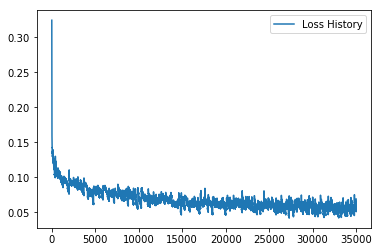

In [90]:
plt.plot(loss_hist, label="Loss History")
plt.legend()
plt.show
len(loss_hist)

In [91]:
# Music Generation
# input = initial note vector
# for t = 1:Tsong
#    input --> input kernel
#    run through 1 'call' of Model LSTM with present parameters / states
#    run through note-wise LSTM block as normally done to produce vector of generated samples
#    input = generated samples
#    music_sequence.append(input)

# store batch of music sequences in .MIDI files


#Load Model
restore_model_name = 'Practice_sigmoid_continue'

#Length of generated music
T_gen = 16*16
batch_gen_size = 20
keep_prob = 1

# start with initial Note_State_Batch with 't' dimension = 1 (can still a batch of samples run in parallel)
notes_gen_initial = np.zeros((batch_gen_size, num_notes, 1,2))

# Initial States
notes_gen = notes_gen_initial
    
timewise_state_val=[]
for i in range(len(num_t_units)):
    c = np.zeros((batch_gen_size*num_notes, num_t_units[i])) #start first time step with zero state in LSTM time cells
    h = np.zeros((batch_gen_size*num_notes, num_t_units[i]))
    timewise_state_val.append(LSTMStateTuple(h, c))
        
notewise_state_val=[]
for i in range(len(num_n_units)):
    c = np.zeros((batch_gen_size*1, num_n_units[i])) #start every batch with zero state in LSTM time cells
    h = np.zeros((batch_gen_size*1, num_n_units[i]))
    notewise_state_val.append(LSTMStateTuple(h, c))
        
notes_gen_arr=[]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    
    print("Load the model from: {}".format(restore_model_name))
    saver.restore(sess, 'model/{}'.format(restore_model_name))
    

    for t in range(T_gen):
        feed_dict = {Note_State_Batch: notes_gen, timewise_state: timewise_state_val, notewise_state: notewise_state_val, time_init: t % 16, output_keep_prob: keep_prob}    
        timewise_state_val, notes_gen = np.squeeze(sess.run([timewise_state_out, note_gen_out], feed_dict = feed_dict), axis=2)
        #print('notes_gen shape = ', notes_gen.shape)
        #notes_gen = np.squeeze(notes_gen, axis=2)
        notes_gen_arr.append(np.squeeze(notes_gen))
        
        
        
        if t % 50 == 0:
            print('Timestep = ', t)
    
notes_gen_out = np.stack(notes_gen_arr, axis=2)
print(notes_gen_out.shape)
        


Load the model from: Practice_sigmoid_continue
INFO:tensorflow:Restoring parameters from model/Practice_sigmoid_continue


INFO:tensorflow:Restoring parameters from model/Practice_sigmoid_continue


Timestep =  0
Timestep =  50
Timestep =  100
Timestep =  150
Timestep =  200
Timestep =  250
(20, 78, 256, 2)


In [92]:
# Save Generate Notes to .MIDI file

notes_gen_out = np.swapaxes(notes_gen_out, axis1=1, axis2=2)
print(notes_gen_out.shape)
#_, notes_gen_out = Utils.multi_training.getPieceBatch(training_pieces)


#print(test_batch.shape)
for iter in range(18):
    file = 'Generated_Midi_Files/Practice_sigmoid_continue' + str(iter)
    midi_out = midi_musical_matrix.noteStateMatrixToMidi(notes_gen_out[iter,:,:,:], name=file)

(20, 256, 78, 2)


Items to Experiment with:
- different T length or variable length T from batch-to-batch for training
- categorize music, either through (unsupervised) clustering or (supervised) labeled music folders.  For clustering, the model would possibly find 'k' 'centroids' in an unsupervised manner each with its own music distribution, so during the music generation stage, 1 of these centroids would be selected for a piece of music.  
- use encoder to reduce dimensionality of each note vector (vector of 79 notes in 1 time step), similiar to encoding the words from the tweets in homework 3 (i.e. there are restricted combinations of notes that can be played simultaneously)
- more advanced sampling/exploring for training/music generation.  This may help prevent the algorithm from getting 'stuck' on a chord, or 